In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import OneHotEncoder
import joblib
from model import RegNet,ClsNet

## add balance data

In [7]:
cls_train=pd.read_csv('data/cls_train.csv')
#reg_train=pd.read_csv('data/reg_train.csv')
#cls_test=pd.read_csv('data/cls_test.csv')
#reg_test=pd.read_csv('data/reg_test.csv')
X_train=pd.read_csv('data/X_train.csv')
#X_test=pd.read_csv('data/X_test.csv')

In [8]:
#reg_train = np.array(reg_train).reshape(-1, 1)
cls_train = np.array(cls_train).reshape(-1, 1)

In [9]:
#X_train['reg'] = reg_train
X_train['cls'] = cls_train

In [11]:
X_train = X_train[X_train['cls'] == 1.]

In [12]:
X_train['cls'].head()

50     1.0
51     1.0
89     1.0
281    1.0
310    1.0
Name: cls, dtype: float64

In [14]:
X_train = X_train.dropna()

In [15]:
len(X_train)

98740

In [16]:
for col in ['ORIGIN_DATE', 'ORIGIN_DATE_CST', 'DEST_DATE', 'DEST_DATE_CST']:
    X_train[col] = pd.to_datetime(X_train[col], errors='coerce')   
X_train['ORIGIN_Hour'] = X_train['ORIGIN_DATE'].dt.hour
X_train['ORIGIN_Minute'] = X_train['ORIGIN_DATE'].dt.minute
X_train['ORIGIN_CST_Hour'] = X_train['ORIGIN_DATE_CST'].dt.hour
X_train['ORIGIN_CST_Minute'] = X_train['ORIGIN_DATE_CST'].dt.minute

X_train['DEST_Hour'] = X_train['DEST_DATE'].dt.hour
X_train['DEST_Minute'] = X_train['DEST_DATE'].dt.minute
X_train['DEST_CST_Hour'] = X_train['DEST_DATE_CST'].dt.hour
X_train['DEST_CST_Minute'] = X_train['DEST_DATE_CST'].dt.minute

In [17]:
#reg_train = X_train['reg']
cls_train = X_train['cls']

In [18]:
X_train = X_train.drop(['cls','ORIGIN_DATE', 'DEST_DATE', 'DEST_DATE_CST','ORIGIN_DATE_CST'], axis=1)
#X_train = X_train.drop(['ORIGIN_DATE_CST'], axis=1)

## encoder

In [21]:
X_train.columns

Index(['DEST', 'DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN',
       'ORIGIN_LONGITUDE', 'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION',
       'DAY_OF_WEEK', 'MONTH', 'YEAR', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'CRS_ELAPSED_TIME', 'MKT_CARRIER', 'OP_CARRIER', 'DISTANCE',
       'ORIGIN_HourlyRelativeHumidity', 'ORIGIN_HourlyPressureTendency',
       'DEST_HourlyPrecipitation', 'ORIGIN_HourlyDryBulbTemperature',
       'DEST_HourlyDryBulbTemperature', 'ORIGIN_HourlyWindSpeed',
       'DEST_HourlyDewPointTemperature', 'DEST_HourlyPressureTendency',
       'DEST_HourlyRelativeHumidity', 'DEST_HourlyVisibility',
       'DEST_HourlyStationPressure', 'ORIGIN_HourlyVisibility',
       'ORIGIN_HourlyDewPointTemperature', 'DEST_HourlyWindDirection',
       'ORIGIN_HourlyStationPressure', 'ORIGIN_HourlySeaLevelPressure',
       'DEST_HourlyWindSpeed', 'DEST_HourlyPressureChange',
       'ORIGIN_HourlyPressureChange', 'ORIGIN_HourlyWindDirection',
       'ORIGIN_HourlyWetBulbTemperatur

In [22]:
has_missing_values = X_train.isnull().any()
has_missing_values

DEST                                False
DEST_LONGITUDE                      False
DEST_LATITUDE                       False
DEST_ELEVATION                      False
ORIGIN                              False
ORIGIN_LONGITUDE                    False
ORIGIN_LATITUDE                     False
ORIGIN_ELEVATION                    False
DAY_OF_WEEK                         False
MONTH                               False
YEAR                                False
CRS_DEP_TIME                        False
CRS_ARR_TIME                        False
CRS_ELAPSED_TIME                    False
MKT_CARRIER                         False
OP_CARRIER                          False
DISTANCE                            False
ORIGIN_HourlyRelativeHumidity       False
ORIGIN_HourlyPressureTendency       False
DEST_HourlyPrecipitation            False
ORIGIN_HourlyDryBulbTemperature     False
DEST_HourlyDryBulbTemperature       False
ORIGIN_HourlyWindSpeed              False
DEST_HourlyDewPointTemperature    

In [23]:
cls_train.isnull().any().any()

False

In [24]:
enc_feature = ['DAY_OF_WEEK', 'DEST', 'ORIGIN', 'MKT_CARRIER', 'OP_CARRIER']

In [25]:
onehot_encoder_loaded = joblib.load('data/onehot_encoder_model.pkl')

In [26]:
X_encoder = onehot_encoder_loaded.transform(X_train[enc_feature])

In [27]:
X_encoder = pd.DataFrame.sparse.from_spmatrix(
   X_encoder, 
    columns=onehot_encoder_loaded.get_feature_names_out(enc_feature)  
)

In [28]:
X_encoder.columns

Index(['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'DEST_ABE',
       'DEST_ABI', 'DEST_ABQ',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=804)

In [29]:
X_encoder.isnull().any().any()

False

In [30]:
X_train = X_train.reset_index(drop=True)
X_encoder = X_encoder.reset_index(drop=True)

In [31]:
X_train.index

RangeIndex(start=0, stop=98740, step=1)

In [32]:
X_encoder.index

RangeIndex(start=0, stop=98740, step=1)

In [33]:
X_train = X_train.drop(enc_feature, axis=1)

In [34]:
X_train = pd.concat([X_train, X_encoder], axis=1)

In [35]:
X_train.columns

Index(['DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN_LONGITUDE',
       'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH', 'YEAR', 'CRS_DEP_TIME',
       'CRS_ARR_TIME',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=848)

In [37]:
cls_train

50         1.0
51         1.0
89         1.0
281        1.0
310        1.0
          ... 
5799688    1.0
5799718    1.0
5799744    1.0
5799820    1.0
5799895    1.0
Name: cls, Length: 98740, dtype: float64

In [38]:
X_train.to_csv('data/sampled_X_train_cancelled.csv')

In [39]:
cls_train.to_csv('data/sampled_cls_train.csv', index=False)

## DataLoader

In [59]:
#cls_train=pd.read_csv('data/dropnacls_train.csv')
#reg_train=pd.read_csv('data/sampled_reg_train.csv')
#cls_test=pd.read_csv('data/cls_test.csv')
#reg_test=pd.read_csv('data/reg_test.csv')
X_train=pd.read_csv('data/sampled_X_train.csv')
X_train_cancelled=pd.read_csv('data/sampled_X_train_cancelled.csv')

In [60]:
X_train.columns

Index(['Unnamed: 0', 'DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION',
       'ORIGIN_LONGITUDE', 'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH',
       'YEAR', 'CRS_DEP_TIME',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=849)

In [61]:
X_train_cancelled.columns

Index(['Unnamed: 0', 'DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION',
       'ORIGIN_LONGITUDE', 'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH',
       'YEAR', 'CRS_DEP_TIME',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=849)

In [62]:
X_train = X_train.drop(X_train.columns[0], axis=1) 

In [63]:
X_train_cancelled = X_train_cancelled.drop(X_train_cancelled.columns[0], axis=1) 

In [64]:
X_train['cls'] = 0

In [65]:
X_train_cancelled['cls'] = 1

In [66]:
X_train.columns

Index(['DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN_LONGITUDE',
       'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH', 'YEAR', 'CRS_DEP_TIME',
       'CRS_ARR_TIME',
       ...
       'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX', 'OP_CARRIER_UA',
       'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV', 'OP_CARRIER_YX',
       'OP_CARRIER_ZW', 'cls'],
      dtype='object', length=849)

In [67]:
X_train_cancelled.columns

Index(['DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN_LONGITUDE',
       'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH', 'YEAR', 'CRS_DEP_TIME',
       'CRS_ARR_TIME',
       ...
       'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX', 'OP_CARRIER_UA',
       'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV', 'OP_CARRIER_YX',
       'OP_CARRIER_ZW', 'cls'],
      dtype='object', length=849)

In [68]:
X_train = pd.concat([X_train, X_train_cancelled], ignore_index=True)

In [69]:
X_train.index

RangeIndex(start=0, stop=164276, step=1)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
device

device(type='cuda')

In [72]:
X_train= pd.get_dummies(X_train, columns=['MONTH'], prefix='MONTH')

In [73]:
X_train = X_train.drop(['CRS_DEP_TIME','CRS_ARR_TIME','YEAR'], axis=1)

In [74]:
feature = list(X_train.columns)
feature

['DEST_LONGITUDE',
 'DEST_LATITUDE',
 'DEST_ELEVATION',
 'ORIGIN_LONGITUDE',
 'ORIGIN_LATITUDE',
 'ORIGIN_ELEVATION',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'ORIGIN_HourlyRelativeHumidity',
 'ORIGIN_HourlyPressureTendency',
 'DEST_HourlyPrecipitation',
 'ORIGIN_HourlyDryBulbTemperature',
 'DEST_HourlyDryBulbTemperature',
 'ORIGIN_HourlyWindSpeed',
 'DEST_HourlyDewPointTemperature',
 'DEST_HourlyPressureTendency',
 'DEST_HourlyRelativeHumidity',
 'DEST_HourlyVisibility',
 'DEST_HourlyStationPressure',
 'ORIGIN_HourlyVisibility',
 'ORIGIN_HourlyDewPointTemperature',
 'DEST_HourlyWindDirection',
 'ORIGIN_HourlyStationPressure',
 'ORIGIN_HourlySeaLevelPressure',
 'DEST_HourlyWindSpeed',
 'DEST_HourlyPressureChange',
 'ORIGIN_HourlyPressureChange',
 'ORIGIN_HourlyWindDirection',
 'ORIGIN_HourlyWetBulbTemperature',
 'ORIGIN_HourlyPrecipitation',
 'DEST_HourlySeaLevelPressure',
 'DEST_HourlyWetBulbTemperature',
 'ORIGIN_Hour',
 'ORIGIN_Minute',
 'ORIGIN_CST_Hour',
 'ORIGIN_CST_Minute',
 'DEST_Hou

In [75]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})

In [76]:
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [77]:
dtype_List = X_train.dtypes
dtype_List

DEST_LONGITUDE      float64
DEST_LATITUDE       float64
DEST_ELEVATION      float64
ORIGIN_LONGITUDE    float64
ORIGIN_LATITUDE     float64
                     ...   
OP_CARRIER_ZW       float64
cls                   int64
MONTH_1               int32
MONTH_11              int32
MONTH_12              int32
Length: 848, dtype: object

In [78]:
cls_train = X_train['cls'].values
X_train =  X_train.drop(['cls'],axis = 1)

In [79]:
feature.remove('cls')
feature

['DEST_LONGITUDE',
 'DEST_LATITUDE',
 'DEST_ELEVATION',
 'ORIGIN_LONGITUDE',
 'ORIGIN_LATITUDE',
 'ORIGIN_ELEVATION',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'ORIGIN_HourlyRelativeHumidity',
 'ORIGIN_HourlyPressureTendency',
 'DEST_HourlyPrecipitation',
 'ORIGIN_HourlyDryBulbTemperature',
 'DEST_HourlyDryBulbTemperature',
 'ORIGIN_HourlyWindSpeed',
 'DEST_HourlyDewPointTemperature',
 'DEST_HourlyPressureTendency',
 'DEST_HourlyRelativeHumidity',
 'DEST_HourlyVisibility',
 'DEST_HourlyStationPressure',
 'ORIGIN_HourlyVisibility',
 'ORIGIN_HourlyDewPointTemperature',
 'DEST_HourlyWindDirection',
 'ORIGIN_HourlyStationPressure',
 'ORIGIN_HourlySeaLevelPressure',
 'DEST_HourlyWindSpeed',
 'DEST_HourlyPressureChange',
 'ORIGIN_HourlyPressureChange',
 'ORIGIN_HourlyWindDirection',
 'ORIGIN_HourlyWetBulbTemperature',
 'ORIGIN_HourlyPrecipitation',
 'DEST_HourlySeaLevelPressure',
 'DEST_HourlyWetBulbTemperature',
 'ORIGIN_Hour',
 'ORIGIN_Minute',
 'ORIGIN_CST_Hour',
 'ORIGIN_CST_Minute',
 'DEST_Hou

In [3]:
scaler = joblib.load('data/scaler.pkl')

In [81]:
#scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature)

In [82]:
X_train.head()

DEST_LONGITUDE  DEST_LATITUDE  DEST_ELEVATION  ORIGIN_LONGITUDE  \
0        0.181279       0.367781        0.302479          0.141480   
1        0.286035       0.348560        0.130363          0.279281   
2        0.308117       0.415712        0.020749          0.296750   
3        0.279581       0.299245        0.024108          0.251838   
4        0.171094       0.432933        0.001446          0.217957   

   ORIGIN_LATITUDE  ORIGIN_ELEVATION  CRS_ELAPSED_TIME  DISTANCE  \
0         0.417584          0.000510          0.072398  0.055129   
1         0.399473          0.073473          0.123680  0.066942   
2         0.472246          0.000935          0.102564  0.051388   
3         0.509890          0.086313          0.259427  0.243158   
4         0.277871          0.101748          0.330317  0.292971   

   ORIGIN_HourlyRelativeHumidity  ORIGIN_HourlyPressureTendency  ...  \
0                       0.766990                       0.333333  ...   
1                       0.582524                       0.555556  ...   
2                       0.660194                       0.333333  ...   
3                       0.825243                       0.666667  ...   
4                       0.368932                       0.333333  ...   

   OP_CARRIER_QX  OP_CARRIER_UA  OP_CARRIER_VX  OP_CARRIER_WN  OP_CARRIER_YV  \
0            0.0            0.0            0.0            1.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            1.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   OP_CARRIER_YX  OP_CARRIER_ZW  MONTH_1  MONTH_11  MONTH_12  
0            0.0            0.0      1.0       0.0       0.0  
1            0.0            0.0      0.0       0.0       1.0  
2            0.0            0.0      0.0       0.0       1.0  
3            0.0            0.0      1.0       0.0       0.0  
4            0.0            0.0      1.0       0.0       0.0  

[5 rows x 847 columns]

In [83]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(cls_train, dtype=torch.int64).to(device)

In [66]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
input_size = 847
hidden_sizes = [512,128] 
output_size = 1

In [6]:
model_reg = RegNet(input_size,hidden_sizes,output_size).to(device)
import torch.nn.init as init

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        # 使用 Xavier 初始化权重
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            # 将偏置初始化为 0
            init.constant_(module.bias, 0)
model_reg.apply(initialize_weights)            

RegNet(
  (network): Sequential(
    (0): Linear(in_features=847, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [7]:
model_reg.load_state_dict(torch.load(f'ck/new_new_model_epoch_{1001}.pth'))

<All keys matched successfully>

In [8]:
import copy

In [9]:
num_classes = 2
feature_extractor = model_reg.get_feature_extractor()
model = ClsNet(feature_extractor, num_classes).to(device)

In [10]:
model.load_state_dict(torch.load(f'ck/cls_model_epoch_{2901}.pth'))

<All keys matched successfully>

In [74]:
model.train() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 3000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=(num_epochs/20), gamma=0.9)
for  epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        #inputs = inputs.to(device)
        #targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        #scheduler.step()

        running_loss += loss.item()
        
        if (batch_idx + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    average_loss = running_loss / len(train_loader)
    print(f'\n Epoch [{epoch+1}/{num_epochs}, average loss = {average_loss} \n')
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'ck/cls_model_epoch_{epoch+1}.pth')
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch [{epoch+1}/{num_epochs}], Learning Rate = {current_lr:.6f}')
    scheduler.step()

Epoch [1/3000], Batch [50/1284], Loss: 0.4347
Epoch [1/3000], Batch [100/1284], Loss: 0.5259
Epoch [1/3000], Batch [150/1284], Loss: 0.4505
Epoch [1/3000], Batch [200/1284], Loss: 0.4765
Epoch [1/3000], Batch [250/1284], Loss: 0.4363
Epoch [1/3000], Batch [300/1284], Loss: 0.5240
Epoch [1/3000], Batch [350/1284], Loss: 0.4693
Epoch [1/3000], Batch [400/1284], Loss: 0.4637
Epoch [1/3000], Batch [450/1284], Loss: 0.4706
Epoch [1/3000], Batch [500/1284], Loss: 0.4962
Epoch [1/3000], Batch [550/1284], Loss: 0.4842
Epoch [1/3000], Batch [600/1284], Loss: 0.5455
Epoch [1/3000], Batch [650/1284], Loss: 0.5556
Epoch [1/3000], Batch [700/1284], Loss: 0.4876
Epoch [1/3000], Batch [750/1284], Loss: 0.4341
Epoch [1/3000], Batch [800/1284], Loss: 0.4784
Epoch [1/3000], Batch [850/1284], Loss: 0.5226
Epoch [1/3000], Batch [900/1284], Loss: 0.4695
Epoch [1/3000], Batch [950/1284], Loss: 0.4746
Epoch [1/3000], Batch [1000/1284], Loss: 0.4924
Epoch [1/3000], Batch [1050/1284], Loss: 0.4450
Epoch [1/300

Epoch [7/3000], Batch [650/1284], Loss: 0.4569
Epoch [7/3000], Batch [700/1284], Loss: 0.4859
Epoch [7/3000], Batch [750/1284], Loss: 0.5320
Epoch [7/3000], Batch [800/1284], Loss: 0.4709
Epoch [7/3000], Batch [850/1284], Loss: 0.5192
Epoch [7/3000], Batch [900/1284], Loss: 0.4867
Epoch [7/3000], Batch [950/1284], Loss: 0.4842
Epoch [7/3000], Batch [1000/1284], Loss: 0.4585
Epoch [7/3000], Batch [1050/1284], Loss: 0.5213
Epoch [7/3000], Batch [1100/1284], Loss: 0.4332
Epoch [7/3000], Batch [1150/1284], Loss: 0.4710
Epoch [7/3000], Batch [1200/1284], Loss: 0.4067
Epoch [7/3000], Batch [1250/1284], Loss: 0.4474

 Epoch [7/3000, average loss = 0.47556999782999726 

Epoch [7/3000], Learning Rate = 0.000500
Epoch [8/3000], Batch [50/1284], Loss: 0.4465
Epoch [8/3000], Batch [100/1284], Loss: 0.4838
Epoch [8/3000], Batch [150/1284], Loss: 0.4425
Epoch [8/3000], Batch [200/1284], Loss: 0.4467
Epoch [8/3000], Batch [250/1284], Loss: 0.4502
Epoch [8/3000], Batch [300/1284], Loss: 0.5517
Epoch [

Epoch [13/3000], Batch [1150/1284], Loss: 0.4696
Epoch [13/3000], Batch [1200/1284], Loss: 0.4884
Epoch [13/3000], Batch [1250/1284], Loss: 0.4296

 Epoch [13/3000, average loss = 0.4741350850351503 

Epoch [13/3000], Learning Rate = 0.000500
Epoch [14/3000], Batch [50/1284], Loss: 0.5186
Epoch [14/3000], Batch [100/1284], Loss: 0.4654
Epoch [14/3000], Batch [150/1284], Loss: 0.4450
Epoch [14/3000], Batch [200/1284], Loss: 0.4695
Epoch [14/3000], Batch [250/1284], Loss: 0.4874
Epoch [14/3000], Batch [300/1284], Loss: 0.5253
Epoch [14/3000], Batch [350/1284], Loss: 0.4404
Epoch [14/3000], Batch [400/1284], Loss: 0.4424
Epoch [14/3000], Batch [450/1284], Loss: 0.4853
Epoch [14/3000], Batch [500/1284], Loss: 0.5481
Epoch [14/3000], Batch [550/1284], Loss: 0.4905
Epoch [14/3000], Batch [600/1284], Loss: 0.4808
Epoch [14/3000], Batch [650/1284], Loss: 0.4478
Epoch [14/3000], Batch [700/1284], Loss: 0.5097
Epoch [14/3000], Batch [750/1284], Loss: 0.4768
Epoch [14/3000], Batch [800/1284], Los

Epoch [20/3000], Batch [250/1284], Loss: 0.4705
Epoch [20/3000], Batch [300/1284], Loss: 0.4775
Epoch [20/3000], Batch [350/1284], Loss: 0.4291
Epoch [20/3000], Batch [400/1284], Loss: 0.4542
Epoch [20/3000], Batch [450/1284], Loss: 0.4786
Epoch [20/3000], Batch [500/1284], Loss: 0.4618
Epoch [20/3000], Batch [550/1284], Loss: 0.4551
Epoch [20/3000], Batch [600/1284], Loss: 0.5145
Epoch [20/3000], Batch [650/1284], Loss: 0.4841
Epoch [20/3000], Batch [700/1284], Loss: 0.5084
Epoch [20/3000], Batch [750/1284], Loss: 0.4219
Epoch [20/3000], Batch [800/1284], Loss: 0.4341
Epoch [20/3000], Batch [850/1284], Loss: 0.4612
Epoch [20/3000], Batch [900/1284], Loss: 0.4634
Epoch [20/3000], Batch [950/1284], Loss: 0.4875
Epoch [20/3000], Batch [1000/1284], Loss: 0.4903
Epoch [20/3000], Batch [1050/1284], Loss: 0.4663
Epoch [20/3000], Batch [1100/1284], Loss: 0.5114
Epoch [20/3000], Batch [1150/1284], Loss: 0.5255
Epoch [20/3000], Batch [1200/1284], Loss: 0.4735
Epoch [20/3000], Batch [1250/1284],

Epoch [26/3000], Batch [650/1284], Loss: 0.4777
Epoch [26/3000], Batch [700/1284], Loss: 0.4133
Epoch [26/3000], Batch [750/1284], Loss: 0.4946
Epoch [26/3000], Batch [800/1284], Loss: 0.4240
Epoch [26/3000], Batch [850/1284], Loss: 0.5110
Epoch [26/3000], Batch [900/1284], Loss: 0.4628
Epoch [26/3000], Batch [950/1284], Loss: 0.5142
Epoch [26/3000], Batch [1000/1284], Loss: 0.4773
Epoch [26/3000], Batch [1050/1284], Loss: 0.4696
Epoch [26/3000], Batch [1100/1284], Loss: 0.5493
Epoch [26/3000], Batch [1150/1284], Loss: 0.4566
Epoch [26/3000], Batch [1200/1284], Loss: 0.4847
Epoch [26/3000], Batch [1250/1284], Loss: 0.4868

 Epoch [26/3000, average loss = 0.471398440871469 

Epoch [26/3000], Learning Rate = 0.000500
Epoch [27/3000], Batch [50/1284], Loss: 0.5401
Epoch [27/3000], Batch [100/1284], Loss: 0.5262
Epoch [27/3000], Batch [150/1284], Loss: 0.5215
Epoch [27/3000], Batch [200/1284], Loss: 0.4488
Epoch [27/3000], Batch [250/1284], Loss: 0.4602
Epoch [27/3000], Batch [300/1284], L

Epoch [32/3000], Batch [1150/1284], Loss: 0.4771
Epoch [32/3000], Batch [1200/1284], Loss: 0.4606
Epoch [32/3000], Batch [1250/1284], Loss: 0.4353

 Epoch [32/3000, average loss = 0.47085001588889003 

Epoch [32/3000], Learning Rate = 0.000500
Epoch [33/3000], Batch [50/1284], Loss: 0.4486
Epoch [33/3000], Batch [100/1284], Loss: 0.4982
Epoch [33/3000], Batch [150/1284], Loss: 0.4706
Epoch [33/3000], Batch [200/1284], Loss: 0.4456
Epoch [33/3000], Batch [250/1284], Loss: 0.4695
Epoch [33/3000], Batch [300/1284], Loss: 0.5255
Epoch [33/3000], Batch [350/1284], Loss: 0.4602
Epoch [33/3000], Batch [400/1284], Loss: 0.4683
Epoch [33/3000], Batch [450/1284], Loss: 0.4696
Epoch [33/3000], Batch [500/1284], Loss: 0.5044
Epoch [33/3000], Batch [550/1284], Loss: 0.3992
Epoch [33/3000], Batch [600/1284], Loss: 0.4922
Epoch [33/3000], Batch [650/1284], Loss: 0.4264
Epoch [33/3000], Batch [700/1284], Loss: 0.4848
Epoch [33/3000], Batch [750/1284], Loss: 0.4965
Epoch [33/3000], Batch [800/1284], Lo

Epoch [39/3000], Batch [250/1284], Loss: 0.4925
Epoch [39/3000], Batch [300/1284], Loss: 0.5191
Epoch [39/3000], Batch [350/1284], Loss: 0.4906
Epoch [39/3000], Batch [400/1284], Loss: 0.5116
Epoch [39/3000], Batch [450/1284], Loss: 0.4689
Epoch [39/3000], Batch [500/1284], Loss: 0.4480
Epoch [39/3000], Batch [550/1284], Loss: 0.4196
Epoch [39/3000], Batch [600/1284], Loss: 0.4533
Epoch [39/3000], Batch [650/1284], Loss: 0.5007
Epoch [39/3000], Batch [700/1284], Loss: 0.5037
Epoch [39/3000], Batch [750/1284], Loss: 0.4310
Epoch [39/3000], Batch [800/1284], Loss: 0.4463
Epoch [39/3000], Batch [850/1284], Loss: 0.4383
Epoch [39/3000], Batch [900/1284], Loss: 0.4462
Epoch [39/3000], Batch [950/1284], Loss: 0.5170
Epoch [39/3000], Batch [1000/1284], Loss: 0.5298
Epoch [39/3000], Batch [1050/1284], Loss: 0.4963
Epoch [39/3000], Batch [1100/1284], Loss: 0.4458
Epoch [39/3000], Batch [1150/1284], Loss: 0.4370
Epoch [39/3000], Batch [1200/1284], Loss: 0.4619
Epoch [39/3000], Batch [1250/1284],

Epoch [45/3000], Batch [750/1284], Loss: 0.4852
Epoch [45/3000], Batch [800/1284], Loss: 0.4930
Epoch [45/3000], Batch [850/1284], Loss: 0.5318
Epoch [45/3000], Batch [900/1284], Loss: 0.4652
Epoch [45/3000], Batch [950/1284], Loss: 0.4323
Epoch [45/3000], Batch [1000/1284], Loss: 0.4554
Epoch [45/3000], Batch [1050/1284], Loss: 0.4696
Epoch [45/3000], Batch [1100/1284], Loss: 0.4696
Epoch [45/3000], Batch [1150/1284], Loss: 0.4850
Epoch [45/3000], Batch [1200/1284], Loss: 0.4620
Epoch [45/3000], Batch [1250/1284], Loss: 0.4843

 Epoch [45/3000, average loss = 0.4688264008762309 

Epoch [45/3000], Learning Rate = 0.000500
Epoch [46/3000], Batch [50/1284], Loss: 0.4711
Epoch [46/3000], Batch [100/1284], Loss: 0.4840
Epoch [46/3000], Batch [150/1284], Loss: 0.4708
Epoch [46/3000], Batch [200/1284], Loss: 0.4926
Epoch [46/3000], Batch [250/1284], Loss: 0.5035
Epoch [46/3000], Batch [300/1284], Loss: 0.4782
Epoch [46/3000], Batch [350/1284], Loss: 0.4939
Epoch [46/3000], Batch [400/1284], 

Epoch [51/3000], Batch [1150/1284], Loss: 0.5113
Epoch [51/3000], Batch [1200/1284], Loss: 0.4753
Epoch [51/3000], Batch [1250/1284], Loss: 0.4923

 Epoch [51/3000, average loss = 0.4681963651583202 

Epoch [51/3000], Learning Rate = 0.000500
Epoch [52/3000], Batch [50/1284], Loss: 0.4242
Epoch [52/3000], Batch [100/1284], Loss: 0.4686
Epoch [52/3000], Batch [150/1284], Loss: 0.4823
Epoch [52/3000], Batch [200/1284], Loss: 0.4912
Epoch [52/3000], Batch [250/1284], Loss: 0.4170
Epoch [52/3000], Batch [300/1284], Loss: 0.4933
Epoch [52/3000], Batch [350/1284], Loss: 0.4855
Epoch [52/3000], Batch [400/1284], Loss: 0.4592
Epoch [52/3000], Batch [450/1284], Loss: 0.4493
Epoch [52/3000], Batch [500/1284], Loss: 0.5184
Epoch [52/3000], Batch [550/1284], Loss: 0.4474
Epoch [52/3000], Batch [600/1284], Loss: 0.4546
Epoch [52/3000], Batch [650/1284], Loss: 0.4819
Epoch [52/3000], Batch [700/1284], Loss: 0.4158
Epoch [52/3000], Batch [750/1284], Loss: 0.4773
Epoch [52/3000], Batch [800/1284], Los

Epoch [58/3000], Batch [250/1284], Loss: 0.4768
Epoch [58/3000], Batch [300/1284], Loss: 0.4577
Epoch [58/3000], Batch [350/1284], Loss: 0.4449
Epoch [58/3000], Batch [400/1284], Loss: 0.4768
Epoch [58/3000], Batch [450/1284], Loss: 0.4539
Epoch [58/3000], Batch [500/1284], Loss: 0.4639
Epoch [58/3000], Batch [550/1284], Loss: 0.4925
Epoch [58/3000], Batch [600/1284], Loss: 0.4472
Epoch [58/3000], Batch [650/1284], Loss: 0.4721
Epoch [58/3000], Batch [700/1284], Loss: 0.4386
Epoch [58/3000], Batch [750/1284], Loss: 0.4939
Epoch [58/3000], Batch [800/1284], Loss: 0.4466
Epoch [58/3000], Batch [850/1284], Loss: 0.4631
Epoch [58/3000], Batch [900/1284], Loss: 0.3919
Epoch [58/3000], Batch [950/1284], Loss: 0.4294
Epoch [58/3000], Batch [1000/1284], Loss: 0.4544
Epoch [58/3000], Batch [1050/1284], Loss: 0.3992
Epoch [58/3000], Batch [1100/1284], Loss: 0.4487
Epoch [58/3000], Batch [1150/1284], Loss: 0.4723
Epoch [58/3000], Batch [1200/1284], Loss: 0.4539
Epoch [58/3000], Batch [1250/1284],

Epoch [64/3000], Batch [750/1284], Loss: 0.4148
Epoch [64/3000], Batch [800/1284], Loss: 0.4591
Epoch [64/3000], Batch [850/1284], Loss: 0.4813
Epoch [64/3000], Batch [900/1284], Loss: 0.4312
Epoch [64/3000], Batch [950/1284], Loss: 0.5620
Epoch [64/3000], Batch [1000/1284], Loss: 0.4239
Epoch [64/3000], Batch [1050/1284], Loss: 0.4800
Epoch [64/3000], Batch [1100/1284], Loss: 0.4398
Epoch [64/3000], Batch [1150/1284], Loss: 0.4695
Epoch [64/3000], Batch [1200/1284], Loss: 0.4785
Epoch [64/3000], Batch [1250/1284], Loss: 0.4441

 Epoch [64/3000, average loss = 0.4667731458756411 

Epoch [64/3000], Learning Rate = 0.000500
Epoch [65/3000], Batch [50/1284], Loss: 0.4415
Epoch [65/3000], Batch [100/1284], Loss: 0.5496
Epoch [65/3000], Batch [150/1284], Loss: 0.4560
Epoch [65/3000], Batch [200/1284], Loss: 0.5112
Epoch [65/3000], Batch [250/1284], Loss: 0.4265
Epoch [65/3000], Batch [300/1284], Loss: 0.4878
Epoch [65/3000], Batch [350/1284], Loss: 0.5086
Epoch [65/3000], Batch [400/1284], 

Epoch [70/3000], Batch [1150/1284], Loss: 0.5008
Epoch [70/3000], Batch [1200/1284], Loss: 0.4617
Epoch [70/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [70/3000, average loss = 0.46563640334338785 

Epoch [70/3000], Learning Rate = 0.000500
Epoch [71/3000], Batch [50/1284], Loss: 0.4340
Epoch [71/3000], Batch [100/1284], Loss: 0.4507
Epoch [71/3000], Batch [150/1284], Loss: 0.4218
Epoch [71/3000], Batch [200/1284], Loss: 0.4853
Epoch [71/3000], Batch [250/1284], Loss: 0.4653
Epoch [71/3000], Batch [300/1284], Loss: 0.4539
Epoch [71/3000], Batch [350/1284], Loss: 0.4070
Epoch [71/3000], Batch [400/1284], Loss: 0.4931
Epoch [71/3000], Batch [450/1284], Loss: 0.4544
Epoch [71/3000], Batch [500/1284], Loss: 0.4984
Epoch [71/3000], Batch [550/1284], Loss: 0.4894
Epoch [71/3000], Batch [600/1284], Loss: 0.4610
Epoch [71/3000], Batch [650/1284], Loss: 0.4878
Epoch [71/3000], Batch [700/1284], Loss: 0.4851
Epoch [71/3000], Batch [750/1284], Loss: 0.4305
Epoch [71/3000], Batch [800/1284], Lo

Epoch [77/3000], Batch [250/1284], Loss: 0.4498
Epoch [77/3000], Batch [300/1284], Loss: 0.5008
Epoch [77/3000], Batch [350/1284], Loss: 0.4475
Epoch [77/3000], Batch [400/1284], Loss: 0.4905
Epoch [77/3000], Batch [450/1284], Loss: 0.4312
Epoch [77/3000], Batch [500/1284], Loss: 0.4156
Epoch [77/3000], Batch [550/1284], Loss: 0.4931
Epoch [77/3000], Batch [600/1284], Loss: 0.5007
Epoch [77/3000], Batch [650/1284], Loss: 0.5085
Epoch [77/3000], Batch [700/1284], Loss: 0.4581
Epoch [77/3000], Batch [750/1284], Loss: 0.5178
Epoch [77/3000], Batch [800/1284], Loss: 0.4559
Epoch [77/3000], Batch [850/1284], Loss: 0.4854
Epoch [77/3000], Batch [900/1284], Loss: 0.4610
Epoch [77/3000], Batch [950/1284], Loss: 0.4674
Epoch [77/3000], Batch [1000/1284], Loss: 0.4461
Epoch [77/3000], Batch [1050/1284], Loss: 0.4382
Epoch [77/3000], Batch [1100/1284], Loss: 0.4439
Epoch [77/3000], Batch [1150/1284], Loss: 0.5292
Epoch [77/3000], Batch [1200/1284], Loss: 0.4332
Epoch [77/3000], Batch [1250/1284],

Epoch [83/3000], Batch [750/1284], Loss: 0.4614
Epoch [83/3000], Batch [800/1284], Loss: 0.3878
Epoch [83/3000], Batch [850/1284], Loss: 0.4541
Epoch [83/3000], Batch [900/1284], Loss: 0.4758
Epoch [83/3000], Batch [950/1284], Loss: 0.4664
Epoch [83/3000], Batch [1000/1284], Loss: 0.4219
Epoch [83/3000], Batch [1050/1284], Loss: 0.4855
Epoch [83/3000], Batch [1100/1284], Loss: 0.5081
Epoch [83/3000], Batch [1150/1284], Loss: 0.4714
Epoch [83/3000], Batch [1200/1284], Loss: 0.4304
Epoch [83/3000], Batch [1250/1284], Loss: 0.4243

 Epoch [83/3000, average loss = 0.4647100089912845 

Epoch [83/3000], Learning Rate = 0.000500
Epoch [84/3000], Batch [50/1284], Loss: 0.4857
Epoch [84/3000], Batch [100/1284], Loss: 0.4401
Epoch [84/3000], Batch [150/1284], Loss: 0.4635
Epoch [84/3000], Batch [200/1284], Loss: 0.5008
Epoch [84/3000], Batch [250/1284], Loss: 0.4387
Epoch [84/3000], Batch [300/1284], Loss: 0.4853
Epoch [84/3000], Batch [350/1284], Loss: 0.4743
Epoch [84/3000], Batch [400/1284], 

Epoch [89/3000], Batch [1150/1284], Loss: 0.4929
Epoch [89/3000], Batch [1200/1284], Loss: 0.4539
Epoch [89/3000], Batch [1250/1284], Loss: 0.4698

 Epoch [89/3000, average loss = 0.46461619406567184 

Epoch [89/3000], Learning Rate = 0.000500
Epoch [90/3000], Batch [50/1284], Loss: 0.4476
Epoch [90/3000], Batch [100/1284], Loss: 0.4415
Epoch [90/3000], Batch [150/1284], Loss: 0.4617
Epoch [90/3000], Batch [200/1284], Loss: 0.4852
Epoch [90/3000], Batch [250/1284], Loss: 0.4319
Epoch [90/3000], Batch [300/1284], Loss: 0.4528
Epoch [90/3000], Batch [350/1284], Loss: 0.4619
Epoch [90/3000], Batch [400/1284], Loss: 0.4608
Epoch [90/3000], Batch [450/1284], Loss: 0.4472
Epoch [90/3000], Batch [500/1284], Loss: 0.5085
Epoch [90/3000], Batch [550/1284], Loss: 0.4617
Epoch [90/3000], Batch [600/1284], Loss: 0.4945
Epoch [90/3000], Batch [650/1284], Loss: 0.4327
Epoch [90/3000], Batch [700/1284], Loss: 0.4479
Epoch [90/3000], Batch [750/1284], Loss: 0.4827
Epoch [90/3000], Batch [800/1284], Lo

Epoch [96/3000], Batch [250/1284], Loss: 0.5086
Epoch [96/3000], Batch [300/1284], Loss: 0.4383
Epoch [96/3000], Batch [350/1284], Loss: 0.4458
Epoch [96/3000], Batch [400/1284], Loss: 0.4261
Epoch [96/3000], Batch [450/1284], Loss: 0.4617
Epoch [96/3000], Batch [500/1284], Loss: 0.4524
Epoch [96/3000], Batch [550/1284], Loss: 0.4933
Epoch [96/3000], Batch [600/1284], Loss: 0.4595
Epoch [96/3000], Batch [650/1284], Loss: 0.4298
Epoch [96/3000], Batch [700/1284], Loss: 0.4464
Epoch [96/3000], Batch [750/1284], Loss: 0.4082
Epoch [96/3000], Batch [800/1284], Loss: 0.4695
Epoch [96/3000], Batch [850/1284], Loss: 0.4303
Epoch [96/3000], Batch [900/1284], Loss: 0.4899
Epoch [96/3000], Batch [950/1284], Loss: 0.4684
Epoch [96/3000], Batch [1000/1284], Loss: 0.5008
Epoch [96/3000], Batch [1050/1284], Loss: 0.4556
Epoch [96/3000], Batch [1100/1284], Loss: 0.4383
Epoch [96/3000], Batch [1150/1284], Loss: 0.5320
Epoch [96/3000], Batch [1200/1284], Loss: 0.4565
Epoch [96/3000], Batch [1250/1284],

Epoch [102/3000], Batch [650/1284], Loss: 0.4305
Epoch [102/3000], Batch [700/1284], Loss: 0.4384
Epoch [102/3000], Batch [750/1284], Loss: 0.4931
Epoch [102/3000], Batch [800/1284], Loss: 0.4535
Epoch [102/3000], Batch [850/1284], Loss: 0.4851
Epoch [102/3000], Batch [900/1284], Loss: 0.4928
Epoch [102/3000], Batch [950/1284], Loss: 0.4618
Epoch [102/3000], Batch [1000/1284], Loss: 0.4776
Epoch [102/3000], Batch [1050/1284], Loss: 0.4514
Epoch [102/3000], Batch [1100/1284], Loss: 0.4932
Epoch [102/3000], Batch [1150/1284], Loss: 0.4304
Epoch [102/3000], Batch [1200/1284], Loss: 0.4708
Epoch [102/3000], Batch [1250/1284], Loss: 0.4144

 Epoch [102/3000, average loss = 0.463683823396298 

Epoch [102/3000], Learning Rate = 0.000500
Epoch [103/3000], Batch [50/1284], Loss: 0.4612
Epoch [103/3000], Batch [100/1284], Loss: 0.4368
Epoch [103/3000], Batch [150/1284], Loss: 0.4315
Epoch [103/3000], Batch [200/1284], Loss: 0.4470
Epoch [103/3000], Batch [250/1284], Loss: 0.5151
Epoch [103/3000]

Epoch [108/3000], Batch [950/1284], Loss: 0.4737
Epoch [108/3000], Batch [1000/1284], Loss: 0.3934
Epoch [108/3000], Batch [1050/1284], Loss: 0.4787
Epoch [108/3000], Batch [1100/1284], Loss: 0.4270
Epoch [108/3000], Batch [1150/1284], Loss: 0.4901
Epoch [108/3000], Batch [1200/1284], Loss: 0.4919
Epoch [108/3000], Batch [1250/1284], Loss: 0.4373

 Epoch [108/3000, average loss = 0.4642704397300694 

Epoch [108/3000], Learning Rate = 0.000500
Epoch [109/3000], Batch [50/1284], Loss: 0.4249
Epoch [109/3000], Batch [100/1284], Loss: 0.4796
Epoch [109/3000], Batch [150/1284], Loss: 0.4930
Epoch [109/3000], Batch [200/1284], Loss: 0.4276
Epoch [109/3000], Batch [250/1284], Loss: 0.4617
Epoch [109/3000], Batch [300/1284], Loss: 0.4506
Epoch [109/3000], Batch [350/1284], Loss: 0.4331
Epoch [109/3000], Batch [400/1284], Loss: 0.4617
Epoch [109/3000], Batch [450/1284], Loss: 0.4386
Epoch [109/3000], Batch [500/1284], Loss: 0.4665
Epoch [109/3000], Batch [550/1284], Loss: 0.4698
Epoch [109/3000

Epoch [114/3000], Batch [1250/1284], Loss: 0.5009

 Epoch [114/3000, average loss = 0.4628622727555649 

Epoch [114/3000], Learning Rate = 0.000500
Epoch [115/3000], Batch [50/1284], Loss: 0.4134
Epoch [115/3000], Batch [100/1284], Loss: 0.4539
Epoch [115/3000], Batch [150/1284], Loss: 0.4445
Epoch [115/3000], Batch [200/1284], Loss: 0.4618
Epoch [115/3000], Batch [250/1284], Loss: 0.5093
Epoch [115/3000], Batch [300/1284], Loss: 0.4852
Epoch [115/3000], Batch [350/1284], Loss: 0.4540
Epoch [115/3000], Batch [400/1284], Loss: 0.4854
Epoch [115/3000], Batch [450/1284], Loss: 0.5002
Epoch [115/3000], Batch [500/1284], Loss: 0.4370
Epoch [115/3000], Batch [550/1284], Loss: 0.5169
Epoch [115/3000], Batch [600/1284], Loss: 0.4774
Epoch [115/3000], Batch [650/1284], Loss: 0.5164
Epoch [115/3000], Batch [700/1284], Loss: 0.4383
Epoch [115/3000], Batch [750/1284], Loss: 0.5134
Epoch [115/3000], Batch [800/1284], Loss: 0.4591
Epoch [115/3000], Batch [850/1284], Loss: 0.4899
Epoch [115/3000], Ba

Epoch [121/3000], Batch [150/1284], Loss: 0.4853
Epoch [121/3000], Batch [200/1284], Loss: 0.4774
Epoch [121/3000], Batch [250/1284], Loss: 0.4383
Epoch [121/3000], Batch [300/1284], Loss: 0.4942
Epoch [121/3000], Batch [350/1284], Loss: 0.4297
Epoch [121/3000], Batch [400/1284], Loss: 0.4070
Epoch [121/3000], Batch [450/1284], Loss: 0.4618
Epoch [121/3000], Batch [500/1284], Loss: 0.5100
Epoch [121/3000], Batch [550/1284], Loss: 0.3916
Epoch [121/3000], Batch [600/1284], Loss: 0.4695
Epoch [121/3000], Batch [650/1284], Loss: 0.4488
Epoch [121/3000], Batch [700/1284], Loss: 0.5088
Epoch [121/3000], Batch [750/1284], Loss: 0.4490
Epoch [121/3000], Batch [800/1284], Loss: 0.5195
Epoch [121/3000], Batch [850/1284], Loss: 0.4929
Epoch [121/3000], Batch [900/1284], Loss: 0.4657
Epoch [121/3000], Batch [950/1284], Loss: 0.4773
Epoch [121/3000], Batch [1000/1284], Loss: 0.4770
Epoch [121/3000], Batch [1050/1284], Loss: 0.5373
Epoch [121/3000], Batch [1100/1284], Loss: 0.4865
Epoch [121/3000],

Epoch [127/3000], Batch [450/1284], Loss: 0.4414
Epoch [127/3000], Batch [500/1284], Loss: 0.4535
Epoch [127/3000], Batch [550/1284], Loss: 0.4676
Epoch [127/3000], Batch [600/1284], Loss: 0.4462
Epoch [127/3000], Batch [650/1284], Loss: 0.4539
Epoch [127/3000], Batch [700/1284], Loss: 0.4784
Epoch [127/3000], Batch [750/1284], Loss: 0.4283
Epoch [127/3000], Batch [800/1284], Loss: 0.4994
Epoch [127/3000], Batch [850/1284], Loss: 0.4723
Epoch [127/3000], Batch [900/1284], Loss: 0.5467
Epoch [127/3000], Batch [950/1284], Loss: 0.4774
Epoch [127/3000], Batch [1000/1284], Loss: 0.4854
Epoch [127/3000], Batch [1050/1284], Loss: 0.4507
Epoch [127/3000], Batch [1100/1284], Loss: 0.3992
Epoch [127/3000], Batch [1150/1284], Loss: 0.4639
Epoch [127/3000], Batch [1200/1284], Loss: 0.4363
Epoch [127/3000], Batch [1250/1284], Loss: 0.3998

 Epoch [127/3000, average loss = 0.46152799330489286 

Epoch [127/3000], Learning Rate = 0.000500
Epoch [128/3000], Batch [50/1284], Loss: 0.4929
Epoch [128/300

Epoch [133/3000], Batch [750/1284], Loss: 0.4816
Epoch [133/3000], Batch [800/1284], Loss: 0.4193
Epoch [133/3000], Batch [850/1284], Loss: 0.4229
Epoch [133/3000], Batch [900/1284], Loss: 0.4539
Epoch [133/3000], Batch [950/1284], Loss: 0.4617
Epoch [133/3000], Batch [1000/1284], Loss: 0.4589
Epoch [133/3000], Batch [1050/1284], Loss: 0.4835
Epoch [133/3000], Batch [1100/1284], Loss: 0.4388
Epoch [133/3000], Batch [1150/1284], Loss: 0.4545
Epoch [133/3000], Batch [1200/1284], Loss: 0.4461
Epoch [133/3000], Batch [1250/1284], Loss: 0.4772

 Epoch [133/3000, average loss = 0.4619271082345199 

Epoch [133/3000], Learning Rate = 0.000500
Epoch [134/3000], Batch [50/1284], Loss: 0.4696
Epoch [134/3000], Batch [100/1284], Loss: 0.4773
Epoch [134/3000], Batch [150/1284], Loss: 0.4617
Epoch [134/3000], Batch [200/1284], Loss: 0.4305
Epoch [134/3000], Batch [250/1284], Loss: 0.4775
Epoch [134/3000], Batch [300/1284], Loss: 0.4617
Epoch [134/3000], Batch [350/1284], Loss: 0.4168
Epoch [134/3000

Epoch [139/3000], Batch [1050/1284], Loss: 0.4340
Epoch [139/3000], Batch [1100/1284], Loss: 0.4851
Epoch [139/3000], Batch [1150/1284], Loss: 0.4774
Epoch [139/3000], Batch [1200/1284], Loss: 0.4007
Epoch [139/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [139/3000, average loss = 0.4612029249376597 

Epoch [139/3000], Learning Rate = 0.000500
Epoch [140/3000], Batch [50/1284], Loss: 0.5003
Epoch [140/3000], Batch [100/1284], Loss: 0.4397
Epoch [140/3000], Batch [150/1284], Loss: 0.4078
Epoch [140/3000], Batch [200/1284], Loss: 0.4695
Epoch [140/3000], Batch [250/1284], Loss: 0.4691
Epoch [140/3000], Batch [300/1284], Loss: 0.4698
Epoch [140/3000], Batch [350/1284], Loss: 0.4315
Epoch [140/3000], Batch [400/1284], Loss: 0.4305
Epoch [140/3000], Batch [450/1284], Loss: 0.4695
Epoch [140/3000], Batch [500/1284], Loss: 0.4616
Epoch [140/3000], Batch [550/1284], Loss: 0.4393
Epoch [140/3000], Batch [600/1284], Loss: 0.5086
Epoch [140/3000], Batch [650/1284], Loss: 0.5011
Epoch [140/3000]

Epoch [146/3000], Batch [50/1284], Loss: 0.4461
Epoch [146/3000], Batch [100/1284], Loss: 0.4770
Epoch [146/3000], Batch [150/1284], Loss: 0.4930
Epoch [146/3000], Batch [200/1284], Loss: 0.4697
Epoch [146/3000], Batch [250/1284], Loss: 0.4237
Epoch [146/3000], Batch [300/1284], Loss: 0.4382
Epoch [146/3000], Batch [350/1284], Loss: 0.4539
Epoch [146/3000], Batch [400/1284], Loss: 0.4772
Epoch [146/3000], Batch [450/1284], Loss: 0.4226
Epoch [146/3000], Batch [500/1284], Loss: 0.4433
Epoch [146/3000], Batch [550/1284], Loss: 0.4932
Epoch [146/3000], Batch [600/1284], Loss: 0.4695
Epoch [146/3000], Batch [650/1284], Loss: 0.4408
Epoch [146/3000], Batch [700/1284], Loss: 0.4930
Epoch [146/3000], Batch [750/1284], Loss: 0.5398
Epoch [146/3000], Batch [800/1284], Loss: 0.4775
Epoch [146/3000], Batch [850/1284], Loss: 0.4929
Epoch [146/3000], Batch [900/1284], Loss: 0.4857
Epoch [146/3000], Batch [950/1284], Loss: 0.4305
Epoch [146/3000], Batch [1000/1284], Loss: 0.4461
Epoch [146/3000], Ba

Epoch [152/3000], Batch [350/1284], Loss: 0.4773
Epoch [152/3000], Batch [400/1284], Loss: 0.4148
Epoch [152/3000], Batch [450/1284], Loss: 0.4383
Epoch [152/3000], Batch [500/1284], Loss: 0.4684
Epoch [152/3000], Batch [550/1284], Loss: 0.4655
Epoch [152/3000], Batch [600/1284], Loss: 0.4226
Epoch [152/3000], Batch [650/1284], Loss: 0.4227
Epoch [152/3000], Batch [700/1284], Loss: 0.4843
Epoch [152/3000], Batch [750/1284], Loss: 0.4617
Epoch [152/3000], Batch [800/1284], Loss: 0.4617
Epoch [152/3000], Batch [850/1284], Loss: 0.4226
Epoch [152/3000], Batch [900/1284], Loss: 0.4305
Epoch [152/3000], Batch [950/1284], Loss: 0.4306
Epoch [152/3000], Batch [1000/1284], Loss: 0.4692
Epoch [152/3000], Batch [1050/1284], Loss: 0.4073
Epoch [152/3000], Batch [1100/1284], Loss: 0.4128
Epoch [152/3000], Batch [1150/1284], Loss: 0.4539
Epoch [152/3000], Batch [1200/1284], Loss: 0.5003
Epoch [152/3000], Batch [1250/1284], Loss: 0.4397

 Epoch [152/3000, average loss = 0.45972286478102764 

Epoch [

Epoch [158/3000], Batch [650/1284], Loss: 0.4912
Epoch [158/3000], Batch [700/1284], Loss: 0.4929
Epoch [158/3000], Batch [750/1284], Loss: 0.4226
Epoch [158/3000], Batch [800/1284], Loss: 0.4741
Epoch [158/3000], Batch [850/1284], Loss: 0.4471
Epoch [158/3000], Batch [900/1284], Loss: 0.4570
Epoch [158/3000], Batch [950/1284], Loss: 0.4695
Epoch [158/3000], Batch [1000/1284], Loss: 0.4695
Epoch [158/3000], Batch [1050/1284], Loss: 0.4665
Epoch [158/3000], Batch [1100/1284], Loss: 0.4521
Epoch [158/3000], Batch [1150/1284], Loss: 0.4566
Epoch [158/3000], Batch [1200/1284], Loss: 0.4384
Epoch [158/3000], Batch [1250/1284], Loss: 0.4791

 Epoch [158/3000, average loss = 0.4593453544229733 

Epoch [158/3000], Learning Rate = 0.000450
Epoch [159/3000], Batch [50/1284], Loss: 0.4695
Epoch [159/3000], Batch [100/1284], Loss: 0.5164
Epoch [159/3000], Batch [150/1284], Loss: 0.4149
Epoch [159/3000], Batch [200/1284], Loss: 0.4746
Epoch [159/3000], Batch [250/1284], Loss: 0.4778
Epoch [159/3000

Epoch [164/3000], Batch [950/1284], Loss: 0.4226
Epoch [164/3000], Batch [1000/1284], Loss: 0.4700
Epoch [164/3000], Batch [1050/1284], Loss: 0.4617
Epoch [164/3000], Batch [1100/1284], Loss: 0.4929
Epoch [164/3000], Batch [1150/1284], Loss: 0.4380
Epoch [164/3000], Batch [1200/1284], Loss: 0.4632
Epoch [164/3000], Batch [1250/1284], Loss: 0.4702

 Epoch [164/3000, average loss = 0.45881344266583984 

Epoch [164/3000], Learning Rate = 0.000450
Epoch [165/3000], Batch [50/1284], Loss: 0.4615
Epoch [165/3000], Batch [100/1284], Loss: 0.4734
Epoch [165/3000], Batch [150/1284], Loss: 0.4773
Epoch [165/3000], Batch [200/1284], Loss: 0.4925
Epoch [165/3000], Batch [250/1284], Loss: 0.4560
Epoch [165/3000], Batch [300/1284], Loss: 0.4694
Epoch [165/3000], Batch [350/1284], Loss: 0.4678
Epoch [165/3000], Batch [400/1284], Loss: 0.4846
Epoch [165/3000], Batch [450/1284], Loss: 0.3992
Epoch [165/3000], Batch [500/1284], Loss: 0.4773
Epoch [165/3000], Batch [550/1284], Loss: 0.4383
Epoch [165/300

Epoch [170/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [170/3000, average loss = 0.4588715678249193 

Epoch [170/3000], Learning Rate = 0.000450
Epoch [171/3000], Batch [50/1284], Loss: 0.5164
Epoch [171/3000], Batch [100/1284], Loss: 0.4226
Epoch [171/3000], Batch [150/1284], Loss: 0.3914
Epoch [171/3000], Batch [200/1284], Loss: 0.4929
Epoch [171/3000], Batch [250/1284], Loss: 0.5120
Epoch [171/3000], Batch [300/1284], Loss: 0.4838
Epoch [171/3000], Batch [350/1284], Loss: 0.4692
Epoch [171/3000], Batch [400/1284], Loss: 0.4930
Epoch [171/3000], Batch [450/1284], Loss: 0.4383
Epoch [171/3000], Batch [500/1284], Loss: 0.4543
Epoch [171/3000], Batch [550/1284], Loss: 0.4539
Epoch [171/3000], Batch [600/1284], Loss: 0.4421
Epoch [171/3000], Batch [650/1284], Loss: 0.4985
Epoch [171/3000], Batch [700/1284], Loss: 0.4793
Epoch [171/3000], Batch [750/1284], Loss: 0.4930
Epoch [171/3000], Batch [800/1284], Loss: 0.4566
Epoch [171/3000], Batch [850/1284], Loss: 0.4216
Epoch [171/3000], Ba

Epoch [177/3000], Batch [150/1284], Loss: 0.4073
Epoch [177/3000], Batch [200/1284], Loss: 0.4931
Epoch [177/3000], Batch [250/1284], Loss: 0.4383
Epoch [177/3000], Batch [300/1284], Loss: 0.4710
Epoch [177/3000], Batch [350/1284], Loss: 0.5220
Epoch [177/3000], Batch [400/1284], Loss: 0.4615
Epoch [177/3000], Batch [450/1284], Loss: 0.4442
Epoch [177/3000], Batch [500/1284], Loss: 0.4829
Epoch [177/3000], Batch [550/1284], Loss: 0.4040
Epoch [177/3000], Batch [600/1284], Loss: 0.4226
Epoch [177/3000], Batch [650/1284], Loss: 0.4773
Epoch [177/3000], Batch [700/1284], Loss: 0.4765
Epoch [177/3000], Batch [750/1284], Loss: 0.4834
Epoch [177/3000], Batch [800/1284], Loss: 0.4609
Epoch [177/3000], Batch [850/1284], Loss: 0.4461
Epoch [177/3000], Batch [900/1284], Loss: 0.4074
Epoch [177/3000], Batch [950/1284], Loss: 0.5242
Epoch [177/3000], Batch [1000/1284], Loss: 0.4695
Epoch [177/3000], Batch [1050/1284], Loss: 0.4461
Epoch [177/3000], Batch [1100/1284], Loss: 0.4305
Epoch [177/3000],

Epoch [183/3000], Batch [450/1284], Loss: 0.4716
Epoch [183/3000], Batch [500/1284], Loss: 0.4851
Epoch [183/3000], Batch [550/1284], Loss: 0.4418
Epoch [183/3000], Batch [600/1284], Loss: 0.4137
Epoch [183/3000], Batch [650/1284], Loss: 0.4929
Epoch [183/3000], Batch [700/1284], Loss: 0.4597
Epoch [183/3000], Batch [750/1284], Loss: 0.4539
Epoch [183/3000], Batch [800/1284], Loss: 0.5020
Epoch [183/3000], Batch [850/1284], Loss: 0.4538
Epoch [183/3000], Batch [900/1284], Loss: 0.5242
Epoch [183/3000], Batch [950/1284], Loss: 0.4313
Epoch [183/3000], Batch [1000/1284], Loss: 0.4851
Epoch [183/3000], Batch [1050/1284], Loss: 0.3872
Epoch [183/3000], Batch [1100/1284], Loss: 0.5008
Epoch [183/3000], Batch [1150/1284], Loss: 0.5164
Epoch [183/3000], Batch [1200/1284], Loss: 0.4773
Epoch [183/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [183/3000, average loss = 0.4572297575596337 

Epoch [183/3000], Learning Rate = 0.000450
Epoch [184/3000], Batch [50/1284], Loss: 0.4539
Epoch [184/3000

Epoch [189/3000], Batch [750/1284], Loss: 0.4383
Epoch [189/3000], Batch [800/1284], Loss: 0.4851
Epoch [189/3000], Batch [850/1284], Loss: 0.4601
Epoch [189/3000], Batch [900/1284], Loss: 0.4461
Epoch [189/3000], Batch [950/1284], Loss: 0.4773
Epoch [189/3000], Batch [1000/1284], Loss: 0.4300
Epoch [189/3000], Batch [1050/1284], Loss: 0.4155
Epoch [189/3000], Batch [1100/1284], Loss: 0.4929
Epoch [189/3000], Batch [1150/1284], Loss: 0.4900
Epoch [189/3000], Batch [1200/1284], Loss: 0.4305
Epoch [189/3000], Batch [1250/1284], Loss: 0.5354

 Epoch [189/3000, average loss = 0.45827805798651644 

Epoch [189/3000], Learning Rate = 0.000450
Epoch [190/3000], Batch [50/1284], Loss: 0.5008
Epoch [190/3000], Batch [100/1284], Loss: 0.4148
Epoch [190/3000], Batch [150/1284], Loss: 0.4627
Epoch [190/3000], Batch [200/1284], Loss: 0.4461
Epoch [190/3000], Batch [250/1284], Loss: 0.4148
Epoch [190/3000], Batch [300/1284], Loss: 0.4379
Epoch [190/3000], Batch [350/1284], Loss: 0.5086
Epoch [190/300

Epoch [195/3000], Batch [1050/1284], Loss: 0.4008
Epoch [195/3000], Batch [1100/1284], Loss: 0.4805
Epoch [195/3000], Batch [1150/1284], Loss: 0.4353
Epoch [195/3000], Batch [1200/1284], Loss: 0.3977
Epoch [195/3000], Batch [1250/1284], Loss: 0.4850

 Epoch [195/3000, average loss = 0.45809466173622837 

Epoch [195/3000], Learning Rate = 0.000450
Epoch [196/3000], Batch [50/1284], Loss: 0.4837
Epoch [196/3000], Batch [100/1284], Loss: 0.4262
Epoch [196/3000], Batch [150/1284], Loss: 0.4617
Epoch [196/3000], Batch [200/1284], Loss: 0.4234
Epoch [196/3000], Batch [250/1284], Loss: 0.4304
Epoch [196/3000], Batch [300/1284], Loss: 0.4341
Epoch [196/3000], Batch [350/1284], Loss: 0.4465
Epoch [196/3000], Batch [400/1284], Loss: 0.4618
Epoch [196/3000], Batch [450/1284], Loss: 0.4070
Epoch [196/3000], Batch [500/1284], Loss: 0.5293
Epoch [196/3000], Batch [550/1284], Loss: 0.4229
Epoch [196/3000], Batch [600/1284], Loss: 0.4760
Epoch [196/3000], Batch [650/1284], Loss: 0.4717
Epoch [196/3000

Epoch [202/3000], Batch [50/1284], Loss: 0.4617
Epoch [202/3000], Batch [100/1284], Loss: 0.4388
Epoch [202/3000], Batch [150/1284], Loss: 0.4227
Epoch [202/3000], Batch [200/1284], Loss: 0.4536
Epoch [202/3000], Batch [250/1284], Loss: 0.4929
Epoch [202/3000], Batch [300/1284], Loss: 0.4617
Epoch [202/3000], Batch [350/1284], Loss: 0.4617
Epoch [202/3000], Batch [400/1284], Loss: 0.5000
Epoch [202/3000], Batch [450/1284], Loss: 0.4478
Epoch [202/3000], Batch [500/1284], Loss: 0.4617
Epoch [202/3000], Batch [550/1284], Loss: 0.4696
Epoch [202/3000], Batch [600/1284], Loss: 0.4305
Epoch [202/3000], Batch [650/1284], Loss: 0.4559
Epoch [202/3000], Batch [700/1284], Loss: 0.5089
Epoch [202/3000], Batch [750/1284], Loss: 0.4695
Epoch [202/3000], Batch [800/1284], Loss: 0.4933
Epoch [202/3000], Batch [850/1284], Loss: 0.4305
Epoch [202/3000], Batch [900/1284], Loss: 0.4383
Epoch [202/3000], Batch [950/1284], Loss: 0.4603
Epoch [202/3000], Batch [1000/1284], Loss: 0.4628
Epoch [202/3000], Ba

Epoch [208/3000], Batch [350/1284], Loss: 0.4856
Epoch [208/3000], Batch [400/1284], Loss: 0.4372
Epoch [208/3000], Batch [450/1284], Loss: 0.4484
Epoch [208/3000], Batch [500/1284], Loss: 0.4444
Epoch [208/3000], Batch [550/1284], Loss: 0.4623
Epoch [208/3000], Batch [600/1284], Loss: 0.4215
Epoch [208/3000], Batch [650/1284], Loss: 0.4148
Epoch [208/3000], Batch [700/1284], Loss: 0.4617
Epoch [208/3000], Batch [750/1284], Loss: 0.4539
Epoch [208/3000], Batch [800/1284], Loss: 0.4063
Epoch [208/3000], Batch [850/1284], Loss: 0.4751
Epoch [208/3000], Batch [900/1284], Loss: 0.4148
Epoch [208/3000], Batch [950/1284], Loss: 0.5052
Epoch [208/3000], Batch [1000/1284], Loss: 0.4617
Epoch [208/3000], Batch [1050/1284], Loss: 0.3914
Epoch [208/3000], Batch [1100/1284], Loss: 0.4777
Epoch [208/3000], Batch [1150/1284], Loss: 0.4696
Epoch [208/3000], Batch [1200/1284], Loss: 0.4148
Epoch [208/3000], Batch [1250/1284], Loss: 0.4931

 Epoch [208/3000, average loss = 0.45808073880609324 

Epoch [

Epoch [214/3000], Batch [650/1284], Loss: 0.4933
Epoch [214/3000], Batch [700/1284], Loss: 0.4226
Epoch [214/3000], Batch [750/1284], Loss: 0.4383
Epoch [214/3000], Batch [800/1284], Loss: 0.4148
Epoch [214/3000], Batch [850/1284], Loss: 0.5098
Epoch [214/3000], Batch [900/1284], Loss: 0.4544
Epoch [214/3000], Batch [950/1284], Loss: 0.5086
Epoch [214/3000], Batch [1000/1284], Loss: 0.4508
Epoch [214/3000], Batch [1050/1284], Loss: 0.4848
Epoch [214/3000], Batch [1100/1284], Loss: 0.4148
Epoch [214/3000], Batch [1150/1284], Loss: 0.5087
Epoch [214/3000], Batch [1200/1284], Loss: 0.4304
Epoch [214/3000], Batch [1250/1284], Loss: 0.4750

 Epoch [214/3000, average loss = 0.4576235568597681 

Epoch [214/3000], Learning Rate = 0.000450
Epoch [215/3000], Batch [50/1284], Loss: 0.4217
Epoch [215/3000], Batch [100/1284], Loss: 0.4459
Epoch [215/3000], Batch [150/1284], Loss: 0.5006
Epoch [215/3000], Batch [200/1284], Loss: 0.4617
Epoch [215/3000], Batch [250/1284], Loss: 0.3932
Epoch [215/3000

Epoch [220/3000], Batch [950/1284], Loss: 0.4933
Epoch [220/3000], Batch [1000/1284], Loss: 0.4775
Epoch [220/3000], Batch [1050/1284], Loss: 0.4539
Epoch [220/3000], Batch [1100/1284], Loss: 0.4463
Epoch [220/3000], Batch [1150/1284], Loss: 0.4773
Epoch [220/3000], Batch [1200/1284], Loss: 0.4776
Epoch [220/3000], Batch [1250/1284], Loss: 0.4385

 Epoch [220/3000, average loss = 0.45717906028125144 

Epoch [220/3000], Learning Rate = 0.000450
Epoch [221/3000], Batch [50/1284], Loss: 0.4329
Epoch [221/3000], Batch [100/1284], Loss: 0.4690
Epoch [221/3000], Batch [150/1284], Loss: 0.5007
Epoch [221/3000], Batch [200/1284], Loss: 0.3926
Epoch [221/3000], Batch [250/1284], Loss: 0.4304
Epoch [221/3000], Batch [300/1284], Loss: 0.4546
Epoch [221/3000], Batch [350/1284], Loss: 0.4773
Epoch [221/3000], Batch [400/1284], Loss: 0.4383
Epoch [221/3000], Batch [450/1284], Loss: 0.4885
Epoch [221/3000], Batch [500/1284], Loss: 0.4304
Epoch [221/3000], Batch [550/1284], Loss: 0.3992
Epoch [221/300

Epoch [226/3000], Batch [1250/1284], Loss: 0.5085

 Epoch [226/3000, average loss = 0.4569724641763533 

Epoch [226/3000], Learning Rate = 0.000450
Epoch [227/3000], Batch [50/1284], Loss: 0.4617
Epoch [227/3000], Batch [100/1284], Loss: 0.4333
Epoch [227/3000], Batch [150/1284], Loss: 0.4922
Epoch [227/3000], Batch [200/1284], Loss: 0.4695
Epoch [227/3000], Batch [250/1284], Loss: 0.4547
Epoch [227/3000], Batch [300/1284], Loss: 0.4695
Epoch [227/3000], Batch [350/1284], Loss: 0.4894
Epoch [227/3000], Batch [400/1284], Loss: 0.4787
Epoch [227/3000], Batch [450/1284], Loss: 0.5172
Epoch [227/3000], Batch [500/1284], Loss: 0.5242
Epoch [227/3000], Batch [550/1284], Loss: 0.4461
Epoch [227/3000], Batch [600/1284], Loss: 0.4683
Epoch [227/3000], Batch [650/1284], Loss: 0.3788
Epoch [227/3000], Batch [700/1284], Loss: 0.4851
Epoch [227/3000], Batch [750/1284], Loss: 0.4339
Epoch [227/3000], Batch [800/1284], Loss: 0.4650
Epoch [227/3000], Batch [850/1284], Loss: 0.4614
Epoch [227/3000], Ba

Epoch [233/3000], Batch [150/1284], Loss: 0.5007
Epoch [233/3000], Batch [200/1284], Loss: 0.4349
Epoch [233/3000], Batch [250/1284], Loss: 0.4148
Epoch [233/3000], Batch [300/1284], Loss: 0.4226
Epoch [233/3000], Batch [350/1284], Loss: 0.4474
Epoch [233/3000], Batch [400/1284], Loss: 0.4352
Epoch [233/3000], Batch [450/1284], Loss: 0.4530
Epoch [233/3000], Batch [500/1284], Loss: 0.4148
Epoch [233/3000], Batch [550/1284], Loss: 0.4044
Epoch [233/3000], Batch [600/1284], Loss: 0.4778
Epoch [233/3000], Batch [650/1284], Loss: 0.4383
Epoch [233/3000], Batch [700/1284], Loss: 0.4930
Epoch [233/3000], Batch [750/1284], Loss: 0.4930
Epoch [233/3000], Batch [800/1284], Loss: 0.4617
Epoch [233/3000], Batch [850/1284], Loss: 0.4851
Epoch [233/3000], Batch [900/1284], Loss: 0.4583
Epoch [233/3000], Batch [950/1284], Loss: 0.4225
Epoch [233/3000], Batch [1000/1284], Loss: 0.4383
Epoch [233/3000], Batch [1050/1284], Loss: 0.5086
Epoch [233/3000], Batch [1100/1284], Loss: 0.4695
Epoch [233/3000],

Epoch [239/3000], Batch [450/1284], Loss: 0.4596
Epoch [239/3000], Batch [500/1284], Loss: 0.4753
Epoch [239/3000], Batch [550/1284], Loss: 0.4540
Epoch [239/3000], Batch [600/1284], Loss: 0.3995
Epoch [239/3000], Batch [650/1284], Loss: 0.4729
Epoch [239/3000], Batch [700/1284], Loss: 0.4695
Epoch [239/3000], Batch [750/1284], Loss: 0.5155
Epoch [239/3000], Batch [800/1284], Loss: 0.4840
Epoch [239/3000], Batch [850/1284], Loss: 0.4851
Epoch [239/3000], Batch [900/1284], Loss: 0.4461
Epoch [239/3000], Batch [950/1284], Loss: 0.4226
Epoch [239/3000], Batch [1000/1284], Loss: 0.4635
Epoch [239/3000], Batch [1050/1284], Loss: 0.4753
Epoch [239/3000], Batch [1100/1284], Loss: 0.4773
Epoch [239/3000], Batch [1150/1284], Loss: 0.4461
Epoch [239/3000], Batch [1200/1284], Loss: 0.4617
Epoch [239/3000], Batch [1250/1284], Loss: 0.4616

 Epoch [239/3000, average loss = 0.456290768685742 

Epoch [239/3000], Learning Rate = 0.000450
Epoch [240/3000], Batch [50/1284], Loss: 0.4332
Epoch [240/3000]

Epoch [245/3000], Batch [750/1284], Loss: 0.4695
Epoch [245/3000], Batch [800/1284], Loss: 0.4387
Epoch [245/3000], Batch [850/1284], Loss: 0.4505
Epoch [245/3000], Batch [900/1284], Loss: 0.4851
Epoch [245/3000], Batch [950/1284], Loss: 0.4689
Epoch [245/3000], Batch [1000/1284], Loss: 0.4773
Epoch [245/3000], Batch [1050/1284], Loss: 0.4930
Epoch [245/3000], Batch [1100/1284], Loss: 0.4539
Epoch [245/3000], Batch [1150/1284], Loss: 0.4596
Epoch [245/3000], Batch [1200/1284], Loss: 0.4306
Epoch [245/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [245/3000, average loss = 0.45617234368004905 

Epoch [245/3000], Learning Rate = 0.000450
Epoch [246/3000], Batch [50/1284], Loss: 0.4773
Epoch [246/3000], Batch [100/1284], Loss: 0.5086
Epoch [246/3000], Batch [150/1284], Loss: 0.4383
Epoch [246/3000], Batch [200/1284], Loss: 0.4773
Epoch [246/3000], Batch [250/1284], Loss: 0.4618
Epoch [246/3000], Batch [300/1284], Loss: 0.4807
Epoch [246/3000], Batch [350/1284], Loss: 0.4695
Epoch [246/300

Epoch [251/3000], Batch [1050/1284], Loss: 0.4741
Epoch [251/3000], Batch [1100/1284], Loss: 0.4167
Epoch [251/3000], Batch [1150/1284], Loss: 0.4230
Epoch [251/3000], Batch [1200/1284], Loss: 0.4695
Epoch [251/3000], Batch [1250/1284], Loss: 0.4463

 Epoch [251/3000, average loss = 0.4560669433801345 

Epoch [251/3000], Learning Rate = 0.000450
Epoch [252/3000], Batch [50/1284], Loss: 0.4851
Epoch [252/3000], Batch [100/1284], Loss: 0.4461
Epoch [252/3000], Batch [150/1284], Loss: 0.4665
Epoch [252/3000], Batch [200/1284], Loss: 0.4773
Epoch [252/3000], Batch [250/1284], Loss: 0.4304
Epoch [252/3000], Batch [300/1284], Loss: 0.4773
Epoch [252/3000], Batch [350/1284], Loss: 0.4617
Epoch [252/3000], Batch [400/1284], Loss: 0.4617
Epoch [252/3000], Batch [450/1284], Loss: 0.4566
Epoch [252/3000], Batch [500/1284], Loss: 0.4695
Epoch [252/3000], Batch [550/1284], Loss: 0.4115
Epoch [252/3000], Batch [600/1284], Loss: 0.4912
Epoch [252/3000], Batch [650/1284], Loss: 0.5008
Epoch [252/3000]

Epoch [258/3000], Batch [50/1284], Loss: 0.4095
Epoch [258/3000], Batch [100/1284], Loss: 0.4955
Epoch [258/3000], Batch [150/1284], Loss: 0.4304
Epoch [258/3000], Batch [200/1284], Loss: 0.4538
Epoch [258/3000], Batch [250/1284], Loss: 0.4304
Epoch [258/3000], Batch [300/1284], Loss: 0.4305
Epoch [258/3000], Batch [350/1284], Loss: 0.4773
Epoch [258/3000], Batch [400/1284], Loss: 0.4070
Epoch [258/3000], Batch [450/1284], Loss: 0.4383
Epoch [258/3000], Batch [500/1284], Loss: 0.4851
Epoch [258/3000], Batch [550/1284], Loss: 0.4539
Epoch [258/3000], Batch [600/1284], Loss: 0.3993
Epoch [258/3000], Batch [650/1284], Loss: 0.4148
Epoch [258/3000], Batch [700/1284], Loss: 0.4692
Epoch [258/3000], Batch [750/1284], Loss: 0.4461
Epoch [258/3000], Batch [800/1284], Loss: 0.4560
Epoch [258/3000], Batch [850/1284], Loss: 0.3923
Epoch [258/3000], Batch [900/1284], Loss: 0.5161
Epoch [258/3000], Batch [950/1284], Loss: 0.4310
Epoch [258/3000], Batch [1000/1284], Loss: 0.4773
Epoch [258/3000], Ba

Epoch [264/3000], Batch [350/1284], Loss: 0.4359
Epoch [264/3000], Batch [400/1284], Loss: 0.4378
Epoch [264/3000], Batch [450/1284], Loss: 0.4422
Epoch [264/3000], Batch [500/1284], Loss: 0.5320
Epoch [264/3000], Batch [550/1284], Loss: 0.4305
Epoch [264/3000], Batch [600/1284], Loss: 0.4383
Epoch [264/3000], Batch [650/1284], Loss: 0.4708
Epoch [264/3000], Batch [700/1284], Loss: 0.4404
Epoch [264/3000], Batch [750/1284], Loss: 0.5038
Epoch [264/3000], Batch [800/1284], Loss: 0.4236
Epoch [264/3000], Batch [850/1284], Loss: 0.4773
Epoch [264/3000], Batch [900/1284], Loss: 0.4461
Epoch [264/3000], Batch [950/1284], Loss: 0.5086
Epoch [264/3000], Batch [1000/1284], Loss: 0.4999
Epoch [264/3000], Batch [1050/1284], Loss: 0.4773
Epoch [264/3000], Batch [1100/1284], Loss: 0.4461
Epoch [264/3000], Batch [1150/1284], Loss: 0.5016
Epoch [264/3000], Batch [1200/1284], Loss: 0.4384
Epoch [264/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [264/3000, average loss = 0.4557166800042179 

Epoch [2

Epoch [270/3000], Batch [650/1284], Loss: 0.4851
Epoch [270/3000], Batch [700/1284], Loss: 0.4961
Epoch [270/3000], Batch [750/1284], Loss: 0.4306
Epoch [270/3000], Batch [800/1284], Loss: 0.4070
Epoch [270/3000], Batch [850/1284], Loss: 0.3837
Epoch [270/3000], Batch [900/1284], Loss: 0.4851
Epoch [270/3000], Batch [950/1284], Loss: 0.4695
Epoch [270/3000], Batch [1000/1284], Loss: 0.5607
Epoch [270/3000], Batch [1050/1284], Loss: 0.4304
Epoch [270/3000], Batch [1100/1284], Loss: 0.4085
Epoch [270/3000], Batch [1150/1284], Loss: 0.4226
Epoch [270/3000], Batch [1200/1284], Loss: 0.4151
Epoch [270/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [270/3000, average loss = 0.4559278585179201 

Epoch [270/3000], Learning Rate = 0.000450
Epoch [271/3000], Batch [50/1284], Loss: 0.4539
Epoch [271/3000], Batch [100/1284], Loss: 0.4617
Epoch [271/3000], Batch [150/1284], Loss: 0.4698
Epoch [271/3000], Batch [200/1284], Loss: 0.4234
Epoch [271/3000], Batch [250/1284], Loss: 0.4383
Epoch [271/3000

Epoch [276/3000], Batch [950/1284], Loss: 0.5184
Epoch [276/3000], Batch [1000/1284], Loss: 0.4226
Epoch [276/3000], Batch [1050/1284], Loss: 0.5164
Epoch [276/3000], Batch [1100/1284], Loss: 0.4773
Epoch [276/3000], Batch [1150/1284], Loss: 0.4929
Epoch [276/3000], Batch [1200/1284], Loss: 0.4092
Epoch [276/3000], Batch [1250/1284], Loss: 0.4370

 Epoch [276/3000, average loss = 0.45572381587321886 

Epoch [276/3000], Learning Rate = 0.000450
Epoch [277/3000], Batch [50/1284], Loss: 0.4539
Epoch [277/3000], Batch [100/1284], Loss: 0.4497
Epoch [277/3000], Batch [150/1284], Loss: 0.4773
Epoch [277/3000], Batch [200/1284], Loss: 0.4539
Epoch [277/3000], Batch [250/1284], Loss: 0.4539
Epoch [277/3000], Batch [300/1284], Loss: 0.3836
Epoch [277/3000], Batch [350/1284], Loss: 0.4539
Epoch [277/3000], Batch [400/1284], Loss: 0.4461
Epoch [277/3000], Batch [450/1284], Loss: 0.5459
Epoch [277/3000], Batch [500/1284], Loss: 0.4461
Epoch [277/3000], Batch [550/1284], Loss: 0.4929
Epoch [277/300

Epoch [282/3000], Batch [1250/1284], Loss: 0.4399

 Epoch [282/3000, average loss = 0.4558597403662598 

Epoch [282/3000], Learning Rate = 0.000450
Epoch [283/3000], Batch [50/1284], Loss: 0.4040
Epoch [283/3000], Batch [100/1284], Loss: 0.4383
Epoch [283/3000], Batch [150/1284], Loss: 0.4537
Epoch [283/3000], Batch [200/1284], Loss: 0.4460
Epoch [283/3000], Batch [250/1284], Loss: 0.5316
Epoch [283/3000], Batch [300/1284], Loss: 0.4617
Epoch [283/3000], Batch [350/1284], Loss: 0.4304
Epoch [283/3000], Batch [400/1284], Loss: 0.4383
Epoch [283/3000], Batch [450/1284], Loss: 0.4539
Epoch [283/3000], Batch [500/1284], Loss: 0.4305
Epoch [283/3000], Batch [550/1284], Loss: 0.4617
Epoch [283/3000], Batch [600/1284], Loss: 0.4539
Epoch [283/3000], Batch [650/1284], Loss: 0.4773
Epoch [283/3000], Batch [700/1284], Loss: 0.4616
Epoch [283/3000], Batch [750/1284], Loss: 0.4176
Epoch [283/3000], Batch [800/1284], Loss: 0.4461
Epoch [283/3000], Batch [850/1284], Loss: 0.3917
Epoch [283/3000], Ba

Epoch [289/3000], Batch [150/1284], Loss: 0.4105
Epoch [289/3000], Batch [200/1284], Loss: 0.4773
Epoch [289/3000], Batch [250/1284], Loss: 0.4398
Epoch [289/3000], Batch [300/1284], Loss: 0.4380
Epoch [289/3000], Batch [350/1284], Loss: 0.4941
Epoch [289/3000], Batch [400/1284], Loss: 0.4333
Epoch [289/3000], Batch [450/1284], Loss: 0.4462
Epoch [289/3000], Batch [500/1284], Loss: 0.4679
Epoch [289/3000], Batch [550/1284], Loss: 0.4617
Epoch [289/3000], Batch [600/1284], Loss: 0.5086
Epoch [289/3000], Batch [650/1284], Loss: 0.4072
Epoch [289/3000], Batch [700/1284], Loss: 0.4753
Epoch [289/3000], Batch [750/1284], Loss: 0.4539
Epoch [289/3000], Batch [800/1284], Loss: 0.4539
Epoch [289/3000], Batch [850/1284], Loss: 0.5086
Epoch [289/3000], Batch [900/1284], Loss: 0.4662
Epoch [289/3000], Batch [950/1284], Loss: 0.5320
Epoch [289/3000], Batch [1000/1284], Loss: 0.4383
Epoch [289/3000], Batch [1050/1284], Loss: 0.4385
Epoch [289/3000], Batch [1100/1284], Loss: 0.4998
Epoch [289/3000],

Epoch [295/3000], Batch [450/1284], Loss: 0.5044
Epoch [295/3000], Batch [500/1284], Loss: 0.4017
Epoch [295/3000], Batch [550/1284], Loss: 0.4550
Epoch [295/3000], Batch [600/1284], Loss: 0.4383
Epoch [295/3000], Batch [650/1284], Loss: 0.5008
Epoch [295/3000], Batch [700/1284], Loss: 0.5086
Epoch [295/3000], Batch [750/1284], Loss: 0.4695
Epoch [295/3000], Batch [800/1284], Loss: 0.4304
Epoch [295/3000], Batch [850/1284], Loss: 0.4695
Epoch [295/3000], Batch [900/1284], Loss: 0.4148
Epoch [295/3000], Batch [950/1284], Loss: 0.4696
Epoch [295/3000], Batch [1000/1284], Loss: 0.4149
Epoch [295/3000], Batch [1050/1284], Loss: 0.4461
Epoch [295/3000], Batch [1100/1284], Loss: 0.4515
Epoch [295/3000], Batch [1150/1284], Loss: 0.5089
Epoch [295/3000], Batch [1200/1284], Loss: 0.4851
Epoch [295/3000], Batch [1250/1284], Loss: 0.4531

 Epoch [295/3000, average loss = 0.45492110986297374 

Epoch [295/3000], Learning Rate = 0.000450
Epoch [296/3000], Batch [50/1284], Loss: 0.4452
Epoch [296/300

Epoch [301/3000], Batch [750/1284], Loss: 0.4618
Epoch [301/3000], Batch [800/1284], Loss: 0.4535
Epoch [301/3000], Batch [850/1284], Loss: 0.4305
Epoch [301/3000], Batch [900/1284], Loss: 0.4942
Epoch [301/3000], Batch [950/1284], Loss: 0.4939
Epoch [301/3000], Batch [1000/1284], Loss: 0.4150
Epoch [301/3000], Batch [1050/1284], Loss: 0.4929
Epoch [301/3000], Batch [1100/1284], Loss: 0.4383
Epoch [301/3000], Batch [1150/1284], Loss: 0.4539
Epoch [301/3000], Batch [1200/1284], Loss: 0.4735
Epoch [301/3000], Batch [1250/1284], Loss: 0.4696

 Epoch [301/3000, average loss = 0.4544458120040062 

Epoch [301/3000], Learning Rate = 0.000405
Epoch [302/3000], Batch [50/1284], Loss: 0.4452
Epoch [302/3000], Batch [100/1284], Loss: 0.4596
Epoch [302/3000], Batch [150/1284], Loss: 0.4696
Epoch [302/3000], Batch [200/1284], Loss: 0.4851
Epoch [302/3000], Batch [250/1284], Loss: 0.4784
Epoch [302/3000], Batch [300/1284], Loss: 0.4226
Epoch [302/3000], Batch [350/1284], Loss: 0.4851
Epoch [302/3000

Epoch [307/3000], Batch [1050/1284], Loss: 0.4461
Epoch [307/3000], Batch [1100/1284], Loss: 0.4304
Epoch [307/3000], Batch [1150/1284], Loss: 0.4304
Epoch [307/3000], Batch [1200/1284], Loss: 0.4539
Epoch [307/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [307/3000, average loss = 0.4545605921206816 

Epoch [307/3000], Learning Rate = 0.000405
Epoch [308/3000], Batch [50/1284], Loss: 0.3992
Epoch [308/3000], Batch [100/1284], Loss: 0.4070
Epoch [308/3000], Batch [150/1284], Loss: 0.4383
Epoch [308/3000], Batch [200/1284], Loss: 0.4695
Epoch [308/3000], Batch [250/1284], Loss: 0.4461
Epoch [308/3000], Batch [300/1284], Loss: 0.4772
Epoch [308/3000], Batch [350/1284], Loss: 0.4304
Epoch [308/3000], Batch [400/1284], Loss: 0.4148
Epoch [308/3000], Batch [450/1284], Loss: 0.4569
Epoch [308/3000], Batch [500/1284], Loss: 0.4460
Epoch [308/3000], Batch [550/1284], Loss: 0.4536
Epoch [308/3000], Batch [600/1284], Loss: 0.4173
Epoch [308/3000], Batch [650/1284], Loss: 0.4695
Epoch [308/3000]

Epoch [314/3000], Batch [50/1284], Loss: 0.4462
Epoch [314/3000], Batch [100/1284], Loss: 0.4539
Epoch [314/3000], Batch [150/1284], Loss: 0.5041
Epoch [314/3000], Batch [200/1284], Loss: 0.5008
Epoch [314/3000], Batch [250/1284], Loss: 0.4227
Epoch [314/3000], Batch [300/1284], Loss: 0.4461
Epoch [314/3000], Batch [350/1284], Loss: 0.4917
Epoch [314/3000], Batch [400/1284], Loss: 0.4461
Epoch [314/3000], Batch [450/1284], Loss: 0.4148
Epoch [314/3000], Batch [500/1284], Loss: 0.4378
Epoch [314/3000], Batch [550/1284], Loss: 0.4461
Epoch [314/3000], Batch [600/1284], Loss: 0.4227
Epoch [314/3000], Batch [650/1284], Loss: 0.4463
Epoch [314/3000], Batch [700/1284], Loss: 0.4710
Epoch [314/3000], Batch [750/1284], Loss: 0.4539
Epoch [314/3000], Batch [800/1284], Loss: 0.5242
Epoch [314/3000], Batch [850/1284], Loss: 0.4383
Epoch [314/3000], Batch [900/1284], Loss: 0.4541
Epoch [314/3000], Batch [950/1284], Loss: 0.4724
Epoch [314/3000], Batch [1000/1284], Loss: 0.4383
Epoch [314/3000], Ba

Epoch [320/3000], Batch [350/1284], Loss: 0.4219
Epoch [320/3000], Batch [400/1284], Loss: 0.4226
Epoch [320/3000], Batch [450/1284], Loss: 0.4930
Epoch [320/3000], Batch [500/1284], Loss: 0.5164
Epoch [320/3000], Batch [550/1284], Loss: 0.4851
Epoch [320/3000], Batch [600/1284], Loss: 0.4463
Epoch [320/3000], Batch [650/1284], Loss: 0.4851
Epoch [320/3000], Batch [700/1284], Loss: 0.4877
Epoch [320/3000], Batch [750/1284], Loss: 0.4477
Epoch [320/3000], Batch [800/1284], Loss: 0.4539
Epoch [320/3000], Batch [850/1284], Loss: 0.4461
Epoch [320/3000], Batch [900/1284], Loss: 0.4567
Epoch [320/3000], Batch [950/1284], Loss: 0.4697
Epoch [320/3000], Batch [1000/1284], Loss: 0.3914
Epoch [320/3000], Batch [1050/1284], Loss: 0.4778
Epoch [320/3000], Batch [1100/1284], Loss: 0.4795
Epoch [320/3000], Batch [1150/1284], Loss: 0.4228
Epoch [320/3000], Batch [1200/1284], Loss: 0.4539
Epoch [320/3000], Batch [1250/1284], Loss: 0.4156

 Epoch [320/3000, average loss = 0.45342675320270276 

Epoch [

Epoch [326/3000], Batch [650/1284], Loss: 0.4773
Epoch [326/3000], Batch [700/1284], Loss: 0.4773
Epoch [326/3000], Batch [750/1284], Loss: 0.4382
Epoch [326/3000], Batch [800/1284], Loss: 0.3859
Epoch [326/3000], Batch [850/1284], Loss: 0.4701
Epoch [326/3000], Batch [900/1284], Loss: 0.4226
Epoch [326/3000], Batch [950/1284], Loss: 0.4230
Epoch [326/3000], Batch [1000/1284], Loss: 0.4462
Epoch [326/3000], Batch [1050/1284], Loss: 0.4851
Epoch [326/3000], Batch [1100/1284], Loss: 0.4070
Epoch [326/3000], Batch [1150/1284], Loss: 0.5164
Epoch [326/3000], Batch [1200/1284], Loss: 0.4942
Epoch [326/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [326/3000, average loss = 0.4536609108620715 

Epoch [326/3000], Learning Rate = 0.000405
Epoch [327/3000], Batch [50/1284], Loss: 0.4227
Epoch [327/3000], Batch [100/1284], Loss: 0.4070
Epoch [327/3000], Batch [150/1284], Loss: 0.4148
Epoch [327/3000], Batch [200/1284], Loss: 0.4539
Epoch [327/3000], Batch [250/1284], Loss: 0.4539
Epoch [327/3000

Epoch [332/3000], Batch [950/1284], Loss: 0.4384
Epoch [332/3000], Batch [1000/1284], Loss: 0.4364
Epoch [332/3000], Batch [1050/1284], Loss: 0.4283
Epoch [332/3000], Batch [1100/1284], Loss: 0.4695
Epoch [332/3000], Batch [1150/1284], Loss: 0.4149
Epoch [332/3000], Batch [1200/1284], Loss: 0.5164
Epoch [332/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [332/3000, average loss = 0.45276944248754286 

Epoch [332/3000], Learning Rate = 0.000405
Epoch [333/3000], Batch [50/1284], Loss: 0.4539
Epoch [333/3000], Batch [100/1284], Loss: 0.4617
Epoch [333/3000], Batch [150/1284], Loss: 0.4540
Epoch [333/3000], Batch [200/1284], Loss: 0.4773
Epoch [333/3000], Batch [250/1284], Loss: 0.4539
Epoch [333/3000], Batch [300/1284], Loss: 0.4679
Epoch [333/3000], Batch [350/1284], Loss: 0.4461
Epoch [333/3000], Batch [400/1284], Loss: 0.4226
Epoch [333/3000], Batch [450/1284], Loss: 0.4814
Epoch [333/3000], Batch [500/1284], Loss: 0.5165
Epoch [333/3000], Batch [550/1284], Loss: 0.5164
Epoch [333/300

Epoch [338/3000], Batch [1250/1284], Loss: 0.4305

 Epoch [338/3000, average loss = 0.45366385866919784 

Epoch [338/3000], Learning Rate = 0.000405
Epoch [339/3000], Batch [50/1284], Loss: 0.4539
Epoch [339/3000], Batch [100/1284], Loss: 0.4757
Epoch [339/3000], Batch [150/1284], Loss: 0.4539
Epoch [339/3000], Batch [200/1284], Loss: 0.4236
Epoch [339/3000], Batch [250/1284], Loss: 0.3791
Epoch [339/3000], Batch [300/1284], Loss: 0.4809
Epoch [339/3000], Batch [350/1284], Loss: 0.4539
Epoch [339/3000], Batch [400/1284], Loss: 0.5164
Epoch [339/3000], Batch [450/1284], Loss: 0.4148
Epoch [339/3000], Batch [500/1284], Loss: 0.5008
Epoch [339/3000], Batch [550/1284], Loss: 0.4461
Epoch [339/3000], Batch [600/1284], Loss: 0.4697
Epoch [339/3000], Batch [650/1284], Loss: 0.4593
Epoch [339/3000], Batch [700/1284], Loss: 0.4773
Epoch [339/3000], Batch [750/1284], Loss: 0.4773
Epoch [339/3000], Batch [800/1284], Loss: 0.4695
Epoch [339/3000], Batch [850/1284], Loss: 0.4773
Epoch [339/3000], B

Epoch [345/3000], Batch [150/1284], Loss: 0.4695
Epoch [345/3000], Batch [200/1284], Loss: 0.4851
Epoch [345/3000], Batch [250/1284], Loss: 0.4052
Epoch [345/3000], Batch [300/1284], Loss: 0.4461
Epoch [345/3000], Batch [350/1284], Loss: 0.4539
Epoch [345/3000], Batch [400/1284], Loss: 0.4542
Epoch [345/3000], Batch [450/1284], Loss: 0.4076
Epoch [345/3000], Batch [500/1284], Loss: 0.4315
Epoch [345/3000], Batch [550/1284], Loss: 0.4773
Epoch [345/3000], Batch [600/1284], Loss: 0.4148
Epoch [345/3000], Batch [650/1284], Loss: 0.4930
Epoch [345/3000], Batch [700/1284], Loss: 0.4695
Epoch [345/3000], Batch [750/1284], Loss: 0.4312
Epoch [345/3000], Batch [800/1284], Loss: 0.4383
Epoch [345/3000], Batch [850/1284], Loss: 0.4148
Epoch [345/3000], Batch [900/1284], Loss: 0.4418
Epoch [345/3000], Batch [950/1284], Loss: 0.5086
Epoch [345/3000], Batch [1000/1284], Loss: 0.4148
Epoch [345/3000], Batch [1050/1284], Loss: 0.4027
Epoch [345/3000], Batch [1100/1284], Loss: 0.4383
Epoch [345/3000],

Epoch [351/3000], Batch [450/1284], Loss: 0.4304
Epoch [351/3000], Batch [500/1284], Loss: 0.4477
Epoch [351/3000], Batch [550/1284], Loss: 0.4461
Epoch [351/3000], Batch [600/1284], Loss: 0.4303
Epoch [351/3000], Batch [650/1284], Loss: 0.4148
Epoch [351/3000], Batch [700/1284], Loss: 0.4773
Epoch [351/3000], Batch [750/1284], Loss: 0.5147
Epoch [351/3000], Batch [800/1284], Loss: 0.4226
Epoch [351/3000], Batch [850/1284], Loss: 0.4951
Epoch [351/3000], Batch [900/1284], Loss: 0.4851
Epoch [351/3000], Batch [950/1284], Loss: 0.4695
Epoch [351/3000], Batch [1000/1284], Loss: 0.4538
Epoch [351/3000], Batch [1050/1284], Loss: 0.4721
Epoch [351/3000], Batch [1100/1284], Loss: 0.4617
Epoch [351/3000], Batch [1150/1284], Loss: 0.4148
Epoch [351/3000], Batch [1200/1284], Loss: 0.4148
Epoch [351/3000], Batch [1250/1284], Loss: 0.4227

 Epoch [351/3000, average loss = 0.4533329666867806 

Epoch [351/3000], Learning Rate = 0.000405
Epoch [352/3000], Batch [50/1284], Loss: 0.4461
Epoch [352/3000

Epoch [357/3000], Batch [750/1284], Loss: 0.4777
Epoch [357/3000], Batch [800/1284], Loss: 0.4070
Epoch [357/3000], Batch [850/1284], Loss: 0.4314
Epoch [357/3000], Batch [900/1284], Loss: 0.4855
Epoch [357/3000], Batch [950/1284], Loss: 0.4628
Epoch [357/3000], Batch [1000/1284], Loss: 0.4790
Epoch [357/3000], Batch [1050/1284], Loss: 0.3914
Epoch [357/3000], Batch [1100/1284], Loss: 0.4587
Epoch [357/3000], Batch [1150/1284], Loss: 0.4780
Epoch [357/3000], Batch [1200/1284], Loss: 0.4342
Epoch [357/3000], Batch [1250/1284], Loss: 0.4488

 Epoch [357/3000, average loss = 0.45252154544692175 

Epoch [357/3000], Learning Rate = 0.000405
Epoch [358/3000], Batch [50/1284], Loss: 0.4617
Epoch [358/3000], Batch [100/1284], Loss: 0.4472
Epoch [358/3000], Batch [150/1284], Loss: 0.5007
Epoch [358/3000], Batch [200/1284], Loss: 0.4383
Epoch [358/3000], Batch [250/1284], Loss: 0.4543
Epoch [358/3000], Batch [300/1284], Loss: 0.4306
Epoch [358/3000], Batch [350/1284], Loss: 0.4682
Epoch [358/300

Epoch [363/3000], Batch [1050/1284], Loss: 0.4461
Epoch [363/3000], Batch [1100/1284], Loss: 0.5008
Epoch [363/3000], Batch [1150/1284], Loss: 0.4618
Epoch [363/3000], Batch [1200/1284], Loss: 0.4512
Epoch [363/3000], Batch [1250/1284], Loss: 0.4305

 Epoch [363/3000, average loss = 0.45249042766766384 

Epoch [363/3000], Learning Rate = 0.000405
Epoch [364/3000], Batch [50/1284], Loss: 0.4383
Epoch [364/3000], Batch [100/1284], Loss: 0.4539
Epoch [364/3000], Batch [150/1284], Loss: 0.4988
Epoch [364/3000], Batch [200/1284], Loss: 0.4773
Epoch [364/3000], Batch [250/1284], Loss: 0.4434
Epoch [364/3000], Batch [300/1284], Loss: 0.4695
Epoch [364/3000], Batch [350/1284], Loss: 0.4313
Epoch [364/3000], Batch [400/1284], Loss: 0.4226
Epoch [364/3000], Batch [450/1284], Loss: 0.4764
Epoch [364/3000], Batch [500/1284], Loss: 0.4461
Epoch [364/3000], Batch [550/1284], Loss: 0.4461
Epoch [364/3000], Batch [600/1284], Loss: 0.4773
Epoch [364/3000], Batch [650/1284], Loss: 0.4463
Epoch [364/3000

Epoch [370/3000], Batch [50/1284], Loss: 0.4695
Epoch [370/3000], Batch [100/1284], Loss: 0.4461
Epoch [370/3000], Batch [150/1284], Loss: 0.4226
Epoch [370/3000], Batch [200/1284], Loss: 0.5086
Epoch [370/3000], Batch [250/1284], Loss: 0.4070
Epoch [370/3000], Batch [300/1284], Loss: 0.4617
Epoch [370/3000], Batch [350/1284], Loss: 0.4617
Epoch [370/3000], Batch [400/1284], Loss: 0.4226
Epoch [370/3000], Batch [450/1284], Loss: 0.4070
Epoch [370/3000], Batch [500/1284], Loss: 0.4617
Epoch [370/3000], Batch [550/1284], Loss: 0.4539
Epoch [370/3000], Batch [600/1284], Loss: 0.4539
Epoch [370/3000], Batch [650/1284], Loss: 0.4539
Epoch [370/3000], Batch [700/1284], Loss: 0.4333
Epoch [370/3000], Batch [750/1284], Loss: 0.4539
Epoch [370/3000], Batch [800/1284], Loss: 0.4383
Epoch [370/3000], Batch [850/1284], Loss: 0.4226
Epoch [370/3000], Batch [900/1284], Loss: 0.4773
Epoch [370/3000], Batch [950/1284], Loss: 0.4226
Epoch [370/3000], Batch [1000/1284], Loss: 0.4227
Epoch [370/3000], Ba

Epoch [376/3000], Batch [350/1284], Loss: 0.4148
Epoch [376/3000], Batch [400/1284], Loss: 0.4539
Epoch [376/3000], Batch [450/1284], Loss: 0.4309
Epoch [376/3000], Batch [500/1284], Loss: 0.4695
Epoch [376/3000], Batch [550/1284], Loss: 0.4486
Epoch [376/3000], Batch [600/1284], Loss: 0.4231
Epoch [376/3000], Batch [650/1284], Loss: 0.5164
Epoch [376/3000], Batch [700/1284], Loss: 0.4072
Epoch [376/3000], Batch [750/1284], Loss: 0.4695
Epoch [376/3000], Batch [800/1284], Loss: 0.4309
Epoch [376/3000], Batch [850/1284], Loss: 0.4773
Epoch [376/3000], Batch [900/1284], Loss: 0.4518
Epoch [376/3000], Batch [950/1284], Loss: 0.4386
Epoch [376/3000], Batch [1000/1284], Loss: 0.4305
Epoch [376/3000], Batch [1050/1284], Loss: 0.4188
Epoch [376/3000], Batch [1100/1284], Loss: 0.4445
Epoch [376/3000], Batch [1150/1284], Loss: 0.4851
Epoch [376/3000], Batch [1200/1284], Loss: 0.4307
Epoch [376/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [376/3000, average loss = 0.4527266421746985 

Epoch [3

Epoch [382/3000], Batch [650/1284], Loss: 0.4539
Epoch [382/3000], Batch [700/1284], Loss: 0.4226
Epoch [382/3000], Batch [750/1284], Loss: 0.4549
Epoch [382/3000], Batch [800/1284], Loss: 0.4462
Epoch [382/3000], Batch [850/1284], Loss: 0.4468
Epoch [382/3000], Batch [900/1284], Loss: 0.4226
Epoch [382/3000], Batch [950/1284], Loss: 0.4383
Epoch [382/3000], Batch [1000/1284], Loss: 0.4461
Epoch [382/3000], Batch [1050/1284], Loss: 0.4148
Epoch [382/3000], Batch [1100/1284], Loss: 0.4226
Epoch [382/3000], Batch [1150/1284], Loss: 0.4461
Epoch [382/3000], Batch [1200/1284], Loss: 0.4461
Epoch [382/3000], Batch [1250/1284], Loss: 0.4305

 Epoch [382/3000, average loss = 0.45207500627200553 

Epoch [382/3000], Learning Rate = 0.000405
Epoch [383/3000], Batch [50/1284], Loss: 0.4461
Epoch [383/3000], Batch [100/1284], Loss: 0.4696
Epoch [383/3000], Batch [150/1284], Loss: 0.4695
Epoch [383/3000], Batch [200/1284], Loss: 0.4305
Epoch [383/3000], Batch [250/1284], Loss: 0.4617
Epoch [383/300

Epoch [388/3000], Batch [950/1284], Loss: 0.4462
Epoch [388/3000], Batch [1000/1284], Loss: 0.4695
Epoch [388/3000], Batch [1050/1284], Loss: 0.3994
Epoch [388/3000], Batch [1100/1284], Loss: 0.4578
Epoch [388/3000], Batch [1150/1284], Loss: 0.4929
Epoch [388/3000], Batch [1200/1284], Loss: 0.4227
Epoch [388/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [388/3000, average loss = 0.4517506069483415 

Epoch [388/3000], Learning Rate = 0.000405
Epoch [389/3000], Batch [50/1284], Loss: 0.4461
Epoch [389/3000], Batch [100/1284], Loss: 0.4617
Epoch [389/3000], Batch [150/1284], Loss: 0.4079
Epoch [389/3000], Batch [200/1284], Loss: 0.4226
Epoch [389/3000], Batch [250/1284], Loss: 0.5244
Epoch [389/3000], Batch [300/1284], Loss: 0.4539
Epoch [389/3000], Batch [350/1284], Loss: 0.4226
Epoch [389/3000], Batch [400/1284], Loss: 0.4305
Epoch [389/3000], Batch [450/1284], Loss: 0.4359
Epoch [389/3000], Batch [500/1284], Loss: 0.4617
Epoch [389/3000], Batch [550/1284], Loss: 0.4148
Epoch [389/3000

Epoch [394/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [394/3000, average loss = 0.4518348968056875 

Epoch [394/3000], Learning Rate = 0.000405
Epoch [395/3000], Batch [50/1284], Loss: 0.4539
Epoch [395/3000], Batch [100/1284], Loss: 0.4226
Epoch [395/3000], Batch [150/1284], Loss: 0.4773
Epoch [395/3000], Batch [200/1284], Loss: 0.4304
Epoch [395/3000], Batch [250/1284], Loss: 0.4226
Epoch [395/3000], Batch [300/1284], Loss: 0.4460
Epoch [395/3000], Batch [350/1284], Loss: 0.4304
Epoch [395/3000], Batch [400/1284], Loss: 0.4617
Epoch [395/3000], Batch [450/1284], Loss: 0.5245
Epoch [395/3000], Batch [500/1284], Loss: 0.5008
Epoch [395/3000], Batch [550/1284], Loss: 0.4226
Epoch [395/3000], Batch [600/1284], Loss: 0.4519
Epoch [395/3000], Batch [650/1284], Loss: 0.4461
Epoch [395/3000], Batch [700/1284], Loss: 0.4851
Epoch [395/3000], Batch [750/1284], Loss: 0.4461
Epoch [395/3000], Batch [800/1284], Loss: 0.4288
Epoch [395/3000], Batch [850/1284], Loss: 0.4322
Epoch [395/3000], Ba

Epoch [401/3000], Batch [150/1284], Loss: 0.3915
Epoch [401/3000], Batch [200/1284], Loss: 0.3992
Epoch [401/3000], Batch [250/1284], Loss: 0.4461
Epoch [401/3000], Batch [300/1284], Loss: 0.4383
Epoch [401/3000], Batch [350/1284], Loss: 0.4304
Epoch [401/3000], Batch [400/1284], Loss: 0.4617
Epoch [401/3000], Batch [450/1284], Loss: 0.4617
Epoch [401/3000], Batch [500/1284], Loss: 0.4695
Epoch [401/3000], Batch [550/1284], Loss: 0.4539
Epoch [401/3000], Batch [600/1284], Loss: 0.4773
Epoch [401/3000], Batch [650/1284], Loss: 0.4226
Epoch [401/3000], Batch [700/1284], Loss: 0.4383
Epoch [401/3000], Batch [750/1284], Loss: 0.4304
Epoch [401/3000], Batch [800/1284], Loss: 0.4015
Epoch [401/3000], Batch [850/1284], Loss: 0.4851
Epoch [401/3000], Batch [900/1284], Loss: 0.4695
Epoch [401/3000], Batch [950/1284], Loss: 0.4539
Epoch [401/3000], Batch [1000/1284], Loss: 0.4461
Epoch [401/3000], Batch [1050/1284], Loss: 0.4152
Epoch [401/3000], Batch [1100/1284], Loss: 0.4773
Epoch [401/3000],

Epoch [407/3000], Batch [450/1284], Loss: 0.4467
Epoch [407/3000], Batch [500/1284], Loss: 0.4469
Epoch [407/3000], Batch [550/1284], Loss: 0.4617
Epoch [407/3000], Batch [600/1284], Loss: 0.3917
Epoch [407/3000], Batch [650/1284], Loss: 0.4623
Epoch [407/3000], Batch [700/1284], Loss: 0.4616
Epoch [407/3000], Batch [750/1284], Loss: 0.4617
Epoch [407/3000], Batch [800/1284], Loss: 0.4695
Epoch [407/3000], Batch [850/1284], Loss: 0.4148
Epoch [407/3000], Batch [900/1284], Loss: 0.4539
Epoch [407/3000], Batch [950/1284], Loss: 0.4930
Epoch [407/3000], Batch [1000/1284], Loss: 0.4304
Epoch [407/3000], Batch [1050/1284], Loss: 0.4617
Epoch [407/3000], Batch [1100/1284], Loss: 0.4929
Epoch [407/3000], Batch [1150/1284], Loss: 0.4148
Epoch [407/3000], Batch [1200/1284], Loss: 0.4473
Epoch [407/3000], Batch [1250/1284], Loss: 0.4157

 Epoch [407/3000, average loss = 0.45130861455406357 

Epoch [407/3000], Learning Rate = 0.000405
Epoch [408/3000], Batch [50/1284], Loss: 0.4929
Epoch [408/300

Epoch [413/3000], Batch [750/1284], Loss: 0.4461
Epoch [413/3000], Batch [800/1284], Loss: 0.4550
Epoch [413/3000], Batch [850/1284], Loss: 0.4466
Epoch [413/3000], Batch [900/1284], Loss: 0.4851
Epoch [413/3000], Batch [950/1284], Loss: 0.4617
Epoch [413/3000], Batch [1000/1284], Loss: 0.4144
Epoch [413/3000], Batch [1050/1284], Loss: 0.4851
Epoch [413/3000], Batch [1100/1284], Loss: 0.4624
Epoch [413/3000], Batch [1150/1284], Loss: 0.4304
Epoch [413/3000], Batch [1200/1284], Loss: 0.4695
Epoch [413/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [413/3000, average loss = 0.4513904292635457 

Epoch [413/3000], Learning Rate = 0.000405
Epoch [414/3000], Batch [50/1284], Loss: 0.4852
Epoch [414/3000], Batch [100/1284], Loss: 0.4461
Epoch [414/3000], Batch [150/1284], Loss: 0.4540
Epoch [414/3000], Batch [200/1284], Loss: 0.4617
Epoch [414/3000], Batch [250/1284], Loss: 0.4811
Epoch [414/3000], Batch [300/1284], Loss: 0.4550
Epoch [414/3000], Batch [350/1284], Loss: 0.4305
Epoch [414/3000

Epoch [419/3000], Batch [1050/1284], Loss: 0.4226
Epoch [419/3000], Batch [1100/1284], Loss: 0.4799
Epoch [419/3000], Batch [1150/1284], Loss: 0.5008
Epoch [419/3000], Batch [1200/1284], Loss: 0.4594
Epoch [419/3000], Batch [1250/1284], Loss: 0.4850

 Epoch [419/3000, average loss = 0.4515219635309831 

Epoch [419/3000], Learning Rate = 0.000405
Epoch [420/3000], Batch [50/1284], Loss: 0.4226
Epoch [420/3000], Batch [100/1284], Loss: 0.4689
Epoch [420/3000], Batch [150/1284], Loss: 0.4617
Epoch [420/3000], Batch [200/1284], Loss: 0.4301
Epoch [420/3000], Batch [250/1284], Loss: 0.4543
Epoch [420/3000], Batch [300/1284], Loss: 0.4695
Epoch [420/3000], Batch [350/1284], Loss: 0.5242
Epoch [420/3000], Batch [400/1284], Loss: 0.4695
Epoch [420/3000], Batch [450/1284], Loss: 0.4383
Epoch [420/3000], Batch [500/1284], Loss: 0.4320
Epoch [420/3000], Batch [550/1284], Loss: 0.4534
Epoch [420/3000], Batch [600/1284], Loss: 0.4383
Epoch [420/3000], Batch [650/1284], Loss: 0.4617
Epoch [420/3000]

Epoch [426/3000], Batch [50/1284], Loss: 0.4812
Epoch [426/3000], Batch [100/1284], Loss: 0.4239
Epoch [426/3000], Batch [150/1284], Loss: 0.4539
Epoch [426/3000], Batch [200/1284], Loss: 0.4304
Epoch [426/3000], Batch [250/1284], Loss: 0.4539
Epoch [426/3000], Batch [300/1284], Loss: 0.5008
Epoch [426/3000], Batch [350/1284], Loss: 0.5164
Epoch [426/3000], Batch [400/1284], Loss: 0.3926
Epoch [426/3000], Batch [450/1284], Loss: 0.4472
Epoch [426/3000], Batch [500/1284], Loss: 0.4929
Epoch [426/3000], Batch [550/1284], Loss: 0.4617
Epoch [426/3000], Batch [600/1284], Loss: 0.4148
Epoch [426/3000], Batch [650/1284], Loss: 0.4617
Epoch [426/3000], Batch [700/1284], Loss: 0.4383
Epoch [426/3000], Batch [750/1284], Loss: 0.4305
Epoch [426/3000], Batch [800/1284], Loss: 0.4304
Epoch [426/3000], Batch [850/1284], Loss: 0.4070
Epoch [426/3000], Batch [900/1284], Loss: 0.4773
Epoch [426/3000], Batch [950/1284], Loss: 0.4617
Epoch [426/3000], Batch [1000/1284], Loss: 0.4148
Epoch [426/3000], Ba

Epoch [432/3000], Batch [350/1284], Loss: 0.4617
Epoch [432/3000], Batch [400/1284], Loss: 0.4773
Epoch [432/3000], Batch [450/1284], Loss: 0.4206
Epoch [432/3000], Batch [500/1284], Loss: 0.5008
Epoch [432/3000], Batch [550/1284], Loss: 0.4539
Epoch [432/3000], Batch [600/1284], Loss: 0.4539
Epoch [432/3000], Batch [650/1284], Loss: 0.4697
Epoch [432/3000], Batch [700/1284], Loss: 0.4226
Epoch [432/3000], Batch [750/1284], Loss: 0.4461
Epoch [432/3000], Batch [800/1284], Loss: 0.4688
Epoch [432/3000], Batch [850/1284], Loss: 0.3836
Epoch [432/3000], Batch [900/1284], Loss: 0.4695
Epoch [432/3000], Batch [950/1284], Loss: 0.4148
Epoch [432/3000], Batch [1000/1284], Loss: 0.4070
Epoch [432/3000], Batch [1050/1284], Loss: 0.4695
Epoch [432/3000], Batch [1100/1284], Loss: 0.4773
Epoch [432/3000], Batch [1150/1284], Loss: 0.4616
Epoch [432/3000], Batch [1200/1284], Loss: 0.4612
Epoch [432/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [432/3000, average loss = 0.45150221554661096 

Epoch [

Epoch [438/3000], Batch [650/1284], Loss: 0.4307
Epoch [438/3000], Batch [700/1284], Loss: 0.4461
Epoch [438/3000], Batch [750/1284], Loss: 0.4929
Epoch [438/3000], Batch [800/1284], Loss: 0.4539
Epoch [438/3000], Batch [850/1284], Loss: 0.5419
Epoch [438/3000], Batch [900/1284], Loss: 0.4383
Epoch [438/3000], Batch [950/1284], Loss: 0.4226
Epoch [438/3000], Batch [1000/1284], Loss: 0.4461
Epoch [438/3000], Batch [1050/1284], Loss: 0.4384
Epoch [438/3000], Batch [1100/1284], Loss: 0.4696
Epoch [438/3000], Batch [1150/1284], Loss: 0.4539
Epoch [438/3000], Batch [1200/1284], Loss: 0.3992
Epoch [438/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [438/3000, average loss = 0.45092234862649183 

Epoch [438/3000], Learning Rate = 0.000405
Epoch [439/3000], Batch [50/1284], Loss: 0.4304
Epoch [439/3000], Batch [100/1284], Loss: 0.3836
Epoch [439/3000], Batch [150/1284], Loss: 0.4853
Epoch [439/3000], Batch [200/1284], Loss: 0.4616
Epoch [439/3000], Batch [250/1284], Loss: 0.4617
Epoch [439/300

Epoch [444/3000], Batch [950/1284], Loss: 0.4461
Epoch [444/3000], Batch [1000/1284], Loss: 0.4695
Epoch [444/3000], Batch [1050/1284], Loss: 0.4383
Epoch [444/3000], Batch [1100/1284], Loss: 0.4148
Epoch [444/3000], Batch [1150/1284], Loss: 0.4383
Epoch [444/3000], Batch [1200/1284], Loss: 0.4070
Epoch [444/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [444/3000, average loss = 0.45168525985561053 

Epoch [444/3000], Learning Rate = 0.000405
Epoch [445/3000], Batch [50/1284], Loss: 0.4750
Epoch [445/3000], Batch [100/1284], Loss: 0.4241
Epoch [445/3000], Batch [150/1284], Loss: 0.5008
Epoch [445/3000], Batch [200/1284], Loss: 0.4154
Epoch [445/3000], Batch [250/1284], Loss: 0.4929
Epoch [445/3000], Batch [300/1284], Loss: 0.3905
Epoch [445/3000], Batch [350/1284], Loss: 0.4382
Epoch [445/3000], Batch [400/1284], Loss: 0.4951
Epoch [445/3000], Batch [450/1284], Loss: 0.4617
Epoch [445/3000], Batch [500/1284], Loss: 0.4617
Epoch [445/3000], Batch [550/1284], Loss: 0.4696
Epoch [445/300

Epoch [450/3000], Batch [1250/1284], Loss: 0.4356

 Epoch [450/3000, average loss = 0.4511851657216794 

Epoch [450/3000], Learning Rate = 0.000405
Epoch [451/3000], Batch [50/1284], Loss: 0.4226
Epoch [451/3000], Batch [100/1284], Loss: 0.4539
Epoch [451/3000], Batch [150/1284], Loss: 0.4539
Epoch [451/3000], Batch [200/1284], Loss: 0.4304
Epoch [451/3000], Batch [250/1284], Loss: 0.4461
Epoch [451/3000], Batch [300/1284], Loss: 0.4773
Epoch [451/3000], Batch [350/1284], Loss: 0.4772
Epoch [451/3000], Batch [400/1284], Loss: 0.4304
Epoch [451/3000], Batch [450/1284], Loss: 0.5008
Epoch [451/3000], Batch [500/1284], Loss: 0.4558
Epoch [451/3000], Batch [550/1284], Loss: 0.4833
Epoch [451/3000], Batch [600/1284], Loss: 0.4226
Epoch [451/3000], Batch [650/1284], Loss: 0.4773
Epoch [451/3000], Batch [700/1284], Loss: 0.4929
Epoch [451/3000], Batch [750/1284], Loss: 0.4148
Epoch [451/3000], Batch [800/1284], Loss: 0.4070
Epoch [451/3000], Batch [850/1284], Loss: 0.4773
Epoch [451/3000], Ba

Epoch [457/3000], Batch [150/1284], Loss: 0.4773
Epoch [457/3000], Batch [200/1284], Loss: 0.4929
Epoch [457/3000], Batch [250/1284], Loss: 0.3916
Epoch [457/3000], Batch [300/1284], Loss: 0.4305
Epoch [457/3000], Batch [350/1284], Loss: 0.4966
Epoch [457/3000], Batch [400/1284], Loss: 0.4620
Epoch [457/3000], Batch [450/1284], Loss: 0.3992
Epoch [457/3000], Batch [500/1284], Loss: 0.5091
Epoch [457/3000], Batch [550/1284], Loss: 0.4695
Epoch [457/3000], Batch [600/1284], Loss: 0.4226
Epoch [457/3000], Batch [650/1284], Loss: 0.4304
Epoch [457/3000], Batch [700/1284], Loss: 0.4930
Epoch [457/3000], Batch [750/1284], Loss: 0.4539
Epoch [457/3000], Batch [800/1284], Loss: 0.4305
Epoch [457/3000], Batch [850/1284], Loss: 0.4304
Epoch [457/3000], Batch [900/1284], Loss: 0.4539
Epoch [457/3000], Batch [950/1284], Loss: 0.4535
Epoch [457/3000], Batch [1000/1284], Loss: 0.4302
Epoch [457/3000], Batch [1050/1284], Loss: 0.4436
Epoch [457/3000], Batch [1100/1284], Loss: 0.4617
Epoch [457/3000],

Epoch [463/3000], Batch [450/1284], Loss: 0.4148
Epoch [463/3000], Batch [500/1284], Loss: 0.4617
Epoch [463/3000], Batch [550/1284], Loss: 0.4461
Epoch [463/3000], Batch [600/1284], Loss: 0.4545
Epoch [463/3000], Batch [650/1284], Loss: 0.4459
Epoch [463/3000], Batch [700/1284], Loss: 0.4929
Epoch [463/3000], Batch [750/1284], Loss: 0.4383
Epoch [463/3000], Batch [800/1284], Loss: 0.4226
Epoch [463/3000], Batch [850/1284], Loss: 0.4362
Epoch [463/3000], Batch [900/1284], Loss: 0.4383
Epoch [463/3000], Batch [950/1284], Loss: 0.4461
Epoch [463/3000], Batch [1000/1284], Loss: 0.4384
Epoch [463/3000], Batch [1050/1284], Loss: 0.4773
Epoch [463/3000], Batch [1100/1284], Loss: 0.4838
Epoch [463/3000], Batch [1150/1284], Loss: 0.4461
Epoch [463/3000], Batch [1200/1284], Loss: 0.4930
Epoch [463/3000], Batch [1250/1284], Loss: 0.4330

 Epoch [463/3000, average loss = 0.4502796736136775 

Epoch [463/3000], Learning Rate = 0.000365
Epoch [464/3000], Batch [50/1284], Loss: 0.4227
Epoch [464/3000

Epoch [469/3000], Batch [750/1284], Loss: 0.4424
Epoch [469/3000], Batch [800/1284], Loss: 0.4617
Epoch [469/3000], Batch [850/1284], Loss: 0.4227
Epoch [469/3000], Batch [900/1284], Loss: 0.4695
Epoch [469/3000], Batch [950/1284], Loss: 0.4695
Epoch [469/3000], Batch [1000/1284], Loss: 0.4629
Epoch [469/3000], Batch [1050/1284], Loss: 0.4697
Epoch [469/3000], Batch [1100/1284], Loss: 0.4461
Epoch [469/3000], Batch [1150/1284], Loss: 0.4617
Epoch [469/3000], Batch [1200/1284], Loss: 0.4695
Epoch [469/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [469/3000, average loss = 0.4503866894594234 

Epoch [469/3000], Learning Rate = 0.000365
Epoch [470/3000], Batch [50/1284], Loss: 0.4929
Epoch [470/3000], Batch [100/1284], Loss: 0.4771
Epoch [470/3000], Batch [150/1284], Loss: 0.5008
Epoch [470/3000], Batch [200/1284], Loss: 0.4015
Epoch [470/3000], Batch [250/1284], Loss: 0.3836
Epoch [470/3000], Batch [300/1284], Loss: 0.4241
Epoch [470/3000], Batch [350/1284], Loss: 0.4695
Epoch [470/3000

Epoch [475/3000], Batch [1050/1284], Loss: 0.4070
Epoch [475/3000], Batch [1100/1284], Loss: 0.4459
Epoch [475/3000], Batch [1150/1284], Loss: 0.4539
Epoch [475/3000], Batch [1200/1284], Loss: 0.4773
Epoch [475/3000], Batch [1250/1284], Loss: 0.4619

 Epoch [475/3000, average loss = 0.45011898044299486 

Epoch [475/3000], Learning Rate = 0.000365
Epoch [476/3000], Batch [50/1284], Loss: 0.4988
Epoch [476/3000], Batch [100/1284], Loss: 0.4695
Epoch [476/3000], Batch [150/1284], Loss: 0.4540
Epoch [476/3000], Batch [200/1284], Loss: 0.4148
Epoch [476/3000], Batch [250/1284], Loss: 0.4076
Epoch [476/3000], Batch [300/1284], Loss: 0.4383
Epoch [476/3000], Batch [350/1284], Loss: 0.4773
Epoch [476/3000], Batch [400/1284], Loss: 0.4148
Epoch [476/3000], Batch [450/1284], Loss: 0.4416
Epoch [476/3000], Batch [500/1284], Loss: 0.4601
Epoch [476/3000], Batch [550/1284], Loss: 0.4383
Epoch [476/3000], Batch [600/1284], Loss: 0.4458
Epoch [476/3000], Batch [650/1284], Loss: 0.4773
Epoch [476/3000

Epoch [482/3000], Batch [50/1284], Loss: 0.4695
Epoch [482/3000], Batch [100/1284], Loss: 0.4461
Epoch [482/3000], Batch [150/1284], Loss: 0.3992
Epoch [482/3000], Batch [200/1284], Loss: 0.4548
Epoch [482/3000], Batch [250/1284], Loss: 0.4695
Epoch [482/3000], Batch [300/1284], Loss: 0.4696
Epoch [482/3000], Batch [350/1284], Loss: 0.4148
Epoch [482/3000], Batch [400/1284], Loss: 0.5164
Epoch [482/3000], Batch [450/1284], Loss: 0.4461
Epoch [482/3000], Batch [500/1284], Loss: 0.4459
Epoch [482/3000], Batch [550/1284], Loss: 0.3836
Epoch [482/3000], Batch [600/1284], Loss: 0.4684
Epoch [482/3000], Batch [650/1284], Loss: 0.4327
Epoch [482/3000], Batch [700/1284], Loss: 0.4304
Epoch [482/3000], Batch [750/1284], Loss: 0.4773
Epoch [482/3000], Batch [800/1284], Loss: 0.4767
Epoch [482/3000], Batch [850/1284], Loss: 0.4460
Epoch [482/3000], Batch [900/1284], Loss: 0.3914
Epoch [482/3000], Batch [950/1284], Loss: 0.4461
Epoch [482/3000], Batch [1000/1284], Loss: 0.4695
Epoch [482/3000], Ba

Epoch [488/3000], Batch [350/1284], Loss: 0.4539
Epoch [488/3000], Batch [400/1284], Loss: 0.4539
Epoch [488/3000], Batch [450/1284], Loss: 0.4148
Epoch [488/3000], Batch [500/1284], Loss: 0.4383
Epoch [488/3000], Batch [550/1284], Loss: 0.4461
Epoch [488/3000], Batch [600/1284], Loss: 0.4695
Epoch [488/3000], Batch [650/1284], Loss: 0.4383
Epoch [488/3000], Batch [700/1284], Loss: 0.4304
Epoch [488/3000], Batch [750/1284], Loss: 0.4305
Epoch [488/3000], Batch [800/1284], Loss: 0.4461
Epoch [488/3000], Batch [850/1284], Loss: 0.4226
Epoch [488/3000], Batch [900/1284], Loss: 0.4539
Epoch [488/3000], Batch [950/1284], Loss: 0.4383
Epoch [488/3000], Batch [1000/1284], Loss: 0.4617
Epoch [488/3000], Batch [1050/1284], Loss: 0.4851
Epoch [488/3000], Batch [1100/1284], Loss: 0.3914
Epoch [488/3000], Batch [1150/1284], Loss: 0.4695
Epoch [488/3000], Batch [1200/1284], Loss: 0.4461
Epoch [488/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [488/3000, average loss = 0.45012067091242175 

Epoch [

Epoch [494/3000], Batch [650/1284], Loss: 0.4383
Epoch [494/3000], Batch [700/1284], Loss: 0.3992
Epoch [494/3000], Batch [750/1284], Loss: 0.4695
Epoch [494/3000], Batch [800/1284], Loss: 0.4695
Epoch [494/3000], Batch [850/1284], Loss: 0.5398
Epoch [494/3000], Batch [900/1284], Loss: 0.4383
Epoch [494/3000], Batch [950/1284], Loss: 0.4695
Epoch [494/3000], Batch [1000/1284], Loss: 0.4773
Epoch [494/3000], Batch [1050/1284], Loss: 0.3974
Epoch [494/3000], Batch [1100/1284], Loss: 0.4461
Epoch [494/3000], Batch [1150/1284], Loss: 0.4462
Epoch [494/3000], Batch [1200/1284], Loss: 0.4348
Epoch [494/3000], Batch [1250/1284], Loss: 0.4572

 Epoch [494/3000, average loss = 0.4494024025409764 

Epoch [494/3000], Learning Rate = 0.000365
Epoch [495/3000], Batch [50/1284], Loss: 0.4070
Epoch [495/3000], Batch [100/1284], Loss: 0.4459
Epoch [495/3000], Batch [150/1284], Loss: 0.4773
Epoch [495/3000], Batch [200/1284], Loss: 0.4929
Epoch [495/3000], Batch [250/1284], Loss: 0.4226
Epoch [495/3000

Epoch [500/3000], Batch [950/1284], Loss: 0.4541
Epoch [500/3000], Batch [1000/1284], Loss: 0.4682
Epoch [500/3000], Batch [1050/1284], Loss: 0.4070
Epoch [500/3000], Batch [1100/1284], Loss: 0.4695
Epoch [500/3000], Batch [1150/1284], Loss: 0.4617
Epoch [500/3000], Batch [1200/1284], Loss: 0.4543
Epoch [500/3000], Batch [1250/1284], Loss: 0.4196

 Epoch [500/3000, average loss = 0.44983819955698795 

Epoch [500/3000], Learning Rate = 0.000365
Epoch [501/3000], Batch [50/1284], Loss: 0.4148
Epoch [501/3000], Batch [100/1284], Loss: 0.4633
Epoch [501/3000], Batch [150/1284], Loss: 0.4226
Epoch [501/3000], Batch [200/1284], Loss: 0.4304
Epoch [501/3000], Batch [250/1284], Loss: 0.5086
Epoch [501/3000], Batch [300/1284], Loss: 0.4226
Epoch [501/3000], Batch [350/1284], Loss: 0.5086
Epoch [501/3000], Batch [400/1284], Loss: 0.4793
Epoch [501/3000], Batch [450/1284], Loss: 0.4304
Epoch [501/3000], Batch [500/1284], Loss: 0.4383
Epoch [501/3000], Batch [550/1284], Loss: 0.4383
Epoch [501/300

Epoch [506/3000], Batch [1250/1284], Loss: 0.4382

 Epoch [506/3000, average loss = 0.4493028351868796 

Epoch [506/3000], Learning Rate = 0.000365
Epoch [507/3000], Batch [50/1284], Loss: 0.4249
Epoch [507/3000], Batch [100/1284], Loss: 0.4226
Epoch [507/3000], Batch [150/1284], Loss: 0.4148
Epoch [507/3000], Batch [200/1284], Loss: 0.4148
Epoch [507/3000], Batch [250/1284], Loss: 0.4539
Epoch [507/3000], Batch [300/1284], Loss: 0.4461
Epoch [507/3000], Batch [350/1284], Loss: 0.4694
Epoch [507/3000], Batch [400/1284], Loss: 0.4617
Epoch [507/3000], Batch [450/1284], Loss: 0.4695
Epoch [507/3000], Batch [500/1284], Loss: 0.4539
Epoch [507/3000], Batch [550/1284], Loss: 0.4929
Epoch [507/3000], Batch [600/1284], Loss: 0.4695
Epoch [507/3000], Batch [650/1284], Loss: 0.4148
Epoch [507/3000], Batch [700/1284], Loss: 0.4304
Epoch [507/3000], Batch [750/1284], Loss: 0.4166
Epoch [507/3000], Batch [800/1284], Loss: 0.4851
Epoch [507/3000], Batch [850/1284], Loss: 0.4056
Epoch [507/3000], Ba

Epoch [513/3000], Batch [150/1284], Loss: 0.4461
Epoch [513/3000], Batch [200/1284], Loss: 0.4695
Epoch [513/3000], Batch [250/1284], Loss: 0.4225
Epoch [513/3000], Batch [300/1284], Loss: 0.4617
Epoch [513/3000], Batch [350/1284], Loss: 0.4383
Epoch [513/3000], Batch [400/1284], Loss: 0.4383
Epoch [513/3000], Batch [450/1284], Loss: 0.3993
Epoch [513/3000], Batch [500/1284], Loss: 0.4383
Epoch [513/3000], Batch [550/1284], Loss: 0.4774
Epoch [513/3000], Batch [600/1284], Loss: 0.4773
Epoch [513/3000], Batch [650/1284], Loss: 0.4539
Epoch [513/3000], Batch [700/1284], Loss: 0.4539
Epoch [513/3000], Batch [750/1284], Loss: 0.4539
Epoch [513/3000], Batch [800/1284], Loss: 0.5476
Epoch [513/3000], Batch [850/1284], Loss: 0.3992
Epoch [513/3000], Batch [900/1284], Loss: 0.5164
Epoch [513/3000], Batch [950/1284], Loss: 0.4697
Epoch [513/3000], Batch [1000/1284], Loss: 0.4618
Epoch [513/3000], Batch [1050/1284], Loss: 0.4695
Epoch [513/3000], Batch [1100/1284], Loss: 0.5009
Epoch [513/3000],

Epoch [519/3000], Batch [450/1284], Loss: 0.4382
Epoch [519/3000], Batch [500/1284], Loss: 0.4226
Epoch [519/3000], Batch [550/1284], Loss: 0.4077
Epoch [519/3000], Batch [600/1284], Loss: 0.4687
Epoch [519/3000], Batch [650/1284], Loss: 0.4773
Epoch [519/3000], Batch [700/1284], Loss: 0.4239
Epoch [519/3000], Batch [750/1284], Loss: 0.4912
Epoch [519/3000], Batch [800/1284], Loss: 0.4226
Epoch [519/3000], Batch [850/1284], Loss: 0.4381
Epoch [519/3000], Batch [900/1284], Loss: 0.4463
Epoch [519/3000], Batch [950/1284], Loss: 0.3523
Epoch [519/3000], Batch [1000/1284], Loss: 0.4239
Epoch [519/3000], Batch [1050/1284], Loss: 0.4383
Epoch [519/3000], Batch [1100/1284], Loss: 0.5086
Epoch [519/3000], Batch [1150/1284], Loss: 0.4617
Epoch [519/3000], Batch [1200/1284], Loss: 0.4383
Epoch [519/3000], Batch [1250/1284], Loss: 0.4929

 Epoch [519/3000, average loss = 0.4502803002980268 

Epoch [519/3000], Learning Rate = 0.000365
Epoch [520/3000], Batch [50/1284], Loss: 0.5086
Epoch [520/3000

Epoch [525/3000], Batch [750/1284], Loss: 0.4617
Epoch [525/3000], Batch [800/1284], Loss: 0.4617
Epoch [525/3000], Batch [850/1284], Loss: 0.4383
Epoch [525/3000], Batch [900/1284], Loss: 0.4247
Epoch [525/3000], Batch [950/1284], Loss: 0.4225
Epoch [525/3000], Batch [1000/1284], Loss: 0.4306
Epoch [525/3000], Batch [1050/1284], Loss: 0.4619
Epoch [525/3000], Batch [1100/1284], Loss: 0.4367
Epoch [525/3000], Batch [1150/1284], Loss: 0.4444
Epoch [525/3000], Batch [1200/1284], Loss: 0.4545
Epoch [525/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [525/3000, average loss = 0.45007129208506824 

Epoch [525/3000], Learning Rate = 0.000365
Epoch [526/3000], Batch [50/1284], Loss: 0.4695
Epoch [526/3000], Batch [100/1284], Loss: 0.4383
Epoch [526/3000], Batch [150/1284], Loss: 0.5164
Epoch [526/3000], Batch [200/1284], Loss: 0.4183
Epoch [526/3000], Batch [250/1284], Loss: 0.4695
Epoch [526/3000], Batch [300/1284], Loss: 0.4539
Epoch [526/3000], Batch [350/1284], Loss: 0.5164
Epoch [526/300

Epoch [531/3000], Batch [1050/1284], Loss: 0.4617
Epoch [531/3000], Batch [1100/1284], Loss: 0.4070
Epoch [531/3000], Batch [1150/1284], Loss: 0.4695
Epoch [531/3000], Batch [1200/1284], Loss: 0.4617
Epoch [531/3000], Batch [1250/1284], Loss: 0.4362

 Epoch [531/3000, average loss = 0.4498370869833732 

Epoch [531/3000], Learning Rate = 0.000365
Epoch [532/3000], Batch [50/1284], Loss: 0.4695
Epoch [532/3000], Batch [100/1284], Loss: 0.4617
Epoch [532/3000], Batch [150/1284], Loss: 0.5242
Epoch [532/3000], Batch [200/1284], Loss: 0.4617
Epoch [532/3000], Batch [250/1284], Loss: 0.4304
Epoch [532/3000], Batch [300/1284], Loss: 0.4773
Epoch [532/3000], Batch [350/1284], Loss: 0.4469
Epoch [532/3000], Batch [400/1284], Loss: 0.4226
Epoch [532/3000], Batch [450/1284], Loss: 0.4539
Epoch [532/3000], Batch [500/1284], Loss: 0.4380
Epoch [532/3000], Batch [550/1284], Loss: 0.5007
Epoch [532/3000], Batch [600/1284], Loss: 0.4776
Epoch [532/3000], Batch [650/1284], Loss: 0.4148
Epoch [532/3000]

Epoch [538/3000], Batch [50/1284], Loss: 0.4773
Epoch [538/3000], Batch [100/1284], Loss: 0.4773
Epoch [538/3000], Batch [150/1284], Loss: 0.4383
Epoch [538/3000], Batch [200/1284], Loss: 0.4383
Epoch [538/3000], Batch [250/1284], Loss: 0.4851
Epoch [538/3000], Batch [300/1284], Loss: 0.4696
Epoch [538/3000], Batch [350/1284], Loss: 0.4070
Epoch [538/3000], Batch [400/1284], Loss: 0.4226
Epoch [538/3000], Batch [450/1284], Loss: 0.4617
Epoch [538/3000], Batch [500/1284], Loss: 0.4695
Epoch [538/3000], Batch [550/1284], Loss: 0.4250
Epoch [538/3000], Batch [600/1284], Loss: 0.4773
Epoch [538/3000], Batch [650/1284], Loss: 0.5008
Epoch [538/3000], Batch [700/1284], Loss: 0.4851
Epoch [538/3000], Batch [750/1284], Loss: 0.4849
Epoch [538/3000], Batch [800/1284], Loss: 0.4070
Epoch [538/3000], Batch [850/1284], Loss: 0.3992
Epoch [538/3000], Batch [900/1284], Loss: 0.4226
Epoch [538/3000], Batch [950/1284], Loss: 0.4148
Epoch [538/3000], Batch [1000/1284], Loss: 0.4776
Epoch [538/3000], Ba

Epoch [544/3000], Batch [350/1284], Loss: 0.4851
Epoch [544/3000], Batch [400/1284], Loss: 0.4855
Epoch [544/3000], Batch [450/1284], Loss: 0.4695
Epoch [544/3000], Batch [500/1284], Loss: 0.4383
Epoch [544/3000], Batch [550/1284], Loss: 0.4461
Epoch [544/3000], Batch [600/1284], Loss: 0.4505
Epoch [544/3000], Batch [650/1284], Loss: 0.3992
Epoch [544/3000], Batch [700/1284], Loss: 0.4929
Epoch [544/3000], Batch [750/1284], Loss: 0.4384
Epoch [544/3000], Batch [800/1284], Loss: 0.4463
Epoch [544/3000], Batch [850/1284], Loss: 0.4304
Epoch [544/3000], Batch [900/1284], Loss: 0.4525
Epoch [544/3000], Batch [950/1284], Loss: 0.4232
Epoch [544/3000], Batch [1000/1284], Loss: 0.5008
Epoch [544/3000], Batch [1050/1284], Loss: 0.4148
Epoch [544/3000], Batch [1100/1284], Loss: 0.4461
Epoch [544/3000], Batch [1150/1284], Loss: 0.4617
Epoch [544/3000], Batch [1200/1284], Loss: 0.4851
Epoch [544/3000], Batch [1250/1284], Loss: 0.4536

 Epoch [544/3000, average loss = 0.44973319079552854 

Epoch [

Epoch [550/3000], Batch [650/1284], Loss: 0.4852
Epoch [550/3000], Batch [700/1284], Loss: 0.5008
Epoch [550/3000], Batch [750/1284], Loss: 0.4461
Epoch [550/3000], Batch [800/1284], Loss: 0.4695
Epoch [550/3000], Batch [850/1284], Loss: 0.4617
Epoch [550/3000], Batch [900/1284], Loss: 0.4851
Epoch [550/3000], Batch [950/1284], Loss: 0.4617
Epoch [550/3000], Batch [1000/1284], Loss: 0.5008
Epoch [550/3000], Batch [1050/1284], Loss: 0.4510
Epoch [550/3000], Batch [1100/1284], Loss: 0.4852
Epoch [550/3000], Batch [1150/1284], Loss: 0.4452
Epoch [550/3000], Batch [1200/1284], Loss: 0.4930
Epoch [550/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [550/3000, average loss = 0.4489531941549429 

Epoch [550/3000], Learning Rate = 0.000365
Epoch [551/3000], Batch [50/1284], Loss: 0.4274
Epoch [551/3000], Batch [100/1284], Loss: 0.4226
Epoch [551/3000], Batch [150/1284], Loss: 0.4700
Epoch [551/3000], Batch [200/1284], Loss: 0.4226
Epoch [551/3000], Batch [250/1284], Loss: 0.4617
Epoch [551/3000

Epoch [556/3000], Batch [950/1284], Loss: 0.4383
Epoch [556/3000], Batch [1000/1284], Loss: 0.4383
Epoch [556/3000], Batch [1050/1284], Loss: 0.4226
Epoch [556/3000], Batch [1100/1284], Loss: 0.4461
Epoch [556/3000], Batch [1150/1284], Loss: 0.4951
Epoch [556/3000], Batch [1200/1284], Loss: 0.4305
Epoch [556/3000], Batch [1250/1284], Loss: 0.4462

 Epoch [556/3000, average loss = 0.4489830002606472 

Epoch [556/3000], Learning Rate = 0.000365
Epoch [557/3000], Batch [50/1284], Loss: 0.4617
Epoch [557/3000], Batch [100/1284], Loss: 0.3992
Epoch [557/3000], Batch [150/1284], Loss: 0.4851
Epoch [557/3000], Batch [200/1284], Loss: 0.4617
Epoch [557/3000], Batch [250/1284], Loss: 0.4304
Epoch [557/3000], Batch [300/1284], Loss: 0.4148
Epoch [557/3000], Batch [350/1284], Loss: 0.4539
Epoch [557/3000], Batch [400/1284], Loss: 0.4383
Epoch [557/3000], Batch [450/1284], Loss: 0.4226
Epoch [557/3000], Batch [500/1284], Loss: 0.3992
Epoch [557/3000], Batch [550/1284], Loss: 0.3758
Epoch [557/3000

Epoch [562/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [562/3000, average loss = 0.4492936416114231 

Epoch [562/3000], Learning Rate = 0.000365
Epoch [563/3000], Batch [50/1284], Loss: 0.5008
Epoch [563/3000], Batch [100/1284], Loss: 0.4070
Epoch [563/3000], Batch [150/1284], Loss: 0.4226
Epoch [563/3000], Batch [200/1284], Loss: 0.4696
Epoch [563/3000], Batch [250/1284], Loss: 0.4070
Epoch [563/3000], Batch [300/1284], Loss: 0.4461
Epoch [563/3000], Batch [350/1284], Loss: 0.4070
Epoch [563/3000], Batch [400/1284], Loss: 0.4226
Epoch [563/3000], Batch [450/1284], Loss: 0.4695
Epoch [563/3000], Batch [500/1284], Loss: 0.4304
Epoch [563/3000], Batch [550/1284], Loss: 0.4457
Epoch [563/3000], Batch [600/1284], Loss: 0.4929
Epoch [563/3000], Batch [650/1284], Loss: 0.4857
Epoch [563/3000], Batch [700/1284], Loss: 0.3992
Epoch [563/3000], Batch [750/1284], Loss: 0.4851
Epoch [563/3000], Batch [800/1284], Loss: 0.4539
Epoch [563/3000], Batch [850/1284], Loss: 0.4383
Epoch [563/3000], Ba

Epoch [569/3000], Batch [150/1284], Loss: 0.4383
Epoch [569/3000], Batch [200/1284], Loss: 0.4148
Epoch [569/3000], Batch [250/1284], Loss: 0.4226
Epoch [569/3000], Batch [300/1284], Loss: 0.4383
Epoch [569/3000], Batch [350/1284], Loss: 0.4510
Epoch [569/3000], Batch [400/1284], Loss: 0.4695
Epoch [569/3000], Batch [450/1284], Loss: 0.4466
Epoch [569/3000], Batch [500/1284], Loss: 0.4070
Epoch [569/3000], Batch [550/1284], Loss: 0.4226
Epoch [569/3000], Batch [600/1284], Loss: 0.4919
Epoch [569/3000], Batch [650/1284], Loss: 0.4539
Epoch [569/3000], Batch [700/1284], Loss: 0.4539
Epoch [569/3000], Batch [750/1284], Loss: 0.4070
Epoch [569/3000], Batch [800/1284], Loss: 0.4695
Epoch [569/3000], Batch [850/1284], Loss: 0.4617
Epoch [569/3000], Batch [900/1284], Loss: 0.5242
Epoch [569/3000], Batch [950/1284], Loss: 0.4539
Epoch [569/3000], Batch [1000/1284], Loss: 0.4148
Epoch [569/3000], Batch [1050/1284], Loss: 0.4305
Epoch [569/3000], Batch [1100/1284], Loss: 0.4148
Epoch [569/3000],

Epoch [575/3000], Batch [450/1284], Loss: 0.4383
Epoch [575/3000], Batch [500/1284], Loss: 0.4539
Epoch [575/3000], Batch [550/1284], Loss: 0.4257
Epoch [575/3000], Batch [600/1284], Loss: 0.4929
Epoch [575/3000], Batch [650/1284], Loss: 0.4930
Epoch [575/3000], Batch [700/1284], Loss: 0.4226
Epoch [575/3000], Batch [750/1284], Loss: 0.4382
Epoch [575/3000], Batch [800/1284], Loss: 0.4461
Epoch [575/3000], Batch [850/1284], Loss: 0.4773
Epoch [575/3000], Batch [900/1284], Loss: 0.4216
Epoch [575/3000], Batch [950/1284], Loss: 0.4773
Epoch [575/3000], Batch [1000/1284], Loss: 0.4461
Epoch [575/3000], Batch [1050/1284], Loss: 0.4687
Epoch [575/3000], Batch [1100/1284], Loss: 0.4768
Epoch [575/3000], Batch [1150/1284], Loss: 0.4773
Epoch [575/3000], Batch [1200/1284], Loss: 0.4227
Epoch [575/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [575/3000, average loss = 0.4489369874709863 

Epoch [575/3000], Learning Rate = 0.000365
Epoch [576/3000], Batch [50/1284], Loss: 0.5008
Epoch [576/3000

Epoch [581/3000], Batch [750/1284], Loss: 0.4551
Epoch [581/3000], Batch [800/1284], Loss: 0.4537
Epoch [581/3000], Batch [850/1284], Loss: 0.4304
Epoch [581/3000], Batch [900/1284], Loss: 0.4304
Epoch [581/3000], Batch [950/1284], Loss: 0.4148
Epoch [581/3000], Batch [1000/1284], Loss: 0.4851
Epoch [581/3000], Batch [1050/1284], Loss: 0.4226
Epoch [581/3000], Batch [1100/1284], Loss: 0.4539
Epoch [581/3000], Batch [1150/1284], Loss: 0.4383
Epoch [581/3000], Batch [1200/1284], Loss: 0.4540
Epoch [581/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [581/3000, average loss = 0.44933800617482433 

Epoch [581/3000], Learning Rate = 0.000365
Epoch [582/3000], Batch [50/1284], Loss: 0.3992
Epoch [582/3000], Batch [100/1284], Loss: 0.4695
Epoch [582/3000], Batch [150/1284], Loss: 0.4617
Epoch [582/3000], Batch [200/1284], Loss: 0.4226
Epoch [582/3000], Batch [250/1284], Loss: 0.4617
Epoch [582/3000], Batch [300/1284], Loss: 0.4091
Epoch [582/3000], Batch [350/1284], Loss: 0.4226
Epoch [582/300

Epoch [587/3000], Batch [1050/1284], Loss: 0.4383
Epoch [587/3000], Batch [1100/1284], Loss: 0.4929
Epoch [587/3000], Batch [1150/1284], Loss: 0.4695
Epoch [587/3000], Batch [1200/1284], Loss: 0.3864
Epoch [587/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [587/3000, average loss = 0.44873336793106294 

Epoch [587/3000], Learning Rate = 0.000365
Epoch [588/3000], Batch [50/1284], Loss: 0.4226
Epoch [588/3000], Batch [100/1284], Loss: 0.4617
Epoch [588/3000], Batch [150/1284], Loss: 0.4304
Epoch [588/3000], Batch [200/1284], Loss: 0.4355
Epoch [588/3000], Batch [250/1284], Loss: 0.4148
Epoch [588/3000], Batch [300/1284], Loss: 0.4148
Epoch [588/3000], Batch [350/1284], Loss: 0.4928
Epoch [588/3000], Batch [400/1284], Loss: 0.4617
Epoch [588/3000], Batch [450/1284], Loss: 0.4461
Epoch [588/3000], Batch [500/1284], Loss: 0.4304
Epoch [588/3000], Batch [550/1284], Loss: 0.4774
Epoch [588/3000], Batch [600/1284], Loss: 0.4070
Epoch [588/3000], Batch [650/1284], Loss: 0.4773
Epoch [588/3000

Epoch [594/3000], Batch [50/1284], Loss: 0.5711
Epoch [594/3000], Batch [100/1284], Loss: 0.4226
Epoch [594/3000], Batch [150/1284], Loss: 0.4695
Epoch [594/3000], Batch [200/1284], Loss: 0.4304
Epoch [594/3000], Batch [250/1284], Loss: 0.4383
Epoch [594/3000], Batch [300/1284], Loss: 0.4303
Epoch [594/3000], Batch [350/1284], Loss: 0.4461
Epoch [594/3000], Batch [400/1284], Loss: 0.4539
Epoch [594/3000], Batch [450/1284], Loss: 0.4304
Epoch [594/3000], Batch [500/1284], Loss: 0.4305
Epoch [594/3000], Batch [550/1284], Loss: 0.4146
Epoch [594/3000], Batch [600/1284], Loss: 0.4617
Epoch [594/3000], Batch [650/1284], Loss: 0.4383
Epoch [594/3000], Batch [700/1284], Loss: 0.4539
Epoch [594/3000], Batch [750/1284], Loss: 0.4539
Epoch [594/3000], Batch [800/1284], Loss: 0.4149
Epoch [594/3000], Batch [850/1284], Loss: 0.4304
Epoch [594/3000], Batch [900/1284], Loss: 0.4249
Epoch [594/3000], Batch [950/1284], Loss: 0.4426
Epoch [594/3000], Batch [1000/1284], Loss: 0.4387
Epoch [594/3000], Ba

Epoch [600/3000], Batch [350/1284], Loss: 0.4929
Epoch [600/3000], Batch [400/1284], Loss: 0.3758
Epoch [600/3000], Batch [450/1284], Loss: 0.4695
Epoch [600/3000], Batch [500/1284], Loss: 0.4461
Epoch [600/3000], Batch [550/1284], Loss: 0.4461
Epoch [600/3000], Batch [600/1284], Loss: 0.4695
Epoch [600/3000], Batch [650/1284], Loss: 0.4070
Epoch [600/3000], Batch [700/1284], Loss: 0.4773
Epoch [600/3000], Batch [750/1284], Loss: 0.4539
Epoch [600/3000], Batch [800/1284], Loss: 0.4536
Epoch [600/3000], Batch [850/1284], Loss: 0.4695
Epoch [600/3000], Batch [900/1284], Loss: 0.4749
Epoch [600/3000], Batch [950/1284], Loss: 0.4070
Epoch [600/3000], Batch [1000/1284], Loss: 0.5242
Epoch [600/3000], Batch [1050/1284], Loss: 0.4462
Epoch [600/3000], Batch [1100/1284], Loss: 0.4695
Epoch [600/3000], Batch [1150/1284], Loss: 0.4539
Epoch [600/3000], Batch [1200/1284], Loss: 0.4180
Epoch [600/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [600/3000, average loss = 0.44907603570698207 

Epoch [

Epoch [606/3000], Batch [650/1284], Loss: 0.4148
Epoch [606/3000], Batch [700/1284], Loss: 0.4148
Epoch [606/3000], Batch [750/1284], Loss: 0.4383
Epoch [606/3000], Batch [800/1284], Loss: 0.4929
Epoch [606/3000], Batch [850/1284], Loss: 0.4695
Epoch [606/3000], Batch [900/1284], Loss: 0.4461
Epoch [606/3000], Batch [950/1284], Loss: 0.4851
Epoch [606/3000], Batch [1000/1284], Loss: 0.4539
Epoch [606/3000], Batch [1050/1284], Loss: 0.4539
Epoch [606/3000], Batch [1100/1284], Loss: 0.4851
Epoch [606/3000], Batch [1150/1284], Loss: 0.4442
Epoch [606/3000], Batch [1200/1284], Loss: 0.4305
Epoch [606/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [606/3000, average loss = 0.4486317342129823 

Epoch [606/3000], Learning Rate = 0.000328
Epoch [607/3000], Batch [50/1284], Loss: 0.5082
Epoch [607/3000], Batch [100/1284], Loss: 0.4305
Epoch [607/3000], Batch [150/1284], Loss: 0.4226
Epoch [607/3000], Batch [200/1284], Loss: 0.4851
Epoch [607/3000], Batch [250/1284], Loss: 0.4400
Epoch [607/3000

Epoch [612/3000], Batch [950/1284], Loss: 0.4695
Epoch [612/3000], Batch [1000/1284], Loss: 0.3992
Epoch [612/3000], Batch [1050/1284], Loss: 0.4383
Epoch [612/3000], Batch [1100/1284], Loss: 0.5164
Epoch [612/3000], Batch [1150/1284], Loss: 0.4851
Epoch [612/3000], Batch [1200/1284], Loss: 0.4461
Epoch [612/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [612/3000, average loss = 0.4483205988028339 

Epoch [612/3000], Learning Rate = 0.000328
Epoch [613/3000], Batch [50/1284], Loss: 0.4539
Epoch [613/3000], Batch [100/1284], Loss: 0.4462
Epoch [613/3000], Batch [150/1284], Loss: 0.4070
Epoch [613/3000], Batch [200/1284], Loss: 0.4226
Epoch [613/3000], Batch [250/1284], Loss: 0.4539
Epoch [613/3000], Batch [300/1284], Loss: 0.4695
Epoch [613/3000], Batch [350/1284], Loss: 0.4695
Epoch [613/3000], Batch [400/1284], Loss: 0.4305
Epoch [613/3000], Batch [450/1284], Loss: 0.4070
Epoch [613/3000], Batch [500/1284], Loss: 0.4383
Epoch [613/3000], Batch [550/1284], Loss: 0.4851
Epoch [613/3000

Epoch [618/3000], Batch [1250/1284], Loss: 0.5086

 Epoch [618/3000, average loss = 0.4481794613172703 

Epoch [618/3000], Learning Rate = 0.000328
Epoch [619/3000], Batch [50/1284], Loss: 0.4148
Epoch [619/3000], Batch [100/1284], Loss: 0.4148
Epoch [619/3000], Batch [150/1284], Loss: 0.4304
Epoch [619/3000], Batch [200/1284], Loss: 0.4304
Epoch [619/3000], Batch [250/1284], Loss: 0.4617
Epoch [619/3000], Batch [300/1284], Loss: 0.4617
Epoch [619/3000], Batch [350/1284], Loss: 0.4617
Epoch [619/3000], Batch [400/1284], Loss: 0.4303
Epoch [619/3000], Batch [450/1284], Loss: 0.3992
Epoch [619/3000], Batch [500/1284], Loss: 0.3913
Epoch [619/3000], Batch [550/1284], Loss: 0.4304
Epoch [619/3000], Batch [600/1284], Loss: 0.4070
Epoch [619/3000], Batch [650/1284], Loss: 0.3992
Epoch [619/3000], Batch [700/1284], Loss: 0.4461
Epoch [619/3000], Batch [750/1284], Loss: 0.4773
Epoch [619/3000], Batch [800/1284], Loss: 0.4858
Epoch [619/3000], Batch [850/1284], Loss: 0.4773
Epoch [619/3000], Ba

Epoch [625/3000], Batch [150/1284], Loss: 0.4149
Epoch [625/3000], Batch [200/1284], Loss: 0.4461
Epoch [625/3000], Batch [250/1284], Loss: 0.4461
Epoch [625/3000], Batch [300/1284], Loss: 0.4383
Epoch [625/3000], Batch [350/1284], Loss: 0.4695
Epoch [625/3000], Batch [400/1284], Loss: 0.4304
Epoch [625/3000], Batch [450/1284], Loss: 0.4617
Epoch [625/3000], Batch [500/1284], Loss: 0.4304
Epoch [625/3000], Batch [550/1284], Loss: 0.3759
Epoch [625/3000], Batch [600/1284], Loss: 0.4773
Epoch [625/3000], Batch [650/1284], Loss: 0.4854
Epoch [625/3000], Batch [700/1284], Loss: 0.4539
Epoch [625/3000], Batch [750/1284], Loss: 0.4148
Epoch [625/3000], Batch [800/1284], Loss: 0.4148
Epoch [625/3000], Batch [850/1284], Loss: 0.4539
Epoch [625/3000], Batch [900/1284], Loss: 0.4695
Epoch [625/3000], Batch [950/1284], Loss: 0.4540
Epoch [625/3000], Batch [1000/1284], Loss: 0.4773
Epoch [625/3000], Batch [1050/1284], Loss: 0.4344
Epoch [625/3000], Batch [1100/1284], Loss: 0.4929
Epoch [625/3000],

Epoch [631/3000], Batch [450/1284], Loss: 0.4855
Epoch [631/3000], Batch [500/1284], Loss: 0.3992
Epoch [631/3000], Batch [550/1284], Loss: 0.4851
Epoch [631/3000], Batch [600/1284], Loss: 0.4227
Epoch [631/3000], Batch [650/1284], Loss: 0.4772
Epoch [631/3000], Batch [700/1284], Loss: 0.4304
Epoch [631/3000], Batch [750/1284], Loss: 0.5086
Epoch [631/3000], Batch [800/1284], Loss: 0.4304
Epoch [631/3000], Batch [850/1284], Loss: 0.4304
Epoch [631/3000], Batch [900/1284], Loss: 0.4226
Epoch [631/3000], Batch [950/1284], Loss: 0.4226
Epoch [631/3000], Batch [1000/1284], Loss: 0.4851
Epoch [631/3000], Batch [1050/1284], Loss: 0.5086
Epoch [631/3000], Batch [1100/1284], Loss: 0.4929
Epoch [631/3000], Batch [1150/1284], Loss: 0.4773
Epoch [631/3000], Batch [1200/1284], Loss: 0.4461
Epoch [631/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [631/3000, average loss = 0.4475354723562704 

Epoch [631/3000], Learning Rate = 0.000328
Epoch [632/3000], Batch [50/1284], Loss: 0.4773
Epoch [632/3000

Epoch [637/3000], Batch [750/1284], Loss: 0.4230
Epoch [637/3000], Batch [800/1284], Loss: 0.5164
Epoch [637/3000], Batch [850/1284], Loss: 0.4407
Epoch [637/3000], Batch [900/1284], Loss: 0.4617
Epoch [637/3000], Batch [950/1284], Loss: 0.4539
Epoch [637/3000], Batch [1000/1284], Loss: 0.4776
Epoch [637/3000], Batch [1050/1284], Loss: 0.4851
Epoch [637/3000], Batch [1100/1284], Loss: 0.5164
Epoch [637/3000], Batch [1150/1284], Loss: 0.4461
Epoch [637/3000], Batch [1200/1284], Loss: 0.4617
Epoch [637/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [637/3000, average loss = 0.44862840324640274 

Epoch [637/3000], Learning Rate = 0.000328
Epoch [638/3000], Batch [50/1284], Loss: 0.4070
Epoch [638/3000], Batch [100/1284], Loss: 0.4072
Epoch [638/3000], Batch [150/1284], Loss: 0.4695
Epoch [638/3000], Batch [200/1284], Loss: 0.4226
Epoch [638/3000], Batch [250/1284], Loss: 0.4929
Epoch [638/3000], Batch [300/1284], Loss: 0.4082
Epoch [638/3000], Batch [350/1284], Loss: 0.4105
Epoch [638/300

Epoch [643/3000], Batch [1050/1284], Loss: 0.4383
Epoch [643/3000], Batch [1100/1284], Loss: 0.4617
Epoch [643/3000], Batch [1150/1284], Loss: 0.4617
Epoch [643/3000], Batch [1200/1284], Loss: 0.4305
Epoch [643/3000], Batch [1250/1284], Loss: 0.4795

 Epoch [643/3000, average loss = 0.4477650586318376 

Epoch [643/3000], Learning Rate = 0.000328
Epoch [644/3000], Batch [50/1284], Loss: 0.3836
Epoch [644/3000], Batch [100/1284], Loss: 0.5320
Epoch [644/3000], Batch [150/1284], Loss: 0.4461
Epoch [644/3000], Batch [200/1284], Loss: 0.3836
Epoch [644/3000], Batch [250/1284], Loss: 0.4383
Epoch [644/3000], Batch [300/1284], Loss: 0.4304
Epoch [644/3000], Batch [350/1284], Loss: 0.4539
Epoch [644/3000], Batch [400/1284], Loss: 0.4304
Epoch [644/3000], Batch [450/1284], Loss: 0.5086
Epoch [644/3000], Batch [500/1284], Loss: 0.4383
Epoch [644/3000], Batch [550/1284], Loss: 0.4930
Epoch [644/3000], Batch [600/1284], Loss: 0.4539
Epoch [644/3000], Batch [650/1284], Loss: 0.4383
Epoch [644/3000]

Epoch [650/3000], Batch [50/1284], Loss: 0.4695
Epoch [650/3000], Batch [100/1284], Loss: 0.4383
Epoch [650/3000], Batch [150/1284], Loss: 0.4070
Epoch [650/3000], Batch [200/1284], Loss: 0.4461
Epoch [650/3000], Batch [250/1284], Loss: 0.4150
Epoch [650/3000], Batch [300/1284], Loss: 0.5008
Epoch [650/3000], Batch [350/1284], Loss: 0.4384
Epoch [650/3000], Batch [400/1284], Loss: 0.5389
Epoch [650/3000], Batch [450/1284], Loss: 0.4929
Epoch [650/3000], Batch [500/1284], Loss: 0.4695
Epoch [650/3000], Batch [550/1284], Loss: 0.4472
Epoch [650/3000], Batch [600/1284], Loss: 0.4773
Epoch [650/3000], Batch [650/1284], Loss: 0.4383
Epoch [650/3000], Batch [700/1284], Loss: 0.4851
Epoch [650/3000], Batch [750/1284], Loss: 0.4304
Epoch [650/3000], Batch [800/1284], Loss: 0.4304
Epoch [650/3000], Batch [850/1284], Loss: 0.4461
Epoch [650/3000], Batch [900/1284], Loss: 0.4773
Epoch [650/3000], Batch [950/1284], Loss: 0.4226
Epoch [650/3000], Batch [1000/1284], Loss: 0.4383
Epoch [650/3000], Ba

Epoch [656/3000], Batch [350/1284], Loss: 0.4539
Epoch [656/3000], Batch [400/1284], Loss: 0.5136
Epoch [656/3000], Batch [450/1284], Loss: 0.4773
Epoch [656/3000], Batch [500/1284], Loss: 0.4617
Epoch [656/3000], Batch [550/1284], Loss: 0.4149
Epoch [656/3000], Batch [600/1284], Loss: 0.4851
Epoch [656/3000], Batch [650/1284], Loss: 0.4539
Epoch [656/3000], Batch [700/1284], Loss: 0.4226
Epoch [656/3000], Batch [750/1284], Loss: 0.4851
Epoch [656/3000], Batch [800/1284], Loss: 0.4046
Epoch [656/3000], Batch [850/1284], Loss: 0.4461
Epoch [656/3000], Batch [900/1284], Loss: 0.4539
Epoch [656/3000], Batch [950/1284], Loss: 0.4461
Epoch [656/3000], Batch [1000/1284], Loss: 0.4851
Epoch [656/3000], Batch [1050/1284], Loss: 0.4075
Epoch [656/3000], Batch [1100/1284], Loss: 0.4459
Epoch [656/3000], Batch [1150/1284], Loss: 0.4539
Epoch [656/3000], Batch [1200/1284], Loss: 0.4773
Epoch [656/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [656/3000, average loss = 0.44789347131489965 

Epoch [

Epoch [662/3000], Batch [650/1284], Loss: 0.3914
Epoch [662/3000], Batch [700/1284], Loss: 0.4226
Epoch [662/3000], Batch [750/1284], Loss: 0.4617
Epoch [662/3000], Batch [800/1284], Loss: 0.4377
Epoch [662/3000], Batch [850/1284], Loss: 0.3914
Epoch [662/3000], Batch [900/1284], Loss: 0.5164
Epoch [662/3000], Batch [950/1284], Loss: 0.4461
Epoch [662/3000], Batch [1000/1284], Loss: 0.4851
Epoch [662/3000], Batch [1050/1284], Loss: 0.4617
Epoch [662/3000], Batch [1100/1284], Loss: 0.4884
Epoch [662/3000], Batch [1150/1284], Loss: 0.4226
Epoch [662/3000], Batch [1200/1284], Loss: 0.4304
Epoch [662/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [662/3000, average loss = 0.4478134174723863 

Epoch [662/3000], Learning Rate = 0.000328
Epoch [663/3000], Batch [50/1284], Loss: 0.4773
Epoch [663/3000], Batch [100/1284], Loss: 0.5086
Epoch [663/3000], Batch [150/1284], Loss: 0.4617
Epoch [663/3000], Batch [200/1284], Loss: 0.4389
Epoch [663/3000], Batch [250/1284], Loss: 0.4539
Epoch [663/3000

Epoch [668/3000], Batch [950/1284], Loss: 0.4304
Epoch [668/3000], Batch [1000/1284], Loss: 0.4224
Epoch [668/3000], Batch [1050/1284], Loss: 0.4695
Epoch [668/3000], Batch [1100/1284], Loss: 0.4563
Epoch [668/3000], Batch [1150/1284], Loss: 0.5008
Epoch [668/3000], Batch [1200/1284], Loss: 0.4304
Epoch [668/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [668/3000, average loss = 0.44740729098936477 

Epoch [668/3000], Learning Rate = 0.000328
Epoch [669/3000], Batch [50/1284], Loss: 0.4603
Epoch [669/3000], Batch [100/1284], Loss: 0.4226
Epoch [669/3000], Batch [150/1284], Loss: 0.4071
Epoch [669/3000], Batch [200/1284], Loss: 0.4539
Epoch [669/3000], Batch [250/1284], Loss: 0.4773
Epoch [669/3000], Batch [300/1284], Loss: 0.4461
Epoch [669/3000], Batch [350/1284], Loss: 0.4617
Epoch [669/3000], Batch [400/1284], Loss: 0.4148
Epoch [669/3000], Batch [450/1284], Loss: 0.4073
Epoch [669/3000], Batch [500/1284], Loss: 0.4304
Epoch [669/3000], Batch [550/1284], Loss: 0.4383
Epoch [669/300

Epoch [674/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [674/3000, average loss = 0.4477258284933099 

Epoch [674/3000], Learning Rate = 0.000328
Epoch [675/3000], Batch [50/1284], Loss: 0.5086
Epoch [675/3000], Batch [100/1284], Loss: 0.4226
Epoch [675/3000], Batch [150/1284], Loss: 0.4539
Epoch [675/3000], Batch [200/1284], Loss: 0.4617
Epoch [675/3000], Batch [250/1284], Loss: 0.5242
Epoch [675/3000], Batch [300/1284], Loss: 0.4383
Epoch [675/3000], Batch [350/1284], Loss: 0.3992
Epoch [675/3000], Batch [400/1284], Loss: 0.4461
Epoch [675/3000], Batch [450/1284], Loss: 0.4539
Epoch [675/3000], Batch [500/1284], Loss: 0.4461
Epoch [675/3000], Batch [550/1284], Loss: 0.3992
Epoch [675/3000], Batch [600/1284], Loss: 0.4226
Epoch [675/3000], Batch [650/1284], Loss: 0.4539
Epoch [675/3000], Batch [700/1284], Loss: 0.4226
Epoch [675/3000], Batch [750/1284], Loss: 0.5086
Epoch [675/3000], Batch [800/1284], Loss: 0.4929
Epoch [675/3000], Batch [850/1284], Loss: 0.4461
Epoch [675/3000], Ba

Epoch [681/3000], Batch [150/1284], Loss: 0.4148
Epoch [681/3000], Batch [200/1284], Loss: 0.4148
Epoch [681/3000], Batch [250/1284], Loss: 0.4773
Epoch [681/3000], Batch [300/1284], Loss: 0.4929
Epoch [681/3000], Batch [350/1284], Loss: 0.4539
Epoch [681/3000], Batch [400/1284], Loss: 0.3913
Epoch [681/3000], Batch [450/1284], Loss: 0.4541
Epoch [681/3000], Batch [500/1284], Loss: 0.4383
Epoch [681/3000], Batch [550/1284], Loss: 0.4851
Epoch [681/3000], Batch [600/1284], Loss: 0.4692
Epoch [681/3000], Batch [650/1284], Loss: 0.4070
Epoch [681/3000], Batch [700/1284], Loss: 0.4696
Epoch [681/3000], Batch [750/1284], Loss: 0.4226
Epoch [681/3000], Batch [800/1284], Loss: 0.4483
Epoch [681/3000], Batch [850/1284], Loss: 0.4145
Epoch [681/3000], Batch [900/1284], Loss: 0.3992
Epoch [681/3000], Batch [950/1284], Loss: 0.4461
Epoch [681/3000], Batch [1000/1284], Loss: 0.4617
Epoch [681/3000], Batch [1050/1284], Loss: 0.4226
Epoch [681/3000], Batch [1100/1284], Loss: 0.5086
Epoch [681/3000],

Epoch [687/3000], Batch [450/1284], Loss: 0.4304
Epoch [687/3000], Batch [500/1284], Loss: 0.4305
Epoch [687/3000], Batch [550/1284], Loss: 0.5008
Epoch [687/3000], Batch [600/1284], Loss: 0.4383
Epoch [687/3000], Batch [650/1284], Loss: 0.4383
Epoch [687/3000], Batch [700/1284], Loss: 0.4226
Epoch [687/3000], Batch [750/1284], Loss: 0.4617
Epoch [687/3000], Batch [800/1284], Loss: 0.4461
Epoch [687/3000], Batch [850/1284], Loss: 0.3992
Epoch [687/3000], Batch [900/1284], Loss: 0.4148
Epoch [687/3000], Batch [950/1284], Loss: 0.4617
Epoch [687/3000], Batch [1000/1284], Loss: 0.4773
Epoch [687/3000], Batch [1050/1284], Loss: 0.4773
Epoch [687/3000], Batch [1100/1284], Loss: 0.4695
Epoch [687/3000], Batch [1150/1284], Loss: 0.4524
Epoch [687/3000], Batch [1200/1284], Loss: 0.4617
Epoch [687/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [687/3000, average loss = 0.4474904381458262 

Epoch [687/3000], Learning Rate = 0.000328
Epoch [688/3000], Batch [50/1284], Loss: 0.3914
Epoch [688/3000

Epoch [693/3000], Batch [750/1284], Loss: 0.4852
Epoch [693/3000], Batch [800/1284], Loss: 0.4539
Epoch [693/3000], Batch [850/1284], Loss: 0.4461
Epoch [693/3000], Batch [900/1284], Loss: 0.4895
Epoch [693/3000], Batch [950/1284], Loss: 0.4617
Epoch [693/3000], Batch [1000/1284], Loss: 0.4226
Epoch [693/3000], Batch [1050/1284], Loss: 0.4695
Epoch [693/3000], Batch [1100/1284], Loss: 0.4383
Epoch [693/3000], Batch [1150/1284], Loss: 0.4695
Epoch [693/3000], Batch [1200/1284], Loss: 0.4461
Epoch [693/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [693/3000, average loss = 0.44767157382961376 

Epoch [693/3000], Learning Rate = 0.000328
Epoch [694/3000], Batch [50/1284], Loss: 0.4148
Epoch [694/3000], Batch [100/1284], Loss: 0.4304
Epoch [694/3000], Batch [150/1284], Loss: 0.4851
Epoch [694/3000], Batch [200/1284], Loss: 0.4695
Epoch [694/3000], Batch [250/1284], Loss: 0.4617
Epoch [694/3000], Batch [300/1284], Loss: 0.4388
Epoch [694/3000], Batch [350/1284], Loss: 0.4258
Epoch [694/300

Epoch [699/3000], Batch [1050/1284], Loss: 0.4461
Epoch [699/3000], Batch [1100/1284], Loss: 0.5633
Epoch [699/3000], Batch [1150/1284], Loss: 0.4695
Epoch [699/3000], Batch [1200/1284], Loss: 0.4690
Epoch [699/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [699/3000, average loss = 0.44780862496185153 

Epoch [699/3000], Learning Rate = 0.000328
Epoch [700/3000], Batch [50/1284], Loss: 0.4383
Epoch [700/3000], Batch [100/1284], Loss: 0.4773
Epoch [700/3000], Batch [150/1284], Loss: 0.4539
Epoch [700/3000], Batch [200/1284], Loss: 0.4617
Epoch [700/3000], Batch [250/1284], Loss: 0.4851
Epoch [700/3000], Batch [300/1284], Loss: 0.4617
Epoch [700/3000], Batch [350/1284], Loss: 0.4304
Epoch [700/3000], Batch [400/1284], Loss: 0.4848
Epoch [700/3000], Batch [450/1284], Loss: 0.4851
Epoch [700/3000], Batch [500/1284], Loss: 0.4852
Epoch [700/3000], Batch [550/1284], Loss: 0.4695
Epoch [700/3000], Batch [600/1284], Loss: 0.3914
Epoch [700/3000], Batch [650/1284], Loss: 0.4555
Epoch [700/3000

Epoch [706/3000], Batch [50/1284], Loss: 0.4061
Epoch [706/3000], Batch [100/1284], Loss: 0.4617
Epoch [706/3000], Batch [150/1284], Loss: 0.4148
Epoch [706/3000], Batch [200/1284], Loss: 0.4929
Epoch [706/3000], Batch [250/1284], Loss: 0.4148
Epoch [706/3000], Batch [300/1284], Loss: 0.4695
Epoch [706/3000], Batch [350/1284], Loss: 0.4148
Epoch [706/3000], Batch [400/1284], Loss: 0.4617
Epoch [706/3000], Batch [450/1284], Loss: 0.4383
Epoch [706/3000], Batch [500/1284], Loss: 0.4617
Epoch [706/3000], Batch [550/1284], Loss: 0.4695
Epoch [706/3000], Batch [600/1284], Loss: 0.4148
Epoch [706/3000], Batch [650/1284], Loss: 0.4461
Epoch [706/3000], Batch [700/1284], Loss: 0.4627
Epoch [706/3000], Batch [750/1284], Loss: 0.4148
Epoch [706/3000], Batch [800/1284], Loss: 0.4539
Epoch [706/3000], Batch [850/1284], Loss: 0.4851
Epoch [706/3000], Batch [900/1284], Loss: 0.4617
Epoch [706/3000], Batch [950/1284], Loss: 0.4323
Epoch [706/3000], Batch [1000/1284], Loss: 0.4773
Epoch [706/3000], Ba

Epoch [712/3000], Batch [350/1284], Loss: 0.4461
Epoch [712/3000], Batch [400/1284], Loss: 0.4305
Epoch [712/3000], Batch [450/1284], Loss: 0.4539
Epoch [712/3000], Batch [500/1284], Loss: 0.4461
Epoch [712/3000], Batch [550/1284], Loss: 0.4700
Epoch [712/3000], Batch [600/1284], Loss: 0.4617
Epoch [712/3000], Batch [650/1284], Loss: 0.4461
Epoch [712/3000], Batch [700/1284], Loss: 0.4226
Epoch [712/3000], Batch [750/1284], Loss: 0.4383
Epoch [712/3000], Batch [800/1284], Loss: 0.4539
Epoch [712/3000], Batch [850/1284], Loss: 0.4695
Epoch [712/3000], Batch [900/1284], Loss: 0.4539
Epoch [712/3000], Batch [950/1284], Loss: 0.4539
Epoch [712/3000], Batch [1000/1284], Loss: 0.3914
Epoch [712/3000], Batch [1050/1284], Loss: 0.4226
Epoch [712/3000], Batch [1100/1284], Loss: 0.4617
Epoch [712/3000], Batch [1150/1284], Loss: 0.4617
Epoch [712/3000], Batch [1200/1284], Loss: 0.3758
Epoch [712/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [712/3000, average loss = 0.4469546826086312 

Epoch [7

Epoch [718/3000], Batch [650/1284], Loss: 0.3914
Epoch [718/3000], Batch [700/1284], Loss: 0.4383
Epoch [718/3000], Batch [750/1284], Loss: 0.4539
Epoch [718/3000], Batch [800/1284], Loss: 0.4709
Epoch [718/3000], Batch [850/1284], Loss: 0.4383
Epoch [718/3000], Batch [900/1284], Loss: 0.4071
Epoch [718/3000], Batch [950/1284], Loss: 0.4350
Epoch [718/3000], Batch [1000/1284], Loss: 0.4226
Epoch [718/3000], Batch [1050/1284], Loss: 0.4539
Epoch [718/3000], Batch [1100/1284], Loss: 0.4461
Epoch [718/3000], Batch [1150/1284], Loss: 0.4734
Epoch [718/3000], Batch [1200/1284], Loss: 0.3914
Epoch [718/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [718/3000, average loss = 0.4469284514818236 

Epoch [718/3000], Learning Rate = 0.000328
Epoch [719/3000], Batch [50/1284], Loss: 0.5179
Epoch [719/3000], Batch [100/1284], Loss: 0.4304
Epoch [719/3000], Batch [150/1284], Loss: 0.4383
Epoch [719/3000], Batch [200/1284], Loss: 0.4304
Epoch [719/3000], Batch [250/1284], Loss: 0.4695
Epoch [719/3000

Epoch [724/3000], Batch [950/1284], Loss: 0.4304
Epoch [724/3000], Batch [1000/1284], Loss: 0.4539
Epoch [724/3000], Batch [1050/1284], Loss: 0.4102
Epoch [724/3000], Batch [1100/1284], Loss: 0.4383
Epoch [724/3000], Batch [1150/1284], Loss: 0.4538
Epoch [724/3000], Batch [1200/1284], Loss: 0.4773
Epoch [724/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [724/3000, average loss = 0.4474298544112024 

Epoch [724/3000], Learning Rate = 0.000328
Epoch [725/3000], Batch [50/1284], Loss: 0.3680
Epoch [725/3000], Batch [100/1284], Loss: 0.4461
Epoch [725/3000], Batch [150/1284], Loss: 0.4461
Epoch [725/3000], Batch [200/1284], Loss: 0.4304
Epoch [725/3000], Batch [250/1284], Loss: 0.4773
Epoch [725/3000], Batch [300/1284], Loss: 0.4617
Epoch [725/3000], Batch [350/1284], Loss: 0.4851
Epoch [725/3000], Batch [400/1284], Loss: 0.4148
Epoch [725/3000], Batch [450/1284], Loss: 0.4461
Epoch [725/3000], Batch [500/1284], Loss: 0.4070
Epoch [725/3000], Batch [550/1284], Loss: 0.4226
Epoch [725/3000

Epoch [730/3000], Batch [1250/1284], Loss: 0.4307

 Epoch [730/3000, average loss = 0.4475612208432869 

Epoch [730/3000], Learning Rate = 0.000328
Epoch [731/3000], Batch [50/1284], Loss: 0.4851
Epoch [731/3000], Batch [100/1284], Loss: 0.4851
Epoch [731/3000], Batch [150/1284], Loss: 0.4461
Epoch [731/3000], Batch [200/1284], Loss: 0.4695
Epoch [731/3000], Batch [250/1284], Loss: 0.4539
Epoch [731/3000], Batch [300/1284], Loss: 0.4929
Epoch [731/3000], Batch [350/1284], Loss: 0.4434
Epoch [731/3000], Batch [400/1284], Loss: 0.4226
Epoch [731/3000], Batch [450/1284], Loss: 0.4695
Epoch [731/3000], Batch [500/1284], Loss: 0.4304
Epoch [731/3000], Batch [550/1284], Loss: 0.4304
Epoch [731/3000], Batch [600/1284], Loss: 0.4305
Epoch [731/3000], Batch [650/1284], Loss: 0.4302
Epoch [731/3000], Batch [700/1284], Loss: 0.5255
Epoch [731/3000], Batch [750/1284], Loss: 0.4629
Epoch [731/3000], Batch [800/1284], Loss: 0.4539
Epoch [731/3000], Batch [850/1284], Loss: 0.4148
Epoch [731/3000], Ba

Epoch [737/3000], Batch [150/1284], Loss: 0.4306
Epoch [737/3000], Batch [200/1284], Loss: 0.4695
Epoch [737/3000], Batch [250/1284], Loss: 0.4461
Epoch [737/3000], Batch [300/1284], Loss: 0.4150
Epoch [737/3000], Batch [350/1284], Loss: 0.4224
Epoch [737/3000], Batch [400/1284], Loss: 0.4539
Epoch [737/3000], Batch [450/1284], Loss: 0.4226
Epoch [737/3000], Batch [500/1284], Loss: 0.4695
Epoch [737/3000], Batch [550/1284], Loss: 0.4695
Epoch [737/3000], Batch [600/1284], Loss: 0.4389
Epoch [737/3000], Batch [650/1284], Loss: 0.4310
Epoch [737/3000], Batch [700/1284], Loss: 0.4617
Epoch [737/3000], Batch [750/1284], Loss: 0.4561
Epoch [737/3000], Batch [800/1284], Loss: 0.4461
Epoch [737/3000], Batch [850/1284], Loss: 0.4461
Epoch [737/3000], Batch [900/1284], Loss: 0.4285
Epoch [737/3000], Batch [950/1284], Loss: 0.4617
Epoch [737/3000], Batch [1000/1284], Loss: 0.4461
Epoch [737/3000], Batch [1050/1284], Loss: 0.4274
Epoch [737/3000], Batch [1100/1284], Loss: 0.4695
Epoch [737/3000],

Epoch [743/3000], Batch [450/1284], Loss: 0.3836
Epoch [743/3000], Batch [500/1284], Loss: 0.4304
Epoch [743/3000], Batch [550/1284], Loss: 0.4773
Epoch [743/3000], Batch [600/1284], Loss: 0.4489
Epoch [743/3000], Batch [650/1284], Loss: 0.3992
Epoch [743/3000], Batch [700/1284], Loss: 0.4383
Epoch [743/3000], Batch [750/1284], Loss: 0.4617
Epoch [743/3000], Batch [800/1284], Loss: 0.4070
Epoch [743/3000], Batch [850/1284], Loss: 0.4304
Epoch [743/3000], Batch [900/1284], Loss: 0.4461
Epoch [743/3000], Batch [950/1284], Loss: 0.4617
Epoch [743/3000], Batch [1000/1284], Loss: 0.4617
Epoch [743/3000], Batch [1050/1284], Loss: 0.4539
Epoch [743/3000], Batch [1100/1284], Loss: 0.4070
Epoch [743/3000], Batch [1150/1284], Loss: 0.4773
Epoch [743/3000], Batch [1200/1284], Loss: 0.4148
Epoch [743/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [743/3000, average loss = 0.44679527335170643 

Epoch [743/3000], Learning Rate = 0.000328
Epoch [744/3000], Batch [50/1284], Loss: 0.4461
Epoch [744/300

Epoch [749/3000], Batch [750/1284], Loss: 0.5008
Epoch [749/3000], Batch [800/1284], Loss: 0.4617
Epoch [749/3000], Batch [850/1284], Loss: 0.4070
Epoch [749/3000], Batch [900/1284], Loss: 0.4382
Epoch [749/3000], Batch [950/1284], Loss: 0.4695
Epoch [749/3000], Batch [1000/1284], Loss: 0.5008
Epoch [749/3000], Batch [1050/1284], Loss: 0.4464
Epoch [749/3000], Batch [1100/1284], Loss: 0.5242
Epoch [749/3000], Batch [1150/1284], Loss: 0.4461
Epoch [749/3000], Batch [1200/1284], Loss: 0.4226
Epoch [749/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [749/3000, average loss = 0.4466093929478684 

Epoch [749/3000], Learning Rate = 0.000328
Epoch [750/3000], Batch [50/1284], Loss: 0.4929
Epoch [750/3000], Batch [100/1284], Loss: 0.4851
Epoch [750/3000], Batch [150/1284], Loss: 0.4461
Epoch [750/3000], Batch [200/1284], Loss: 0.5164
Epoch [750/3000], Batch [250/1284], Loss: 0.4383
Epoch [750/3000], Batch [300/1284], Loss: 0.4617
Epoch [750/3000], Batch [350/1284], Loss: 0.4617
Epoch [750/3000

Epoch [755/3000], Batch [1050/1284], Loss: 0.4773
Epoch [755/3000], Batch [1100/1284], Loss: 0.5086
Epoch [755/3000], Batch [1150/1284], Loss: 0.4461
Epoch [755/3000], Batch [1200/1284], Loss: 0.4304
Epoch [755/3000], Batch [1250/1284], Loss: 0.4489

 Epoch [755/3000, average loss = 0.44653731549733156 

Epoch [755/3000], Learning Rate = 0.000295
Epoch [756/3000], Batch [50/1284], Loss: 0.4226
Epoch [756/3000], Batch [100/1284], Loss: 0.4461
Epoch [756/3000], Batch [150/1284], Loss: 0.4304
Epoch [756/3000], Batch [200/1284], Loss: 0.4540
Epoch [756/3000], Batch [250/1284], Loss: 0.5139
Epoch [756/3000], Batch [300/1284], Loss: 0.4461
Epoch [756/3000], Batch [350/1284], Loss: 0.4226
Epoch [756/3000], Batch [400/1284], Loss: 0.4383
Epoch [756/3000], Batch [450/1284], Loss: 0.4617
Epoch [756/3000], Batch [500/1284], Loss: 0.4851
Epoch [756/3000], Batch [550/1284], Loss: 0.4851
Epoch [756/3000], Batch [600/1284], Loss: 0.4539
Epoch [756/3000], Batch [650/1284], Loss: 0.4304
Epoch [756/3000

Epoch [762/3000], Batch [50/1284], Loss: 0.4617
Epoch [762/3000], Batch [100/1284], Loss: 0.4511
Epoch [762/3000], Batch [150/1284], Loss: 0.4148
Epoch [762/3000], Batch [200/1284], Loss: 0.4226
Epoch [762/3000], Batch [250/1284], Loss: 0.4773
Epoch [762/3000], Batch [300/1284], Loss: 0.4617
Epoch [762/3000], Batch [350/1284], Loss: 0.4695
Epoch [762/3000], Batch [400/1284], Loss: 0.4675
Epoch [762/3000], Batch [450/1284], Loss: 0.4773
Epoch [762/3000], Batch [500/1284], Loss: 0.5114
Epoch [762/3000], Batch [550/1284], Loss: 0.4226
Epoch [762/3000], Batch [600/1284], Loss: 0.4383
Epoch [762/3000], Batch [650/1284], Loss: 0.4695
Epoch [762/3000], Batch [700/1284], Loss: 0.4773
Epoch [762/3000], Batch [750/1284], Loss: 0.4539
Epoch [762/3000], Batch [800/1284], Loss: 0.4652
Epoch [762/3000], Batch [850/1284], Loss: 0.4304
Epoch [762/3000], Batch [900/1284], Loss: 0.4617
Epoch [762/3000], Batch [950/1284], Loss: 0.4148
Epoch [762/3000], Batch [1000/1284], Loss: 0.4773
Epoch [762/3000], Ba

Epoch [768/3000], Batch [350/1284], Loss: 0.4304
Epoch [768/3000], Batch [400/1284], Loss: 0.4383
Epoch [768/3000], Batch [450/1284], Loss: 0.4070
Epoch [768/3000], Batch [500/1284], Loss: 0.5086
Epoch [768/3000], Batch [550/1284], Loss: 0.4461
Epoch [768/3000], Batch [600/1284], Loss: 0.4851
Epoch [768/3000], Batch [650/1284], Loss: 0.4617
Epoch [768/3000], Batch [700/1284], Loss: 0.4851
Epoch [768/3000], Batch [750/1284], Loss: 0.4695
Epoch [768/3000], Batch [800/1284], Loss: 0.4539
Epoch [768/3000], Batch [850/1284], Loss: 0.4148
Epoch [768/3000], Batch [900/1284], Loss: 0.4226
Epoch [768/3000], Batch [950/1284], Loss: 0.4226
Epoch [768/3000], Batch [1000/1284], Loss: 0.4148
Epoch [768/3000], Batch [1050/1284], Loss: 0.4461
Epoch [768/3000], Batch [1100/1284], Loss: 0.4383
Epoch [768/3000], Batch [1150/1284], Loss: 0.4539
Epoch [768/3000], Batch [1200/1284], Loss: 0.4383
Epoch [768/3000], Batch [1250/1284], Loss: 0.4929

 Epoch [768/3000, average loss = 0.4462033621850786 

Epoch [7

Epoch [774/3000], Batch [650/1284], Loss: 0.4865
Epoch [774/3000], Batch [700/1284], Loss: 0.4541
Epoch [774/3000], Batch [750/1284], Loss: 0.4773
Epoch [774/3000], Batch [800/1284], Loss: 0.4383
Epoch [774/3000], Batch [850/1284], Loss: 0.4851
Epoch [774/3000], Batch [900/1284], Loss: 0.4461
Epoch [774/3000], Batch [950/1284], Loss: 0.4383
Epoch [774/3000], Batch [1000/1284], Loss: 0.4539
Epoch [774/3000], Batch [1050/1284], Loss: 0.4695
Epoch [774/3000], Batch [1100/1284], Loss: 0.4383
Epoch [774/3000], Batch [1150/1284], Loss: 0.3913
Epoch [774/3000], Batch [1200/1284], Loss: 0.4538
Epoch [774/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [774/3000, average loss = 0.44693332736458735 

Epoch [774/3000], Learning Rate = 0.000295
Epoch [775/3000], Batch [50/1284], Loss: 0.4851
Epoch [775/3000], Batch [100/1284], Loss: 0.4617
Epoch [775/3000], Batch [150/1284], Loss: 0.4461
Epoch [775/3000], Batch [200/1284], Loss: 0.5008
Epoch [775/3000], Batch [250/1284], Loss: 0.4617
Epoch [775/300

Epoch [780/3000], Batch [950/1284], Loss: 0.4227
Epoch [780/3000], Batch [1000/1284], Loss: 0.4226
Epoch [780/3000], Batch [1050/1284], Loss: 0.4147
Epoch [780/3000], Batch [1100/1284], Loss: 0.4304
Epoch [780/3000], Batch [1150/1284], Loss: 0.3992
Epoch [780/3000], Batch [1200/1284], Loss: 0.4383
Epoch [780/3000], Batch [1250/1284], Loss: 0.5044

 Epoch [780/3000, average loss = 0.44660649722517465 

Epoch [780/3000], Learning Rate = 0.000295
Epoch [781/3000], Batch [50/1284], Loss: 0.4383
Epoch [781/3000], Batch [100/1284], Loss: 0.4383
Epoch [781/3000], Batch [150/1284], Loss: 0.4461
Epoch [781/3000], Batch [200/1284], Loss: 0.4304
Epoch [781/3000], Batch [250/1284], Loss: 0.4866
Epoch [781/3000], Batch [300/1284], Loss: 0.4682
Epoch [781/3000], Batch [350/1284], Loss: 0.4494
Epoch [781/3000], Batch [400/1284], Loss: 0.4539
Epoch [781/3000], Batch [450/1284], Loss: 0.4383
Epoch [781/3000], Batch [500/1284], Loss: 0.3992
Epoch [781/3000], Batch [550/1284], Loss: 0.4226
Epoch [781/300

Epoch [786/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [786/3000, average loss = 0.44615531471380937 

Epoch [786/3000], Learning Rate = 0.000295
Epoch [787/3000], Batch [50/1284], Loss: 0.4461
Epoch [787/3000], Batch [100/1284], Loss: 0.4948
Epoch [787/3000], Batch [150/1284], Loss: 0.5320
Epoch [787/3000], Batch [200/1284], Loss: 0.4226
Epoch [787/3000], Batch [250/1284], Loss: 0.4278
Epoch [787/3000], Batch [300/1284], Loss: 0.5008
Epoch [787/3000], Batch [350/1284], Loss: 0.3914
Epoch [787/3000], Batch [400/1284], Loss: 0.5086
Epoch [787/3000], Batch [450/1284], Loss: 0.4852
Epoch [787/3000], Batch [500/1284], Loss: 0.4539
Epoch [787/3000], Batch [550/1284], Loss: 0.4695
Epoch [787/3000], Batch [600/1284], Loss: 0.4383
Epoch [787/3000], Batch [650/1284], Loss: 0.4539
Epoch [787/3000], Batch [700/1284], Loss: 0.5086
Epoch [787/3000], Batch [750/1284], Loss: 0.4539
Epoch [787/3000], Batch [800/1284], Loss: 0.3914
Epoch [787/3000], Batch [850/1284], Loss: 0.4539
Epoch [787/3000], B

Epoch [793/3000], Batch [150/1284], Loss: 0.4617
Epoch [793/3000], Batch [200/1284], Loss: 0.3758
Epoch [793/3000], Batch [250/1284], Loss: 0.4148
Epoch [793/3000], Batch [300/1284], Loss: 0.4226
Epoch [793/3000], Batch [350/1284], Loss: 0.4382
Epoch [793/3000], Batch [400/1284], Loss: 0.4070
Epoch [793/3000], Batch [450/1284], Loss: 0.3992
Epoch [793/3000], Batch [500/1284], Loss: 0.4305
Epoch [793/3000], Batch [550/1284], Loss: 0.4539
Epoch [793/3000], Batch [600/1284], Loss: 0.4461
Epoch [793/3000], Batch [650/1284], Loss: 0.4695
Epoch [793/3000], Batch [700/1284], Loss: 0.4458
Epoch [793/3000], Batch [750/1284], Loss: 0.4539
Epoch [793/3000], Batch [800/1284], Loss: 0.4304
Epoch [793/3000], Batch [850/1284], Loss: 0.3914
Epoch [793/3000], Batch [900/1284], Loss: 0.5086
Epoch [793/3000], Batch [950/1284], Loss: 0.4773
Epoch [793/3000], Batch [1000/1284], Loss: 0.4538
Epoch [793/3000], Batch [1050/1284], Loss: 0.4461
Epoch [793/3000], Batch [1100/1284], Loss: 0.4695
Epoch [793/3000],

Epoch [799/3000], Batch [450/1284], Loss: 0.4617
Epoch [799/3000], Batch [500/1284], Loss: 0.4461
Epoch [799/3000], Batch [550/1284], Loss: 0.4695
Epoch [799/3000], Batch [600/1284], Loss: 0.4070
Epoch [799/3000], Batch [650/1284], Loss: 0.4539
Epoch [799/3000], Batch [700/1284], Loss: 0.4539
Epoch [799/3000], Batch [750/1284], Loss: 0.4617
Epoch [799/3000], Batch [800/1284], Loss: 0.4383
Epoch [799/3000], Batch [850/1284], Loss: 0.3914
Epoch [799/3000], Batch [900/1284], Loss: 0.3914
Epoch [799/3000], Batch [950/1284], Loss: 0.4539
Epoch [799/3000], Batch [1000/1284], Loss: 0.4461
Epoch [799/3000], Batch [1050/1284], Loss: 0.4773
Epoch [799/3000], Batch [1100/1284], Loss: 0.4784
Epoch [799/3000], Batch [1150/1284], Loss: 0.4383
Epoch [799/3000], Batch [1200/1284], Loss: 0.4148
Epoch [799/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [799/3000, average loss = 0.44622826599443444 

Epoch [799/3000], Learning Rate = 0.000295
Epoch [800/3000], Batch [50/1284], Loss: 0.5086
Epoch [800/300

Epoch [805/3000], Batch [750/1284], Loss: 0.4851
Epoch [805/3000], Batch [800/1284], Loss: 0.4304
Epoch [805/3000], Batch [850/1284], Loss: 0.4148
Epoch [805/3000], Batch [900/1284], Loss: 0.4148
Epoch [805/3000], Batch [950/1284], Loss: 0.4383
Epoch [805/3000], Batch [1000/1284], Loss: 0.4617
Epoch [805/3000], Batch [1050/1284], Loss: 0.4149
Epoch [805/3000], Batch [1100/1284], Loss: 0.3914
Epoch [805/3000], Batch [1150/1284], Loss: 0.3914
Epoch [805/3000], Batch [1200/1284], Loss: 0.4070
Epoch [805/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [805/3000, average loss = 0.44610755145549774 

Epoch [805/3000], Learning Rate = 0.000295
Epoch [806/3000], Batch [50/1284], Loss: 0.4304
Epoch [806/3000], Batch [100/1284], Loss: 0.4461
Epoch [806/3000], Batch [150/1284], Loss: 0.4383
Epoch [806/3000], Batch [200/1284], Loss: 0.4461
Epoch [806/3000], Batch [250/1284], Loss: 0.5012
Epoch [806/3000], Batch [300/1284], Loss: 0.4148
Epoch [806/3000], Batch [350/1284], Loss: 0.4617
Epoch [806/300

Epoch [811/3000], Batch [1050/1284], Loss: 0.4617
Epoch [811/3000], Batch [1100/1284], Loss: 0.4070
Epoch [811/3000], Batch [1150/1284], Loss: 0.3992
Epoch [811/3000], Batch [1200/1284], Loss: 0.4773
Epoch [811/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [811/3000, average loss = 0.44642758030572044 

Epoch [811/3000], Learning Rate = 0.000295
Epoch [812/3000], Batch [50/1284], Loss: 0.4461
Epoch [812/3000], Batch [100/1284], Loss: 0.4226
Epoch [812/3000], Batch [150/1284], Loss: 0.4539
Epoch [812/3000], Batch [200/1284], Loss: 0.4383
Epoch [812/3000], Batch [250/1284], Loss: 0.4539
Epoch [812/3000], Batch [300/1284], Loss: 0.4617
Epoch [812/3000], Batch [350/1284], Loss: 0.5008
Epoch [812/3000], Batch [400/1284], Loss: 0.4617
Epoch [812/3000], Batch [450/1284], Loss: 0.4695
Epoch [812/3000], Batch [500/1284], Loss: 0.4383
Epoch [812/3000], Batch [550/1284], Loss: 0.4851
Epoch [812/3000], Batch [600/1284], Loss: 0.4148
Epoch [812/3000], Batch [650/1284], Loss: 0.4539
Epoch [812/3000

Epoch [818/3000], Batch [50/1284], Loss: 0.4226
Epoch [818/3000], Batch [100/1284], Loss: 0.4851
Epoch [818/3000], Batch [150/1284], Loss: 0.4304
Epoch [818/3000], Batch [200/1284], Loss: 0.4851
Epoch [818/3000], Batch [250/1284], Loss: 0.4396
Epoch [818/3000], Batch [300/1284], Loss: 0.4617
Epoch [818/3000], Batch [350/1284], Loss: 0.4461
Epoch [818/3000], Batch [400/1284], Loss: 0.4539
Epoch [818/3000], Batch [450/1284], Loss: 0.4148
Epoch [818/3000], Batch [500/1284], Loss: 0.4383
Epoch [818/3000], Batch [550/1284], Loss: 0.4461
Epoch [818/3000], Batch [600/1284], Loss: 0.4695
Epoch [818/3000], Batch [650/1284], Loss: 0.5008
Epoch [818/3000], Batch [700/1284], Loss: 0.4539
Epoch [818/3000], Batch [750/1284], Loss: 0.4304
Epoch [818/3000], Batch [800/1284], Loss: 0.4383
Epoch [818/3000], Batch [850/1284], Loss: 0.4226
Epoch [818/3000], Batch [900/1284], Loss: 0.4695
Epoch [818/3000], Batch [950/1284], Loss: 0.4773
Epoch [818/3000], Batch [1000/1284], Loss: 0.4695
Epoch [818/3000], Ba

Epoch [824/3000], Batch [350/1284], Loss: 0.4526
Epoch [824/3000], Batch [400/1284], Loss: 0.4383
Epoch [824/3000], Batch [450/1284], Loss: 0.4539
Epoch [824/3000], Batch [500/1284], Loss: 0.4773
Epoch [824/3000], Batch [550/1284], Loss: 0.4773
Epoch [824/3000], Batch [600/1284], Loss: 0.4851
Epoch [824/3000], Batch [650/1284], Loss: 0.4383
Epoch [824/3000], Batch [700/1284], Loss: 0.4148
Epoch [824/3000], Batch [750/1284], Loss: 0.4071
Epoch [824/3000], Batch [800/1284], Loss: 0.4617
Epoch [824/3000], Batch [850/1284], Loss: 0.3914
Epoch [824/3000], Batch [900/1284], Loss: 0.3523
Epoch [824/3000], Batch [950/1284], Loss: 0.4771
Epoch [824/3000], Batch [1000/1284], Loss: 0.4383
Epoch [824/3000], Batch [1050/1284], Loss: 0.4226
Epoch [824/3000], Batch [1100/1284], Loss: 0.4929
Epoch [824/3000], Batch [1150/1284], Loss: 0.4226
Epoch [824/3000], Batch [1200/1284], Loss: 0.4633
Epoch [824/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [824/3000, average loss = 0.4463621468698124 

Epoch [8

Epoch [830/3000], Batch [650/1284], Loss: 0.4695
Epoch [830/3000], Batch [700/1284], Loss: 0.4612
Epoch [830/3000], Batch [750/1284], Loss: 0.4070
Epoch [830/3000], Batch [800/1284], Loss: 0.4539
Epoch [830/3000], Batch [850/1284], Loss: 0.4305
Epoch [830/3000], Batch [900/1284], Loss: 0.4617
Epoch [830/3000], Batch [950/1284], Loss: 0.4539
Epoch [830/3000], Batch [1000/1284], Loss: 0.5008
Epoch [830/3000], Batch [1050/1284], Loss: 0.4851
Epoch [830/3000], Batch [1100/1284], Loss: 0.4617
Epoch [830/3000], Batch [1150/1284], Loss: 0.5008
Epoch [830/3000], Batch [1200/1284], Loss: 0.3895
Epoch [830/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [830/3000, average loss = 0.4460702843708784 

Epoch [830/3000], Learning Rate = 0.000295
Epoch [831/3000], Batch [50/1284], Loss: 0.4617
Epoch [831/3000], Batch [100/1284], Loss: 0.4695
Epoch [831/3000], Batch [150/1284], Loss: 0.4695
Epoch [831/3000], Batch [200/1284], Loss: 0.4695
Epoch [831/3000], Batch [250/1284], Loss: 0.4461
Epoch [831/3000

Epoch [836/3000], Batch [950/1284], Loss: 0.4226
Epoch [836/3000], Batch [1000/1284], Loss: 0.4383
Epoch [836/3000], Batch [1050/1284], Loss: 0.4461
Epoch [836/3000], Batch [1100/1284], Loss: 0.4148
Epoch [836/3000], Batch [1150/1284], Loss: 0.4773
Epoch [836/3000], Batch [1200/1284], Loss: 0.4461
Epoch [836/3000], Batch [1250/1284], Loss: 0.4929

 Epoch [836/3000, average loss = 0.44584019027209354 

Epoch [836/3000], Learning Rate = 0.000295
Epoch [837/3000], Batch [50/1284], Loss: 0.4525
Epoch [837/3000], Batch [100/1284], Loss: 0.4539
Epoch [837/3000], Batch [150/1284], Loss: 0.4226
Epoch [837/3000], Batch [200/1284], Loss: 0.4773
Epoch [837/3000], Batch [250/1284], Loss: 0.4226
Epoch [837/3000], Batch [300/1284], Loss: 0.4461
Epoch [837/3000], Batch [350/1284], Loss: 0.5008
Epoch [837/3000], Batch [400/1284], Loss: 0.4304
Epoch [837/3000], Batch [450/1284], Loss: 0.4383
Epoch [837/3000], Batch [500/1284], Loss: 0.4695
Epoch [837/3000], Batch [550/1284], Loss: 0.4155
Epoch [837/300

Epoch [842/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [842/3000, average loss = 0.4456829030612176 

Epoch [842/3000], Learning Rate = 0.000295
Epoch [843/3000], Batch [50/1284], Loss: 0.4461
Epoch [843/3000], Batch [100/1284], Loss: 0.4695
Epoch [843/3000], Batch [150/1284], Loss: 0.4383
Epoch [843/3000], Batch [200/1284], Loss: 0.4617
Epoch [843/3000], Batch [250/1284], Loss: 0.3992
Epoch [843/3000], Batch [300/1284], Loss: 0.4148
Epoch [843/3000], Batch [350/1284], Loss: 0.4070
Epoch [843/3000], Batch [400/1284], Loss: 0.4305
Epoch [843/3000], Batch [450/1284], Loss: 0.4929
Epoch [843/3000], Batch [500/1284], Loss: 0.4773
Epoch [843/3000], Batch [550/1284], Loss: 0.4148
Epoch [843/3000], Batch [600/1284], Loss: 0.4925
Epoch [843/3000], Batch [650/1284], Loss: 0.4304
Epoch [843/3000], Batch [700/1284], Loss: 0.4617
Epoch [843/3000], Batch [750/1284], Loss: 0.4532
Epoch [843/3000], Batch [800/1284], Loss: 0.4148
Epoch [843/3000], Batch [850/1284], Loss: 0.4462
Epoch [843/3000], Ba

Epoch [849/3000], Batch [150/1284], Loss: 0.4539
Epoch [849/3000], Batch [200/1284], Loss: 0.4135
Epoch [849/3000], Batch [250/1284], Loss: 0.3836
Epoch [849/3000], Batch [300/1284], Loss: 0.4383
Epoch [849/3000], Batch [350/1284], Loss: 0.4539
Epoch [849/3000], Batch [400/1284], Loss: 0.4304
Epoch [849/3000], Batch [450/1284], Loss: 0.5057
Epoch [849/3000], Batch [500/1284], Loss: 0.4382
Epoch [849/3000], Batch [550/1284], Loss: 0.4148
Epoch [849/3000], Batch [600/1284], Loss: 0.4539
Epoch [849/3000], Batch [650/1284], Loss: 0.4539
Epoch [849/3000], Batch [700/1284], Loss: 0.4539
Epoch [849/3000], Batch [750/1284], Loss: 0.4852
Epoch [849/3000], Batch [800/1284], Loss: 0.5086
Epoch [849/3000], Batch [850/1284], Loss: 0.3992
Epoch [849/3000], Batch [900/1284], Loss: 0.4539
Epoch [849/3000], Batch [950/1284], Loss: 0.4070
Epoch [849/3000], Batch [1000/1284], Loss: 0.4148
Epoch [849/3000], Batch [1050/1284], Loss: 0.4384
Epoch [849/3000], Batch [1100/1284], Loss: 0.4773
Epoch [849/3000],

Epoch [855/3000], Batch [450/1284], Loss: 0.4851
Epoch [855/3000], Batch [500/1284], Loss: 0.4929
Epoch [855/3000], Batch [550/1284], Loss: 0.4773
Epoch [855/3000], Batch [600/1284], Loss: 0.4304
Epoch [855/3000], Batch [650/1284], Loss: 0.4461
Epoch [855/3000], Batch [700/1284], Loss: 0.4304
Epoch [855/3000], Batch [750/1284], Loss: 0.4148
Epoch [855/3000], Batch [800/1284], Loss: 0.4611
Epoch [855/3000], Batch [850/1284], Loss: 0.4534
Epoch [855/3000], Batch [900/1284], Loss: 0.4539
Epoch [855/3000], Batch [950/1284], Loss: 0.4851
Epoch [855/3000], Batch [1000/1284], Loss: 0.4461
Epoch [855/3000], Batch [1050/1284], Loss: 0.4304
Epoch [855/3000], Batch [1100/1284], Loss: 0.4773
Epoch [855/3000], Batch [1150/1284], Loss: 0.4304
Epoch [855/3000], Batch [1200/1284], Loss: 0.4851
Epoch [855/3000], Batch [1250/1284], Loss: 0.4311

 Epoch [855/3000, average loss = 0.4464568727623636 

Epoch [855/3000], Learning Rate = 0.000295
Epoch [856/3000], Batch [50/1284], Loss: 0.4461
Epoch [856/3000

Epoch [861/3000], Batch [750/1284], Loss: 0.4617
Epoch [861/3000], Batch [800/1284], Loss: 0.4491
Epoch [861/3000], Batch [850/1284], Loss: 0.4851
Epoch [861/3000], Batch [900/1284], Loss: 0.4148
Epoch [861/3000], Batch [950/1284], Loss: 0.4226
Epoch [861/3000], Batch [1000/1284], Loss: 0.4617
Epoch [861/3000], Batch [1050/1284], Loss: 0.3836
Epoch [861/3000], Batch [1100/1284], Loss: 0.4148
Epoch [861/3000], Batch [1150/1284], Loss: 0.4655
Epoch [861/3000], Batch [1200/1284], Loss: 0.4539
Epoch [861/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [861/3000, average loss = 0.445894758742175 

Epoch [861/3000], Learning Rate = 0.000295
Epoch [862/3000], Batch [50/1284], Loss: 0.5086
Epoch [862/3000], Batch [100/1284], Loss: 0.4393
Epoch [862/3000], Batch [150/1284], Loss: 0.4848
Epoch [862/3000], Batch [200/1284], Loss: 0.3992
Epoch [862/3000], Batch [250/1284], Loss: 0.4930
Epoch [862/3000], Batch [300/1284], Loss: 0.4383
Epoch [862/3000], Batch [350/1284], Loss: 0.4539
Epoch [862/3000]

Epoch [867/3000], Batch [1050/1284], Loss: 0.4226
Epoch [867/3000], Batch [1100/1284], Loss: 0.4774
Epoch [867/3000], Batch [1150/1284], Loss: 0.4047
Epoch [867/3000], Batch [1200/1284], Loss: 0.4461
Epoch [867/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [867/3000, average loss = 0.44592884264166854 

Epoch [867/3000], Learning Rate = 0.000295
Epoch [868/3000], Batch [50/1284], Loss: 0.5164
Epoch [868/3000], Batch [100/1284], Loss: 0.4070
Epoch [868/3000], Batch [150/1284], Loss: 0.4148
Epoch [868/3000], Batch [200/1284], Loss: 0.3758
Epoch [868/3000], Batch [250/1284], Loss: 0.4226
Epoch [868/3000], Batch [300/1284], Loss: 0.4070
Epoch [868/3000], Batch [350/1284], Loss: 0.4773
Epoch [868/3000], Batch [400/1284], Loss: 0.4226
Epoch [868/3000], Batch [450/1284], Loss: 0.4617
Epoch [868/3000], Batch [500/1284], Loss: 0.4383
Epoch [868/3000], Batch [550/1284], Loss: 0.4461
Epoch [868/3000], Batch [600/1284], Loss: 0.4617
Epoch [868/3000], Batch [650/1284], Loss: 0.4851
Epoch [868/3000

Epoch [874/3000], Batch [50/1284], Loss: 0.4070
Epoch [874/3000], Batch [100/1284], Loss: 0.4929
Epoch [874/3000], Batch [150/1284], Loss: 0.4148
Epoch [874/3000], Batch [200/1284], Loss: 0.4773
Epoch [874/3000], Batch [250/1284], Loss: 0.4383
Epoch [874/3000], Batch [300/1284], Loss: 0.4384
Epoch [874/3000], Batch [350/1284], Loss: 0.4304
Epoch [874/3000], Batch [400/1284], Loss: 0.4537
Epoch [874/3000], Batch [450/1284], Loss: 0.4773
Epoch [874/3000], Batch [500/1284], Loss: 0.4226
Epoch [874/3000], Batch [550/1284], Loss: 0.4617
Epoch [874/3000], Batch [600/1284], Loss: 0.3759
Epoch [874/3000], Batch [650/1284], Loss: 0.4243
Epoch [874/3000], Batch [700/1284], Loss: 0.4929
Epoch [874/3000], Batch [750/1284], Loss: 0.4148
Epoch [874/3000], Batch [800/1284], Loss: 0.4383
Epoch [874/3000], Batch [850/1284], Loss: 0.4304
Epoch [874/3000], Batch [900/1284], Loss: 0.4890
Epoch [874/3000], Batch [950/1284], Loss: 0.4458
Epoch [874/3000], Batch [1000/1284], Loss: 0.4226
Epoch [874/3000], Ba

Epoch [880/3000], Batch [350/1284], Loss: 0.3992
Epoch [880/3000], Batch [400/1284], Loss: 0.4617
Epoch [880/3000], Batch [450/1284], Loss: 0.4383
Epoch [880/3000], Batch [500/1284], Loss: 0.4148
Epoch [880/3000], Batch [550/1284], Loss: 0.4539
Epoch [880/3000], Batch [600/1284], Loss: 0.4461
Epoch [880/3000], Batch [650/1284], Loss: 0.4614
Epoch [880/3000], Batch [700/1284], Loss: 0.4383
Epoch [880/3000], Batch [750/1284], Loss: 0.4695
Epoch [880/3000], Batch [800/1284], Loss: 0.4070
Epoch [880/3000], Batch [850/1284], Loss: 0.4851
Epoch [880/3000], Batch [900/1284], Loss: 0.5164
Epoch [880/3000], Batch [950/1284], Loss: 0.4773
Epoch [880/3000], Batch [1000/1284], Loss: 0.4304
Epoch [880/3000], Batch [1050/1284], Loss: 0.4539
Epoch [880/3000], Batch [1100/1284], Loss: 0.5324
Epoch [880/3000], Batch [1150/1284], Loss: 0.4773
Epoch [880/3000], Batch [1200/1284], Loss: 0.4695
Epoch [880/3000], Batch [1250/1284], Loss: 0.4929

 Epoch [880/3000, average loss = 0.44594431942404245 

Epoch [

Epoch [886/3000], Batch [650/1284], Loss: 0.4148
Epoch [886/3000], Batch [700/1284], Loss: 0.4929
Epoch [886/3000], Batch [750/1284], Loss: 0.4226
Epoch [886/3000], Batch [800/1284], Loss: 0.4461
Epoch [886/3000], Batch [850/1284], Loss: 0.4461
Epoch [886/3000], Batch [900/1284], Loss: 0.4383
Epoch [886/3000], Batch [950/1284], Loss: 0.4695
Epoch [886/3000], Batch [1000/1284], Loss: 0.4461
Epoch [886/3000], Batch [1050/1284], Loss: 0.4383
Epoch [886/3000], Batch [1100/1284], Loss: 0.4929
Epoch [886/3000], Batch [1150/1284], Loss: 0.4163
Epoch [886/3000], Batch [1200/1284], Loss: 0.4383
Epoch [886/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [886/3000, average loss = 0.4455186524123789 

Epoch [886/3000], Learning Rate = 0.000295
Epoch [887/3000], Batch [50/1284], Loss: 0.4539
Epoch [887/3000], Batch [100/1284], Loss: 0.4148
Epoch [887/3000], Batch [150/1284], Loss: 0.4851
Epoch [887/3000], Batch [200/1284], Loss: 0.4070
Epoch [887/3000], Batch [250/1284], Loss: 0.3992
Epoch [887/3000

Epoch [892/3000], Batch [950/1284], Loss: 0.4148
Epoch [892/3000], Batch [1000/1284], Loss: 0.4070
Epoch [892/3000], Batch [1050/1284], Loss: 0.4226
Epoch [892/3000], Batch [1100/1284], Loss: 0.4070
Epoch [892/3000], Batch [1150/1284], Loss: 0.4383
Epoch [892/3000], Batch [1200/1284], Loss: 0.4765
Epoch [892/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [892/3000, average loss = 0.4461069053207231 

Epoch [892/3000], Learning Rate = 0.000295
Epoch [893/3000], Batch [50/1284], Loss: 0.4383
Epoch [893/3000], Batch [100/1284], Loss: 0.4695
Epoch [893/3000], Batch [150/1284], Loss: 0.4851
Epoch [893/3000], Batch [200/1284], Loss: 0.4617
Epoch [893/3000], Batch [250/1284], Loss: 0.4695
Epoch [893/3000], Batch [300/1284], Loss: 0.4227
Epoch [893/3000], Batch [350/1284], Loss: 0.4695
Epoch [893/3000], Batch [400/1284], Loss: 0.4226
Epoch [893/3000], Batch [450/1284], Loss: 0.4383
Epoch [893/3000], Batch [500/1284], Loss: 0.4304
Epoch [893/3000], Batch [550/1284], Loss: 0.4383
Epoch [893/3000

Epoch [898/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [898/3000, average loss = 0.446362912144245 

Epoch [898/3000], Learning Rate = 0.000295
Epoch [899/3000], Batch [50/1284], Loss: 0.4461
Epoch [899/3000], Batch [100/1284], Loss: 0.4773
Epoch [899/3000], Batch [150/1284], Loss: 0.4383
Epoch [899/3000], Batch [200/1284], Loss: 0.4304
Epoch [899/3000], Batch [250/1284], Loss: 0.4304
Epoch [899/3000], Batch [300/1284], Loss: 0.4304
Epoch [899/3000], Batch [350/1284], Loss: 0.3914
Epoch [899/3000], Batch [400/1284], Loss: 0.4539
Epoch [899/3000], Batch [450/1284], Loss: 0.4226
Epoch [899/3000], Batch [500/1284], Loss: 0.4461
Epoch [899/3000], Batch [550/1284], Loss: 0.4695
Epoch [899/3000], Batch [600/1284], Loss: 0.4461
Epoch [899/3000], Batch [650/1284], Loss: 0.4148
Epoch [899/3000], Batch [700/1284], Loss: 0.4312
Epoch [899/3000], Batch [750/1284], Loss: 0.4461
Epoch [899/3000], Batch [800/1284], Loss: 0.4304
Epoch [899/3000], Batch [850/1284], Loss: 0.4639
Epoch [899/3000], Bat

Epoch [905/3000], Batch [150/1284], Loss: 0.4304
Epoch [905/3000], Batch [200/1284], Loss: 0.4226
Epoch [905/3000], Batch [250/1284], Loss: 0.4539
Epoch [905/3000], Batch [300/1284], Loss: 0.4539
Epoch [905/3000], Batch [350/1284], Loss: 0.4931
Epoch [905/3000], Batch [400/1284], Loss: 0.3758
Epoch [905/3000], Batch [450/1284], Loss: 0.4304
Epoch [905/3000], Batch [500/1284], Loss: 0.4773
Epoch [905/3000], Batch [550/1284], Loss: 0.4304
Epoch [905/3000], Batch [600/1284], Loss: 0.4226
Epoch [905/3000], Batch [650/1284], Loss: 0.4383
Epoch [905/3000], Batch [700/1284], Loss: 0.4773
Epoch [905/3000], Batch [750/1284], Loss: 0.4617
Epoch [905/3000], Batch [800/1284], Loss: 0.4851
Epoch [905/3000], Batch [850/1284], Loss: 0.4851
Epoch [905/3000], Batch [900/1284], Loss: 0.4539
Epoch [905/3000], Batch [950/1284], Loss: 0.3914
Epoch [905/3000], Batch [1000/1284], Loss: 0.4539
Epoch [905/3000], Batch [1050/1284], Loss: 0.4539
Epoch [905/3000], Batch [1100/1284], Loss: 0.4383
Epoch [905/3000],

Epoch [911/3000], Batch [450/1284], Loss: 0.4695
Epoch [911/3000], Batch [500/1284], Loss: 0.4773
Epoch [911/3000], Batch [550/1284], Loss: 0.4462
Epoch [911/3000], Batch [600/1284], Loss: 0.4773
Epoch [911/3000], Batch [650/1284], Loss: 0.4226
Epoch [911/3000], Batch [700/1284], Loss: 0.4228
Epoch [911/3000], Batch [750/1284], Loss: 0.4390
Epoch [911/3000], Batch [800/1284], Loss: 0.4538
Epoch [911/3000], Batch [850/1284], Loss: 0.4617
Epoch [911/3000], Batch [900/1284], Loss: 0.4383
Epoch [911/3000], Batch [950/1284], Loss: 0.4461
Epoch [911/3000], Batch [1000/1284], Loss: 0.4226
Epoch [911/3000], Batch [1050/1284], Loss: 0.4383
Epoch [911/3000], Batch [1100/1284], Loss: 0.4070
Epoch [911/3000], Batch [1150/1284], Loss: 0.4226
Epoch [911/3000], Batch [1200/1284], Loss: 0.4304
Epoch [911/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [911/3000, average loss = 0.44520990536591715 

Epoch [911/3000], Learning Rate = 0.000266
Epoch [912/3000], Batch [50/1284], Loss: 0.4307
Epoch [912/300

Epoch [917/3000], Batch [750/1284], Loss: 0.4695
Epoch [917/3000], Batch [800/1284], Loss: 0.4383
Epoch [917/3000], Batch [850/1284], Loss: 0.4070
Epoch [917/3000], Batch [900/1284], Loss: 0.4259
Epoch [917/3000], Batch [950/1284], Loss: 0.4863
Epoch [917/3000], Batch [1000/1284], Loss: 0.4990
Epoch [917/3000], Batch [1050/1284], Loss: 0.4695
Epoch [917/3000], Batch [1100/1284], Loss: 0.3914
Epoch [917/3000], Batch [1150/1284], Loss: 0.3992
Epoch [917/3000], Batch [1200/1284], Loss: 0.4674
Epoch [917/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [917/3000, average loss = 0.44535306472087577 

Epoch [917/3000], Learning Rate = 0.000266
Epoch [918/3000], Batch [50/1284], Loss: 0.4461
Epoch [918/3000], Batch [100/1284], Loss: 0.4226
Epoch [918/3000], Batch [150/1284], Loss: 0.4128
Epoch [918/3000], Batch [200/1284], Loss: 0.4381
Epoch [918/3000], Batch [250/1284], Loss: 0.4695
Epoch [918/3000], Batch [300/1284], Loss: 0.4617
Epoch [918/3000], Batch [350/1284], Loss: 0.4383
Epoch [918/300

Epoch [923/3000], Batch [1050/1284], Loss: 0.4383
Epoch [923/3000], Batch [1100/1284], Loss: 0.4226
Epoch [923/3000], Batch [1150/1284], Loss: 0.4773
Epoch [923/3000], Batch [1200/1284], Loss: 0.4071
Epoch [923/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [923/3000, average loss = 0.4454910663475872 

Epoch [923/3000], Learning Rate = 0.000266
Epoch [924/3000], Batch [50/1284], Loss: 0.4617
Epoch [924/3000], Batch [100/1284], Loss: 0.4148
Epoch [924/3000], Batch [150/1284], Loss: 0.4148
Epoch [924/3000], Batch [200/1284], Loss: 0.4070
Epoch [924/3000], Batch [250/1284], Loss: 0.4773
Epoch [924/3000], Batch [300/1284], Loss: 0.4148
Epoch [924/3000], Batch [350/1284], Loss: 0.4226
Epoch [924/3000], Batch [400/1284], Loss: 0.4539
Epoch [924/3000], Batch [450/1284], Loss: 0.4695
Epoch [924/3000], Batch [500/1284], Loss: 0.4861
Epoch [924/3000], Batch [550/1284], Loss: 0.4539
Epoch [924/3000], Batch [600/1284], Loss: 0.4460
Epoch [924/3000], Batch [650/1284], Loss: 0.4773
Epoch [924/3000]

Epoch [930/3000], Batch [50/1284], Loss: 0.4695
Epoch [930/3000], Batch [100/1284], Loss: 0.4617
Epoch [930/3000], Batch [150/1284], Loss: 0.4851
Epoch [930/3000], Batch [200/1284], Loss: 0.4695
Epoch [930/3000], Batch [250/1284], Loss: 0.4305
Epoch [930/3000], Batch [300/1284], Loss: 0.3836
Epoch [930/3000], Batch [350/1284], Loss: 0.4617
Epoch [930/3000], Batch [400/1284], Loss: 0.4383
Epoch [930/3000], Batch [450/1284], Loss: 0.4461
Epoch [930/3000], Batch [500/1284], Loss: 0.4539
Epoch [930/3000], Batch [550/1284], Loss: 0.5008
Epoch [930/3000], Batch [600/1284], Loss: 0.4305
Epoch [930/3000], Batch [650/1284], Loss: 0.4929
Epoch [930/3000], Batch [700/1284], Loss: 0.4383
Epoch [930/3000], Batch [750/1284], Loss: 0.4617
Epoch [930/3000], Batch [800/1284], Loss: 0.4304
Epoch [930/3000], Batch [850/1284], Loss: 0.4773
Epoch [930/3000], Batch [900/1284], Loss: 0.4148
Epoch [930/3000], Batch [950/1284], Loss: 0.4461
Epoch [930/3000], Batch [1000/1284], Loss: 0.3992
Epoch [930/3000], Ba

Epoch [936/3000], Batch [350/1284], Loss: 0.5008
Epoch [936/3000], Batch [400/1284], Loss: 0.3836
Epoch [936/3000], Batch [450/1284], Loss: 0.4773
Epoch [936/3000], Batch [500/1284], Loss: 0.4695
Epoch [936/3000], Batch [550/1284], Loss: 0.4695
Epoch [936/3000], Batch [600/1284], Loss: 0.4538
Epoch [936/3000], Batch [650/1284], Loss: 0.4148
Epoch [936/3000], Batch [700/1284], Loss: 0.4226
Epoch [936/3000], Batch [750/1284], Loss: 0.4304
Epoch [936/3000], Batch [800/1284], Loss: 0.4539
Epoch [936/3000], Batch [850/1284], Loss: 0.4773
Epoch [936/3000], Batch [900/1284], Loss: 0.4304
Epoch [936/3000], Batch [950/1284], Loss: 0.4304
Epoch [936/3000], Batch [1000/1284], Loss: 0.4424
Epoch [936/3000], Batch [1050/1284], Loss: 0.4461
Epoch [936/3000], Batch [1100/1284], Loss: 0.4070
Epoch [936/3000], Batch [1150/1284], Loss: 0.4617
Epoch [936/3000], Batch [1200/1284], Loss: 0.4773
Epoch [936/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [936/3000, average loss = 0.445281036058876 

Epoch [93

Epoch [942/3000], Batch [650/1284], Loss: 0.4851
Epoch [942/3000], Batch [700/1284], Loss: 0.4695
Epoch [942/3000], Batch [750/1284], Loss: 0.4567
Epoch [942/3000], Batch [800/1284], Loss: 0.3992
Epoch [942/3000], Batch [850/1284], Loss: 0.4383
Epoch [942/3000], Batch [900/1284], Loss: 0.4461
Epoch [942/3000], Batch [950/1284], Loss: 0.4070
Epoch [942/3000], Batch [1000/1284], Loss: 0.4479
Epoch [942/3000], Batch [1050/1284], Loss: 0.4226
Epoch [942/3000], Batch [1100/1284], Loss: 0.4461
Epoch [942/3000], Batch [1150/1284], Loss: 0.4070
Epoch [942/3000], Batch [1200/1284], Loss: 0.4695
Epoch [942/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [942/3000, average loss = 0.44571738263064087 

Epoch [942/3000], Learning Rate = 0.000266
Epoch [943/3000], Batch [50/1284], Loss: 0.4617
Epoch [943/3000], Batch [100/1284], Loss: 0.4461
Epoch [943/3000], Batch [150/1284], Loss: 0.4461
Epoch [943/3000], Batch [200/1284], Loss: 0.5008
Epoch [943/3000], Batch [250/1284], Loss: 0.4070
Epoch [943/300

Epoch [948/3000], Batch [950/1284], Loss: 0.4070
Epoch [948/3000], Batch [1000/1284], Loss: 0.4226
Epoch [948/3000], Batch [1050/1284], Loss: 0.4539
Epoch [948/3000], Batch [1100/1284], Loss: 0.4304
Epoch [948/3000], Batch [1150/1284], Loss: 0.4304
Epoch [948/3000], Batch [1200/1284], Loss: 0.4775
Epoch [948/3000], Batch [1250/1284], Loss: 0.4228

 Epoch [948/3000, average loss = 0.44544873189331957 

Epoch [948/3000], Learning Rate = 0.000266
Epoch [949/3000], Batch [50/1284], Loss: 0.4539
Epoch [949/3000], Batch [100/1284], Loss: 0.3992
Epoch [949/3000], Batch [150/1284], Loss: 0.4929
Epoch [949/3000], Batch [200/1284], Loss: 0.4695
Epoch [949/3000], Batch [250/1284], Loss: 0.4226
Epoch [949/3000], Batch [300/1284], Loss: 0.4070
Epoch [949/3000], Batch [350/1284], Loss: 0.4764
Epoch [949/3000], Batch [400/1284], Loss: 0.4539
Epoch [949/3000], Batch [450/1284], Loss: 0.4383
Epoch [949/3000], Batch [500/1284], Loss: 0.4383
Epoch [949/3000], Batch [550/1284], Loss: 0.4617
Epoch [949/300

Epoch [954/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [954/3000, average loss = 0.4450666782826278 

Epoch [954/3000], Learning Rate = 0.000266
Epoch [955/3000], Batch [50/1284], Loss: 0.4226
Epoch [955/3000], Batch [100/1284], Loss: 0.4070
Epoch [955/3000], Batch [150/1284], Loss: 0.4617
Epoch [955/3000], Batch [200/1284], Loss: 0.4851
Epoch [955/3000], Batch [250/1284], Loss: 0.4148
Epoch [955/3000], Batch [300/1284], Loss: 0.4617
Epoch [955/3000], Batch [350/1284], Loss: 0.4617
Epoch [955/3000], Batch [400/1284], Loss: 0.4539
Epoch [955/3000], Batch [450/1284], Loss: 0.5242
Epoch [955/3000], Batch [500/1284], Loss: 0.4539
Epoch [955/3000], Batch [550/1284], Loss: 0.4304
Epoch [955/3000], Batch [600/1284], Loss: 0.4304
Epoch [955/3000], Batch [650/1284], Loss: 0.4148
Epoch [955/3000], Batch [700/1284], Loss: 0.4679
Epoch [955/3000], Batch [750/1284], Loss: 0.4383
Epoch [955/3000], Batch [800/1284], Loss: 0.4383
Epoch [955/3000], Batch [850/1284], Loss: 0.4539
Epoch [955/3000], Ba

Epoch [961/3000], Batch [150/1284], Loss: 0.4222
Epoch [961/3000], Batch [200/1284], Loss: 0.4929
Epoch [961/3000], Batch [250/1284], Loss: 0.4304
Epoch [961/3000], Batch [300/1284], Loss: 0.4773
Epoch [961/3000], Batch [350/1284], Loss: 0.4539
Epoch [961/3000], Batch [400/1284], Loss: 0.4539
Epoch [961/3000], Batch [450/1284], Loss: 0.4695
Epoch [961/3000], Batch [500/1284], Loss: 0.4304
Epoch [961/3000], Batch [550/1284], Loss: 0.4383
Epoch [961/3000], Batch [600/1284], Loss: 0.4148
Epoch [961/3000], Batch [650/1284], Loss: 0.3836
Epoch [961/3000], Batch [700/1284], Loss: 0.4148
Epoch [961/3000], Batch [750/1284], Loss: 0.4617
Epoch [961/3000], Batch [800/1284], Loss: 0.4226
Epoch [961/3000], Batch [850/1284], Loss: 0.4304
Epoch [961/3000], Batch [900/1284], Loss: 0.4383
Epoch [961/3000], Batch [950/1284], Loss: 0.4226
Epoch [961/3000], Batch [1000/1284], Loss: 0.5242
Epoch [961/3000], Batch [1050/1284], Loss: 0.4539
Epoch [961/3000], Batch [1100/1284], Loss: 0.5086
Epoch [961/3000],

Epoch [967/3000], Batch [450/1284], Loss: 0.4226
Epoch [967/3000], Batch [500/1284], Loss: 0.4070
Epoch [967/3000], Batch [550/1284], Loss: 0.4461
Epoch [967/3000], Batch [600/1284], Loss: 0.4461
Epoch [967/3000], Batch [650/1284], Loss: 0.4539
Epoch [967/3000], Batch [700/1284], Loss: 0.4539
Epoch [967/3000], Batch [750/1284], Loss: 0.4539
Epoch [967/3000], Batch [800/1284], Loss: 0.4304
Epoch [967/3000], Batch [850/1284], Loss: 0.4148
Epoch [967/3000], Batch [900/1284], Loss: 0.4539
Epoch [967/3000], Batch [950/1284], Loss: 0.4461
Epoch [967/3000], Batch [1000/1284], Loss: 0.4226
Epoch [967/3000], Batch [1050/1284], Loss: 0.4695
Epoch [967/3000], Batch [1100/1284], Loss: 0.4226
Epoch [967/3000], Batch [1150/1284], Loss: 0.4383
Epoch [967/3000], Batch [1200/1284], Loss: 0.4148
Epoch [967/3000], Batch [1250/1284], Loss: 0.5242

 Epoch [967/3000, average loss = 0.44529443691452714 

Epoch [967/3000], Learning Rate = 0.000266
Epoch [968/3000], Batch [50/1284], Loss: 0.3992
Epoch [968/300

Epoch [973/3000], Batch [750/1284], Loss: 0.4304
Epoch [973/3000], Batch [800/1284], Loss: 0.4148
Epoch [973/3000], Batch [850/1284], Loss: 0.4461
Epoch [973/3000], Batch [900/1284], Loss: 0.4304
Epoch [973/3000], Batch [950/1284], Loss: 0.4461
Epoch [973/3000], Batch [1000/1284], Loss: 0.4070
Epoch [973/3000], Batch [1050/1284], Loss: 0.4929
Epoch [973/3000], Batch [1100/1284], Loss: 0.5242
Epoch [973/3000], Batch [1150/1284], Loss: 0.4539
Epoch [973/3000], Batch [1200/1284], Loss: 0.4841
Epoch [973/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [973/3000, average loss = 0.44523956194937786 

Epoch [973/3000], Learning Rate = 0.000266
Epoch [974/3000], Batch [50/1284], Loss: 0.4617
Epoch [974/3000], Batch [100/1284], Loss: 0.4461
Epoch [974/3000], Batch [150/1284], Loss: 0.4617
Epoch [974/3000], Batch [200/1284], Loss: 0.4461
Epoch [974/3000], Batch [250/1284], Loss: 0.4461
Epoch [974/3000], Batch [300/1284], Loss: 0.4663
Epoch [974/3000], Batch [350/1284], Loss: 0.4226
Epoch [974/300

Epoch [979/3000], Batch [1050/1284], Loss: 0.4617
Epoch [979/3000], Batch [1100/1284], Loss: 0.4851
Epoch [979/3000], Batch [1150/1284], Loss: 0.4003
Epoch [979/3000], Batch [1200/1284], Loss: 0.4373
Epoch [979/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [979/3000, average loss = 0.4452903915045789 

Epoch [979/3000], Learning Rate = 0.000266
Epoch [980/3000], Batch [50/1284], Loss: 0.4773
Epoch [980/3000], Batch [100/1284], Loss: 0.4539
Epoch [980/3000], Batch [150/1284], Loss: 0.4226
Epoch [980/3000], Batch [200/1284], Loss: 0.4306
Epoch [980/3000], Batch [250/1284], Loss: 0.4617
Epoch [980/3000], Batch [300/1284], Loss: 0.4305
Epoch [980/3000], Batch [350/1284], Loss: 0.4148
Epoch [980/3000], Batch [400/1284], Loss: 0.4695
Epoch [980/3000], Batch [450/1284], Loss: 0.4146
Epoch [980/3000], Batch [500/1284], Loss: 0.4773
Epoch [980/3000], Batch [550/1284], Loss: 0.4539
Epoch [980/3000], Batch [600/1284], Loss: 0.4458
Epoch [980/3000], Batch [650/1284], Loss: 0.4148
Epoch [980/3000]

Epoch [986/3000], Batch [50/1284], Loss: 0.4617
Epoch [986/3000], Batch [100/1284], Loss: 0.4148
Epoch [986/3000], Batch [150/1284], Loss: 0.4070
Epoch [986/3000], Batch [200/1284], Loss: 0.4851
Epoch [986/3000], Batch [250/1284], Loss: 0.4317
Epoch [986/3000], Batch [300/1284], Loss: 0.4929
Epoch [986/3000], Batch [350/1284], Loss: 0.4070
Epoch [986/3000], Batch [400/1284], Loss: 0.4383
Epoch [986/3000], Batch [450/1284], Loss: 0.4304
Epoch [986/3000], Batch [500/1284], Loss: 0.4070
Epoch [986/3000], Batch [550/1284], Loss: 0.5164
Epoch [986/3000], Batch [600/1284], Loss: 0.4383
Epoch [986/3000], Batch [650/1284], Loss: 0.4148
Epoch [986/3000], Batch [700/1284], Loss: 0.4070
Epoch [986/3000], Batch [750/1284], Loss: 0.5086
Epoch [986/3000], Batch [800/1284], Loss: 0.4226
Epoch [986/3000], Batch [850/1284], Loss: 0.4539
Epoch [986/3000], Batch [900/1284], Loss: 0.4148
Epoch [986/3000], Batch [950/1284], Loss: 0.4383
Epoch [986/3000], Batch [1000/1284], Loss: 0.5164
Epoch [986/3000], Ba

Epoch [992/3000], Batch [350/1284], Loss: 0.4070
Epoch [992/3000], Batch [400/1284], Loss: 0.4773
Epoch [992/3000], Batch [450/1284], Loss: 0.4851
Epoch [992/3000], Batch [500/1284], Loss: 0.4070
Epoch [992/3000], Batch [550/1284], Loss: 0.4539
Epoch [992/3000], Batch [600/1284], Loss: 0.4539
Epoch [992/3000], Batch [650/1284], Loss: 0.4294
Epoch [992/3000], Batch [700/1284], Loss: 0.4851
Epoch [992/3000], Batch [750/1284], Loss: 0.4461
Epoch [992/3000], Batch [800/1284], Loss: 0.4461
Epoch [992/3000], Batch [850/1284], Loss: 0.4851
Epoch [992/3000], Batch [900/1284], Loss: 0.3836
Epoch [992/3000], Batch [950/1284], Loss: 0.4851
Epoch [992/3000], Batch [1000/1284], Loss: 0.4928
Epoch [992/3000], Batch [1050/1284], Loss: 0.4070
Epoch [992/3000], Batch [1100/1284], Loss: 0.4226
Epoch [992/3000], Batch [1150/1284], Loss: 0.4586
Epoch [992/3000], Batch [1200/1284], Loss: 0.3920
Epoch [992/3000], Batch [1250/1284], Loss: 0.3758

 Epoch [992/3000, average loss = 0.4454600451705612 

Epoch [9

Epoch [998/3000], Batch [650/1284], Loss: 0.4226
Epoch [998/3000], Batch [700/1284], Loss: 0.4814
Epoch [998/3000], Batch [750/1284], Loss: 0.4617
Epoch [998/3000], Batch [800/1284], Loss: 0.5086
Epoch [998/3000], Batch [850/1284], Loss: 0.4539
Epoch [998/3000], Batch [900/1284], Loss: 0.4081
Epoch [998/3000], Batch [950/1284], Loss: 0.4383
Epoch [998/3000], Batch [1000/1284], Loss: 0.4148
Epoch [998/3000], Batch [1050/1284], Loss: 0.4461
Epoch [998/3000], Batch [1100/1284], Loss: 0.4383
Epoch [998/3000], Batch [1150/1284], Loss: 0.4851
Epoch [998/3000], Batch [1200/1284], Loss: 0.3992
Epoch [998/3000], Batch [1250/1284], Loss: 0.3758

 Epoch [998/3000, average loss = 0.4449240921813751 

Epoch [998/3000], Learning Rate = 0.000266
Epoch [999/3000], Batch [50/1284], Loss: 0.4304
Epoch [999/3000], Batch [100/1284], Loss: 0.4461
Epoch [999/3000], Batch [150/1284], Loss: 0.4304
Epoch [999/3000], Batch [200/1284], Loss: 0.4617
Epoch [999/3000], Batch [250/1284], Loss: 0.4383
Epoch [999/3000

Epoch [1004/3000], Batch [850/1284], Loss: 0.4383
Epoch [1004/3000], Batch [900/1284], Loss: 0.4461
Epoch [1004/3000], Batch [950/1284], Loss: 0.4695
Epoch [1004/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1004/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1004/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1004/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1004/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1004/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1004/3000, average loss = 0.4451025038307701 

Epoch [1004/3000], Learning Rate = 0.000266
Epoch [1005/3000], Batch [50/1284], Loss: 0.4851
Epoch [1005/3000], Batch [100/1284], Loss: 0.4226
Epoch [1005/3000], Batch [150/1284], Loss: 0.4242
Epoch [1005/3000], Batch [200/1284], Loss: 0.4461
Epoch [1005/3000], Batch [250/1284], Loss: 0.4617
Epoch [1005/3000], Batch [300/1284], Loss: 0.5164
Epoch [1005/3000], Batch [350/1284], Loss: 0.4226
Epoch [1005/3000], Batch [400/1284], Loss: 0.4304
Epoch [1005/3000], Batch [450/1284], Loss: 0.

Epoch [1010/3000], Batch [950/1284], Loss: 0.4383
Epoch [1010/3000], Batch [1000/1284], Loss: 0.4773
Epoch [1010/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1010/3000], Batch [1100/1284], Loss: 0.4851
Epoch [1010/3000], Batch [1150/1284], Loss: 0.4496
Epoch [1010/3000], Batch [1200/1284], Loss: 0.4572
Epoch [1010/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [1010/3000, average loss = 0.4450195493449303 

Epoch [1010/3000], Learning Rate = 0.000266
Epoch [1011/3000], Batch [50/1284], Loss: 0.4250
Epoch [1011/3000], Batch [100/1284], Loss: 0.4695
Epoch [1011/3000], Batch [150/1284], Loss: 0.4498
Epoch [1011/3000], Batch [200/1284], Loss: 0.3992
Epoch [1011/3000], Batch [250/1284], Loss: 0.4773
Epoch [1011/3000], Batch [300/1284], Loss: 0.4148
Epoch [1011/3000], Batch [350/1284], Loss: 0.4773
Epoch [1011/3000], Batch [400/1284], Loss: 0.4071
Epoch [1011/3000], Batch [450/1284], Loss: 0.4539
Epoch [1011/3000], Batch [500/1284], Loss: 0.4539
Epoch [1011/3000], Batch [550/1284], Loss: 0.

Epoch [1016/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1016/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1016/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1016/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1016/3000], Batch [1250/1284], Loss: 0.4544

 Epoch [1016/3000, average loss = 0.44554896457730053 

Epoch [1016/3000], Learning Rate = 0.000266
Epoch [1017/3000], Batch [50/1284], Loss: 0.4148
Epoch [1017/3000], Batch [100/1284], Loss: 0.4851
Epoch [1017/3000], Batch [150/1284], Loss: 0.4383
Epoch [1017/3000], Batch [200/1284], Loss: 0.4461
Epoch [1017/3000], Batch [250/1284], Loss: 0.4539
Epoch [1017/3000], Batch [300/1284], Loss: 0.4383
Epoch [1017/3000], Batch [350/1284], Loss: 0.4773
Epoch [1017/3000], Batch [400/1284], Loss: 0.3836
Epoch [1017/3000], Batch [450/1284], Loss: 0.4383
Epoch [1017/3000], Batch [500/1284], Loss: 0.4930
Epoch [1017/3000], Batch [550/1284], Loss: 0.5398
Epoch [1017/3000], Batch [600/1284], Loss: 0.4612
Epoch [1017/3000], Batch [650/1284], Loss: 0.

Epoch [1022/3000], Batch [1150/1284], Loss: 0.5476
Epoch [1022/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1022/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1022/3000, average loss = 0.4446528831560664 

Epoch [1022/3000], Learning Rate = 0.000266
Epoch [1023/3000], Batch [50/1284], Loss: 0.4148
Epoch [1023/3000], Batch [100/1284], Loss: 0.4383
Epoch [1023/3000], Batch [150/1284], Loss: 0.4304
Epoch [1023/3000], Batch [200/1284], Loss: 0.4461
Epoch [1023/3000], Batch [250/1284], Loss: 0.4773
Epoch [1023/3000], Batch [300/1284], Loss: 0.4304
Epoch [1023/3000], Batch [350/1284], Loss: 0.4852
Epoch [1023/3000], Batch [400/1284], Loss: 0.4695
Epoch [1023/3000], Batch [450/1284], Loss: 0.4695
Epoch [1023/3000], Batch [500/1284], Loss: 0.3914
Epoch [1023/3000], Batch [550/1284], Loss: 0.4695
Epoch [1023/3000], Batch [600/1284], Loss: 0.4695
Epoch [1023/3000], Batch [650/1284], Loss: 0.4539
Epoch [1023/3000], Batch [700/1284], Loss: 0.4446
Epoch [1023/3000], Batch [750/1284], Loss: 0.461

Epoch [1028/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1028/3000, average loss = 0.4450099999056056 

Epoch [1028/3000], Learning Rate = 0.000266
Epoch [1029/3000], Batch [50/1284], Loss: 0.4304
Epoch [1029/3000], Batch [100/1284], Loss: 0.4539
Epoch [1029/3000], Batch [150/1284], Loss: 0.4851
Epoch [1029/3000], Batch [200/1284], Loss: 0.4304
Epoch [1029/3000], Batch [250/1284], Loss: 0.3992
Epoch [1029/3000], Batch [300/1284], Loss: 0.4851
Epoch [1029/3000], Batch [350/1284], Loss: 0.4070
Epoch [1029/3000], Batch [400/1284], Loss: 0.4772
Epoch [1029/3000], Batch [450/1284], Loss: 0.5008
Epoch [1029/3000], Batch [500/1284], Loss: 0.4148
Epoch [1029/3000], Batch [550/1284], Loss: 0.4383
Epoch [1029/3000], Batch [600/1284], Loss: 0.4148
Epoch [1029/3000], Batch [650/1284], Loss: 0.4539
Epoch [1029/3000], Batch [700/1284], Loss: 0.4148
Epoch [1029/3000], Batch [750/1284], Loss: 0.4695
Epoch [1029/3000], Batch [800/1284], Loss: 0.4070
Epoch [1029/3000], Batch [850/1284], Loss: 0.4617


Epoch [1035/3000], Batch [50/1284], Loss: 0.4695
Epoch [1035/3000], Batch [100/1284], Loss: 0.4695
Epoch [1035/3000], Batch [150/1284], Loss: 0.4617
Epoch [1035/3000], Batch [200/1284], Loss: 0.4070
Epoch [1035/3000], Batch [250/1284], Loss: 0.4226
Epoch [1035/3000], Batch [300/1284], Loss: 0.4221
Epoch [1035/3000], Batch [350/1284], Loss: 0.3914
Epoch [1035/3000], Batch [400/1284], Loss: 0.4695
Epoch [1035/3000], Batch [450/1284], Loss: 0.4304
Epoch [1035/3000], Batch [500/1284], Loss: 0.4226
Epoch [1035/3000], Batch [550/1284], Loss: 0.4304
Epoch [1035/3000], Batch [600/1284], Loss: 0.4613
Epoch [1035/3000], Batch [650/1284], Loss: 0.4851
Epoch [1035/3000], Batch [700/1284], Loss: 0.4539
Epoch [1035/3000], Batch [750/1284], Loss: 0.4173
Epoch [1035/3000], Batch [800/1284], Loss: 0.3914
Epoch [1035/3000], Batch [850/1284], Loss: 0.4851
Epoch [1035/3000], Batch [900/1284], Loss: 0.4383
Epoch [1035/3000], Batch [950/1284], Loss: 0.5164
Epoch [1035/3000], Batch [1000/1284], Loss: 0.3992


Epoch [1041/3000], Batch [150/1284], Loss: 0.3992
Epoch [1041/3000], Batch [200/1284], Loss: 0.4617
Epoch [1041/3000], Batch [250/1284], Loss: 0.4383
Epoch [1041/3000], Batch [300/1284], Loss: 0.3758
Epoch [1041/3000], Batch [350/1284], Loss: 0.4226
Epoch [1041/3000], Batch [400/1284], Loss: 0.4226
Epoch [1041/3000], Batch [450/1284], Loss: 0.4695
Epoch [1041/3000], Batch [500/1284], Loss: 0.4461
Epoch [1041/3000], Batch [550/1284], Loss: 0.4462
Epoch [1041/3000], Batch [600/1284], Loss: 0.5164
Epoch [1041/3000], Batch [650/1284], Loss: 0.4617
Epoch [1041/3000], Batch [700/1284], Loss: 0.4304
Epoch [1041/3000], Batch [750/1284], Loss: 0.4461
Epoch [1041/3000], Batch [800/1284], Loss: 0.4383
Epoch [1041/3000], Batch [850/1284], Loss: 0.4383
Epoch [1041/3000], Batch [900/1284], Loss: 0.5008
Epoch [1041/3000], Batch [950/1284], Loss: 0.4695
Epoch [1041/3000], Batch [1000/1284], Loss: 0.4929
Epoch [1041/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1041/3000], Batch [1100/1284], Loss: 0.45

Epoch [1047/3000], Batch [250/1284], Loss: 0.4461
Epoch [1047/3000], Batch [300/1284], Loss: 0.4070
Epoch [1047/3000], Batch [350/1284], Loss: 0.4539
Epoch [1047/3000], Batch [400/1284], Loss: 0.5242
Epoch [1047/3000], Batch [450/1284], Loss: 0.4539
Epoch [1047/3000], Batch [500/1284], Loss: 0.4539
Epoch [1047/3000], Batch [550/1284], Loss: 0.4226
Epoch [1047/3000], Batch [600/1284], Loss: 0.4226
Epoch [1047/3000], Batch [650/1284], Loss: 0.4773
Epoch [1047/3000], Batch [700/1284], Loss: 0.4304
Epoch [1047/3000], Batch [750/1284], Loss: 0.4461
Epoch [1047/3000], Batch [800/1284], Loss: 0.4773
Epoch [1047/3000], Batch [850/1284], Loss: 0.3836
Epoch [1047/3000], Batch [900/1284], Loss: 0.4929
Epoch [1047/3000], Batch [950/1284], Loss: 0.4695
Epoch [1047/3000], Batch [1000/1284], Loss: 0.4070
Epoch [1047/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1047/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1047/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1047/3000], Batch [1200/1284], Loss: 0.

Epoch [1053/3000], Batch [350/1284], Loss: 0.4226
Epoch [1053/3000], Batch [400/1284], Loss: 0.4617
Epoch [1053/3000], Batch [450/1284], Loss: 0.4676
Epoch [1053/3000], Batch [500/1284], Loss: 0.4304
Epoch [1053/3000], Batch [550/1284], Loss: 0.4304
Epoch [1053/3000], Batch [600/1284], Loss: 0.4070
Epoch [1053/3000], Batch [650/1284], Loss: 0.4617
Epoch [1053/3000], Batch [700/1284], Loss: 0.4304
Epoch [1053/3000], Batch [750/1284], Loss: 0.3992
Epoch [1053/3000], Batch [800/1284], Loss: 0.4226
Epoch [1053/3000], Batch [850/1284], Loss: 0.4383
Epoch [1053/3000], Batch [900/1284], Loss: 0.4695
Epoch [1053/3000], Batch [950/1284], Loss: 0.4617
Epoch [1053/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1053/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1053/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1053/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1053/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1053/3000], Batch [1250/1284], Loss: 0.5004

 Epoch [1053/3000, average loss = 0.4447211

Epoch [1059/3000], Batch [450/1284], Loss: 0.4617
Epoch [1059/3000], Batch [500/1284], Loss: 0.4304
Epoch [1059/3000], Batch [550/1284], Loss: 0.4148
Epoch [1059/3000], Batch [600/1284], Loss: 0.4461
Epoch [1059/3000], Batch [650/1284], Loss: 0.4461
Epoch [1059/3000], Batch [700/1284], Loss: 0.4617
Epoch [1059/3000], Batch [750/1284], Loss: 0.4461
Epoch [1059/3000], Batch [800/1284], Loss: 0.4148
Epoch [1059/3000], Batch [850/1284], Loss: 0.4695
Epoch [1059/3000], Batch [900/1284], Loss: 0.4461
Epoch [1059/3000], Batch [950/1284], Loss: 0.3758
Epoch [1059/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1059/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1059/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1059/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1059/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1059/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1059/3000, average loss = 0.44477710977335955 

Epoch [1059/3000], Learning Rate = 0.000239
Epoch [1060/3000], Batch [50/1284], Loss: 0

Epoch [1065/3000], Batch [550/1284], Loss: 0.4227
Epoch [1065/3000], Batch [600/1284], Loss: 0.4383
Epoch [1065/3000], Batch [650/1284], Loss: 0.4383
Epoch [1065/3000], Batch [700/1284], Loss: 0.4507
Epoch [1065/3000], Batch [750/1284], Loss: 0.4695
Epoch [1065/3000], Batch [800/1284], Loss: 0.4461
Epoch [1065/3000], Batch [850/1284], Loss: 0.4539
Epoch [1065/3000], Batch [900/1284], Loss: 0.3601
Epoch [1065/3000], Batch [950/1284], Loss: 0.4539
Epoch [1065/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1065/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1065/3000], Batch [1100/1284], Loss: 0.5242
Epoch [1065/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1065/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1065/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1065/3000, average loss = 0.44494082335371093 

Epoch [1065/3000], Learning Rate = 0.000239
Epoch [1066/3000], Batch [50/1284], Loss: 0.4383
Epoch [1066/3000], Batch [100/1284], Loss: 0.4773
Epoch [1066/3000], Batch [150/1284], Loss: 0

Epoch [1071/3000], Batch [650/1284], Loss: 0.3914
Epoch [1071/3000], Batch [700/1284], Loss: 0.4304
Epoch [1071/3000], Batch [750/1284], Loss: 0.4773
Epoch [1071/3000], Batch [800/1284], Loss: 0.4461
Epoch [1071/3000], Batch [850/1284], Loss: 0.4226
Epoch [1071/3000], Batch [900/1284], Loss: 0.4851
Epoch [1071/3000], Batch [950/1284], Loss: 0.4226
Epoch [1071/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1071/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1071/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1071/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1071/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1071/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1071/3000, average loss = 0.4445886742613769 

Epoch [1071/3000], Learning Rate = 0.000239
Epoch [1072/3000], Batch [50/1284], Loss: 0.4539
Epoch [1072/3000], Batch [100/1284], Loss: 0.4383
Epoch [1072/3000], Batch [150/1284], Loss: 0.4304
Epoch [1072/3000], Batch [200/1284], Loss: 0.4304
Epoch [1072/3000], Batch [250/1284], Loss: 0.

Epoch [1077/3000], Batch [750/1284], Loss: 0.4773
Epoch [1077/3000], Batch [800/1284], Loss: 0.4383
Epoch [1077/3000], Batch [850/1284], Loss: 0.4929
Epoch [1077/3000], Batch [900/1284], Loss: 0.4226
Epoch [1077/3000], Batch [950/1284], Loss: 0.4851
Epoch [1077/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1077/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1077/3000], Batch [1100/1284], Loss: 0.3914
Epoch [1077/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1077/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1077/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [1077/3000, average loss = 0.44453546604449135 

Epoch [1077/3000], Learning Rate = 0.000239
Epoch [1078/3000], Batch [50/1284], Loss: 0.4226
Epoch [1078/3000], Batch [100/1284], Loss: 0.3914
Epoch [1078/3000], Batch [150/1284], Loss: 0.4461
Epoch [1078/3000], Batch [200/1284], Loss: 0.4773
Epoch [1078/3000], Batch [250/1284], Loss: 0.4226
Epoch [1078/3000], Batch [300/1284], Loss: 0.4539
Epoch [1078/3000], Batch [350/1284], Loss: 0

Epoch [1083/3000], Batch [850/1284], Loss: 0.4539
Epoch [1083/3000], Batch [900/1284], Loss: 0.4539
Epoch [1083/3000], Batch [950/1284], Loss: 0.4383
Epoch [1083/3000], Batch [1000/1284], Loss: 0.4070
Epoch [1083/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1083/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1083/3000], Batch [1150/1284], Loss: 0.4540
Epoch [1083/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1083/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1083/3000, average loss = 0.4447349854440333 

Epoch [1083/3000], Learning Rate = 0.000239
Epoch [1084/3000], Batch [50/1284], Loss: 0.4304
Epoch [1084/3000], Batch [100/1284], Loss: 0.4617
Epoch [1084/3000], Batch [150/1284], Loss: 0.4383
Epoch [1084/3000], Batch [200/1284], Loss: 0.4461
Epoch [1084/3000], Batch [250/1284], Loss: 0.4226
Epoch [1084/3000], Batch [300/1284], Loss: 0.4617
Epoch [1084/3000], Batch [350/1284], Loss: 0.4383
Epoch [1084/3000], Batch [400/1284], Loss: 0.4383
Epoch [1084/3000], Batch [450/1284], Loss: 0.

Epoch [1089/3000], Batch [950/1284], Loss: 0.4695
Epoch [1089/3000], Batch [1000/1284], Loss: 0.4066
Epoch [1089/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1089/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1089/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1089/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1089/3000], Batch [1250/1284], Loss: 0.4029

 Epoch [1089/3000, average loss = 0.4448536951733155 

Epoch [1089/3000], Learning Rate = 0.000239
Epoch [1090/3000], Batch [50/1284], Loss: 0.4539
Epoch [1090/3000], Batch [100/1284], Loss: 0.4226
Epoch [1090/3000], Batch [150/1284], Loss: 0.4851
Epoch [1090/3000], Batch [200/1284], Loss: 0.4070
Epoch [1090/3000], Batch [250/1284], Loss: 0.4383
Epoch [1090/3000], Batch [300/1284], Loss: 0.4929
Epoch [1090/3000], Batch [350/1284], Loss: 0.4148
Epoch [1090/3000], Batch [400/1284], Loss: 0.4539
Epoch [1090/3000], Batch [450/1284], Loss: 0.4304
Epoch [1090/3000], Batch [500/1284], Loss: 0.4695
Epoch [1090/3000], Batch [550/1284], Loss: 0.

Epoch [1095/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1095/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1095/3000], Batch [1150/1284], Loss: 0.4851
Epoch [1095/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1095/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1095/3000, average loss = 0.44446041822619153 

Epoch [1095/3000], Learning Rate = 0.000239
Epoch [1096/3000], Batch [50/1284], Loss: 0.5008
Epoch [1096/3000], Batch [100/1284], Loss: 0.4383
Epoch [1096/3000], Batch [150/1284], Loss: 0.4461
Epoch [1096/3000], Batch [200/1284], Loss: 0.4539
Epoch [1096/3000], Batch [250/1284], Loss: 0.4148
Epoch [1096/3000], Batch [300/1284], Loss: 0.4226
Epoch [1096/3000], Batch [350/1284], Loss: 0.4383
Epoch [1096/3000], Batch [400/1284], Loss: 0.5025
Epoch [1096/3000], Batch [450/1284], Loss: 0.4851
Epoch [1096/3000], Batch [500/1284], Loss: 0.4851
Epoch [1096/3000], Batch [550/1284], Loss: 0.4695
Epoch [1096/3000], Batch [600/1284], Loss: 0.4383
Epoch [1096/3000], Batch [650/1284], Loss: 0.

Epoch [1101/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1101/3000], Batch [1200/1284], Loss: 0.4851
Epoch [1101/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1101/3000, average loss = 0.44452685189674207 

Epoch [1101/3000], Learning Rate = 0.000239
Epoch [1102/3000], Batch [50/1284], Loss: 0.4617
Epoch [1102/3000], Batch [100/1284], Loss: 0.4695
Epoch [1102/3000], Batch [150/1284], Loss: 0.4695
Epoch [1102/3000], Batch [200/1284], Loss: 0.4226
Epoch [1102/3000], Batch [250/1284], Loss: 0.4773
Epoch [1102/3000], Batch [300/1284], Loss: 0.4695
Epoch [1102/3000], Batch [350/1284], Loss: 0.5460
Epoch [1102/3000], Batch [400/1284], Loss: 0.4851
Epoch [1102/3000], Batch [450/1284], Loss: 0.4539
Epoch [1102/3000], Batch [500/1284], Loss: 0.4617
Epoch [1102/3000], Batch [550/1284], Loss: 0.4461
Epoch [1102/3000], Batch [600/1284], Loss: 0.4226
Epoch [1102/3000], Batch [650/1284], Loss: 0.4383
Epoch [1102/3000], Batch [700/1284], Loss: 0.4226
Epoch [1102/3000], Batch [750/1284], Loss: 0.42

Epoch [1107/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1107/3000, average loss = 0.4445308098958289 

Epoch [1107/3000], Learning Rate = 0.000239
Epoch [1108/3000], Batch [50/1284], Loss: 0.4929
Epoch [1108/3000], Batch [100/1284], Loss: 0.4226
Epoch [1108/3000], Batch [150/1284], Loss: 0.4539
Epoch [1108/3000], Batch [200/1284], Loss: 0.4461
Epoch [1108/3000], Batch [250/1284], Loss: 0.4383
Epoch [1108/3000], Batch [300/1284], Loss: 0.4148
Epoch [1108/3000], Batch [350/1284], Loss: 0.4070
Epoch [1108/3000], Batch [400/1284], Loss: 0.4383
Epoch [1108/3000], Batch [450/1284], Loss: 0.4539
Epoch [1108/3000], Batch [500/1284], Loss: 0.4695
Epoch [1108/3000], Batch [550/1284], Loss: 0.3992
Epoch [1108/3000], Batch [600/1284], Loss: 0.4304
Epoch [1108/3000], Batch [650/1284], Loss: 0.4226
Epoch [1108/3000], Batch [700/1284], Loss: 0.4631
Epoch [1108/3000], Batch [750/1284], Loss: 0.4773
Epoch [1108/3000], Batch [800/1284], Loss: 0.4376
Epoch [1108/3000], Batch [850/1284], Loss: 0.4695


Epoch [1114/3000], Batch [50/1284], Loss: 0.4616
Epoch [1114/3000], Batch [100/1284], Loss: 0.4461
Epoch [1114/3000], Batch [150/1284], Loss: 0.4617
Epoch [1114/3000], Batch [200/1284], Loss: 0.4226
Epoch [1114/3000], Batch [250/1284], Loss: 0.4851
Epoch [1114/3000], Batch [300/1284], Loss: 0.4539
Epoch [1114/3000], Batch [350/1284], Loss: 0.4929
Epoch [1114/3000], Batch [400/1284], Loss: 0.4149
Epoch [1114/3000], Batch [450/1284], Loss: 0.4070
Epoch [1114/3000], Batch [500/1284], Loss: 0.4773
Epoch [1114/3000], Batch [550/1284], Loss: 0.4461
Epoch [1114/3000], Batch [600/1284], Loss: 0.4383
Epoch [1114/3000], Batch [650/1284], Loss: 0.4226
Epoch [1114/3000], Batch [700/1284], Loss: 0.4773
Epoch [1114/3000], Batch [750/1284], Loss: 0.4383
Epoch [1114/3000], Batch [800/1284], Loss: 0.4461
Epoch [1114/3000], Batch [850/1284], Loss: 0.4461
Epoch [1114/3000], Batch [900/1284], Loss: 0.4226
Epoch [1114/3000], Batch [950/1284], Loss: 0.4461
Epoch [1114/3000], Batch [1000/1284], Loss: 0.5008


Epoch [1120/3000], Batch [150/1284], Loss: 0.4773
Epoch [1120/3000], Batch [200/1284], Loss: 0.4304
Epoch [1120/3000], Batch [250/1284], Loss: 0.4617
Epoch [1120/3000], Batch [300/1284], Loss: 0.3992
Epoch [1120/3000], Batch [350/1284], Loss: 0.4226
Epoch [1120/3000], Batch [400/1284], Loss: 0.4461
Epoch [1120/3000], Batch [450/1284], Loss: 0.4226
Epoch [1120/3000], Batch [500/1284], Loss: 0.4929
Epoch [1120/3000], Batch [550/1284], Loss: 0.5242
Epoch [1120/3000], Batch [600/1284], Loss: 0.4461
Epoch [1120/3000], Batch [650/1284], Loss: 0.4070
Epoch [1120/3000], Batch [700/1284], Loss: 0.4773
Epoch [1120/3000], Batch [750/1284], Loss: 0.4539
Epoch [1120/3000], Batch [800/1284], Loss: 0.4383
Epoch [1120/3000], Batch [850/1284], Loss: 0.4539
Epoch [1120/3000], Batch [900/1284], Loss: 0.4851
Epoch [1120/3000], Batch [950/1284], Loss: 0.4383
Epoch [1120/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1120/3000], Batch [1050/1284], Loss: 0.4148
Epoch [1120/3000], Batch [1100/1284], Loss: 0.43

Epoch [1126/3000], Batch [250/1284], Loss: 0.4539
Epoch [1126/3000], Batch [300/1284], Loss: 0.4226
Epoch [1126/3000], Batch [350/1284], Loss: 0.4226
Epoch [1126/3000], Batch [400/1284], Loss: 0.4304
Epoch [1126/3000], Batch [450/1284], Loss: 0.3836
Epoch [1126/3000], Batch [500/1284], Loss: 0.4773
Epoch [1126/3000], Batch [550/1284], Loss: 0.4461
Epoch [1126/3000], Batch [600/1284], Loss: 0.4539
Epoch [1126/3000], Batch [650/1284], Loss: 0.5164
Epoch [1126/3000], Batch [700/1284], Loss: 0.4226
Epoch [1126/3000], Batch [750/1284], Loss: 0.4695
Epoch [1126/3000], Batch [800/1284], Loss: 0.4226
Epoch [1126/3000], Batch [850/1284], Loss: 0.4539
Epoch [1126/3000], Batch [900/1284], Loss: 0.4011
Epoch [1126/3000], Batch [950/1284], Loss: 0.4539
Epoch [1126/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1126/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1126/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1126/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1126/3000], Batch [1200/1284], Loss: 0.

Epoch [1132/3000], Batch [350/1284], Loss: 0.3992
Epoch [1132/3000], Batch [400/1284], Loss: 0.4539
Epoch [1132/3000], Batch [450/1284], Loss: 0.4461
Epoch [1132/3000], Batch [500/1284], Loss: 0.3914
Epoch [1132/3000], Batch [550/1284], Loss: 0.4226
Epoch [1132/3000], Batch [600/1284], Loss: 0.4929
Epoch [1132/3000], Batch [650/1284], Loss: 0.3992
Epoch [1132/3000], Batch [700/1284], Loss: 0.4304
Epoch [1132/3000], Batch [750/1284], Loss: 0.4148
Epoch [1132/3000], Batch [800/1284], Loss: 0.3914
Epoch [1132/3000], Batch [850/1284], Loss: 0.4773
Epoch [1132/3000], Batch [900/1284], Loss: 0.4226
Epoch [1132/3000], Batch [950/1284], Loss: 0.4304
Epoch [1132/3000], Batch [1000/1284], Loss: 0.4851
Epoch [1132/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1132/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1132/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1132/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1132/3000], Batch [1250/1284], Loss: 0.4387

 Epoch [1132/3000, average loss = 0.4442228

Epoch [1138/3000], Batch [450/1284], Loss: 0.4304
Epoch [1138/3000], Batch [500/1284], Loss: 0.4539
Epoch [1138/3000], Batch [550/1284], Loss: 0.4695
Epoch [1138/3000], Batch [600/1284], Loss: 0.4226
Epoch [1138/3000], Batch [650/1284], Loss: 0.4773
Epoch [1138/3000], Batch [700/1284], Loss: 0.4695
Epoch [1138/3000], Batch [750/1284], Loss: 0.5086
Epoch [1138/3000], Batch [800/1284], Loss: 0.4695
Epoch [1138/3000], Batch [850/1284], Loss: 0.4773
Epoch [1138/3000], Batch [900/1284], Loss: 0.4617
Epoch [1138/3000], Batch [950/1284], Loss: 0.4695
Epoch [1138/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1138/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1138/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1138/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1138/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1138/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1138/3000, average loss = 0.44436988933156957 

Epoch [1138/3000], Learning Rate = 0.000239
Epoch [1139/3000], Batch [50/1284], Loss: 0

Epoch [1144/3000], Batch [550/1284], Loss: 0.4461
Epoch [1144/3000], Batch [600/1284], Loss: 0.4070
Epoch [1144/3000], Batch [650/1284], Loss: 0.4617
Epoch [1144/3000], Batch [700/1284], Loss: 0.4773
Epoch [1144/3000], Batch [750/1284], Loss: 0.4383
Epoch [1144/3000], Batch [800/1284], Loss: 0.4148
Epoch [1144/3000], Batch [850/1284], Loss: 0.4148
Epoch [1144/3000], Batch [900/1284], Loss: 0.3914
Epoch [1144/3000], Batch [950/1284], Loss: 0.3758
Epoch [1144/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1144/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1144/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1144/3000], Batch [1150/1284], Loss: 0.4008
Epoch [1144/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1144/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1144/3000, average loss = 0.4443478070176279 

Epoch [1144/3000], Learning Rate = 0.000239
Epoch [1145/3000], Batch [50/1284], Loss: 0.4851
Epoch [1145/3000], Batch [100/1284], Loss: 0.4414
Epoch [1145/3000], Batch [150/1284], Loss: 0.

Epoch [1150/3000], Batch [650/1284], Loss: 0.4226
Epoch [1150/3000], Batch [700/1284], Loss: 0.4695
Epoch [1150/3000], Batch [750/1284], Loss: 0.4617
Epoch [1150/3000], Batch [800/1284], Loss: 0.4304
Epoch [1150/3000], Batch [850/1284], Loss: 0.4773
Epoch [1150/3000], Batch [900/1284], Loss: 0.3679
Epoch [1150/3000], Batch [950/1284], Loss: 0.4617
Epoch [1150/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1150/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1150/3000], Batch [1100/1284], Loss: 0.4695
Epoch [1150/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1150/3000], Batch [1200/1284], Loss: 0.4851
Epoch [1150/3000], Batch [1250/1284], Loss: 0.3758

 Epoch [1150/3000, average loss = 0.4443865811156335 

Epoch [1150/3000], Learning Rate = 0.000239
Epoch [1151/3000], Batch [50/1284], Loss: 0.4617
Epoch [1151/3000], Batch [100/1284], Loss: 0.4305
Epoch [1151/3000], Batch [150/1284], Loss: 0.3914
Epoch [1151/3000], Batch [200/1284], Loss: 0.4226
Epoch [1151/3000], Batch [250/1284], Loss: 0.

Epoch [1156/3000], Batch [750/1284], Loss: 0.5476
Epoch [1156/3000], Batch [800/1284], Loss: 0.4304
Epoch [1156/3000], Batch [850/1284], Loss: 0.4383
Epoch [1156/3000], Batch [900/1284], Loss: 0.4695
Epoch [1156/3000], Batch [950/1284], Loss: 0.4226
Epoch [1156/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1156/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1156/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1156/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1156/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1156/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1156/3000, average loss = 0.44421693343796836 

Epoch [1156/3000], Learning Rate = 0.000239
Epoch [1157/3000], Batch [50/1284], Loss: 0.4383
Epoch [1157/3000], Batch [100/1284], Loss: 0.4539
Epoch [1157/3000], Batch [150/1284], Loss: 0.3914
Epoch [1157/3000], Batch [200/1284], Loss: 0.4148
Epoch [1157/3000], Batch [250/1284], Loss: 0.4383
Epoch [1157/3000], Batch [300/1284], Loss: 0.4617
Epoch [1157/3000], Batch [350/1284], Loss: 0

Epoch [1162/3000], Batch [850/1284], Loss: 0.4773
Epoch [1162/3000], Batch [900/1284], Loss: 0.4773
Epoch [1162/3000], Batch [950/1284], Loss: 0.3837
Epoch [1162/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1162/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1162/3000], Batch [1100/1284], Loss: 0.4929
Epoch [1162/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1162/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1162/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1162/3000, average loss = 0.4446060928368123 

Epoch [1162/3000], Learning Rate = 0.000239
Epoch [1163/3000], Batch [50/1284], Loss: 0.4226
Epoch [1163/3000], Batch [100/1284], Loss: 0.4383
Epoch [1163/3000], Batch [150/1284], Loss: 0.4304
Epoch [1163/3000], Batch [200/1284], Loss: 0.4461
Epoch [1163/3000], Batch [250/1284], Loss: 0.4304
Epoch [1163/3000], Batch [300/1284], Loss: 0.3836
Epoch [1163/3000], Batch [350/1284], Loss: 0.3836
Epoch [1163/3000], Batch [400/1284], Loss: 0.4695
Epoch [1163/3000], Batch [450/1284], Loss: 0.

Epoch [1168/3000], Batch [950/1284], Loss: 0.4539
Epoch [1168/3000], Batch [1000/1284], Loss: 0.4307
Epoch [1168/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1168/3000], Batch [1100/1284], Loss: 0.5008
Epoch [1168/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1168/3000], Batch [1200/1284], Loss: 0.4695
Epoch [1168/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [1168/3000, average loss = 0.44440074524961154 

Epoch [1168/3000], Learning Rate = 0.000239
Epoch [1169/3000], Batch [50/1284], Loss: 0.4304
Epoch [1169/3000], Batch [100/1284], Loss: 0.4148
Epoch [1169/3000], Batch [150/1284], Loss: 0.4080
Epoch [1169/3000], Batch [200/1284], Loss: 0.4304
Epoch [1169/3000], Batch [250/1284], Loss: 0.4455
Epoch [1169/3000], Batch [300/1284], Loss: 0.4851
Epoch [1169/3000], Batch [350/1284], Loss: 0.4070
Epoch [1169/3000], Batch [400/1284], Loss: 0.4851
Epoch [1169/3000], Batch [450/1284], Loss: 0.4617
Epoch [1169/3000], Batch [500/1284], Loss: 0.4773
Epoch [1169/3000], Batch [550/1284], Loss: 0

Epoch [1174/3000], Batch [1050/1284], Loss: 0.3914
Epoch [1174/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1174/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1174/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1174/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [1174/3000, average loss = 0.44463064219814225 

Epoch [1174/3000], Learning Rate = 0.000239
Epoch [1175/3000], Batch [50/1284], Loss: 0.4773
Epoch [1175/3000], Batch [100/1284], Loss: 0.4226
Epoch [1175/3000], Batch [150/1284], Loss: 0.4539
Epoch [1175/3000], Batch [200/1284], Loss: 0.4383
Epoch [1175/3000], Batch [250/1284], Loss: 0.4617
Epoch [1175/3000], Batch [300/1284], Loss: 0.3836
Epoch [1175/3000], Batch [350/1284], Loss: 0.4226
Epoch [1175/3000], Batch [400/1284], Loss: 0.4226
Epoch [1175/3000], Batch [450/1284], Loss: 0.4304
Epoch [1175/3000], Batch [500/1284], Loss: 0.4306
Epoch [1175/3000], Batch [550/1284], Loss: 0.4383
Epoch [1175/3000], Batch [600/1284], Loss: 0.4461
Epoch [1175/3000], Batch [650/1284], Loss: 0.

Epoch [1180/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1180/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1180/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [1180/3000, average loss = 0.4444892962123746 

Epoch [1180/3000], Learning Rate = 0.000239
Epoch [1181/3000], Batch [50/1284], Loss: 0.4148
Epoch [1181/3000], Batch [100/1284], Loss: 0.3992
Epoch [1181/3000], Batch [150/1284], Loss: 0.4226
Epoch [1181/3000], Batch [200/1284], Loss: 0.4461
Epoch [1181/3000], Batch [250/1284], Loss: 0.4079
Epoch [1181/3000], Batch [300/1284], Loss: 0.4226
Epoch [1181/3000], Batch [350/1284], Loss: 0.4226
Epoch [1181/3000], Batch [400/1284], Loss: 0.4148
Epoch [1181/3000], Batch [450/1284], Loss: 0.4148
Epoch [1181/3000], Batch [500/1284], Loss: 0.4226
Epoch [1181/3000], Batch [550/1284], Loss: 0.4801
Epoch [1181/3000], Batch [600/1284], Loss: 0.4383
Epoch [1181/3000], Batch [650/1284], Loss: 0.4773
Epoch [1181/3000], Batch [700/1284], Loss: 0.4678
Epoch [1181/3000], Batch [750/1284], Loss: 0.414

Epoch [1186/3000], Batch [1250/1284], Loss: 0.4382

 Epoch [1186/3000, average loss = 0.4443257401386897 

Epoch [1186/3000], Learning Rate = 0.000239
Epoch [1187/3000], Batch [50/1284], Loss: 0.4393
Epoch [1187/3000], Batch [100/1284], Loss: 0.4539
Epoch [1187/3000], Batch [150/1284], Loss: 0.4226
Epoch [1187/3000], Batch [200/1284], Loss: 0.4929
Epoch [1187/3000], Batch [250/1284], Loss: 0.4773
Epoch [1187/3000], Batch [300/1284], Loss: 0.3836
Epoch [1187/3000], Batch [350/1284], Loss: 0.4773
Epoch [1187/3000], Batch [400/1284], Loss: 0.4695
Epoch [1187/3000], Batch [450/1284], Loss: 0.4773
Epoch [1187/3000], Batch [500/1284], Loss: 0.4461
Epoch [1187/3000], Batch [550/1284], Loss: 0.4929
Epoch [1187/3000], Batch [600/1284], Loss: 0.4383
Epoch [1187/3000], Batch [650/1284], Loss: 0.4539
Epoch [1187/3000], Batch [700/1284], Loss: 0.4851
Epoch [1187/3000], Batch [750/1284], Loss: 0.4461
Epoch [1187/3000], Batch [800/1284], Loss: 0.4539
Epoch [1187/3000], Batch [850/1284], Loss: 0.4148


Epoch [1193/3000], Batch [50/1284], Loss: 0.4304
Epoch [1193/3000], Batch [100/1284], Loss: 0.4226
Epoch [1193/3000], Batch [150/1284], Loss: 0.5164
Epoch [1193/3000], Batch [200/1284], Loss: 0.4226
Epoch [1193/3000], Batch [250/1284], Loss: 0.4148
Epoch [1193/3000], Batch [300/1284], Loss: 0.4695
Epoch [1193/3000], Batch [350/1284], Loss: 0.4617
Epoch [1193/3000], Batch [400/1284], Loss: 0.4383
Epoch [1193/3000], Batch [450/1284], Loss: 0.4383
Epoch [1193/3000], Batch [500/1284], Loss: 0.3992
Epoch [1193/3000], Batch [550/1284], Loss: 0.4695
Epoch [1193/3000], Batch [600/1284], Loss: 0.4773
Epoch [1193/3000], Batch [650/1284], Loss: 0.4851
Epoch [1193/3000], Batch [700/1284], Loss: 0.4617
Epoch [1193/3000], Batch [750/1284], Loss: 0.3997
Epoch [1193/3000], Batch [800/1284], Loss: 0.4304
Epoch [1193/3000], Batch [850/1284], Loss: 0.4461
Epoch [1193/3000], Batch [900/1284], Loss: 0.4461
Epoch [1193/3000], Batch [950/1284], Loss: 0.4462
Epoch [1193/3000], Batch [1000/1284], Loss: 0.4851


Epoch [1199/3000], Batch [150/1284], Loss: 0.4304
Epoch [1199/3000], Batch [200/1284], Loss: 0.4929
Epoch [1199/3000], Batch [250/1284], Loss: 0.4070
Epoch [1199/3000], Batch [300/1284], Loss: 0.4383
Epoch [1199/3000], Batch [350/1284], Loss: 0.5008
Epoch [1199/3000], Batch [400/1284], Loss: 0.3836
Epoch [1199/3000], Batch [450/1284], Loss: 0.4929
Epoch [1199/3000], Batch [500/1284], Loss: 0.4383
Epoch [1199/3000], Batch [550/1284], Loss: 0.5008
Epoch [1199/3000], Batch [600/1284], Loss: 0.4148
Epoch [1199/3000], Batch [650/1284], Loss: 0.4461
Epoch [1199/3000], Batch [700/1284], Loss: 0.4695
Epoch [1199/3000], Batch [750/1284], Loss: 0.4461
Epoch [1199/3000], Batch [800/1284], Loss: 0.4773
Epoch [1199/3000], Batch [850/1284], Loss: 0.4461
Epoch [1199/3000], Batch [900/1284], Loss: 0.4695
Epoch [1199/3000], Batch [950/1284], Loss: 0.4304
Epoch [1199/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1199/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1199/3000], Batch [1100/1284], Loss: 0.46

Epoch [1205/3000], Batch [250/1284], Loss: 0.4070
Epoch [1205/3000], Batch [300/1284], Loss: 0.4461
Epoch [1205/3000], Batch [350/1284], Loss: 0.4226
Epoch [1205/3000], Batch [400/1284], Loss: 0.5008
Epoch [1205/3000], Batch [450/1284], Loss: 0.4304
Epoch [1205/3000], Batch [500/1284], Loss: 0.5242
Epoch [1205/3000], Batch [550/1284], Loss: 0.4539
Epoch [1205/3000], Batch [600/1284], Loss: 0.4383
Epoch [1205/3000], Batch [650/1284], Loss: 0.4461
Epoch [1205/3000], Batch [700/1284], Loss: 0.4383
Epoch [1205/3000], Batch [750/1284], Loss: 0.4461
Epoch [1205/3000], Batch [800/1284], Loss: 0.4070
Epoch [1205/3000], Batch [850/1284], Loss: 0.4539
Epoch [1205/3000], Batch [900/1284], Loss: 0.4227
Epoch [1205/3000], Batch [950/1284], Loss: 0.4929
Epoch [1205/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1205/3000], Batch [1050/1284], Loss: 0.3758
Epoch [1205/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1205/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1205/3000], Batch [1200/1284], Loss: 0.

Epoch [1211/3000], Batch [350/1284], Loss: 0.4148
Epoch [1211/3000], Batch [400/1284], Loss: 0.4929
Epoch [1211/3000], Batch [450/1284], Loss: 0.4461
Epoch [1211/3000], Batch [500/1284], Loss: 0.4383
Epoch [1211/3000], Batch [550/1284], Loss: 0.4304
Epoch [1211/3000], Batch [600/1284], Loss: 0.4304
Epoch [1211/3000], Batch [650/1284], Loss: 0.4695
Epoch [1211/3000], Batch [700/1284], Loss: 0.4148
Epoch [1211/3000], Batch [750/1284], Loss: 0.4539
Epoch [1211/3000], Batch [800/1284], Loss: 0.4383
Epoch [1211/3000], Batch [850/1284], Loss: 0.4929
Epoch [1211/3000], Batch [900/1284], Loss: 0.4617
Epoch [1211/3000], Batch [950/1284], Loss: 0.4617
Epoch [1211/3000], Batch [1000/1284], Loss: 0.4070
Epoch [1211/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1211/3000], Batch [1100/1284], Loss: 0.4070
Epoch [1211/3000], Batch [1150/1284], Loss: 0.3679
Epoch [1211/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1211/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1211/3000, average loss = 0.4442650

Epoch [1217/3000], Batch [450/1284], Loss: 0.4304
Epoch [1217/3000], Batch [500/1284], Loss: 0.4148
Epoch [1217/3000], Batch [550/1284], Loss: 0.4617
Epoch [1217/3000], Batch [600/1284], Loss: 0.5008
Epoch [1217/3000], Batch [650/1284], Loss: 0.4461
Epoch [1217/3000], Batch [700/1284], Loss: 0.4304
Epoch [1217/3000], Batch [750/1284], Loss: 0.4695
Epoch [1217/3000], Batch [800/1284], Loss: 0.4148
Epoch [1217/3000], Batch [850/1284], Loss: 0.4226
Epoch [1217/3000], Batch [900/1284], Loss: 0.4695
Epoch [1217/3000], Batch [950/1284], Loss: 0.4383
Epoch [1217/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1217/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1217/3000], Batch [1100/1284], Loss: 0.4617
Epoch [1217/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1217/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1217/3000], Batch [1250/1284], Loss: 0.3679

 Epoch [1217/3000, average loss = 0.44405363411918236 

Epoch [1217/3000], Learning Rate = 0.000215
Epoch [1218/3000], Batch [50/1284], Loss: 0

Epoch [1223/3000], Batch [550/1284], Loss: 0.4070
Epoch [1223/3000], Batch [600/1284], Loss: 0.4929
Epoch [1223/3000], Batch [650/1284], Loss: 0.4540
Epoch [1223/3000], Batch [700/1284], Loss: 0.4617
Epoch [1223/3000], Batch [750/1284], Loss: 0.4705
Epoch [1223/3000], Batch [800/1284], Loss: 0.4539
Epoch [1223/3000], Batch [850/1284], Loss: 0.4383
Epoch [1223/3000], Batch [900/1284], Loss: 0.4461
Epoch [1223/3000], Batch [950/1284], Loss: 0.4695
Epoch [1223/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1223/3000], Batch [1050/1284], Loss: 0.3679
Epoch [1223/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1223/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1223/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1223/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1223/3000, average loss = 0.4443514045107402 

Epoch [1223/3000], Learning Rate = 0.000215
Epoch [1224/3000], Batch [50/1284], Loss: 0.4070
Epoch [1224/3000], Batch [100/1284], Loss: 0.4044
Epoch [1224/3000], Batch [150/1284], Loss: 0.

Epoch [1229/3000], Batch [650/1284], Loss: 0.4617
Epoch [1229/3000], Batch [700/1284], Loss: 0.4773
Epoch [1229/3000], Batch [750/1284], Loss: 0.3992
Epoch [1229/3000], Batch [800/1284], Loss: 0.5008
Epoch [1229/3000], Batch [850/1284], Loss: 0.4148
Epoch [1229/3000], Batch [900/1284], Loss: 0.4383
Epoch [1229/3000], Batch [950/1284], Loss: 0.4773
Epoch [1229/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1229/3000], Batch [1050/1284], Loss: 0.4148
Epoch [1229/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1229/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1229/3000], Batch [1200/1284], Loss: 0.4233
Epoch [1229/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1229/3000, average loss = 0.44403653594192316 

Epoch [1229/3000], Learning Rate = 0.000215
Epoch [1230/3000], Batch [50/1284], Loss: 0.4773
Epoch [1230/3000], Batch [100/1284], Loss: 0.4070
Epoch [1230/3000], Batch [150/1284], Loss: 0.4539
Epoch [1230/3000], Batch [200/1284], Loss: 0.4226
Epoch [1230/3000], Batch [250/1284], Loss: 0

Epoch [1235/3000], Batch [750/1284], Loss: 0.3914
Epoch [1235/3000], Batch [800/1284], Loss: 0.4539
Epoch [1235/3000], Batch [850/1284], Loss: 0.4435
Epoch [1235/3000], Batch [900/1284], Loss: 0.4617
Epoch [1235/3000], Batch [950/1284], Loss: 0.4929
Epoch [1235/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1235/3000], Batch [1050/1284], Loss: 0.3992
Epoch [1235/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1235/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1235/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1235/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1235/3000, average loss = 0.44416323798560653 

Epoch [1235/3000], Learning Rate = 0.000215
Epoch [1236/3000], Batch [50/1284], Loss: 0.3992
Epoch [1236/3000], Batch [100/1284], Loss: 0.4773
Epoch [1236/3000], Batch [150/1284], Loss: 0.4539
Epoch [1236/3000], Batch [200/1284], Loss: 0.4461
Epoch [1236/3000], Batch [250/1284], Loss: 0.4304
Epoch [1236/3000], Batch [300/1284], Loss: 0.3992
Epoch [1236/3000], Batch [350/1284], Loss: 0

Epoch [1241/3000], Batch [850/1284], Loss: 0.4461
Epoch [1241/3000], Batch [900/1284], Loss: 0.4304
Epoch [1241/3000], Batch [950/1284], Loss: 0.4851
Epoch [1241/3000], Batch [1000/1284], Loss: 0.4070
Epoch [1241/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1241/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1241/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1241/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1241/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1241/3000, average loss = 0.44391300466573125 

Epoch [1241/3000], Learning Rate = 0.000215
Epoch [1242/3000], Batch [50/1284], Loss: 0.4773
Epoch [1242/3000], Batch [100/1284], Loss: 0.4226
Epoch [1242/3000], Batch [150/1284], Loss: 0.4548
Epoch [1242/3000], Batch [200/1284], Loss: 0.4070
Epoch [1242/3000], Batch [250/1284], Loss: 0.4773
Epoch [1242/3000], Batch [300/1284], Loss: 0.4476
Epoch [1242/3000], Batch [350/1284], Loss: 0.4304
Epoch [1242/3000], Batch [400/1284], Loss: 0.4148
Epoch [1242/3000], Batch [450/1284], Loss: 0

Epoch [1247/3000], Batch [950/1284], Loss: 0.4035
Epoch [1247/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1247/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1247/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1247/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1247/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1247/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1247/3000, average loss = 0.44434858473290534 

Epoch [1247/3000], Learning Rate = 0.000215
Epoch [1248/3000], Batch [50/1284], Loss: 0.4534
Epoch [1248/3000], Batch [100/1284], Loss: 0.4617
Epoch [1248/3000], Batch [150/1284], Loss: 0.4539
Epoch [1248/3000], Batch [200/1284], Loss: 0.4461
Epoch [1248/3000], Batch [250/1284], Loss: 0.4461
Epoch [1248/3000], Batch [300/1284], Loss: 0.4226
Epoch [1248/3000], Batch [350/1284], Loss: 0.5008
Epoch [1248/3000], Batch [400/1284], Loss: 0.4461
Epoch [1248/3000], Batch [450/1284], Loss: 0.4070
Epoch [1248/3000], Batch [500/1284], Loss: 0.4461
Epoch [1248/3000], Batch [550/1284], Loss: 0

Epoch [1253/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1253/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1253/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1253/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1253/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1253/3000, average loss = 0.4440373987702194 

Epoch [1253/3000], Learning Rate = 0.000215
Epoch [1254/3000], Batch [50/1284], Loss: 0.4383
Epoch [1254/3000], Batch [100/1284], Loss: 0.5086
Epoch [1254/3000], Batch [150/1284], Loss: 0.4461
Epoch [1254/3000], Batch [200/1284], Loss: 0.4539
Epoch [1254/3000], Batch [250/1284], Loss: 0.4617
Epoch [1254/3000], Batch [300/1284], Loss: 0.4461
Epoch [1254/3000], Batch [350/1284], Loss: 0.4226
Epoch [1254/3000], Batch [400/1284], Loss: 0.4539
Epoch [1254/3000], Batch [450/1284], Loss: 0.4851
Epoch [1254/3000], Batch [500/1284], Loss: 0.4070
Epoch [1254/3000], Batch [550/1284], Loss: 0.5242
Epoch [1254/3000], Batch [600/1284], Loss: 0.4929
Epoch [1254/3000], Batch [650/1284], Loss: 0.4

Epoch [1259/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1259/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1259/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1259/3000, average loss = 0.44412046949440076 

Epoch [1259/3000], Learning Rate = 0.000215
Epoch [1260/3000], Batch [50/1284], Loss: 0.4461
Epoch [1260/3000], Batch [100/1284], Loss: 0.4539
Epoch [1260/3000], Batch [150/1284], Loss: 0.4320
Epoch [1260/3000], Batch [200/1284], Loss: 0.4461
Epoch [1260/3000], Batch [250/1284], Loss: 0.4226
Epoch [1260/3000], Batch [300/1284], Loss: 0.4304
Epoch [1260/3000], Batch [350/1284], Loss: 0.4617
Epoch [1260/3000], Batch [400/1284], Loss: 0.4617
Epoch [1260/3000], Batch [450/1284], Loss: 0.4539
Epoch [1260/3000], Batch [500/1284], Loss: 0.4226
Epoch [1260/3000], Batch [550/1284], Loss: 0.4773
Epoch [1260/3000], Batch [600/1284], Loss: 0.4070
Epoch [1260/3000], Batch [650/1284], Loss: 0.4304
Epoch [1260/3000], Batch [700/1284], Loss: 0.4158
Epoch [1260/3000], Batch [750/1284], Loss: 0.43

Epoch [1265/3000], Batch [1250/1284], Loss: 0.4464

 Epoch [1265/3000, average loss = 0.4439896277363798 

Epoch [1265/3000], Learning Rate = 0.000215
Epoch [1266/3000], Batch [50/1284], Loss: 0.4304
Epoch [1266/3000], Batch [100/1284], Loss: 0.4226
Epoch [1266/3000], Batch [150/1284], Loss: 0.3992
Epoch [1266/3000], Batch [200/1284], Loss: 0.4304
Epoch [1266/3000], Batch [250/1284], Loss: 0.4617
Epoch [1266/3000], Batch [300/1284], Loss: 0.4304
Epoch [1266/3000], Batch [350/1284], Loss: 0.4539
Epoch [1266/3000], Batch [400/1284], Loss: 0.4851
Epoch [1266/3000], Batch [450/1284], Loss: 0.3914
Epoch [1266/3000], Batch [500/1284], Loss: 0.4070
Epoch [1266/3000], Batch [550/1284], Loss: 0.4617
Epoch [1266/3000], Batch [600/1284], Loss: 0.4929
Epoch [1266/3000], Batch [650/1284], Loss: 0.4461
Epoch [1266/3000], Batch [700/1284], Loss: 0.4070
Epoch [1266/3000], Batch [750/1284], Loss: 0.3914
Epoch [1266/3000], Batch [800/1284], Loss: 0.4527
Epoch [1266/3000], Batch [850/1284], Loss: 0.4461


Epoch [1272/3000], Batch [50/1284], Loss: 0.4539
Epoch [1272/3000], Batch [100/1284], Loss: 0.4929
Epoch [1272/3000], Batch [150/1284], Loss: 0.4851
Epoch [1272/3000], Batch [200/1284], Loss: 0.3601
Epoch [1272/3000], Batch [250/1284], Loss: 0.4695
Epoch [1272/3000], Batch [300/1284], Loss: 0.4773
Epoch [1272/3000], Batch [350/1284], Loss: 0.4695
Epoch [1272/3000], Batch [400/1284], Loss: 0.4829
Epoch [1272/3000], Batch [450/1284], Loss: 0.4148
Epoch [1272/3000], Batch [500/1284], Loss: 0.3992
Epoch [1272/3000], Batch [550/1284], Loss: 0.4304
Epoch [1272/3000], Batch [600/1284], Loss: 0.4304
Epoch [1272/3000], Batch [650/1284], Loss: 0.4226
Epoch [1272/3000], Batch [700/1284], Loss: 0.4307
Epoch [1272/3000], Batch [750/1284], Loss: 0.3914
Epoch [1272/3000], Batch [800/1284], Loss: 0.4773
Epoch [1272/3000], Batch [850/1284], Loss: 0.4539
Epoch [1272/3000], Batch [900/1284], Loss: 0.4226
Epoch [1272/3000], Batch [950/1284], Loss: 0.4304
Epoch [1272/3000], Batch [1000/1284], Loss: 0.4383


Epoch [1278/3000], Batch [150/1284], Loss: 0.4461
Epoch [1278/3000], Batch [200/1284], Loss: 0.4695
Epoch [1278/3000], Batch [250/1284], Loss: 0.4305
Epoch [1278/3000], Batch [300/1284], Loss: 0.4617
Epoch [1278/3000], Batch [350/1284], Loss: 0.4226
Epoch [1278/3000], Batch [400/1284], Loss: 0.4773
Epoch [1278/3000], Batch [450/1284], Loss: 0.4695
Epoch [1278/3000], Batch [500/1284], Loss: 0.4695
Epoch [1278/3000], Batch [550/1284], Loss: 0.4383
Epoch [1278/3000], Batch [600/1284], Loss: 0.4076
Epoch [1278/3000], Batch [650/1284], Loss: 0.4148
Epoch [1278/3000], Batch [700/1284], Loss: 0.4383
Epoch [1278/3000], Batch [750/1284], Loss: 0.3992
Epoch [1278/3000], Batch [800/1284], Loss: 0.4617
Epoch [1278/3000], Batch [850/1284], Loss: 0.4929
Epoch [1278/3000], Batch [900/1284], Loss: 0.4617
Epoch [1278/3000], Batch [950/1284], Loss: 0.4851
Epoch [1278/3000], Batch [1000/1284], Loss: 0.4773
Epoch [1278/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1278/3000], Batch [1100/1284], Loss: 0.44

Epoch [1284/3000], Batch [250/1284], Loss: 0.4695
Epoch [1284/3000], Batch [300/1284], Loss: 0.5014
Epoch [1284/3000], Batch [350/1284], Loss: 0.4148
Epoch [1284/3000], Batch [400/1284], Loss: 0.3914
Epoch [1284/3000], Batch [450/1284], Loss: 0.4461
Epoch [1284/3000], Batch [500/1284], Loss: 0.4461
Epoch [1284/3000], Batch [550/1284], Loss: 0.4148
Epoch [1284/3000], Batch [600/1284], Loss: 0.4383
Epoch [1284/3000], Batch [650/1284], Loss: 0.4383
Epoch [1284/3000], Batch [700/1284], Loss: 0.4539
Epoch [1284/3000], Batch [750/1284], Loss: 0.4070
Epoch [1284/3000], Batch [800/1284], Loss: 0.4304
Epoch [1284/3000], Batch [850/1284], Loss: 0.3992
Epoch [1284/3000], Batch [900/1284], Loss: 0.4148
Epoch [1284/3000], Batch [950/1284], Loss: 0.4383
Epoch [1284/3000], Batch [1000/1284], Loss: 0.3992
Epoch [1284/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1284/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1284/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1284/3000], Batch [1200/1284], Loss: 0.

Epoch [1290/3000], Batch [350/1284], Loss: 0.4226
Epoch [1290/3000], Batch [400/1284], Loss: 0.4074
Epoch [1290/3000], Batch [450/1284], Loss: 0.4773
Epoch [1290/3000], Batch [500/1284], Loss: 0.4929
Epoch [1290/3000], Batch [550/1284], Loss: 0.3758
Epoch [1290/3000], Batch [600/1284], Loss: 0.4539
Epoch [1290/3000], Batch [650/1284], Loss: 0.4461
Epoch [1290/3000], Batch [700/1284], Loss: 0.4695
Epoch [1290/3000], Batch [750/1284], Loss: 0.4773
Epoch [1290/3000], Batch [800/1284], Loss: 0.4539
Epoch [1290/3000], Batch [850/1284], Loss: 0.4226
Epoch [1290/3000], Batch [900/1284], Loss: 0.4773
Epoch [1290/3000], Batch [950/1284], Loss: 0.4226
Epoch [1290/3000], Batch [1000/1284], Loss: 0.3992
Epoch [1290/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1290/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1290/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1290/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1290/3000], Batch [1250/1284], Loss: 0.5320

 Epoch [1290/3000, average loss = 0.4439469

Epoch [1296/3000], Batch [450/1284], Loss: 0.4383
Epoch [1296/3000], Batch [500/1284], Loss: 0.3914
Epoch [1296/3000], Batch [550/1284], Loss: 0.4226
Epoch [1296/3000], Batch [600/1284], Loss: 0.4226
Epoch [1296/3000], Batch [650/1284], Loss: 0.4461
Epoch [1296/3000], Batch [700/1284], Loss: 0.4617
Epoch [1296/3000], Batch [750/1284], Loss: 0.4539
Epoch [1296/3000], Batch [800/1284], Loss: 0.4226
Epoch [1296/3000], Batch [850/1284], Loss: 0.4304
Epoch [1296/3000], Batch [900/1284], Loss: 0.4695
Epoch [1296/3000], Batch [950/1284], Loss: 0.4695
Epoch [1296/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1296/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1296/3000], Batch [1100/1284], Loss: 0.3914
Epoch [1296/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1296/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1296/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1296/3000, average loss = 0.4440573434870562 

Epoch [1296/3000], Learning Rate = 0.000215
Epoch [1297/3000], Batch [50/1284], Loss: 0.

Epoch [1302/3000], Batch [550/1284], Loss: 0.4695
Epoch [1302/3000], Batch [600/1284], Loss: 0.4070
Epoch [1302/3000], Batch [650/1284], Loss: 0.4461
Epoch [1302/3000], Batch [700/1284], Loss: 0.4929
Epoch [1302/3000], Batch [750/1284], Loss: 0.4773
Epoch [1302/3000], Batch [800/1284], Loss: 0.3992
Epoch [1302/3000], Batch [850/1284], Loss: 0.3914
Epoch [1302/3000], Batch [900/1284], Loss: 0.5086
Epoch [1302/3000], Batch [950/1284], Loss: 0.4617
Epoch [1302/3000], Batch [1000/1284], Loss: 0.4355
Epoch [1302/3000], Batch [1050/1284], Loss: 0.4701
Epoch [1302/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1302/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1302/3000], Batch [1200/1284], Loss: 0.4851
Epoch [1302/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1302/3000, average loss = 0.44423172372245345 

Epoch [1302/3000], Learning Rate = 0.000215
Epoch [1303/3000], Batch [50/1284], Loss: 0.4304
Epoch [1303/3000], Batch [100/1284], Loss: 0.4148
Epoch [1303/3000], Batch [150/1284], Loss: 0

Epoch [1308/3000], Batch [700/1284], Loss: 0.4304
Epoch [1308/3000], Batch [750/1284], Loss: 0.4148
Epoch [1308/3000], Batch [800/1284], Loss: 0.5164
Epoch [1308/3000], Batch [850/1284], Loss: 0.4304
Epoch [1308/3000], Batch [900/1284], Loss: 0.5008
Epoch [1308/3000], Batch [950/1284], Loss: 0.5086
Epoch [1308/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1308/3000], Batch [1050/1284], Loss: 0.4148
Epoch [1308/3000], Batch [1100/1284], Loss: 0.4692
Epoch [1308/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1308/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1308/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1308/3000, average loss = 0.4440004163859789 

Epoch [1308/3000], Learning Rate = 0.000215
Epoch [1309/3000], Batch [50/1284], Loss: 0.4695
Epoch [1309/3000], Batch [100/1284], Loss: 0.5242
Epoch [1309/3000], Batch [150/1284], Loss: 0.4383
Epoch [1309/3000], Batch [200/1284], Loss: 0.4226
Epoch [1309/3000], Batch [250/1284], Loss: 0.4851
Epoch [1309/3000], Batch [300/1284], Loss: 0.

Epoch [1314/3000], Batch [800/1284], Loss: 0.5008
Epoch [1314/3000], Batch [850/1284], Loss: 0.4383
Epoch [1314/3000], Batch [900/1284], Loss: 0.5008
Epoch [1314/3000], Batch [950/1284], Loss: 0.4617
Epoch [1314/3000], Batch [1000/1284], Loss: 0.4773
Epoch [1314/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1314/3000], Batch [1100/1284], Loss: 0.3992
Epoch [1314/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1314/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1314/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1314/3000, average loss = 0.4441964147711097 

Epoch [1314/3000], Learning Rate = 0.000215
Epoch [1315/3000], Batch [50/1284], Loss: 0.5086
Epoch [1315/3000], Batch [100/1284], Loss: 0.4461
Epoch [1315/3000], Batch [150/1284], Loss: 0.4226
Epoch [1315/3000], Batch [200/1284], Loss: 0.3992
Epoch [1315/3000], Batch [250/1284], Loss: 0.4695
Epoch [1315/3000], Batch [300/1284], Loss: 0.4226
Epoch [1315/3000], Batch [350/1284], Loss: 0.4366
Epoch [1315/3000], Batch [400/1284], Loss: 0.

Epoch [1320/3000], Batch [900/1284], Loss: 0.4617
Epoch [1320/3000], Batch [950/1284], Loss: 0.4304
Epoch [1320/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1320/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1320/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1320/3000], Batch [1150/1284], Loss: 0.3836
Epoch [1320/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1320/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1320/3000, average loss = 0.4437306306536695 

Epoch [1320/3000], Learning Rate = 0.000215
Epoch [1321/3000], Batch [50/1284], Loss: 0.4148
Epoch [1321/3000], Batch [100/1284], Loss: 0.4306
Epoch [1321/3000], Batch [150/1284], Loss: 0.4773
Epoch [1321/3000], Batch [200/1284], Loss: 0.4461
Epoch [1321/3000], Batch [250/1284], Loss: 0.3914
Epoch [1321/3000], Batch [300/1284], Loss: 0.4304
Epoch [1321/3000], Batch [350/1284], Loss: 0.4383
Epoch [1321/3000], Batch [400/1284], Loss: 0.5008
Epoch [1321/3000], Batch [450/1284], Loss: 0.4226
Epoch [1321/3000], Batch [500/1284], Loss: 0.

Epoch [1326/3000], Batch [1000/1284], Loss: 0.4070
Epoch [1326/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1326/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1326/3000], Batch [1150/1284], Loss: 0.5008
Epoch [1326/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1326/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1326/3000, average loss = 0.44426097344850823 

Epoch [1326/3000], Learning Rate = 0.000215
Epoch [1327/3000], Batch [50/1284], Loss: 0.4461
Epoch [1327/3000], Batch [100/1284], Loss: 0.4148
Epoch [1327/3000], Batch [150/1284], Loss: 0.4383
Epoch [1327/3000], Batch [200/1284], Loss: 0.4383
Epoch [1327/3000], Batch [250/1284], Loss: 0.4383
Epoch [1327/3000], Batch [300/1284], Loss: 0.4695
Epoch [1327/3000], Batch [350/1284], Loss: 0.4929
Epoch [1327/3000], Batch [400/1284], Loss: 0.4070
Epoch [1327/3000], Batch [450/1284], Loss: 0.4461
Epoch [1327/3000], Batch [500/1284], Loss: 0.4695
Epoch [1327/3000], Batch [550/1284], Loss: 0.5008
Epoch [1327/3000], Batch [600/1284], Loss: 0

Epoch [1332/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1332/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1332/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1332/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1332/3000, average loss = 0.4440385491305794 

Epoch [1332/3000], Learning Rate = 0.000215
Epoch [1333/3000], Batch [50/1284], Loss: 0.4539
Epoch [1333/3000], Batch [100/1284], Loss: 0.4304
Epoch [1333/3000], Batch [150/1284], Loss: 0.4617
Epoch [1333/3000], Batch [200/1284], Loss: 0.5320
Epoch [1333/3000], Batch [250/1284], Loss: 0.4851
Epoch [1333/3000], Batch [300/1284], Loss: 0.4304
Epoch [1333/3000], Batch [350/1284], Loss: 0.4929
Epoch [1333/3000], Batch [400/1284], Loss: 0.4304
Epoch [1333/3000], Batch [450/1284], Loss: 0.3992
Epoch [1333/3000], Batch [500/1284], Loss: 0.4226
Epoch [1333/3000], Batch [550/1284], Loss: 0.3601
Epoch [1333/3000], Batch [600/1284], Loss: 0.4851
Epoch [1333/3000], Batch [650/1284], Loss: 0.3758
Epoch [1333/3000], Batch [700/1284], Loss: 0.44

Epoch [1338/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1338/3000], Batch [1250/1284], Loss: 0.3993

 Epoch [1338/3000, average loss = 0.44398842536121885 

Epoch [1338/3000], Learning Rate = 0.000215
Epoch [1339/3000], Batch [50/1284], Loss: 0.5008
Epoch [1339/3000], Batch [100/1284], Loss: 0.4539
Epoch [1339/3000], Batch [150/1284], Loss: 0.4383
Epoch [1339/3000], Batch [200/1284], Loss: 0.4617
Epoch [1339/3000], Batch [250/1284], Loss: 0.4773
Epoch [1339/3000], Batch [300/1284], Loss: 0.3914
Epoch [1339/3000], Batch [350/1284], Loss: 0.4383
Epoch [1339/3000], Batch [400/1284], Loss: 0.3992
Epoch [1339/3000], Batch [450/1284], Loss: 0.4383
Epoch [1339/3000], Batch [500/1284], Loss: 0.4144
Epoch [1339/3000], Batch [550/1284], Loss: 0.4929
Epoch [1339/3000], Batch [600/1284], Loss: 0.4695
Epoch [1339/3000], Batch [650/1284], Loss: 0.4773
Epoch [1339/3000], Batch [700/1284], Loss: 0.4070
Epoch [1339/3000], Batch [750/1284], Loss: 0.4851
Epoch [1339/3000], Batch [800/1284], Loss: 0.414


 Epoch [1344/3000, average loss = 0.44408731141658586 

Epoch [1344/3000], Learning Rate = 0.000215
Epoch [1345/3000], Batch [50/1284], Loss: 0.4931
Epoch [1345/3000], Batch [100/1284], Loss: 0.4461
Epoch [1345/3000], Batch [150/1284], Loss: 0.4164
Epoch [1345/3000], Batch [200/1284], Loss: 0.4148
Epoch [1345/3000], Batch [250/1284], Loss: 0.3914
Epoch [1345/3000], Batch [300/1284], Loss: 0.4539
Epoch [1345/3000], Batch [350/1284], Loss: 0.4461
Epoch [1345/3000], Batch [400/1284], Loss: 0.4148
Epoch [1345/3000], Batch [450/1284], Loss: 0.4852
Epoch [1345/3000], Batch [500/1284], Loss: 0.4695
Epoch [1345/3000], Batch [550/1284], Loss: 0.4304
Epoch [1345/3000], Batch [600/1284], Loss: 0.4694
Epoch [1345/3000], Batch [650/1284], Loss: 0.4226
Epoch [1345/3000], Batch [700/1284], Loss: 0.4617
Epoch [1345/3000], Batch [750/1284], Loss: 0.4070
Epoch [1345/3000], Batch [800/1284], Loss: 0.3992
Epoch [1345/3000], Batch [850/1284], Loss: 0.4383
Epoch [1345/3000], Batch [900/1284], Loss: 0.4383


Epoch [1351/3000], Batch [100/1284], Loss: 0.4929
Epoch [1351/3000], Batch [150/1284], Loss: 0.3914
Epoch [1351/3000], Batch [200/1284], Loss: 0.4461
Epoch [1351/3000], Batch [250/1284], Loss: 0.4929
Epoch [1351/3000], Batch [300/1284], Loss: 0.4539
Epoch [1351/3000], Batch [350/1284], Loss: 0.4148
Epoch [1351/3000], Batch [400/1284], Loss: 0.4070
Epoch [1351/3000], Batch [450/1284], Loss: 0.4539
Epoch [1351/3000], Batch [500/1284], Loss: 0.4929
Epoch [1351/3000], Batch [550/1284], Loss: 0.4539
Epoch [1351/3000], Batch [600/1284], Loss: 0.4695
Epoch [1351/3000], Batch [650/1284], Loss: 0.4301
Epoch [1351/3000], Batch [700/1284], Loss: 0.4461
Epoch [1351/3000], Batch [750/1284], Loss: 0.4539
Epoch [1351/3000], Batch [800/1284], Loss: 0.4695
Epoch [1351/3000], Batch [850/1284], Loss: 0.4461
Epoch [1351/3000], Batch [900/1284], Loss: 0.4539
Epoch [1351/3000], Batch [950/1284], Loss: 0.5242
Epoch [1351/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1351/3000], Batch [1050/1284], Loss: 0.453

Epoch [1357/3000], Batch [200/1284], Loss: 0.4304
Epoch [1357/3000], Batch [250/1284], Loss: 0.4541
Epoch [1357/3000], Batch [300/1284], Loss: 0.4695
Epoch [1357/3000], Batch [350/1284], Loss: 0.4148
Epoch [1357/3000], Batch [400/1284], Loss: 0.4695
Epoch [1357/3000], Batch [450/1284], Loss: 0.4461
Epoch [1357/3000], Batch [500/1284], Loss: 0.4461
Epoch [1357/3000], Batch [550/1284], Loss: 0.4148
Epoch [1357/3000], Batch [600/1284], Loss: 0.4695
Epoch [1357/3000], Batch [650/1284], Loss: 0.4929
Epoch [1357/3000], Batch [700/1284], Loss: 0.4851
Epoch [1357/3000], Batch [750/1284], Loss: 0.3992
Epoch [1357/3000], Batch [800/1284], Loss: 0.4148
Epoch [1357/3000], Batch [850/1284], Loss: 0.4695
Epoch [1357/3000], Batch [900/1284], Loss: 0.4695
Epoch [1357/3000], Batch [950/1284], Loss: 0.3914
Epoch [1357/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1357/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1357/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1357/3000], Batch [1150/1284], Loss: 0.4

Epoch [1363/3000], Batch [300/1284], Loss: 0.4539
Epoch [1363/3000], Batch [350/1284], Loss: 0.4695
Epoch [1363/3000], Batch [400/1284], Loss: 0.4695
Epoch [1363/3000], Batch [450/1284], Loss: 0.4388
Epoch [1363/3000], Batch [500/1284], Loss: 0.4383
Epoch [1363/3000], Batch [550/1284], Loss: 0.4070
Epoch [1363/3000], Batch [600/1284], Loss: 0.4070
Epoch [1363/3000], Batch [650/1284], Loss: 0.4461
Epoch [1363/3000], Batch [700/1284], Loss: 0.4383
Epoch [1363/3000], Batch [750/1284], Loss: 0.3836
Epoch [1363/3000], Batch [800/1284], Loss: 0.4148
Epoch [1363/3000], Batch [850/1284], Loss: 0.5164
Epoch [1363/3000], Batch [900/1284], Loss: 0.4148
Epoch [1363/3000], Batch [950/1284], Loss: 0.4851
Epoch [1363/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1363/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1363/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1363/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1363/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1363/3000], Batch [1250/1284], Loss: 0

Epoch [1369/3000], Batch [400/1284], Loss: 0.4617
Epoch [1369/3000], Batch [450/1284], Loss: 0.4539
Epoch [1369/3000], Batch [500/1284], Loss: 0.4461
Epoch [1369/3000], Batch [550/1284], Loss: 0.4695
Epoch [1369/3000], Batch [600/1284], Loss: 0.4461
Epoch [1369/3000], Batch [650/1284], Loss: 0.4617
Epoch [1369/3000], Batch [700/1284], Loss: 0.4304
Epoch [1369/3000], Batch [750/1284], Loss: 0.4454
Epoch [1369/3000], Batch [800/1284], Loss: 0.4383
Epoch [1369/3000], Batch [850/1284], Loss: 0.4851
Epoch [1369/3000], Batch [900/1284], Loss: 0.5008
Epoch [1369/3000], Batch [950/1284], Loss: 0.4617
Epoch [1369/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1369/3000], Batch [1050/1284], Loss: 0.4148
Epoch [1369/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1369/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1369/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1369/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1369/3000, average loss = 0.44371128903928203 

Epoch [1369/3000], Learning Rate = 0.

Epoch [1375/3000], Batch [500/1284], Loss: 0.4304
Epoch [1375/3000], Batch [550/1284], Loss: 0.4383
Epoch [1375/3000], Batch [600/1284], Loss: 0.3758
Epoch [1375/3000], Batch [650/1284], Loss: 0.4614
Epoch [1375/3000], Batch [700/1284], Loss: 0.4695
Epoch [1375/3000], Batch [750/1284], Loss: 0.4226
Epoch [1375/3000], Batch [800/1284], Loss: 0.3758
Epoch [1375/3000], Batch [850/1284], Loss: 0.4539
Epoch [1375/3000], Batch [900/1284], Loss: 0.4773
Epoch [1375/3000], Batch [950/1284], Loss: 0.4929
Epoch [1375/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1375/3000], Batch [1050/1284], Loss: 0.4929
Epoch [1375/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1375/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1375/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1375/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1375/3000, average loss = 0.4437784422130971 

Epoch [1375/3000], Learning Rate = 0.000194
Epoch [1376/3000], Batch [50/1284], Loss: 0.3836
Epoch [1376/3000], Batch [100/1284], Loss: 0.

Epoch [1381/3000], Batch [600/1284], Loss: 0.4539
Epoch [1381/3000], Batch [650/1284], Loss: 0.4383
Epoch [1381/3000], Batch [700/1284], Loss: 0.4461
Epoch [1381/3000], Batch [750/1284], Loss: 0.4148
Epoch [1381/3000], Batch [800/1284], Loss: 0.4617
Epoch [1381/3000], Batch [850/1284], Loss: 0.4617
Epoch [1381/3000], Batch [900/1284], Loss: 0.4304
Epoch [1381/3000], Batch [950/1284], Loss: 0.4461
Epoch [1381/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1381/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1381/3000], Batch [1100/1284], Loss: 0.4070
Epoch [1381/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1381/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1381/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1381/3000, average loss = 0.44391282055979575 

Epoch [1381/3000], Learning Rate = 0.000194
Epoch [1382/3000], Batch [50/1284], Loss: 0.4239
Epoch [1382/3000], Batch [100/1284], Loss: 0.4383
Epoch [1382/3000], Batch [150/1284], Loss: 0.4539
Epoch [1382/3000], Batch [200/1284], Loss: 0

Epoch [1387/3000], Batch [700/1284], Loss: 0.4304
Epoch [1387/3000], Batch [750/1284], Loss: 0.4226
Epoch [1387/3000], Batch [800/1284], Loss: 0.4226
Epoch [1387/3000], Batch [850/1284], Loss: 0.4070
Epoch [1387/3000], Batch [900/1284], Loss: 0.4070
Epoch [1387/3000], Batch [950/1284], Loss: 0.4148
Epoch [1387/3000], Batch [1000/1284], Loss: 0.4773
Epoch [1387/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1387/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1387/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1387/3000], Batch [1200/1284], Loss: 0.4929
Epoch [1387/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [1387/3000, average loss = 0.4438127405546907 

Epoch [1387/3000], Learning Rate = 0.000194
Epoch [1388/3000], Batch [50/1284], Loss: 0.3836
Epoch [1388/3000], Batch [100/1284], Loss: 0.4383
Epoch [1388/3000], Batch [150/1284], Loss: 0.4539
Epoch [1388/3000], Batch [200/1284], Loss: 0.4695
Epoch [1388/3000], Batch [250/1284], Loss: 0.5086
Epoch [1388/3000], Batch [300/1284], Loss: 0.

Epoch [1393/3000], Batch [800/1284], Loss: 0.4695
Epoch [1393/3000], Batch [850/1284], Loss: 0.4148
Epoch [1393/3000], Batch [900/1284], Loss: 0.4851
Epoch [1393/3000], Batch [950/1284], Loss: 0.3992
Epoch [1393/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1393/3000], Batch [1050/1284], Loss: 0.5164
Epoch [1393/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1393/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1393/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1393/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1393/3000, average loss = 0.44380229985416864 

Epoch [1393/3000], Learning Rate = 0.000194
Epoch [1394/3000], Batch [50/1284], Loss: 0.4304
Epoch [1394/3000], Batch [100/1284], Loss: 0.4304
Epoch [1394/3000], Batch [150/1284], Loss: 0.4461
Epoch [1394/3000], Batch [200/1284], Loss: 0.4383
Epoch [1394/3000], Batch [250/1284], Loss: 0.4617
Epoch [1394/3000], Batch [300/1284], Loss: 0.4304
Epoch [1394/3000], Batch [350/1284], Loss: 0.4148
Epoch [1394/3000], Batch [400/1284], Loss: 0

Epoch [1399/3000], Batch [900/1284], Loss: 0.4070
Epoch [1399/3000], Batch [950/1284], Loss: 0.4383
Epoch [1399/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1399/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1399/3000], Batch [1100/1284], Loss: 0.4459
Epoch [1399/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1399/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1399/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1399/3000, average loss = 0.44384218190689323 

Epoch [1399/3000], Learning Rate = 0.000194
Epoch [1400/3000], Batch [50/1284], Loss: 0.4539
Epoch [1400/3000], Batch [100/1284], Loss: 0.4539
Epoch [1400/3000], Batch [150/1284], Loss: 0.4304
Epoch [1400/3000], Batch [200/1284], Loss: 0.4461
Epoch [1400/3000], Batch [250/1284], Loss: 0.4304
Epoch [1400/3000], Batch [300/1284], Loss: 0.4617
Epoch [1400/3000], Batch [350/1284], Loss: 0.4148
Epoch [1400/3000], Batch [400/1284], Loss: 0.4461
Epoch [1400/3000], Batch [450/1284], Loss: 0.4148
Epoch [1400/3000], Batch [500/1284], Loss: 0

Epoch [1405/3000], Batch [1000/1284], Loss: 0.4773
Epoch [1405/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1405/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1405/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1405/3000], Batch [1200/1284], Loss: 0.4695
Epoch [1405/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [1405/3000, average loss = 0.443759170276725 

Epoch [1405/3000], Learning Rate = 0.000194
Epoch [1406/3000], Batch [50/1284], Loss: 0.4148
Epoch [1406/3000], Batch [100/1284], Loss: 0.3941
Epoch [1406/3000], Batch [150/1284], Loss: 0.4695
Epoch [1406/3000], Batch [200/1284], Loss: 0.4304
Epoch [1406/3000], Batch [250/1284], Loss: 0.5086
Epoch [1406/3000], Batch [300/1284], Loss: 0.4383
Epoch [1406/3000], Batch [350/1284], Loss: 0.4461
Epoch [1406/3000], Batch [400/1284], Loss: 0.4851
Epoch [1406/3000], Batch [450/1284], Loss: 0.4383
Epoch [1406/3000], Batch [500/1284], Loss: 0.5086
Epoch [1406/3000], Batch [550/1284], Loss: 0.4403
Epoch [1406/3000], Batch [600/1284], Loss: 0.4

Epoch [1411/3000], Batch [1100/1284], Loss: 0.4617
Epoch [1411/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1411/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1411/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [1411/3000, average loss = 0.44382618123961387 

Epoch [1411/3000], Learning Rate = 0.000194
Epoch [1412/3000], Batch [50/1284], Loss: 0.4539
Epoch [1412/3000], Batch [100/1284], Loss: 0.4773
Epoch [1412/3000], Batch [150/1284], Loss: 0.4070
Epoch [1412/3000], Batch [200/1284], Loss: 0.5320
Epoch [1412/3000], Batch [250/1284], Loss: 0.4461
Epoch [1412/3000], Batch [300/1284], Loss: 0.4148
Epoch [1412/3000], Batch [350/1284], Loss: 0.4773
Epoch [1412/3000], Batch [400/1284], Loss: 0.4773
Epoch [1412/3000], Batch [450/1284], Loss: 0.3992
Epoch [1412/3000], Batch [500/1284], Loss: 0.4695
Epoch [1412/3000], Batch [550/1284], Loss: 0.4929
Epoch [1412/3000], Batch [600/1284], Loss: 0.4070
Epoch [1412/3000], Batch [650/1284], Loss: 0.4695
Epoch [1412/3000], Batch [700/1284], Loss: 0.4

Epoch [1417/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1417/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1417/3000, average loss = 0.4438500541532151 

Epoch [1417/3000], Learning Rate = 0.000194
Epoch [1418/3000], Batch [50/1284], Loss: 0.4617
Epoch [1418/3000], Batch [100/1284], Loss: 0.4383
Epoch [1418/3000], Batch [150/1284], Loss: 0.4070
Epoch [1418/3000], Batch [200/1284], Loss: 0.5168
Epoch [1418/3000], Batch [250/1284], Loss: 0.4304
Epoch [1418/3000], Batch [300/1284], Loss: 0.4304
Epoch [1418/3000], Batch [350/1284], Loss: 0.4148
Epoch [1418/3000], Batch [400/1284], Loss: 0.4461
Epoch [1418/3000], Batch [450/1284], Loss: 0.4929
Epoch [1418/3000], Batch [500/1284], Loss: 0.4304
Epoch [1418/3000], Batch [550/1284], Loss: 0.4383
Epoch [1418/3000], Batch [600/1284], Loss: 0.4539
Epoch [1418/3000], Batch [650/1284], Loss: 0.4851
Epoch [1418/3000], Batch [700/1284], Loss: 0.4851
Epoch [1418/3000], Batch [750/1284], Loss: 0.4748
Epoch [1418/3000], Batch [800/1284], Loss: 0.4617


 Epoch [1423/3000, average loss = 0.44370923889945973 

Epoch [1423/3000], Learning Rate = 0.000194
Epoch [1424/3000], Batch [50/1284], Loss: 0.4929
Epoch [1424/3000], Batch [100/1284], Loss: 0.4461
Epoch [1424/3000], Batch [150/1284], Loss: 0.4539
Epoch [1424/3000], Batch [200/1284], Loss: 0.4383
Epoch [1424/3000], Batch [250/1284], Loss: 0.4383
Epoch [1424/3000], Batch [300/1284], Loss: 0.4148
Epoch [1424/3000], Batch [350/1284], Loss: 0.4539
Epoch [1424/3000], Batch [400/1284], Loss: 0.4534
Epoch [1424/3000], Batch [450/1284], Loss: 0.4617
Epoch [1424/3000], Batch [500/1284], Loss: 0.4539
Epoch [1424/3000], Batch [550/1284], Loss: 0.4461
Epoch [1424/3000], Batch [600/1284], Loss: 0.4461
Epoch [1424/3000], Batch [650/1284], Loss: 0.4226
Epoch [1424/3000], Batch [700/1284], Loss: 0.4461
Epoch [1424/3000], Batch [750/1284], Loss: 0.4446
Epoch [1424/3000], Batch [800/1284], Loss: 0.4226
Epoch [1424/3000], Batch [850/1284], Loss: 0.4461
Epoch [1424/3000], Batch [900/1284], Loss: 0.4383


Epoch [1430/3000], Batch [100/1284], Loss: 0.4304
Epoch [1430/3000], Batch [150/1284], Loss: 0.3992
Epoch [1430/3000], Batch [200/1284], Loss: 0.4304
Epoch [1430/3000], Batch [250/1284], Loss: 0.4617
Epoch [1430/3000], Batch [300/1284], Loss: 0.4070
Epoch [1430/3000], Batch [350/1284], Loss: 0.4617
Epoch [1430/3000], Batch [400/1284], Loss: 0.4383
Epoch [1430/3000], Batch [450/1284], Loss: 0.4461
Epoch [1430/3000], Batch [500/1284], Loss: 0.3992
Epoch [1430/3000], Batch [550/1284], Loss: 0.4617
Epoch [1430/3000], Batch [600/1284], Loss: 0.4226
Epoch [1430/3000], Batch [650/1284], Loss: 0.4773
Epoch [1430/3000], Batch [700/1284], Loss: 0.4461
Epoch [1430/3000], Batch [750/1284], Loss: 0.4226
Epoch [1430/3000], Batch [800/1284], Loss: 0.4148
Epoch [1430/3000], Batch [850/1284], Loss: 0.4226
Epoch [1430/3000], Batch [900/1284], Loss: 0.4226
Epoch [1430/3000], Batch [950/1284], Loss: 0.4695
Epoch [1430/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1430/3000], Batch [1050/1284], Loss: 0.508

Epoch [1436/3000], Batch [200/1284], Loss: 0.4539
Epoch [1436/3000], Batch [250/1284], Loss: 0.4851
Epoch [1436/3000], Batch [300/1284], Loss: 0.4226
Epoch [1436/3000], Batch [350/1284], Loss: 0.4539
Epoch [1436/3000], Batch [400/1284], Loss: 0.4539
Epoch [1436/3000], Batch [450/1284], Loss: 0.4148
Epoch [1436/3000], Batch [500/1284], Loss: 0.4698
Epoch [1436/3000], Batch [550/1284], Loss: 0.4304
Epoch [1436/3000], Batch [600/1284], Loss: 0.4070
Epoch [1436/3000], Batch [650/1284], Loss: 0.4304
Epoch [1436/3000], Batch [700/1284], Loss: 0.5008
Epoch [1436/3000], Batch [750/1284], Loss: 0.4383
Epoch [1436/3000], Batch [800/1284], Loss: 0.4070
Epoch [1436/3000], Batch [850/1284], Loss: 0.4929
Epoch [1436/3000], Batch [900/1284], Loss: 0.4851
Epoch [1436/3000], Batch [950/1284], Loss: 0.4461
Epoch [1436/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1436/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1436/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1436/3000], Batch [1150/1284], Loss: 0.3

Epoch [1442/3000], Batch [300/1284], Loss: 0.4226
Epoch [1442/3000], Batch [350/1284], Loss: 0.4070
Epoch [1442/3000], Batch [400/1284], Loss: 0.4695
Epoch [1442/3000], Batch [450/1284], Loss: 0.4148
Epoch [1442/3000], Batch [500/1284], Loss: 0.4383
Epoch [1442/3000], Batch [550/1284], Loss: 0.4070
Epoch [1442/3000], Batch [600/1284], Loss: 0.4539
Epoch [1442/3000], Batch [650/1284], Loss: 0.4383
Epoch [1442/3000], Batch [700/1284], Loss: 0.4461
Epoch [1442/3000], Batch [750/1284], Loss: 0.4148
Epoch [1442/3000], Batch [800/1284], Loss: 0.4461
Epoch [1442/3000], Batch [850/1284], Loss: 0.3992
Epoch [1442/3000], Batch [900/1284], Loss: 0.4070
Epoch [1442/3000], Batch [950/1284], Loss: 0.4461
Epoch [1442/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1442/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1442/3000], Batch [1100/1284], Loss: 0.4851
Epoch [1442/3000], Batch [1150/1284], Loss: 0.5086
Epoch [1442/3000], Batch [1200/1284], Loss: 0.4929
Epoch [1442/3000], Batch [1250/1284], Loss: 0

Epoch [1448/3000], Batch [400/1284], Loss: 0.4851
Epoch [1448/3000], Batch [450/1284], Loss: 0.4304
Epoch [1448/3000], Batch [500/1284], Loss: 0.4148
Epoch [1448/3000], Batch [550/1284], Loss: 0.3914
Epoch [1448/3000], Batch [600/1284], Loss: 0.4695
Epoch [1448/3000], Batch [650/1284], Loss: 0.4304
Epoch [1448/3000], Batch [700/1284], Loss: 0.4304
Epoch [1448/3000], Batch [750/1284], Loss: 0.4461
Epoch [1448/3000], Batch [800/1284], Loss: 0.4304
Epoch [1448/3000], Batch [850/1284], Loss: 0.4226
Epoch [1448/3000], Batch [900/1284], Loss: 0.4304
Epoch [1448/3000], Batch [950/1284], Loss: 0.4695
Epoch [1448/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1448/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1448/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1448/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1448/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1448/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1448/3000, average loss = 0.4437397422727395 

Epoch [1448/3000], Learning Rate = 0.0

Epoch [1454/3000], Batch [500/1284], Loss: 0.4383
Epoch [1454/3000], Batch [550/1284], Loss: 0.4617
Epoch [1454/3000], Batch [600/1284], Loss: 0.4617
Epoch [1454/3000], Batch [650/1284], Loss: 0.4617
Epoch [1454/3000], Batch [700/1284], Loss: 0.4773
Epoch [1454/3000], Batch [750/1284], Loss: 0.4539
Epoch [1454/3000], Batch [800/1284], Loss: 0.4383
Epoch [1454/3000], Batch [850/1284], Loss: 0.4383
Epoch [1454/3000], Batch [900/1284], Loss: 0.4539
Epoch [1454/3000], Batch [950/1284], Loss: 0.4148
Epoch [1454/3000], Batch [1000/1284], Loss: 0.4925
Epoch [1454/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1454/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1454/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1454/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1454/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1454/3000, average loss = 0.4435908559048287 

Epoch [1454/3000], Learning Rate = 0.000194
Epoch [1455/3000], Batch [50/1284], Loss: 0.4383
Epoch [1455/3000], Batch [100/1284], Loss: 0.

Epoch [1460/3000], Batch [600/1284], Loss: 0.4070
Epoch [1460/3000], Batch [650/1284], Loss: 0.4695
Epoch [1460/3000], Batch [700/1284], Loss: 0.3992
Epoch [1460/3000], Batch [750/1284], Loss: 0.4539
Epoch [1460/3000], Batch [800/1284], Loss: 0.4383
Epoch [1460/3000], Batch [850/1284], Loss: 0.4226
Epoch [1460/3000], Batch [900/1284], Loss: 0.3758
Epoch [1460/3000], Batch [950/1284], Loss: 0.4226
Epoch [1460/3000], Batch [1000/1284], Loss: 0.5164
Epoch [1460/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1460/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1460/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1460/3000], Batch [1200/1284], Loss: 0.4306
Epoch [1460/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1460/3000, average loss = 0.44356214974621005 

Epoch [1460/3000], Learning Rate = 0.000194
Epoch [1461/3000], Batch [50/1284], Loss: 0.4695
Epoch [1461/3000], Batch [100/1284], Loss: 0.4851
Epoch [1461/3000], Batch [150/1284], Loss: 0.4461
Epoch [1461/3000], Batch [200/1284], Loss: 0

Epoch [1466/3000], Batch [700/1284], Loss: 0.4226
Epoch [1466/3000], Batch [750/1284], Loss: 0.4383
Epoch [1466/3000], Batch [800/1284], Loss: 0.4539
Epoch [1466/3000], Batch [850/1284], Loss: 0.4695
Epoch [1466/3000], Batch [900/1284], Loss: 0.4383
Epoch [1466/3000], Batch [950/1284], Loss: 0.4148
Epoch [1466/3000], Batch [1000/1284], Loss: 0.4929
Epoch [1466/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1466/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1466/3000], Batch [1150/1284], Loss: 0.4851
Epoch [1466/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1466/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1466/3000, average loss = 0.4436879706484878 

Epoch [1466/3000], Learning Rate = 0.000194
Epoch [1467/3000], Batch [50/1284], Loss: 0.4226
Epoch [1467/3000], Batch [100/1284], Loss: 0.4304
Epoch [1467/3000], Batch [150/1284], Loss: 0.4695
Epoch [1467/3000], Batch [200/1284], Loss: 0.4304
Epoch [1467/3000], Batch [250/1284], Loss: 0.4148
Epoch [1467/3000], Batch [300/1284], Loss: 0.

Epoch [1472/3000], Batch [800/1284], Loss: 0.3914
Epoch [1472/3000], Batch [850/1284], Loss: 0.4617
Epoch [1472/3000], Batch [900/1284], Loss: 0.4383
Epoch [1472/3000], Batch [950/1284], Loss: 0.4226
Epoch [1472/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1472/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1472/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1472/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1472/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1472/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1472/3000, average loss = 0.4440209071769893 

Epoch [1472/3000], Learning Rate = 0.000194
Epoch [1473/3000], Batch [50/1284], Loss: 0.3914
Epoch [1473/3000], Batch [100/1284], Loss: 0.4539
Epoch [1473/3000], Batch [150/1284], Loss: 0.3914
Epoch [1473/3000], Batch [200/1284], Loss: 0.4695
Epoch [1473/3000], Batch [250/1284], Loss: 0.5008
Epoch [1473/3000], Batch [300/1284], Loss: 0.3992
Epoch [1473/3000], Batch [350/1284], Loss: 0.4070
Epoch [1473/3000], Batch [400/1284], Loss: 0.

Epoch [1478/3000], Batch [900/1284], Loss: 0.4539
Epoch [1478/3000], Batch [950/1284], Loss: 0.4617
Epoch [1478/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1478/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1478/3000], Batch [1100/1284], Loss: 0.4929
Epoch [1478/3000], Batch [1150/1284], Loss: 0.4322
Epoch [1478/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1478/3000], Batch [1250/1284], Loss: 0.4540

 Epoch [1478/3000, average loss = 0.4437367604621846 

Epoch [1478/3000], Learning Rate = 0.000194
Epoch [1479/3000], Batch [50/1284], Loss: 0.4697
Epoch [1479/3000], Batch [100/1284], Loss: 0.4226
Epoch [1479/3000], Batch [150/1284], Loss: 0.4070
Epoch [1479/3000], Batch [200/1284], Loss: 0.4929
Epoch [1479/3000], Batch [250/1284], Loss: 0.4773
Epoch [1479/3000], Batch [300/1284], Loss: 0.4070
Epoch [1479/3000], Batch [350/1284], Loss: 0.4461
Epoch [1479/3000], Batch [400/1284], Loss: 0.4617
Epoch [1479/3000], Batch [450/1284], Loss: 0.4304
Epoch [1479/3000], Batch [500/1284], Loss: 0.

Epoch [1484/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1484/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1484/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1484/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1484/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1484/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1484/3000, average loss = 0.4437952423671324 

Epoch [1484/3000], Learning Rate = 0.000194
Epoch [1485/3000], Batch [50/1284], Loss: 0.4461
Epoch [1485/3000], Batch [100/1284], Loss: 0.4461
Epoch [1485/3000], Batch [150/1284], Loss: 0.4304
Epoch [1485/3000], Batch [200/1284], Loss: 0.4154
Epoch [1485/3000], Batch [250/1284], Loss: 0.4148
Epoch [1485/3000], Batch [300/1284], Loss: 0.4539
Epoch [1485/3000], Batch [350/1284], Loss: 0.4617
Epoch [1485/3000], Batch [400/1284], Loss: 0.5086
Epoch [1485/3000], Batch [450/1284], Loss: 0.4304
Epoch [1485/3000], Batch [500/1284], Loss: 0.4379
Epoch [1485/3000], Batch [550/1284], Loss: 0.4695
Epoch [1485/3000], Batch [600/1284], Loss: 0.

Epoch [1490/3000], Batch [1100/1284], Loss: 0.4617
Epoch [1490/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1490/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1490/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1490/3000, average loss = 0.4437668980839096 

Epoch [1490/3000], Learning Rate = 0.000194
Epoch [1491/3000], Batch [50/1284], Loss: 0.4383
Epoch [1491/3000], Batch [100/1284], Loss: 0.4383
Epoch [1491/3000], Batch [150/1284], Loss: 0.4304
Epoch [1491/3000], Batch [200/1284], Loss: 0.4929
Epoch [1491/3000], Batch [250/1284], Loss: 0.3992
Epoch [1491/3000], Batch [300/1284], Loss: 0.4226
Epoch [1491/3000], Batch [350/1284], Loss: 0.4226
Epoch [1491/3000], Batch [400/1284], Loss: 0.4461
Epoch [1491/3000], Batch [450/1284], Loss: 0.4695
Epoch [1491/3000], Batch [500/1284], Loss: 0.4383
Epoch [1491/3000], Batch [550/1284], Loss: 0.3992
Epoch [1491/3000], Batch [600/1284], Loss: 0.4148
Epoch [1491/3000], Batch [650/1284], Loss: 0.4383
Epoch [1491/3000], Batch [700/1284], Loss: 0.40

Epoch [1496/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1496/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1496/3000, average loss = 0.44373790172401617 

Epoch [1496/3000], Learning Rate = 0.000194
Epoch [1497/3000], Batch [50/1284], Loss: 0.4695
Epoch [1497/3000], Batch [100/1284], Loss: 0.4461
Epoch [1497/3000], Batch [150/1284], Loss: 0.4383
Epoch [1497/3000], Batch [200/1284], Loss: 0.4539
Epoch [1497/3000], Batch [250/1284], Loss: 0.4070
Epoch [1497/3000], Batch [300/1284], Loss: 0.3836
Epoch [1497/3000], Batch [350/1284], Loss: 0.4070
Epoch [1497/3000], Batch [400/1284], Loss: 0.4383
Epoch [1497/3000], Batch [450/1284], Loss: 0.4304
Epoch [1497/3000], Batch [500/1284], Loss: 0.3836
Epoch [1497/3000], Batch [550/1284], Loss: 0.4851
Epoch [1497/3000], Batch [600/1284], Loss: 0.5008
Epoch [1497/3000], Batch [650/1284], Loss: 0.4461
Epoch [1497/3000], Batch [700/1284], Loss: 0.4148
Epoch [1497/3000], Batch [750/1284], Loss: 0.5008
Epoch [1497/3000], Batch [800/1284], Loss: 0.453


 Epoch [1502/3000, average loss = 0.44346163310458725 

Epoch [1502/3000], Learning Rate = 0.000174
Epoch [1503/3000], Batch [50/1284], Loss: 0.4383
Epoch [1503/3000], Batch [100/1284], Loss: 0.4617
Epoch [1503/3000], Batch [150/1284], Loss: 0.4695
Epoch [1503/3000], Batch [200/1284], Loss: 0.4695
Epoch [1503/3000], Batch [250/1284], Loss: 0.4461
Epoch [1503/3000], Batch [300/1284], Loss: 0.4617
Epoch [1503/3000], Batch [350/1284], Loss: 0.4226
Epoch [1503/3000], Batch [400/1284], Loss: 0.4461
Epoch [1503/3000], Batch [450/1284], Loss: 0.4617
Epoch [1503/3000], Batch [500/1284], Loss: 0.4617
Epoch [1503/3000], Batch [550/1284], Loss: 0.4383
Epoch [1503/3000], Batch [600/1284], Loss: 0.4383
Epoch [1503/3000], Batch [650/1284], Loss: 0.3914
Epoch [1503/3000], Batch [700/1284], Loss: 0.4539
Epoch [1503/3000], Batch [750/1284], Loss: 0.4383
Epoch [1503/3000], Batch [800/1284], Loss: 0.4226
Epoch [1503/3000], Batch [850/1284], Loss: 0.4226
Epoch [1503/3000], Batch [900/1284], Loss: 0.5008


Epoch [1509/3000], Batch [100/1284], Loss: 0.4304
Epoch [1509/3000], Batch [150/1284], Loss: 0.4226
Epoch [1509/3000], Batch [200/1284], Loss: 0.4929
Epoch [1509/3000], Batch [250/1284], Loss: 0.5086
Epoch [1509/3000], Batch [300/1284], Loss: 0.4539
Epoch [1509/3000], Batch [350/1284], Loss: 0.4304
Epoch [1509/3000], Batch [400/1284], Loss: 0.4695
Epoch [1509/3000], Batch [450/1284], Loss: 0.4461
Epoch [1509/3000], Batch [500/1284], Loss: 0.4539
Epoch [1509/3000], Batch [550/1284], Loss: 0.4851
Epoch [1509/3000], Batch [600/1284], Loss: 0.4617
Epoch [1509/3000], Batch [650/1284], Loss: 0.4773
Epoch [1509/3000], Batch [700/1284], Loss: 0.4148
Epoch [1509/3000], Batch [750/1284], Loss: 0.3679
Epoch [1509/3000], Batch [800/1284], Loss: 0.4304
Epoch [1509/3000], Batch [850/1284], Loss: 0.5164
Epoch [1509/3000], Batch [900/1284], Loss: 0.4539
Epoch [1509/3000], Batch [950/1284], Loss: 0.4383
Epoch [1509/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1509/3000], Batch [1050/1284], Loss: 0.422

Epoch [1515/3000], Batch [200/1284], Loss: 0.4539
Epoch [1515/3000], Batch [250/1284], Loss: 0.5164
Epoch [1515/3000], Batch [300/1284], Loss: 0.4383
Epoch [1515/3000], Batch [350/1284], Loss: 0.3914
Epoch [1515/3000], Batch [400/1284], Loss: 0.4773
Epoch [1515/3000], Batch [450/1284], Loss: 0.4913
Epoch [1515/3000], Batch [500/1284], Loss: 0.4586
Epoch [1515/3000], Batch [550/1284], Loss: 0.4226
Epoch [1515/3000], Batch [600/1284], Loss: 0.4617
Epoch [1515/3000], Batch [650/1284], Loss: 0.4255
Epoch [1515/3000], Batch [700/1284], Loss: 0.4383
Epoch [1515/3000], Batch [750/1284], Loss: 0.4148
Epoch [1515/3000], Batch [800/1284], Loss: 0.4504
Epoch [1515/3000], Batch [850/1284], Loss: 0.4226
Epoch [1515/3000], Batch [900/1284], Loss: 0.4695
Epoch [1515/3000], Batch [950/1284], Loss: 0.4539
Epoch [1515/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1515/3000], Batch [1050/1284], Loss: 0.4070
Epoch [1515/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1515/3000], Batch [1150/1284], Loss: 0.4

Epoch [1521/3000], Batch [300/1284], Loss: 0.4773
Epoch [1521/3000], Batch [350/1284], Loss: 0.4070
Epoch [1521/3000], Batch [400/1284], Loss: 0.4617
Epoch [1521/3000], Batch [450/1284], Loss: 0.4929
Epoch [1521/3000], Batch [500/1284], Loss: 0.4695
Epoch [1521/3000], Batch [550/1284], Loss: 0.4305
Epoch [1521/3000], Batch [600/1284], Loss: 0.4617
Epoch [1521/3000], Batch [650/1284], Loss: 0.4226
Epoch [1521/3000], Batch [700/1284], Loss: 0.4695
Epoch [1521/3000], Batch [750/1284], Loss: 0.4304
Epoch [1521/3000], Batch [800/1284], Loss: 0.4226
Epoch [1521/3000], Batch [850/1284], Loss: 0.4461
Epoch [1521/3000], Batch [900/1284], Loss: 0.4383
Epoch [1521/3000], Batch [950/1284], Loss: 0.4851
Epoch [1521/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1521/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1521/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1521/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1521/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1521/3000], Batch [1250/1284], Loss: 0

Epoch [1527/3000], Batch [400/1284], Loss: 0.4070
Epoch [1527/3000], Batch [450/1284], Loss: 0.4539
Epoch [1527/3000], Batch [500/1284], Loss: 0.4070
Epoch [1527/3000], Batch [550/1284], Loss: 0.4773
Epoch [1527/3000], Batch [600/1284], Loss: 0.4851
Epoch [1527/3000], Batch [650/1284], Loss: 0.4227
Epoch [1527/3000], Batch [700/1284], Loss: 0.4226
Epoch [1527/3000], Batch [750/1284], Loss: 0.4617
Epoch [1527/3000], Batch [800/1284], Loss: 0.4383
Epoch [1527/3000], Batch [850/1284], Loss: 0.4773
Epoch [1527/3000], Batch [900/1284], Loss: 0.4383
Epoch [1527/3000], Batch [950/1284], Loss: 0.4539
Epoch [1527/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1527/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1527/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1527/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1527/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1527/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1527/3000, average loss = 0.44364649247714666 

Epoch [1527/3000], Learning Rate = 0.

Epoch [1533/3000], Batch [500/1284], Loss: 0.3758
Epoch [1533/3000], Batch [550/1284], Loss: 0.4304
Epoch [1533/3000], Batch [600/1284], Loss: 0.4695
Epoch [1533/3000], Batch [650/1284], Loss: 0.4617
Epoch [1533/3000], Batch [700/1284], Loss: 0.3992
Epoch [1533/3000], Batch [750/1284], Loss: 0.3914
Epoch [1533/3000], Batch [800/1284], Loss: 0.4773
Epoch [1533/3000], Batch [850/1284], Loss: 0.4461
Epoch [1533/3000], Batch [900/1284], Loss: 0.4226
Epoch [1533/3000], Batch [950/1284], Loss: 0.5086
Epoch [1533/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1533/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1533/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1533/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1533/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1533/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1533/3000, average loss = 0.4436852627686251 

Epoch [1533/3000], Learning Rate = 0.000174
Epoch [1534/3000], Batch [50/1284], Loss: 0.4617
Epoch [1534/3000], Batch [100/1284], Loss: 0.

Epoch [1539/3000], Batch [600/1284], Loss: 0.3992
Epoch [1539/3000], Batch [650/1284], Loss: 0.4614
Epoch [1539/3000], Batch [700/1284], Loss: 0.4539
Epoch [1539/3000], Batch [750/1284], Loss: 0.4070
Epoch [1539/3000], Batch [800/1284], Loss: 0.4463
Epoch [1539/3000], Batch [850/1284], Loss: 0.4304
Epoch [1539/3000], Batch [900/1284], Loss: 0.4148
Epoch [1539/3000], Batch [950/1284], Loss: 0.4383
Epoch [1539/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1539/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1539/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1539/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1539/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1539/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1539/3000, average loss = 0.443720568934705 

Epoch [1539/3000], Learning Rate = 0.000174
Epoch [1540/3000], Batch [50/1284], Loss: 0.4851
Epoch [1540/3000], Batch [100/1284], Loss: 0.4929
Epoch [1540/3000], Batch [150/1284], Loss: 0.4383
Epoch [1540/3000], Batch [200/1284], Loss: 0.4

Epoch [1545/3000], Batch [700/1284], Loss: 0.4539
Epoch [1545/3000], Batch [750/1284], Loss: 0.4070
Epoch [1545/3000], Batch [800/1284], Loss: 0.4383
Epoch [1545/3000], Batch [850/1284], Loss: 0.4226
Epoch [1545/3000], Batch [900/1284], Loss: 0.4148
Epoch [1545/3000], Batch [950/1284], Loss: 0.4851
Epoch [1545/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1545/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1545/3000], Batch [1100/1284], Loss: 0.4695
Epoch [1545/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1545/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1545/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1545/3000, average loss = 0.44357822830803295 

Epoch [1545/3000], Learning Rate = 0.000174
Epoch [1546/3000], Batch [50/1284], Loss: 0.4617
Epoch [1546/3000], Batch [100/1284], Loss: 0.4070
Epoch [1546/3000], Batch [150/1284], Loss: 0.4539
Epoch [1546/3000], Batch [200/1284], Loss: 0.4617
Epoch [1546/3000], Batch [250/1284], Loss: 0.4773
Epoch [1546/3000], Batch [300/1284], Loss: 0

Epoch [1551/3000], Batch [800/1284], Loss: 0.4539
Epoch [1551/3000], Batch [850/1284], Loss: 0.4115
Epoch [1551/3000], Batch [900/1284], Loss: 0.4681
Epoch [1551/3000], Batch [950/1284], Loss: 0.4148
Epoch [1551/3000], Batch [1000/1284], Loss: 0.3992
Epoch [1551/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1551/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1551/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1551/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1551/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [1551/3000, average loss = 0.4436404898159229 

Epoch [1551/3000], Learning Rate = 0.000174
Epoch [1552/3000], Batch [50/1284], Loss: 0.4539
Epoch [1552/3000], Batch [100/1284], Loss: 0.4695
Epoch [1552/3000], Batch [150/1284], Loss: 0.5008
Epoch [1552/3000], Batch [200/1284], Loss: 0.4625
Epoch [1552/3000], Batch [250/1284], Loss: 0.4461
Epoch [1552/3000], Batch [300/1284], Loss: 0.4851
Epoch [1552/3000], Batch [350/1284], Loss: 0.4383
Epoch [1552/3000], Batch [400/1284], Loss: 0.

Epoch [1557/3000], Batch [900/1284], Loss: 0.4383
Epoch [1557/3000], Batch [950/1284], Loss: 0.4461
Epoch [1557/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1557/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1557/3000], Batch [1100/1284], Loss: 0.3679
Epoch [1557/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1557/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1557/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1557/3000, average loss = 0.4437736585689854 

Epoch [1557/3000], Learning Rate = 0.000174
Epoch [1558/3000], Batch [50/1284], Loss: 0.3914
Epoch [1558/3000], Batch [100/1284], Loss: 0.4148
Epoch [1558/3000], Batch [150/1284], Loss: 0.3914
Epoch [1558/3000], Batch [200/1284], Loss: 0.4148
Epoch [1558/3000], Batch [250/1284], Loss: 0.4304
Epoch [1558/3000], Batch [300/1284], Loss: 0.4226
Epoch [1558/3000], Batch [350/1284], Loss: 0.4539
Epoch [1558/3000], Batch [400/1284], Loss: 0.4383
Epoch [1558/3000], Batch [450/1284], Loss: 0.4070
Epoch [1558/3000], Batch [500/1284], Loss: 0.

Epoch [1563/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1563/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1563/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1563/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1563/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1563/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [1563/3000, average loss = 0.44360835411559757 

Epoch [1563/3000], Learning Rate = 0.000174
Epoch [1564/3000], Batch [50/1284], Loss: 0.4226
Epoch [1564/3000], Batch [100/1284], Loss: 0.4226
Epoch [1564/3000], Batch [150/1284], Loss: 0.4148
Epoch [1564/3000], Batch [200/1284], Loss: 0.4539
Epoch [1564/3000], Batch [250/1284], Loss: 0.4695
Epoch [1564/3000], Batch [300/1284], Loss: 0.4617
Epoch [1564/3000], Batch [350/1284], Loss: 0.4539
Epoch [1564/3000], Batch [400/1284], Loss: 0.4149
Epoch [1564/3000], Batch [450/1284], Loss: 0.4313
Epoch [1564/3000], Batch [500/1284], Loss: 0.4308
Epoch [1564/3000], Batch [550/1284], Loss: 0.4539
Epoch [1564/3000], Batch [600/1284], Loss: 0

Epoch [1569/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1569/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1569/3000], Batch [1200/1284], Loss: 0.5086
Epoch [1569/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1569/3000, average loss = 0.4437421597424326 

Epoch [1569/3000], Learning Rate = 0.000174
Epoch [1570/3000], Batch [50/1284], Loss: 0.4383
Epoch [1570/3000], Batch [100/1284], Loss: 0.4696
Epoch [1570/3000], Batch [150/1284], Loss: 0.4617
Epoch [1570/3000], Batch [200/1284], Loss: 0.3992
Epoch [1570/3000], Batch [250/1284], Loss: 0.4539
Epoch [1570/3000], Batch [300/1284], Loss: 0.4226
Epoch [1570/3000], Batch [350/1284], Loss: 0.4539
Epoch [1570/3000], Batch [400/1284], Loss: 0.4148
Epoch [1570/3000], Batch [450/1284], Loss: 0.4148
Epoch [1570/3000], Batch [500/1284], Loss: 0.4773
Epoch [1570/3000], Batch [550/1284], Loss: 0.4461
Epoch [1570/3000], Batch [600/1284], Loss: 0.4695
Epoch [1570/3000], Batch [650/1284], Loss: 0.4226
Epoch [1570/3000], Batch [700/1284], Loss: 0.48

Epoch [1575/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1575/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1575/3000, average loss = 0.4435774196995382 

Epoch [1575/3000], Learning Rate = 0.000174
Epoch [1576/3000], Batch [50/1284], Loss: 0.5008
Epoch [1576/3000], Batch [100/1284], Loss: 0.4226
Epoch [1576/3000], Batch [150/1284], Loss: 0.4851
Epoch [1576/3000], Batch [200/1284], Loss: 0.4304
Epoch [1576/3000], Batch [250/1284], Loss: 0.4617
Epoch [1576/3000], Batch [300/1284], Loss: 0.4382
Epoch [1576/3000], Batch [350/1284], Loss: 0.4304
Epoch [1576/3000], Batch [400/1284], Loss: 0.4304
Epoch [1576/3000], Batch [450/1284], Loss: 0.4695
Epoch [1576/3000], Batch [500/1284], Loss: 0.4695
Epoch [1576/3000], Batch [550/1284], Loss: 0.4070
Epoch [1576/3000], Batch [600/1284], Loss: 0.4383
Epoch [1576/3000], Batch [650/1284], Loss: 0.4773
Epoch [1576/3000], Batch [700/1284], Loss: 0.4617
Epoch [1576/3000], Batch [750/1284], Loss: 0.4539
Epoch [1576/3000], Batch [800/1284], Loss: 0.3992


 Epoch [1581/3000, average loss = 0.44350991323822386 

Epoch [1581/3000], Learning Rate = 0.000174
Epoch [1582/3000], Batch [50/1284], Loss: 0.4773
Epoch [1582/3000], Batch [100/1284], Loss: 0.4773
Epoch [1582/3000], Batch [150/1284], Loss: 0.4226
Epoch [1582/3000], Batch [200/1284], Loss: 0.4305
Epoch [1582/3000], Batch [250/1284], Loss: 0.4773
Epoch [1582/3000], Batch [300/1284], Loss: 0.5086
Epoch [1582/3000], Batch [350/1284], Loss: 0.4461
Epoch [1582/3000], Batch [400/1284], Loss: 0.4617
Epoch [1582/3000], Batch [450/1284], Loss: 0.4539
Epoch [1582/3000], Batch [500/1284], Loss: 0.4148
Epoch [1582/3000], Batch [550/1284], Loss: 0.4695
Epoch [1582/3000], Batch [600/1284], Loss: 0.4304
Epoch [1582/3000], Batch [650/1284], Loss: 0.4539
Epoch [1582/3000], Batch [700/1284], Loss: 0.4461
Epoch [1582/3000], Batch [750/1284], Loss: 0.4226
Epoch [1582/3000], Batch [800/1284], Loss: 0.4773
Epoch [1582/3000], Batch [850/1284], Loss: 0.4695
Epoch [1582/3000], Batch [900/1284], Loss: 0.4539


Epoch [1588/3000], Batch [100/1284], Loss: 0.4304
Epoch [1588/3000], Batch [150/1284], Loss: 0.4304
Epoch [1588/3000], Batch [200/1284], Loss: 0.4617
Epoch [1588/3000], Batch [250/1284], Loss: 0.4539
Epoch [1588/3000], Batch [300/1284], Loss: 0.4851
Epoch [1588/3000], Batch [350/1284], Loss: 0.4773
Epoch [1588/3000], Batch [400/1284], Loss: 0.3836
Epoch [1588/3000], Batch [450/1284], Loss: 0.4617
Epoch [1588/3000], Batch [500/1284], Loss: 0.4773
Epoch [1588/3000], Batch [550/1284], Loss: 0.4539
Epoch [1588/3000], Batch [600/1284], Loss: 0.3679
Epoch [1588/3000], Batch [650/1284], Loss: 0.4148
Epoch [1588/3000], Batch [700/1284], Loss: 0.4773
Epoch [1588/3000], Batch [750/1284], Loss: 0.3992
Epoch [1588/3000], Batch [800/1284], Loss: 0.3992
Epoch [1588/3000], Batch [850/1284], Loss: 0.4461
Epoch [1588/3000], Batch [900/1284], Loss: 0.4148
Epoch [1588/3000], Batch [950/1284], Loss: 0.3992
Epoch [1588/3000], Batch [1000/1284], Loss: 0.3914
Epoch [1588/3000], Batch [1050/1284], Loss: 0.422

Epoch [1594/3000], Batch [200/1284], Loss: 0.3836
Epoch [1594/3000], Batch [250/1284], Loss: 0.5008
Epoch [1594/3000], Batch [300/1284], Loss: 0.4773
Epoch [1594/3000], Batch [350/1284], Loss: 0.4695
Epoch [1594/3000], Batch [400/1284], Loss: 0.4539
Epoch [1594/3000], Batch [450/1284], Loss: 0.4539
Epoch [1594/3000], Batch [500/1284], Loss: 0.4304
Epoch [1594/3000], Batch [550/1284], Loss: 0.4851
Epoch [1594/3000], Batch [600/1284], Loss: 0.4148
Epoch [1594/3000], Batch [650/1284], Loss: 0.4773
Epoch [1594/3000], Batch [700/1284], Loss: 0.4383
Epoch [1594/3000], Batch [750/1284], Loss: 0.3992
Epoch [1594/3000], Batch [800/1284], Loss: 0.4539
Epoch [1594/3000], Batch [850/1284], Loss: 0.4929
Epoch [1594/3000], Batch [900/1284], Loss: 0.4929
Epoch [1594/3000], Batch [950/1284], Loss: 0.4695
Epoch [1594/3000], Batch [1000/1284], Loss: 0.4851
Epoch [1594/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1594/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1594/3000], Batch [1150/1284], Loss: 0.4

Epoch [1600/3000], Batch [300/1284], Loss: 0.4461
Epoch [1600/3000], Batch [350/1284], Loss: 0.4617
Epoch [1600/3000], Batch [400/1284], Loss: 0.4461
Epoch [1600/3000], Batch [450/1284], Loss: 0.4695
Epoch [1600/3000], Batch [500/1284], Loss: 0.4070
Epoch [1600/3000], Batch [550/1284], Loss: 0.4773
Epoch [1600/3000], Batch [600/1284], Loss: 0.4148
Epoch [1600/3000], Batch [650/1284], Loss: 0.4226
Epoch [1600/3000], Batch [700/1284], Loss: 0.4617
Epoch [1600/3000], Batch [750/1284], Loss: 0.5086
Epoch [1600/3000], Batch [800/1284], Loss: 0.4226
Epoch [1600/3000], Batch [850/1284], Loss: 0.4226
Epoch [1600/3000], Batch [900/1284], Loss: 0.4539
Epoch [1600/3000], Batch [950/1284], Loss: 0.4148
Epoch [1600/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1600/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1600/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1600/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1600/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1600/3000], Batch [1250/1284], Loss: 0

Epoch [1606/3000], Batch [400/1284], Loss: 0.4539
Epoch [1606/3000], Batch [450/1284], Loss: 0.4070
Epoch [1606/3000], Batch [500/1284], Loss: 0.3992
Epoch [1606/3000], Batch [550/1284], Loss: 0.4773
Epoch [1606/3000], Batch [600/1284], Loss: 0.4461
Epoch [1606/3000], Batch [650/1284], Loss: 0.4539
Epoch [1606/3000], Batch [700/1284], Loss: 0.4929
Epoch [1606/3000], Batch [750/1284], Loss: 0.4773
Epoch [1606/3000], Batch [800/1284], Loss: 0.4851
Epoch [1606/3000], Batch [850/1284], Loss: 0.4070
Epoch [1606/3000], Batch [900/1284], Loss: 0.4226
Epoch [1606/3000], Batch [950/1284], Loss: 0.4226
Epoch [1606/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1606/3000], Batch [1050/1284], Loss: 0.4408
Epoch [1606/3000], Batch [1100/1284], Loss: 0.4695
Epoch [1606/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1606/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1606/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1606/3000, average loss = 0.4433748213069461 

Epoch [1606/3000], Learning Rate = 0.0

Epoch [1612/3000], Batch [500/1284], Loss: 0.4539
Epoch [1612/3000], Batch [550/1284], Loss: 0.3914
Epoch [1612/3000], Batch [600/1284], Loss: 0.4070
Epoch [1612/3000], Batch [650/1284], Loss: 0.4773
Epoch [1612/3000], Batch [700/1284], Loss: 0.4853
Epoch [1612/3000], Batch [750/1284], Loss: 0.4695
Epoch [1612/3000], Batch [800/1284], Loss: 0.3836
Epoch [1612/3000], Batch [850/1284], Loss: 0.4774
Epoch [1612/3000], Batch [900/1284], Loss: 0.4226
Epoch [1612/3000], Batch [950/1284], Loss: 0.4539
Epoch [1612/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1612/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1612/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1612/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1612/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1612/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [1612/3000, average loss = 0.4434939531893745 

Epoch [1612/3000], Learning Rate = 0.000174
Epoch [1613/3000], Batch [50/1284], Loss: 0.4695
Epoch [1613/3000], Batch [100/1284], Loss: 0.

Epoch [1618/3000], Batch [600/1284], Loss: 0.4148
Epoch [1618/3000], Batch [650/1284], Loss: 0.4461
Epoch [1618/3000], Batch [700/1284], Loss: 0.4226
Epoch [1618/3000], Batch [750/1284], Loss: 0.4539
Epoch [1618/3000], Batch [800/1284], Loss: 0.4773
Epoch [1618/3000], Batch [850/1284], Loss: 0.4539
Epoch [1618/3000], Batch [900/1284], Loss: 0.4539
Epoch [1618/3000], Batch [950/1284], Loss: 0.4148
Epoch [1618/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1618/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1618/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1618/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1618/3000], Batch [1200/1284], Loss: 0.5164
Epoch [1618/3000], Batch [1250/1284], Loss: 0.5086

 Epoch [1618/3000, average loss = 0.4434778137927486 

Epoch [1618/3000], Learning Rate = 0.000174
Epoch [1619/3000], Batch [50/1284], Loss: 0.4304
Epoch [1619/3000], Batch [100/1284], Loss: 0.4773
Epoch [1619/3000], Batch [150/1284], Loss: 0.4148
Epoch [1619/3000], Batch [200/1284], Loss: 0.

Epoch [1624/3000], Batch [700/1284], Loss: 0.3992
Epoch [1624/3000], Batch [750/1284], Loss: 0.4617
Epoch [1624/3000], Batch [800/1284], Loss: 0.4304
Epoch [1624/3000], Batch [850/1284], Loss: 0.4773
Epoch [1624/3000], Batch [900/1284], Loss: 0.4444
Epoch [1624/3000], Batch [950/1284], Loss: 0.4305
Epoch [1624/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1624/3000], Batch [1050/1284], Loss: 0.3758
Epoch [1624/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1624/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1624/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1624/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1624/3000, average loss = 0.44345645135344003 

Epoch [1624/3000], Learning Rate = 0.000174
Epoch [1625/3000], Batch [50/1284], Loss: 0.4461
Epoch [1625/3000], Batch [100/1284], Loss: 0.4929
Epoch [1625/3000], Batch [150/1284], Loss: 0.4148
Epoch [1625/3000], Batch [200/1284], Loss: 0.4851
Epoch [1625/3000], Batch [250/1284], Loss: 0.4617
Epoch [1625/3000], Batch [300/1284], Loss: 0

Epoch [1630/3000], Batch [800/1284], Loss: 0.4695
Epoch [1630/3000], Batch [850/1284], Loss: 0.5476
Epoch [1630/3000], Batch [900/1284], Loss: 0.4539
Epoch [1630/3000], Batch [950/1284], Loss: 0.4461
Epoch [1630/3000], Batch [1000/1284], Loss: 0.3916
Epoch [1630/3000], Batch [1050/1284], Loss: 0.4148
Epoch [1630/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1630/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1630/3000], Batch [1200/1284], Loss: 0.4544
Epoch [1630/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1630/3000, average loss = 0.44348276886984567 

Epoch [1630/3000], Learning Rate = 0.000174
Epoch [1631/3000], Batch [50/1284], Loss: 0.4226
Epoch [1631/3000], Batch [100/1284], Loss: 0.4148
Epoch [1631/3000], Batch [150/1284], Loss: 0.4148
Epoch [1631/3000], Batch [200/1284], Loss: 0.4461
Epoch [1631/3000], Batch [250/1284], Loss: 0.4628
Epoch [1631/3000], Batch [300/1284], Loss: 0.4539
Epoch [1631/3000], Batch [350/1284], Loss: 0.4148
Epoch [1631/3000], Batch [400/1284], Loss: 0

Epoch [1636/3000], Batch [900/1284], Loss: 0.3992
Epoch [1636/3000], Batch [950/1284], Loss: 0.4226
Epoch [1636/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1636/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1636/3000], Batch [1100/1284], Loss: 0.4308
Epoch [1636/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1636/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1636/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1636/3000, average loss = 0.4433666770099851 

Epoch [1636/3000], Learning Rate = 0.000174
Epoch [1637/3000], Batch [50/1284], Loss: 0.4617
Epoch [1637/3000], Batch [100/1284], Loss: 0.4383
Epoch [1637/3000], Batch [150/1284], Loss: 0.4304
Epoch [1637/3000], Batch [200/1284], Loss: 0.4461
Epoch [1637/3000], Batch [250/1284], Loss: 0.4695
Epoch [1637/3000], Batch [300/1284], Loss: 0.4617
Epoch [1637/3000], Batch [350/1284], Loss: 0.4226
Epoch [1637/3000], Batch [400/1284], Loss: 0.4070
Epoch [1637/3000], Batch [450/1284], Loss: 0.4070
Epoch [1637/3000], Batch [500/1284], Loss: 0.

Epoch [1642/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1642/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1642/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1642/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1642/3000], Batch [1200/1284], Loss: 0.3992
Epoch [1642/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [1642/3000, average loss = 0.4433317908848929 

Epoch [1642/3000], Learning Rate = 0.000174
Epoch [1643/3000], Batch [50/1284], Loss: 0.4695
Epoch [1643/3000], Batch [100/1284], Loss: 0.4617
Epoch [1643/3000], Batch [150/1284], Loss: 0.4929
Epoch [1643/3000], Batch [200/1284], Loss: 0.4929
Epoch [1643/3000], Batch [250/1284], Loss: 0.4617
Epoch [1643/3000], Batch [300/1284], Loss: 0.4226
Epoch [1643/3000], Batch [350/1284], Loss: 0.3836
Epoch [1643/3000], Batch [400/1284], Loss: 0.4617
Epoch [1643/3000], Batch [450/1284], Loss: 0.4383
Epoch [1643/3000], Batch [500/1284], Loss: 0.4383
Epoch [1643/3000], Batch [550/1284], Loss: 0.4304
Epoch [1643/3000], Batch [600/1284], Loss: 0.

Epoch [1648/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1648/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1648/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1648/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1648/3000, average loss = 0.443320866987527 

Epoch [1648/3000], Learning Rate = 0.000174
Epoch [1649/3000], Batch [50/1284], Loss: 0.4539
Epoch [1649/3000], Batch [100/1284], Loss: 0.4304
Epoch [1649/3000], Batch [150/1284], Loss: 0.4695
Epoch [1649/3000], Batch [200/1284], Loss: 0.4773
Epoch [1649/3000], Batch [250/1284], Loss: 0.4617
Epoch [1649/3000], Batch [300/1284], Loss: 0.4383
Epoch [1649/3000], Batch [350/1284], Loss: 0.5164
Epoch [1649/3000], Batch [400/1284], Loss: 0.4383
Epoch [1649/3000], Batch [450/1284], Loss: 0.4539
Epoch [1649/3000], Batch [500/1284], Loss: 0.4148
Epoch [1649/3000], Batch [550/1284], Loss: 0.4617
Epoch [1649/3000], Batch [600/1284], Loss: 0.5086
Epoch [1649/3000], Batch [650/1284], Loss: 0.4070
Epoch [1649/3000], Batch [700/1284], Loss: 0.493

Epoch [1654/3000], Batch [1200/1284], Loss: 0.5086
Epoch [1654/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1654/3000, average loss = 0.44334865834946946 

Epoch [1654/3000], Learning Rate = 0.000157
Epoch [1655/3000], Batch [50/1284], Loss: 0.4384
Epoch [1655/3000], Batch [100/1284], Loss: 0.4226
Epoch [1655/3000], Batch [150/1284], Loss: 0.4695
Epoch [1655/3000], Batch [200/1284], Loss: 0.4304
Epoch [1655/3000], Batch [250/1284], Loss: 0.4148
Epoch [1655/3000], Batch [300/1284], Loss: 0.4643
Epoch [1655/3000], Batch [350/1284], Loss: 0.3992
Epoch [1655/3000], Batch [400/1284], Loss: 0.4383
Epoch [1655/3000], Batch [450/1284], Loss: 0.4461
Epoch [1655/3000], Batch [500/1284], Loss: 0.4539
Epoch [1655/3000], Batch [550/1284], Loss: 0.4617
Epoch [1655/3000], Batch [600/1284], Loss: 0.4148
Epoch [1655/3000], Batch [650/1284], Loss: 0.4382
Epoch [1655/3000], Batch [700/1284], Loss: 0.4539
Epoch [1655/3000], Batch [750/1284], Loss: 0.4383
Epoch [1655/3000], Batch [800/1284], Loss: 0.375


 Epoch [1660/3000, average loss = 0.44332079494203736 

Epoch [1660/3000], Learning Rate = 0.000157
Epoch [1661/3000], Batch [50/1284], Loss: 0.4617
Epoch [1661/3000], Batch [100/1284], Loss: 0.4226
Epoch [1661/3000], Batch [150/1284], Loss: 0.4304
Epoch [1661/3000], Batch [200/1284], Loss: 0.4305
Epoch [1661/3000], Batch [250/1284], Loss: 0.4148
Epoch [1661/3000], Batch [300/1284], Loss: 0.4070
Epoch [1661/3000], Batch [350/1284], Loss: 0.4070
Epoch [1661/3000], Batch [400/1284], Loss: 0.4383
Epoch [1661/3000], Batch [450/1284], Loss: 0.4617
Epoch [1661/3000], Batch [500/1284], Loss: 0.4617
Epoch [1661/3000], Batch [550/1284], Loss: 0.4304
Epoch [1661/3000], Batch [600/1284], Loss: 0.3914
Epoch [1661/3000], Batch [650/1284], Loss: 0.4695
Epoch [1661/3000], Batch [700/1284], Loss: 0.4226
Epoch [1661/3000], Batch [750/1284], Loss: 0.4461
Epoch [1661/3000], Batch [800/1284], Loss: 0.4231
Epoch [1661/3000], Batch [850/1284], Loss: 0.4539
Epoch [1661/3000], Batch [900/1284], Loss: 0.4851


Epoch [1667/3000], Batch [100/1284], Loss: 0.3992
Epoch [1667/3000], Batch [150/1284], Loss: 0.4617
Epoch [1667/3000], Batch [200/1284], Loss: 0.4539
Epoch [1667/3000], Batch [250/1284], Loss: 0.4383
Epoch [1667/3000], Batch [300/1284], Loss: 0.4226
Epoch [1667/3000], Batch [350/1284], Loss: 0.4461
Epoch [1667/3000], Batch [400/1284], Loss: 0.4383
Epoch [1667/3000], Batch [450/1284], Loss: 0.3914
Epoch [1667/3000], Batch [500/1284], Loss: 0.4773
Epoch [1667/3000], Batch [550/1284], Loss: 0.4695
Epoch [1667/3000], Batch [600/1284], Loss: 0.3992
Epoch [1667/3000], Batch [650/1284], Loss: 0.4383
Epoch [1667/3000], Batch [700/1284], Loss: 0.4226
Epoch [1667/3000], Batch [750/1284], Loss: 0.3992
Epoch [1667/3000], Batch [800/1284], Loss: 0.4383
Epoch [1667/3000], Batch [850/1284], Loss: 0.4304
Epoch [1667/3000], Batch [900/1284], Loss: 0.4617
Epoch [1667/3000], Batch [950/1284], Loss: 0.4695
Epoch [1667/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1667/3000], Batch [1050/1284], Loss: 0.508

Epoch [1673/3000], Batch [200/1284], Loss: 0.5086
Epoch [1673/3000], Batch [250/1284], Loss: 0.4304
Epoch [1673/3000], Batch [300/1284], Loss: 0.4539
Epoch [1673/3000], Batch [350/1284], Loss: 0.4461
Epoch [1673/3000], Batch [400/1284], Loss: 0.4539
Epoch [1673/3000], Batch [450/1284], Loss: 0.3914
Epoch [1673/3000], Batch [500/1284], Loss: 0.4461
Epoch [1673/3000], Batch [550/1284], Loss: 0.4148
Epoch [1673/3000], Batch [600/1284], Loss: 0.4617
Epoch [1673/3000], Batch [650/1284], Loss: 0.4074
Epoch [1673/3000], Batch [700/1284], Loss: 0.4070
Epoch [1673/3000], Batch [750/1284], Loss: 0.4539
Epoch [1673/3000], Batch [800/1284], Loss: 0.3836
Epoch [1673/3000], Batch [850/1284], Loss: 0.5086
Epoch [1673/3000], Batch [900/1284], Loss: 0.4226
Epoch [1673/3000], Batch [950/1284], Loss: 0.4773
Epoch [1673/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1673/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1673/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1673/3000], Batch [1150/1284], Loss: 0.5

Epoch [1679/3000], Batch [300/1284], Loss: 0.4304
Epoch [1679/3000], Batch [350/1284], Loss: 0.4773
Epoch [1679/3000], Batch [400/1284], Loss: 0.4304
Epoch [1679/3000], Batch [450/1284], Loss: 0.4148
Epoch [1679/3000], Batch [500/1284], Loss: 0.4070
Epoch [1679/3000], Batch [550/1284], Loss: 0.4148
Epoch [1679/3000], Batch [600/1284], Loss: 0.4148
Epoch [1679/3000], Batch [650/1284], Loss: 0.5320
Epoch [1679/3000], Batch [700/1284], Loss: 0.4539
Epoch [1679/3000], Batch [750/1284], Loss: 0.4929
Epoch [1679/3000], Batch [800/1284], Loss: 0.4851
Epoch [1679/3000], Batch [850/1284], Loss: 0.5008
Epoch [1679/3000], Batch [900/1284], Loss: 0.4383
Epoch [1679/3000], Batch [950/1284], Loss: 0.5008
Epoch [1679/3000], Batch [1000/1284], Loss: 0.5008
Epoch [1679/3000], Batch [1050/1284], Loss: 0.4070
Epoch [1679/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1679/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1679/3000], Batch [1200/1284], Loss: 0.4539
Epoch [1679/3000], Batch [1250/1284], Loss: 0

Epoch [1685/3000], Batch [400/1284], Loss: 0.5086
Epoch [1685/3000], Batch [450/1284], Loss: 0.4851
Epoch [1685/3000], Batch [500/1284], Loss: 0.4070
Epoch [1685/3000], Batch [550/1284], Loss: 0.4148
Epoch [1685/3000], Batch [600/1284], Loss: 0.4383
Epoch [1685/3000], Batch [650/1284], Loss: 0.4695
Epoch [1685/3000], Batch [700/1284], Loss: 0.4383
Epoch [1685/3000], Batch [750/1284], Loss: 0.4539
Epoch [1685/3000], Batch [800/1284], Loss: 0.5008
Epoch [1685/3000], Batch [850/1284], Loss: 0.4929
Epoch [1685/3000], Batch [900/1284], Loss: 0.4383
Epoch [1685/3000], Batch [950/1284], Loss: 0.4695
Epoch [1685/3000], Batch [1000/1284], Loss: 0.4929
Epoch [1685/3000], Batch [1050/1284], Loss: 0.3919
Epoch [1685/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1685/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1685/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1685/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1685/3000, average loss = 0.44327961604728877 

Epoch [1685/3000], Learning Rate = 0.

Epoch [1691/3000], Batch [500/1284], Loss: 0.4851
Epoch [1691/3000], Batch [550/1284], Loss: 0.4539
Epoch [1691/3000], Batch [600/1284], Loss: 0.4148
Epoch [1691/3000], Batch [650/1284], Loss: 0.4461
Epoch [1691/3000], Batch [700/1284], Loss: 0.4773
Epoch [1691/3000], Batch [750/1284], Loss: 0.4461
Epoch [1691/3000], Batch [800/1284], Loss: 0.4461
Epoch [1691/3000], Batch [850/1284], Loss: 0.4304
Epoch [1691/3000], Batch [900/1284], Loss: 0.4148
Epoch [1691/3000], Batch [950/1284], Loss: 0.4461
Epoch [1691/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1691/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1691/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1691/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1691/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1691/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [1691/3000, average loss = 0.4433667337597345 

Epoch [1691/3000], Learning Rate = 0.000157
Epoch [1692/3000], Batch [50/1284], Loss: 0.4383
Epoch [1692/3000], Batch [100/1284], Loss: 0.

Epoch [1697/3000], Batch [600/1284], Loss: 0.4539
Epoch [1697/3000], Batch [650/1284], Loss: 0.4461
Epoch [1697/3000], Batch [700/1284], Loss: 0.4773
Epoch [1697/3000], Batch [750/1284], Loss: 0.3992
Epoch [1697/3000], Batch [800/1284], Loss: 0.4461
Epoch [1697/3000], Batch [850/1284], Loss: 0.4304
Epoch [1697/3000], Batch [900/1284], Loss: 0.4383
Epoch [1697/3000], Batch [950/1284], Loss: 0.4695
Epoch [1697/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1697/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1697/3000], Batch [1100/1284], Loss: 0.4504
Epoch [1697/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1697/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1697/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1697/3000, average loss = 0.44353567667282257 

Epoch [1697/3000], Learning Rate = 0.000157
Epoch [1698/3000], Batch [50/1284], Loss: 0.4773
Epoch [1698/3000], Batch [100/1284], Loss: 0.4695
Epoch [1698/3000], Batch [150/1284], Loss: 0.4695
Epoch [1698/3000], Batch [200/1284], Loss: 0

Epoch [1703/3000], Batch [700/1284], Loss: 0.4461
Epoch [1703/3000], Batch [750/1284], Loss: 0.3992
Epoch [1703/3000], Batch [800/1284], Loss: 0.4539
Epoch [1703/3000], Batch [850/1284], Loss: 0.4070
Epoch [1703/3000], Batch [900/1284], Loss: 0.4851
Epoch [1703/3000], Batch [950/1284], Loss: 0.4383
Epoch [1703/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1703/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1703/3000], Batch [1100/1284], Loss: 0.3992
Epoch [1703/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1703/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1703/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1703/3000, average loss = 0.4434086843582329 

Epoch [1703/3000], Learning Rate = 0.000157
Epoch [1704/3000], Batch [50/1284], Loss: 0.4695
Epoch [1704/3000], Batch [100/1284], Loss: 0.4383
Epoch [1704/3000], Batch [150/1284], Loss: 0.4539
Epoch [1704/3000], Batch [200/1284], Loss: 0.4617
Epoch [1704/3000], Batch [250/1284], Loss: 0.4304
Epoch [1704/3000], Batch [300/1284], Loss: 0.

Epoch [1709/3000], Batch [800/1284], Loss: 0.4773
Epoch [1709/3000], Batch [850/1284], Loss: 0.4461
Epoch [1709/3000], Batch [900/1284], Loss: 0.4539
Epoch [1709/3000], Batch [950/1284], Loss: 0.4539
Epoch [1709/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1709/3000], Batch [1050/1284], Loss: 0.4070
Epoch [1709/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1709/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1709/3000], Batch [1200/1284], Loss: 0.5008
Epoch [1709/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [1709/3000, average loss = 0.44326947668909655 

Epoch [1709/3000], Learning Rate = 0.000157
Epoch [1710/3000], Batch [50/1284], Loss: 0.4461
Epoch [1710/3000], Batch [100/1284], Loss: 0.4304
Epoch [1710/3000], Batch [150/1284], Loss: 0.4383
Epoch [1710/3000], Batch [200/1284], Loss: 0.4461
Epoch [1710/3000], Batch [250/1284], Loss: 0.4773
Epoch [1710/3000], Batch [300/1284], Loss: 0.4304
Epoch [1710/3000], Batch [350/1284], Loss: 0.4539
Epoch [1710/3000], Batch [400/1284], Loss: 0

Epoch [1715/3000], Batch [900/1284], Loss: 0.4383
Epoch [1715/3000], Batch [950/1284], Loss: 0.4070
Epoch [1715/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1715/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1715/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1715/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1715/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1715/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1715/3000, average loss = 0.44322971092113456 

Epoch [1715/3000], Learning Rate = 0.000157
Epoch [1716/3000], Batch [50/1284], Loss: 0.4148
Epoch [1716/3000], Batch [100/1284], Loss: 0.4539
Epoch [1716/3000], Batch [150/1284], Loss: 0.4695
Epoch [1716/3000], Batch [200/1284], Loss: 0.4617
Epoch [1716/3000], Batch [250/1284], Loss: 0.4461
Epoch [1716/3000], Batch [300/1284], Loss: 0.4539
Epoch [1716/3000], Batch [350/1284], Loss: 0.4304
Epoch [1716/3000], Batch [400/1284], Loss: 0.4617
Epoch [1716/3000], Batch [450/1284], Loss: 0.4304
Epoch [1716/3000], Batch [500/1284], Loss: 0

Epoch [1721/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1721/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1721/3000], Batch [1100/1284], Loss: 0.4617
Epoch [1721/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1721/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1721/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1721/3000, average loss = 0.44323220282700204 

Epoch [1721/3000], Learning Rate = 0.000157
Epoch [1722/3000], Batch [50/1284], Loss: 0.4461
Epoch [1722/3000], Batch [100/1284], Loss: 0.4148
Epoch [1722/3000], Batch [150/1284], Loss: 0.4773
Epoch [1722/3000], Batch [200/1284], Loss: 0.4773
Epoch [1722/3000], Batch [250/1284], Loss: 0.4539
Epoch [1722/3000], Batch [300/1284], Loss: 0.4461
Epoch [1722/3000], Batch [350/1284], Loss: 0.4617
Epoch [1722/3000], Batch [400/1284], Loss: 0.4695
Epoch [1722/3000], Batch [450/1284], Loss: 0.4070
Epoch [1722/3000], Batch [500/1284], Loss: 0.4695
Epoch [1722/3000], Batch [550/1284], Loss: 0.4929
Epoch [1722/3000], Batch [600/1284], Loss: 0

Epoch [1727/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1727/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1727/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1727/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [1727/3000, average loss = 0.44330761087274995 

Epoch [1727/3000], Learning Rate = 0.000157
Epoch [1728/3000], Batch [50/1284], Loss: 0.4383
Epoch [1728/3000], Batch [100/1284], Loss: 0.4148
Epoch [1728/3000], Batch [150/1284], Loss: 0.4617
Epoch [1728/3000], Batch [200/1284], Loss: 0.4304
Epoch [1728/3000], Batch [250/1284], Loss: 0.4383
Epoch [1728/3000], Batch [300/1284], Loss: 0.4148
Epoch [1728/3000], Batch [350/1284], Loss: 0.4773
Epoch [1728/3000], Batch [400/1284], Loss: 0.4539
Epoch [1728/3000], Batch [450/1284], Loss: 0.4383
Epoch [1728/3000], Batch [500/1284], Loss: 0.3992
Epoch [1728/3000], Batch [550/1284], Loss: 0.4383
Epoch [1728/3000], Batch [600/1284], Loss: 0.4226
Epoch [1728/3000], Batch [650/1284], Loss: 0.4461
Epoch [1728/3000], Batch [700/1284], Loss: 0.4

Epoch [1733/3000], Batch [1200/1284], Loss: 0.3836
Epoch [1733/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1733/3000, average loss = 0.4431562747957179 

Epoch [1733/3000], Learning Rate = 0.000157
Epoch [1734/3000], Batch [50/1284], Loss: 0.4383
Epoch [1734/3000], Batch [100/1284], Loss: 0.4539
Epoch [1734/3000], Batch [150/1284], Loss: 0.4226
Epoch [1734/3000], Batch [200/1284], Loss: 0.4773
Epoch [1734/3000], Batch [250/1284], Loss: 0.4148
Epoch [1734/3000], Batch [300/1284], Loss: 0.4851
Epoch [1734/3000], Batch [350/1284], Loss: 0.4383
Epoch [1734/3000], Batch [400/1284], Loss: 0.4695
Epoch [1734/3000], Batch [450/1284], Loss: 0.5242
Epoch [1734/3000], Batch [500/1284], Loss: 0.4539
Epoch [1734/3000], Batch [550/1284], Loss: 0.4773
Epoch [1734/3000], Batch [600/1284], Loss: 0.4226
Epoch [1734/3000], Batch [650/1284], Loss: 0.4305
Epoch [1734/3000], Batch [700/1284], Loss: 0.4304
Epoch [1734/3000], Batch [750/1284], Loss: 0.4070
Epoch [1734/3000], Batch [800/1284], Loss: 0.4695


 Epoch [1739/3000, average loss = 0.44338854604235317 

Epoch [1739/3000], Learning Rate = 0.000157
Epoch [1740/3000], Batch [50/1284], Loss: 0.4070
Epoch [1740/3000], Batch [100/1284], Loss: 0.4617
Epoch [1740/3000], Batch [150/1284], Loss: 0.4773
Epoch [1740/3000], Batch [200/1284], Loss: 0.4461
Epoch [1740/3000], Batch [250/1284], Loss: 0.4461
Epoch [1740/3000], Batch [300/1284], Loss: 0.4617
Epoch [1740/3000], Batch [350/1284], Loss: 0.4617
Epoch [1740/3000], Batch [400/1284], Loss: 0.4617
Epoch [1740/3000], Batch [450/1284], Loss: 0.4617
Epoch [1740/3000], Batch [500/1284], Loss: 0.4383
Epoch [1740/3000], Batch [550/1284], Loss: 0.4304
Epoch [1740/3000], Batch [600/1284], Loss: 0.4304
Epoch [1740/3000], Batch [650/1284], Loss: 0.4304
Epoch [1740/3000], Batch [700/1284], Loss: 0.4461
Epoch [1740/3000], Batch [750/1284], Loss: 0.4304
Epoch [1740/3000], Batch [800/1284], Loss: 0.4539
Epoch [1740/3000], Batch [850/1284], Loss: 0.4304
Epoch [1740/3000], Batch [900/1284], Loss: 0.4695


Epoch [1746/3000], Batch [100/1284], Loss: 0.4539
Epoch [1746/3000], Batch [150/1284], Loss: 0.4773
Epoch [1746/3000], Batch [200/1284], Loss: 0.4148
Epoch [1746/3000], Batch [250/1284], Loss: 0.4304
Epoch [1746/3000], Batch [300/1284], Loss: 0.4383
Epoch [1746/3000], Batch [350/1284], Loss: 0.4304
Epoch [1746/3000], Batch [400/1284], Loss: 0.4383
Epoch [1746/3000], Batch [450/1284], Loss: 0.4929
Epoch [1746/3000], Batch [500/1284], Loss: 0.4773
Epoch [1746/3000], Batch [550/1284], Loss: 0.4461
Epoch [1746/3000], Batch [600/1284], Loss: 0.4539
Epoch [1746/3000], Batch [650/1284], Loss: 0.4387
Epoch [1746/3000], Batch [700/1284], Loss: 0.4148
Epoch [1746/3000], Batch [750/1284], Loss: 0.4383
Epoch [1746/3000], Batch [800/1284], Loss: 0.4452
Epoch [1746/3000], Batch [850/1284], Loss: 0.5008
Epoch [1746/3000], Batch [900/1284], Loss: 0.4461
Epoch [1746/3000], Batch [950/1284], Loss: 0.4851
Epoch [1746/3000], Batch [1000/1284], Loss: 0.4226
Epoch [1746/3000], Batch [1050/1284], Loss: 0.399

Epoch [1752/3000], Batch [200/1284], Loss: 0.5164
Epoch [1752/3000], Batch [250/1284], Loss: 0.5008
Epoch [1752/3000], Batch [300/1284], Loss: 0.4383
Epoch [1752/3000], Batch [350/1284], Loss: 0.4466
Epoch [1752/3000], Batch [400/1284], Loss: 0.4539
Epoch [1752/3000], Batch [450/1284], Loss: 0.4226
Epoch [1752/3000], Batch [500/1284], Loss: 0.4695
Epoch [1752/3000], Batch [550/1284], Loss: 0.5164
Epoch [1752/3000], Batch [600/1284], Loss: 0.4461
Epoch [1752/3000], Batch [650/1284], Loss: 0.4539
Epoch [1752/3000], Batch [700/1284], Loss: 0.4539
Epoch [1752/3000], Batch [750/1284], Loss: 0.4304
Epoch [1752/3000], Batch [800/1284], Loss: 0.4383
Epoch [1752/3000], Batch [850/1284], Loss: 0.5242
Epoch [1752/3000], Batch [900/1284], Loss: 0.4617
Epoch [1752/3000], Batch [950/1284], Loss: 0.4773
Epoch [1752/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1752/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1752/3000], Batch [1100/1284], Loss: 0.4148
Epoch [1752/3000], Batch [1150/1284], Loss: 0.4

Epoch [1758/3000], Batch [300/1284], Loss: 0.5164
Epoch [1758/3000], Batch [350/1284], Loss: 0.4461
Epoch [1758/3000], Batch [400/1284], Loss: 0.4773
Epoch [1758/3000], Batch [450/1284], Loss: 0.4617
Epoch [1758/3000], Batch [500/1284], Loss: 0.4695
Epoch [1758/3000], Batch [550/1284], Loss: 0.4773
Epoch [1758/3000], Batch [600/1284], Loss: 0.4617
Epoch [1758/3000], Batch [650/1284], Loss: 0.4070
Epoch [1758/3000], Batch [700/1284], Loss: 0.4773
Epoch [1758/3000], Batch [750/1284], Loss: 0.4304
Epoch [1758/3000], Batch [800/1284], Loss: 0.3992
Epoch [1758/3000], Batch [850/1284], Loss: 0.4226
Epoch [1758/3000], Batch [900/1284], Loss: 0.3992
Epoch [1758/3000], Batch [950/1284], Loss: 0.4383
Epoch [1758/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1758/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1758/3000], Batch [1100/1284], Loss: 0.4070
Epoch [1758/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1758/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1758/3000], Batch [1250/1284], Loss: 0

Epoch [1764/3000], Batch [450/1284], Loss: 0.4226
Epoch [1764/3000], Batch [500/1284], Loss: 0.4695
Epoch [1764/3000], Batch [550/1284], Loss: 0.4383
Epoch [1764/3000], Batch [600/1284], Loss: 0.4070
Epoch [1764/3000], Batch [650/1284], Loss: 0.4773
Epoch [1764/3000], Batch [700/1284], Loss: 0.4070
Epoch [1764/3000], Batch [750/1284], Loss: 0.4461
Epoch [1764/3000], Batch [800/1284], Loss: 0.4304
Epoch [1764/3000], Batch [850/1284], Loss: 0.4383
Epoch [1764/3000], Batch [900/1284], Loss: 0.4461
Epoch [1764/3000], Batch [950/1284], Loss: 0.4148
Epoch [1764/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1764/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1764/3000], Batch [1100/1284], Loss: 0.3914
Epoch [1764/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1764/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1764/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1764/3000, average loss = 0.4431553385989317 

Epoch [1764/3000], Learning Rate = 0.000157
Epoch [1765/3000], Batch [50/1284], Loss: 0.

Epoch [1770/3000], Batch [550/1284], Loss: 0.5008
Epoch [1770/3000], Batch [600/1284], Loss: 0.4617
Epoch [1770/3000], Batch [650/1284], Loss: 0.4461
Epoch [1770/3000], Batch [700/1284], Loss: 0.4539
Epoch [1770/3000], Batch [750/1284], Loss: 0.4148
Epoch [1770/3000], Batch [800/1284], Loss: 0.4695
Epoch [1770/3000], Batch [850/1284], Loss: 0.4226
Epoch [1770/3000], Batch [900/1284], Loss: 0.4148
Epoch [1770/3000], Batch [950/1284], Loss: 0.4695
Epoch [1770/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1770/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1770/3000], Batch [1100/1284], Loss: 0.4539
Epoch [1770/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1770/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1770/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1770/3000, average loss = 0.44309535211770334 

Epoch [1770/3000], Learning Rate = 0.000157
Epoch [1771/3000], Batch [50/1284], Loss: 0.4070
Epoch [1771/3000], Batch [100/1284], Loss: 0.4695
Epoch [1771/3000], Batch [150/1284], Loss: 0

Epoch [1776/3000], Batch [650/1284], Loss: 0.4617
Epoch [1776/3000], Batch [700/1284], Loss: 0.4383
Epoch [1776/3000], Batch [750/1284], Loss: 0.4148
Epoch [1776/3000], Batch [800/1284], Loss: 0.4383
Epoch [1776/3000], Batch [850/1284], Loss: 0.4773
Epoch [1776/3000], Batch [900/1284], Loss: 0.4617
Epoch [1776/3000], Batch [950/1284], Loss: 0.4773
Epoch [1776/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1776/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1776/3000], Batch [1100/1284], Loss: 0.3992
Epoch [1776/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1776/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1776/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1776/3000, average loss = 0.44308287262730883 

Epoch [1776/3000], Learning Rate = 0.000157
Epoch [1777/3000], Batch [50/1284], Loss: 0.4226
Epoch [1777/3000], Batch [100/1284], Loss: 0.4226
Epoch [1777/3000], Batch [150/1284], Loss: 0.3992
Epoch [1777/3000], Batch [200/1284], Loss: 0.4148
Epoch [1777/3000], Batch [250/1284], Loss: 0

Epoch [1782/3000], Batch [750/1284], Loss: 0.4539
Epoch [1782/3000], Batch [800/1284], Loss: 0.4539
Epoch [1782/3000], Batch [850/1284], Loss: 0.4383
Epoch [1782/3000], Batch [900/1284], Loss: 0.4304
Epoch [1782/3000], Batch [950/1284], Loss: 0.4226
Epoch [1782/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1782/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1782/3000], Batch [1100/1284], Loss: 0.3992
Epoch [1782/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1782/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1782/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1782/3000, average loss = 0.4433404483202833 

Epoch [1782/3000], Learning Rate = 0.000157
Epoch [1783/3000], Batch [50/1284], Loss: 0.3992
Epoch [1783/3000], Batch [100/1284], Loss: 0.3992
Epoch [1783/3000], Batch [150/1284], Loss: 0.4383
Epoch [1783/3000], Batch [200/1284], Loss: 0.4773
Epoch [1783/3000], Batch [250/1284], Loss: 0.4226
Epoch [1783/3000], Batch [300/1284], Loss: 0.4070
Epoch [1783/3000], Batch [350/1284], Loss: 0.

Epoch [1788/3000], Batch [850/1284], Loss: 0.4695
Epoch [1788/3000], Batch [900/1284], Loss: 0.3914
Epoch [1788/3000], Batch [950/1284], Loss: 0.4226
Epoch [1788/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1788/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1788/3000], Batch [1100/1284], Loss: 0.4563
Epoch [1788/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1788/3000], Batch [1200/1284], Loss: 0.3914
Epoch [1788/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [1788/3000, average loss = 0.4433206380388447 

Epoch [1788/3000], Learning Rate = 0.000157
Epoch [1789/3000], Batch [50/1284], Loss: 0.4148
Epoch [1789/3000], Batch [100/1284], Loss: 0.4773
Epoch [1789/3000], Batch [150/1284], Loss: 0.4539
Epoch [1789/3000], Batch [200/1284], Loss: 0.4226
Epoch [1789/3000], Batch [250/1284], Loss: 0.4695
Epoch [1789/3000], Batch [300/1284], Loss: 0.4695
Epoch [1789/3000], Batch [350/1284], Loss: 0.4070
Epoch [1789/3000], Batch [400/1284], Loss: 0.4695
Epoch [1789/3000], Batch [450/1284], Loss: 0.

Epoch [1794/3000], Batch [950/1284], Loss: 0.4465
Epoch [1794/3000], Batch [1000/1284], Loss: 0.3914
Epoch [1794/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1794/3000], Batch [1100/1284], Loss: 0.5242
Epoch [1794/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1794/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1794/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [1794/3000, average loss = 0.4431432347245677 

Epoch [1794/3000], Learning Rate = 0.000157
Epoch [1795/3000], Batch [50/1284], Loss: 0.4929
Epoch [1795/3000], Batch [100/1284], Loss: 0.4189
Epoch [1795/3000], Batch [150/1284], Loss: 0.4695
Epoch [1795/3000], Batch [200/1284], Loss: 0.4383
Epoch [1795/3000], Batch [250/1284], Loss: 0.4461
Epoch [1795/3000], Batch [300/1284], Loss: 0.4148
Epoch [1795/3000], Batch [350/1284], Loss: 0.4461
Epoch [1795/3000], Batch [400/1284], Loss: 0.3914
Epoch [1795/3000], Batch [450/1284], Loss: 0.4929
Epoch [1795/3000], Batch [500/1284], Loss: 0.4227
Epoch [1795/3000], Batch [550/1284], Loss: 0.

Epoch [1800/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1800/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1800/3000], Batch [1150/1284], Loss: 0.5164
Epoch [1800/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1800/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [1800/3000, average loss = 0.4431620521987339 

Epoch [1800/3000], Learning Rate = 0.000157
Epoch [1801/3000], Batch [50/1284], Loss: 0.4383
Epoch [1801/3000], Batch [100/1284], Loss: 0.4148
Epoch [1801/3000], Batch [150/1284], Loss: 0.4070
Epoch [1801/3000], Batch [200/1284], Loss: 0.4461
Epoch [1801/3000], Batch [250/1284], Loss: 0.3914
Epoch [1801/3000], Batch [300/1284], Loss: 0.4539
Epoch [1801/3000], Batch [350/1284], Loss: 0.4461
Epoch [1801/3000], Batch [400/1284], Loss: 0.4539
Epoch [1801/3000], Batch [450/1284], Loss: 0.4695
Epoch [1801/3000], Batch [500/1284], Loss: 0.4304
Epoch [1801/3000], Batch [550/1284], Loss: 0.4539
Epoch [1801/3000], Batch [600/1284], Loss: 0.4226
Epoch [1801/3000], Batch [650/1284], Loss: 0.4

Epoch [1806/3000], Batch [1150/1284], Loss: 0.4773
Epoch [1806/3000], Batch [1200/1284], Loss: 0.4383
Epoch [1806/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1806/3000, average loss = 0.44332433431597884 

Epoch [1806/3000], Learning Rate = 0.000141
Epoch [1807/3000], Batch [50/1284], Loss: 0.4539
Epoch [1807/3000], Batch [100/1284], Loss: 0.4304
Epoch [1807/3000], Batch [150/1284], Loss: 0.4226
Epoch [1807/3000], Batch [200/1284], Loss: 0.4695
Epoch [1807/3000], Batch [250/1284], Loss: 0.4383
Epoch [1807/3000], Batch [300/1284], Loss: 0.4617
Epoch [1807/3000], Batch [350/1284], Loss: 0.4461
Epoch [1807/3000], Batch [400/1284], Loss: 0.4148
Epoch [1807/3000], Batch [450/1284], Loss: 0.4148
Epoch [1807/3000], Batch [500/1284], Loss: 0.4226
Epoch [1807/3000], Batch [550/1284], Loss: 0.4070
Epoch [1807/3000], Batch [600/1284], Loss: 0.4539
Epoch [1807/3000], Batch [650/1284], Loss: 0.4695
Epoch [1807/3000], Batch [700/1284], Loss: 0.3914
Epoch [1807/3000], Batch [750/1284], Loss: 0.48

Epoch [1812/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1812/3000, average loss = 0.44315371748257276 

Epoch [1812/3000], Learning Rate = 0.000141
Epoch [1813/3000], Batch [50/1284], Loss: 0.4539
Epoch [1813/3000], Batch [100/1284], Loss: 0.5008
Epoch [1813/3000], Batch [150/1284], Loss: 0.4695
Epoch [1813/3000], Batch [200/1284], Loss: 0.4773
Epoch [1813/3000], Batch [250/1284], Loss: 0.4383
Epoch [1813/3000], Batch [300/1284], Loss: 0.4148
Epoch [1813/3000], Batch [350/1284], Loss: 0.4226
Epoch [1813/3000], Batch [400/1284], Loss: 0.4851
Epoch [1813/3000], Batch [450/1284], Loss: 0.3992
Epoch [1813/3000], Batch [500/1284], Loss: 0.4695
Epoch [1813/3000], Batch [550/1284], Loss: 0.4773
Epoch [1813/3000], Batch [600/1284], Loss: 0.5086
Epoch [1813/3000], Batch [650/1284], Loss: 0.4695
Epoch [1813/3000], Batch [700/1284], Loss: 0.4617
Epoch [1813/3000], Batch [750/1284], Loss: 0.4773
Epoch [1813/3000], Batch [800/1284], Loss: 0.4695
Epoch [1813/3000], Batch [850/1284], Loss: 0.4304

Epoch [1819/3000], Batch [50/1284], Loss: 0.4539
Epoch [1819/3000], Batch [100/1284], Loss: 0.4773
Epoch [1819/3000], Batch [150/1284], Loss: 0.5008
Epoch [1819/3000], Batch [200/1284], Loss: 0.4461
Epoch [1819/3000], Batch [250/1284], Loss: 0.4539
Epoch [1819/3000], Batch [300/1284], Loss: 0.3758
Epoch [1819/3000], Batch [350/1284], Loss: 0.4148
Epoch [1819/3000], Batch [400/1284], Loss: 0.4617
Epoch [1819/3000], Batch [450/1284], Loss: 0.4539
Epoch [1819/3000], Batch [500/1284], Loss: 0.3758
Epoch [1819/3000], Batch [550/1284], Loss: 0.4304
Epoch [1819/3000], Batch [600/1284], Loss: 0.4851
Epoch [1819/3000], Batch [650/1284], Loss: 0.4226
Epoch [1819/3000], Batch [700/1284], Loss: 0.4695
Epoch [1819/3000], Batch [750/1284], Loss: 0.4695
Epoch [1819/3000], Batch [800/1284], Loss: 0.3992
Epoch [1819/3000], Batch [850/1284], Loss: 0.4461
Epoch [1819/3000], Batch [900/1284], Loss: 0.4539
Epoch [1819/3000], Batch [950/1284], Loss: 0.5008
Epoch [1819/3000], Batch [1000/1284], Loss: 0.4617


Epoch [1825/3000], Batch [150/1284], Loss: 0.4539
Epoch [1825/3000], Batch [200/1284], Loss: 0.3992
Epoch [1825/3000], Batch [250/1284], Loss: 0.3836
Epoch [1825/3000], Batch [300/1284], Loss: 0.4773
Epoch [1825/3000], Batch [350/1284], Loss: 0.4304
Epoch [1825/3000], Batch [400/1284], Loss: 0.3601
Epoch [1825/3000], Batch [450/1284], Loss: 0.4383
Epoch [1825/3000], Batch [500/1284], Loss: 0.4304
Epoch [1825/3000], Batch [550/1284], Loss: 0.3992
Epoch [1825/3000], Batch [600/1284], Loss: 0.4851
Epoch [1825/3000], Batch [650/1284], Loss: 0.4851
Epoch [1825/3000], Batch [700/1284], Loss: 0.3992
Epoch [1825/3000], Batch [750/1284], Loss: 0.4304
Epoch [1825/3000], Batch [800/1284], Loss: 0.3992
Epoch [1825/3000], Batch [850/1284], Loss: 0.4070
Epoch [1825/3000], Batch [900/1284], Loss: 0.4773
Epoch [1825/3000], Batch [950/1284], Loss: 0.4617
Epoch [1825/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1825/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1825/3000], Batch [1100/1284], Loss: 0.46

Epoch [1831/3000], Batch [250/1284], Loss: 0.4539
Epoch [1831/3000], Batch [300/1284], Loss: 0.4226
Epoch [1831/3000], Batch [350/1284], Loss: 0.4304
Epoch [1831/3000], Batch [400/1284], Loss: 0.4461
Epoch [1831/3000], Batch [450/1284], Loss: 0.4070
Epoch [1831/3000], Batch [500/1284], Loss: 0.4304
Epoch [1831/3000], Batch [550/1284], Loss: 0.4695
Epoch [1831/3000], Batch [600/1284], Loss: 0.5008
Epoch [1831/3000], Batch [650/1284], Loss: 0.4461
Epoch [1831/3000], Batch [700/1284], Loss: 0.3992
Epoch [1831/3000], Batch [750/1284], Loss: 0.4617
Epoch [1831/3000], Batch [800/1284], Loss: 0.4383
Epoch [1831/3000], Batch [850/1284], Loss: 0.4539
Epoch [1831/3000], Batch [900/1284], Loss: 0.4929
Epoch [1831/3000], Batch [950/1284], Loss: 0.4929
Epoch [1831/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1831/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1831/3000], Batch [1100/1284], Loss: 0.4773
Epoch [1831/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1831/3000], Batch [1200/1284], Loss: 0.

Epoch [1837/3000], Batch [350/1284], Loss: 0.4383
Epoch [1837/3000], Batch [400/1284], Loss: 0.4667
Epoch [1837/3000], Batch [450/1284], Loss: 0.4929
Epoch [1837/3000], Batch [500/1284], Loss: 0.4070
Epoch [1837/3000], Batch [550/1284], Loss: 0.4461
Epoch [1837/3000], Batch [600/1284], Loss: 0.4695
Epoch [1837/3000], Batch [650/1284], Loss: 0.4461
Epoch [1837/3000], Batch [700/1284], Loss: 0.4383
Epoch [1837/3000], Batch [750/1284], Loss: 0.4070
Epoch [1837/3000], Batch [800/1284], Loss: 0.4461
Epoch [1837/3000], Batch [850/1284], Loss: 0.5086
Epoch [1837/3000], Batch [900/1284], Loss: 0.4226
Epoch [1837/3000], Batch [950/1284], Loss: 0.4461
Epoch [1837/3000], Batch [1000/1284], Loss: 0.3992
Epoch [1837/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1837/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1837/3000], Batch [1150/1284], Loss: 0.4226
Epoch [1837/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1837/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1837/3000, average loss = 0.4432109

Epoch [1843/3000], Batch [450/1284], Loss: 0.4617
Epoch [1843/3000], Batch [500/1284], Loss: 0.4695
Epoch [1843/3000], Batch [550/1284], Loss: 0.4227
Epoch [1843/3000], Batch [600/1284], Loss: 0.4304
Epoch [1843/3000], Batch [650/1284], Loss: 0.4695
Epoch [1843/3000], Batch [700/1284], Loss: 0.4070
Epoch [1843/3000], Batch [750/1284], Loss: 0.5086
Epoch [1843/3000], Batch [800/1284], Loss: 0.4617
Epoch [1843/3000], Batch [850/1284], Loss: 0.4773
Epoch [1843/3000], Batch [900/1284], Loss: 0.4304
Epoch [1843/3000], Batch [950/1284], Loss: 0.3992
Epoch [1843/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1843/3000], Batch [1050/1284], Loss: 0.4070
Epoch [1843/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1843/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1843/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1843/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1843/3000, average loss = 0.4431988884262578 

Epoch [1843/3000], Learning Rate = 0.000141
Epoch [1844/3000], Batch [50/1284], Loss: 0.

Epoch [1849/3000], Batch [550/1284], Loss: 0.4304
Epoch [1849/3000], Batch [600/1284], Loss: 0.4617
Epoch [1849/3000], Batch [650/1284], Loss: 0.3992
Epoch [1849/3000], Batch [700/1284], Loss: 0.4383
Epoch [1849/3000], Batch [750/1284], Loss: 0.4226
Epoch [1849/3000], Batch [800/1284], Loss: 0.3992
Epoch [1849/3000], Batch [850/1284], Loss: 0.4539
Epoch [1849/3000], Batch [900/1284], Loss: 0.4383
Epoch [1849/3000], Batch [950/1284], Loss: 0.3836
Epoch [1849/3000], Batch [1000/1284], Loss: 0.4851
Epoch [1849/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1849/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1849/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1849/3000], Batch [1200/1284], Loss: 0.4226
Epoch [1849/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1849/3000, average loss = 0.4430780566045057 

Epoch [1849/3000], Learning Rate = 0.000141
Epoch [1850/3000], Batch [50/1284], Loss: 0.4070
Epoch [1850/3000], Batch [100/1284], Loss: 0.3992
Epoch [1850/3000], Batch [150/1284], Loss: 0.

Epoch [1855/3000], Batch [650/1284], Loss: 0.4851
Epoch [1855/3000], Batch [700/1284], Loss: 0.4148
Epoch [1855/3000], Batch [750/1284], Loss: 0.3992
Epoch [1855/3000], Batch [800/1284], Loss: 0.4070
Epoch [1855/3000], Batch [850/1284], Loss: 0.4461
Epoch [1855/3000], Batch [900/1284], Loss: 0.4461
Epoch [1855/3000], Batch [950/1284], Loss: 0.4304
Epoch [1855/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1855/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1855/3000], Batch [1100/1284], Loss: 0.4929
Epoch [1855/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1855/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1855/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1855/3000, average loss = 0.4430192227582694 

Epoch [1855/3000], Learning Rate = 0.000141
Epoch [1856/3000], Batch [50/1284], Loss: 0.3992
Epoch [1856/3000], Batch [100/1284], Loss: 0.3992
Epoch [1856/3000], Batch [150/1284], Loss: 0.4695
Epoch [1856/3000], Batch [200/1284], Loss: 0.5008
Epoch [1856/3000], Batch [250/1284], Loss: 0.

Epoch [1861/3000], Batch [750/1284], Loss: 0.4617
Epoch [1861/3000], Batch [800/1284], Loss: 0.4304
Epoch [1861/3000], Batch [850/1284], Loss: 0.4539
Epoch [1861/3000], Batch [900/1284], Loss: 0.3992
Epoch [1861/3000], Batch [950/1284], Loss: 0.4383
Epoch [1861/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1861/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1861/3000], Batch [1100/1284], Loss: 0.4383
Epoch [1861/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1861/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1861/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1861/3000, average loss = 0.4430942847814144 

Epoch [1861/3000], Learning Rate = 0.000141
Epoch [1862/3000], Batch [50/1284], Loss: 0.4226
Epoch [1862/3000], Batch [100/1284], Loss: 0.4461
Epoch [1862/3000], Batch [150/1284], Loss: 0.4461
Epoch [1862/3000], Batch [200/1284], Loss: 0.4383
Epoch [1862/3000], Batch [250/1284], Loss: 0.4539
Epoch [1862/3000], Batch [300/1284], Loss: 0.4695
Epoch [1862/3000], Batch [350/1284], Loss: 0.

Epoch [1867/3000], Batch [850/1284], Loss: 0.4461
Epoch [1867/3000], Batch [900/1284], Loss: 0.4148
Epoch [1867/3000], Batch [950/1284], Loss: 0.4226
Epoch [1867/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1867/3000], Batch [1050/1284], Loss: 0.4304
Epoch [1867/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1867/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1867/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1867/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1867/3000, average loss = 0.44311438788691787 

Epoch [1867/3000], Learning Rate = 0.000141
Epoch [1868/3000], Batch [50/1284], Loss: 0.4539
Epoch [1868/3000], Batch [100/1284], Loss: 0.4695
Epoch [1868/3000], Batch [150/1284], Loss: 0.3758
Epoch [1868/3000], Batch [200/1284], Loss: 0.4539
Epoch [1868/3000], Batch [250/1284], Loss: 0.4539
Epoch [1868/3000], Batch [300/1284], Loss: 0.4539
Epoch [1868/3000], Batch [350/1284], Loss: 0.4304
Epoch [1868/3000], Batch [400/1284], Loss: 0.4226
Epoch [1868/3000], Batch [450/1284], Loss: 0

Epoch [1873/3000], Batch [950/1284], Loss: 0.3758
Epoch [1873/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1873/3000], Batch [1050/1284], Loss: 0.4539
Epoch [1873/3000], Batch [1100/1284], Loss: 0.5008
Epoch [1873/3000], Batch [1150/1284], Loss: 0.4617
Epoch [1873/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1873/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [1873/3000, average loss = 0.4430441480605773 

Epoch [1873/3000], Learning Rate = 0.000141
Epoch [1874/3000], Batch [50/1284], Loss: 0.4930
Epoch [1874/3000], Batch [100/1284], Loss: 0.4539
Epoch [1874/3000], Batch [150/1284], Loss: 0.4148
Epoch [1874/3000], Batch [200/1284], Loss: 0.4070
Epoch [1874/3000], Batch [250/1284], Loss: 0.4617
Epoch [1874/3000], Batch [300/1284], Loss: 0.4226
Epoch [1874/3000], Batch [350/1284], Loss: 0.4773
Epoch [1874/3000], Batch [400/1284], Loss: 0.4226
Epoch [1874/3000], Batch [450/1284], Loss: 0.4304
Epoch [1874/3000], Batch [500/1284], Loss: 0.4383
Epoch [1874/3000], Batch [550/1284], Loss: 0.

Epoch [1879/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1879/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1879/3000], Batch [1150/1284], Loss: 0.5164
Epoch [1879/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1879/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [1879/3000, average loss = 0.44324916840249506 

Epoch [1879/3000], Learning Rate = 0.000141
Epoch [1880/3000], Batch [50/1284], Loss: 0.4304
Epoch [1880/3000], Batch [100/1284], Loss: 0.5164
Epoch [1880/3000], Batch [150/1284], Loss: 0.4851
Epoch [1880/3000], Batch [200/1284], Loss: 0.4461
Epoch [1880/3000], Batch [250/1284], Loss: 0.3993
Epoch [1880/3000], Batch [300/1284], Loss: 0.4773
Epoch [1880/3000], Batch [350/1284], Loss: 0.4148
Epoch [1880/3000], Batch [400/1284], Loss: 0.4461
Epoch [1880/3000], Batch [450/1284], Loss: 0.4304
Epoch [1880/3000], Batch [500/1284], Loss: 0.4304
Epoch [1880/3000], Batch [550/1284], Loss: 0.4072
Epoch [1880/3000], Batch [600/1284], Loss: 0.4929
Epoch [1880/3000], Batch [650/1284], Loss: 0.

Epoch [1885/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1885/3000], Batch [1200/1284], Loss: 0.4773
Epoch [1885/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1885/3000, average loss = 0.44307159161270593 

Epoch [1885/3000], Learning Rate = 0.000141
Epoch [1886/3000], Batch [50/1284], Loss: 0.4539
Epoch [1886/3000], Batch [100/1284], Loss: 0.3992
Epoch [1886/3000], Batch [150/1284], Loss: 0.4695
Epoch [1886/3000], Batch [200/1284], Loss: 0.4461
Epoch [1886/3000], Batch [250/1284], Loss: 0.4226
Epoch [1886/3000], Batch [300/1284], Loss: 0.3914
Epoch [1886/3000], Batch [350/1284], Loss: 0.4226
Epoch [1886/3000], Batch [400/1284], Loss: 0.3914
Epoch [1886/3000], Batch [450/1284], Loss: 0.4617
Epoch [1886/3000], Batch [500/1284], Loss: 0.4383
Epoch [1886/3000], Batch [550/1284], Loss: 0.4070
Epoch [1886/3000], Batch [600/1284], Loss: 0.4383
Epoch [1886/3000], Batch [650/1284], Loss: 0.4617
Epoch [1886/3000], Batch [700/1284], Loss: 0.4148
Epoch [1886/3000], Batch [750/1284], Loss: 0.45

Epoch [1891/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [1891/3000, average loss = 0.4430635150672862 

Epoch [1891/3000], Learning Rate = 0.000141
Epoch [1892/3000], Batch [50/1284], Loss: 0.4383
Epoch [1892/3000], Batch [100/1284], Loss: 0.4070
Epoch [1892/3000], Batch [150/1284], Loss: 0.4851
Epoch [1892/3000], Batch [200/1284], Loss: 0.4461
Epoch [1892/3000], Batch [250/1284], Loss: 0.4695
Epoch [1892/3000], Batch [300/1284], Loss: 0.4148
Epoch [1892/3000], Batch [350/1284], Loss: 0.4461
Epoch [1892/3000], Batch [400/1284], Loss: 0.3992
Epoch [1892/3000], Batch [450/1284], Loss: 0.4695
Epoch [1892/3000], Batch [500/1284], Loss: 0.4461
Epoch [1892/3000], Batch [550/1284], Loss: 0.4148
Epoch [1892/3000], Batch [600/1284], Loss: 0.3523
Epoch [1892/3000], Batch [650/1284], Loss: 0.4851
Epoch [1892/3000], Batch [700/1284], Loss: 0.4695
Epoch [1892/3000], Batch [750/1284], Loss: 0.4539
Epoch [1892/3000], Batch [800/1284], Loss: 0.4226
Epoch [1892/3000], Batch [850/1284], Loss: 0.4304


Epoch [1898/3000], Batch [50/1284], Loss: 0.4461
Epoch [1898/3000], Batch [100/1284], Loss: 0.5086
Epoch [1898/3000], Batch [150/1284], Loss: 0.4695
Epoch [1898/3000], Batch [200/1284], Loss: 0.4383
Epoch [1898/3000], Batch [250/1284], Loss: 0.4695
Epoch [1898/3000], Batch [300/1284], Loss: 0.4773
Epoch [1898/3000], Batch [350/1284], Loss: 0.4304
Epoch [1898/3000], Batch [400/1284], Loss: 0.4773
Epoch [1898/3000], Batch [450/1284], Loss: 0.4461
Epoch [1898/3000], Batch [500/1284], Loss: 0.4617
Epoch [1898/3000], Batch [550/1284], Loss: 0.4617
Epoch [1898/3000], Batch [600/1284], Loss: 0.4226
Epoch [1898/3000], Batch [650/1284], Loss: 0.4304
Epoch [1898/3000], Batch [700/1284], Loss: 0.4539
Epoch [1898/3000], Batch [750/1284], Loss: 0.4461
Epoch [1898/3000], Batch [800/1284], Loss: 0.3992
Epoch [1898/3000], Batch [850/1284], Loss: 0.4383
Epoch [1898/3000], Batch [900/1284], Loss: 0.4695
Epoch [1898/3000], Batch [950/1284], Loss: 0.4226
Epoch [1898/3000], Batch [1000/1284], Loss: 0.4461


Epoch [1904/3000], Batch [150/1284], Loss: 0.4304
Epoch [1904/3000], Batch [200/1284], Loss: 0.4851
Epoch [1904/3000], Batch [250/1284], Loss: 0.4383
Epoch [1904/3000], Batch [300/1284], Loss: 0.4851
Epoch [1904/3000], Batch [350/1284], Loss: 0.4148
Epoch [1904/3000], Batch [400/1284], Loss: 0.4304
Epoch [1904/3000], Batch [450/1284], Loss: 0.4695
Epoch [1904/3000], Batch [500/1284], Loss: 0.4539
Epoch [1904/3000], Batch [550/1284], Loss: 0.4851
Epoch [1904/3000], Batch [600/1284], Loss: 0.4383
Epoch [1904/3000], Batch [650/1284], Loss: 0.4304
Epoch [1904/3000], Batch [700/1284], Loss: 0.4226
Epoch [1904/3000], Batch [750/1284], Loss: 0.4148
Epoch [1904/3000], Batch [800/1284], Loss: 0.4461
Epoch [1904/3000], Batch [850/1284], Loss: 0.4695
Epoch [1904/3000], Batch [900/1284], Loss: 0.3992
Epoch [1904/3000], Batch [950/1284], Loss: 0.4304
Epoch [1904/3000], Batch [1000/1284], Loss: 0.3914
Epoch [1904/3000], Batch [1050/1284], Loss: 0.3836
Epoch [1904/3000], Batch [1100/1284], Loss: 0.44

Epoch [1910/3000], Batch [250/1284], Loss: 0.4461
Epoch [1910/3000], Batch [300/1284], Loss: 0.4695
Epoch [1910/3000], Batch [350/1284], Loss: 0.4226
Epoch [1910/3000], Batch [400/1284], Loss: 0.4383
Epoch [1910/3000], Batch [450/1284], Loss: 0.3914
Epoch [1910/3000], Batch [500/1284], Loss: 0.3992
Epoch [1910/3000], Batch [550/1284], Loss: 0.4461
Epoch [1910/3000], Batch [600/1284], Loss: 0.3836
Epoch [1910/3000], Batch [650/1284], Loss: 0.4383
Epoch [1910/3000], Batch [700/1284], Loss: 0.4617
Epoch [1910/3000], Batch [750/1284], Loss: 0.4548
Epoch [1910/3000], Batch [800/1284], Loss: 0.4226
Epoch [1910/3000], Batch [850/1284], Loss: 0.4226
Epoch [1910/3000], Batch [900/1284], Loss: 0.4929
Epoch [1910/3000], Batch [950/1284], Loss: 0.4148
Epoch [1910/3000], Batch [1000/1284], Loss: 0.4539
Epoch [1910/3000], Batch [1050/1284], Loss: 0.4226
Epoch [1910/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1910/3000], Batch [1150/1284], Loss: 0.4461
Epoch [1910/3000], Batch [1200/1284], Loss: 0.

Epoch [1916/3000], Batch [350/1284], Loss: 0.4461
Epoch [1916/3000], Batch [400/1284], Loss: 0.3758
Epoch [1916/3000], Batch [450/1284], Loss: 0.4539
Epoch [1916/3000], Batch [500/1284], Loss: 0.4383
Epoch [1916/3000], Batch [550/1284], Loss: 0.4617
Epoch [1916/3000], Batch [600/1284], Loss: 0.4773
Epoch [1916/3000], Batch [650/1284], Loss: 0.4851
Epoch [1916/3000], Batch [700/1284], Loss: 0.3836
Epoch [1916/3000], Batch [750/1284], Loss: 0.4617
Epoch [1916/3000], Batch [800/1284], Loss: 0.4461
Epoch [1916/3000], Batch [850/1284], Loss: 0.4148
Epoch [1916/3000], Batch [900/1284], Loss: 0.4695
Epoch [1916/3000], Batch [950/1284], Loss: 0.4461
Epoch [1916/3000], Batch [1000/1284], Loss: 0.4304
Epoch [1916/3000], Batch [1050/1284], Loss: 0.3758
Epoch [1916/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1916/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1916/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1916/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1916/3000, average loss = 0.4432148

Epoch [1922/3000], Batch [450/1284], Loss: 0.4539
Epoch [1922/3000], Batch [500/1284], Loss: 0.4148
Epoch [1922/3000], Batch [550/1284], Loss: 0.4383
Epoch [1922/3000], Batch [600/1284], Loss: 0.4226
Epoch [1922/3000], Batch [650/1284], Loss: 0.4539
Epoch [1922/3000], Batch [700/1284], Loss: 0.3601
Epoch [1922/3000], Batch [750/1284], Loss: 0.3679
Epoch [1922/3000], Batch [800/1284], Loss: 0.4070
Epoch [1922/3000], Batch [850/1284], Loss: 0.4851
Epoch [1922/3000], Batch [900/1284], Loss: 0.4070
Epoch [1922/3000], Batch [950/1284], Loss: 0.4226
Epoch [1922/3000], Batch [1000/1284], Loss: 0.4148
Epoch [1922/3000], Batch [1050/1284], Loss: 0.4773
Epoch [1922/3000], Batch [1100/1284], Loss: 0.4226
Epoch [1922/3000], Batch [1150/1284], Loss: 0.4148
Epoch [1922/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1922/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1922/3000, average loss = 0.44309574841431737 

Epoch [1922/3000], Learning Rate = 0.000141
Epoch [1923/3000], Batch [50/1284], Loss: 0

Epoch [1928/3000], Batch [550/1284], Loss: 0.4773
Epoch [1928/3000], Batch [600/1284], Loss: 0.4617
Epoch [1928/3000], Batch [650/1284], Loss: 0.4148
Epoch [1928/3000], Batch [700/1284], Loss: 0.4851
Epoch [1928/3000], Batch [750/1284], Loss: 0.4695
Epoch [1928/3000], Batch [800/1284], Loss: 0.4070
Epoch [1928/3000], Batch [850/1284], Loss: 0.3992
Epoch [1928/3000], Batch [900/1284], Loss: 0.4695
Epoch [1928/3000], Batch [950/1284], Loss: 0.4773
Epoch [1928/3000], Batch [1000/1284], Loss: 0.5242
Epoch [1928/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1928/3000], Batch [1100/1284], Loss: 0.4769
Epoch [1928/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1928/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1928/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [1928/3000, average loss = 0.4430964204520451 

Epoch [1928/3000], Learning Rate = 0.000141
Epoch [1929/3000], Batch [50/1284], Loss: 0.4461
Epoch [1929/3000], Batch [100/1284], Loss: 0.4539
Epoch [1929/3000], Batch [150/1284], Loss: 0.

Epoch [1934/3000], Batch [650/1284], Loss: 0.4148
Epoch [1934/3000], Batch [700/1284], Loss: 0.4461
Epoch [1934/3000], Batch [750/1284], Loss: 0.4304
Epoch [1934/3000], Batch [800/1284], Loss: 0.5320
Epoch [1934/3000], Batch [850/1284], Loss: 0.3992
Epoch [1934/3000], Batch [900/1284], Loss: 0.4539
Epoch [1934/3000], Batch [950/1284], Loss: 0.4539
Epoch [1934/3000], Batch [1000/1284], Loss: 0.4461
Epoch [1934/3000], Batch [1050/1284], Loss: 0.4617
Epoch [1934/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1934/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1934/3000], Batch [1200/1284], Loss: 0.4461
Epoch [1934/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [1934/3000, average loss = 0.4431971261898677 

Epoch [1934/3000], Learning Rate = 0.000141
Epoch [1935/3000], Batch [50/1284], Loss: 0.4617
Epoch [1935/3000], Batch [100/1284], Loss: 0.4226
Epoch [1935/3000], Batch [150/1284], Loss: 0.5008
Epoch [1935/3000], Batch [200/1284], Loss: 0.4304
Epoch [1935/3000], Batch [250/1284], Loss: 0.

Epoch [1940/3000], Batch [750/1284], Loss: 0.4148
Epoch [1940/3000], Batch [800/1284], Loss: 0.3758
Epoch [1940/3000], Batch [850/1284], Loss: 0.3992
Epoch [1940/3000], Batch [900/1284], Loss: 0.3992
Epoch [1940/3000], Batch [950/1284], Loss: 0.4226
Epoch [1940/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1940/3000], Batch [1050/1284], Loss: 0.3758
Epoch [1940/3000], Batch [1100/1284], Loss: 0.4617
Epoch [1940/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1940/3000], Batch [1200/1284], Loss: 0.4070
Epoch [1940/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1940/3000, average loss = 0.44304245842672957 

Epoch [1940/3000], Learning Rate = 0.000141
Epoch [1941/3000], Batch [50/1284], Loss: 0.4070
Epoch [1941/3000], Batch [100/1284], Loss: 0.4929
Epoch [1941/3000], Batch [150/1284], Loss: 0.4226
Epoch [1941/3000], Batch [200/1284], Loss: 0.4461
Epoch [1941/3000], Batch [250/1284], Loss: 0.4226
Epoch [1941/3000], Batch [300/1284], Loss: 0.4461
Epoch [1941/3000], Batch [350/1284], Loss: 0

Epoch [1946/3000], Batch [850/1284], Loss: 0.4539
Epoch [1946/3000], Batch [900/1284], Loss: 0.3836
Epoch [1946/3000], Batch [950/1284], Loss: 0.4695
Epoch [1946/3000], Batch [1000/1284], Loss: 0.4695
Epoch [1946/3000], Batch [1050/1284], Loss: 0.3914
Epoch [1946/3000], Batch [1100/1284], Loss: 0.3914
Epoch [1946/3000], Batch [1150/1284], Loss: 0.4539
Epoch [1946/3000], Batch [1200/1284], Loss: 0.4304
Epoch [1946/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [1946/3000, average loss = 0.4430424575911504 

Epoch [1946/3000], Learning Rate = 0.000141
Epoch [1947/3000], Batch [50/1284], Loss: 0.4461
Epoch [1947/3000], Batch [100/1284], Loss: 0.4304
Epoch [1947/3000], Batch [150/1284], Loss: 0.4695
Epoch [1947/3000], Batch [200/1284], Loss: 0.4070
Epoch [1947/3000], Batch [250/1284], Loss: 0.3992
Epoch [1947/3000], Batch [300/1284], Loss: 0.4226
Epoch [1947/3000], Batch [350/1284], Loss: 0.4851
Epoch [1947/3000], Batch [400/1284], Loss: 0.4383
Epoch [1947/3000], Batch [450/1284], Loss: 0.

Epoch [1952/3000], Batch [950/1284], Loss: 0.4304
Epoch [1952/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1952/3000], Batch [1050/1284], Loss: 0.4461
Epoch [1952/3000], Batch [1100/1284], Loss: 0.4461
Epoch [1952/3000], Batch [1150/1284], Loss: 0.4304
Epoch [1952/3000], Batch [1200/1284], Loss: 0.4695
Epoch [1952/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1952/3000, average loss = 0.44306913514931995 

Epoch [1952/3000], Learning Rate = 0.000127
Epoch [1953/3000], Batch [50/1284], Loss: 0.3914
Epoch [1953/3000], Batch [100/1284], Loss: 0.4148
Epoch [1953/3000], Batch [150/1284], Loss: 0.4695
Epoch [1953/3000], Batch [200/1284], Loss: 0.4851
Epoch [1953/3000], Batch [250/1284], Loss: 0.5008
Epoch [1953/3000], Batch [300/1284], Loss: 0.3914
Epoch [1953/3000], Batch [350/1284], Loss: 0.4695
Epoch [1953/3000], Batch [400/1284], Loss: 0.5008
Epoch [1953/3000], Batch [450/1284], Loss: 0.4539
Epoch [1953/3000], Batch [500/1284], Loss: 0.4851
Epoch [1953/3000], Batch [550/1284], Loss: 0

Epoch [1958/3000], Batch [1050/1284], Loss: 0.4383
Epoch [1958/3000], Batch [1100/1284], Loss: 0.4070
Epoch [1958/3000], Batch [1150/1284], Loss: 0.3992
Epoch [1958/3000], Batch [1200/1284], Loss: 0.4148
Epoch [1958/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [1958/3000, average loss = 0.4430335641278656 

Epoch [1958/3000], Learning Rate = 0.000127
Epoch [1959/3000], Batch [50/1284], Loss: 0.4148
Epoch [1959/3000], Batch [100/1284], Loss: 0.5086
Epoch [1959/3000], Batch [150/1284], Loss: 0.4304
Epoch [1959/3000], Batch [200/1284], Loss: 0.4539
Epoch [1959/3000], Batch [250/1284], Loss: 0.4695
Epoch [1959/3000], Batch [300/1284], Loss: 0.4304
Epoch [1959/3000], Batch [350/1284], Loss: 0.4226
Epoch [1959/3000], Batch [400/1284], Loss: 0.4617
Epoch [1959/3000], Batch [450/1284], Loss: 0.5008
Epoch [1959/3000], Batch [500/1284], Loss: 0.4148
Epoch [1959/3000], Batch [550/1284], Loss: 0.3992
Epoch [1959/3000], Batch [600/1284], Loss: 0.4383
Epoch [1959/3000], Batch [650/1284], Loss: 0.4

Epoch [1964/3000], Batch [1150/1284], Loss: 0.4695
Epoch [1964/3000], Batch [1200/1284], Loss: 0.4068
Epoch [1964/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [1964/3000, average loss = 0.44316277451047276 

Epoch [1964/3000], Learning Rate = 0.000127
Epoch [1965/3000], Batch [50/1284], Loss: 0.4304
Epoch [1965/3000], Batch [100/1284], Loss: 0.3992
Epoch [1965/3000], Batch [150/1284], Loss: 0.4461
Epoch [1965/3000], Batch [200/1284], Loss: 0.4148
Epoch [1965/3000], Batch [250/1284], Loss: 0.4617
Epoch [1965/3000], Batch [300/1284], Loss: 0.4304
Epoch [1965/3000], Batch [350/1284], Loss: 0.4226
Epoch [1965/3000], Batch [400/1284], Loss: 0.5164
Epoch [1965/3000], Batch [450/1284], Loss: 0.4304
Epoch [1965/3000], Batch [500/1284], Loss: 0.4773
Epoch [1965/3000], Batch [550/1284], Loss: 0.4383
Epoch [1965/3000], Batch [600/1284], Loss: 0.4539
Epoch [1965/3000], Batch [650/1284], Loss: 0.4383
Epoch [1965/3000], Batch [700/1284], Loss: 0.4304
Epoch [1965/3000], Batch [750/1284], Loss: 0.43

Epoch [1970/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [1970/3000, average loss = 0.44303956906372144 

Epoch [1970/3000], Learning Rate = 0.000127
Epoch [1971/3000], Batch [50/1284], Loss: 0.4148
Epoch [1971/3000], Batch [100/1284], Loss: 0.4226
Epoch [1971/3000], Batch [150/1284], Loss: 0.4773
Epoch [1971/3000], Batch [200/1284], Loss: 0.4304
Epoch [1971/3000], Batch [250/1284], Loss: 0.4851
Epoch [1971/3000], Batch [300/1284], Loss: 0.5008
Epoch [1971/3000], Batch [350/1284], Loss: 0.4617
Epoch [1971/3000], Batch [400/1284], Loss: 0.4070
Epoch [1971/3000], Batch [450/1284], Loss: 0.4539
Epoch [1971/3000], Batch [500/1284], Loss: 0.4539
Epoch [1971/3000], Batch [550/1284], Loss: 0.4226
Epoch [1971/3000], Batch [600/1284], Loss: 0.4539
Epoch [1971/3000], Batch [650/1284], Loss: 0.4539
Epoch [1971/3000], Batch [700/1284], Loss: 0.4695
Epoch [1971/3000], Batch [750/1284], Loss: 0.4383
Epoch [1971/3000], Batch [800/1284], Loss: 0.5086
Epoch [1971/3000], Batch [850/1284], Loss: 0.4461

Epoch [1977/3000], Batch [50/1284], Loss: 0.3679
Epoch [1977/3000], Batch [100/1284], Loss: 0.4461
Epoch [1977/3000], Batch [150/1284], Loss: 0.4148
Epoch [1977/3000], Batch [200/1284], Loss: 0.5164
Epoch [1977/3000], Batch [250/1284], Loss: 0.4461
Epoch [1977/3000], Batch [300/1284], Loss: 0.4773
Epoch [1977/3000], Batch [350/1284], Loss: 0.3992
Epoch [1977/3000], Batch [400/1284], Loss: 0.4695
Epoch [1977/3000], Batch [450/1284], Loss: 0.4695
Epoch [1977/3000], Batch [500/1284], Loss: 0.4383
Epoch [1977/3000], Batch [550/1284], Loss: 0.4148
Epoch [1977/3000], Batch [600/1284], Loss: 0.3914
Epoch [1977/3000], Batch [650/1284], Loss: 0.4304
Epoch [1977/3000], Batch [700/1284], Loss: 0.4695
Epoch [1977/3000], Batch [750/1284], Loss: 0.4383
Epoch [1977/3000], Batch [800/1284], Loss: 0.4539
Epoch [1977/3000], Batch [850/1284], Loss: 0.4070
Epoch [1977/3000], Batch [900/1284], Loss: 0.3914
Epoch [1977/3000], Batch [950/1284], Loss: 0.4461
Epoch [1977/3000], Batch [1000/1284], Loss: 0.3992


Epoch [1983/3000], Batch [150/1284], Loss: 0.4929
Epoch [1983/3000], Batch [200/1284], Loss: 0.3992
Epoch [1983/3000], Batch [250/1284], Loss: 0.4929
Epoch [1983/3000], Batch [300/1284], Loss: 0.4070
Epoch [1983/3000], Batch [350/1284], Loss: 0.4461
Epoch [1983/3000], Batch [400/1284], Loss: 0.4304
Epoch [1983/3000], Batch [450/1284], Loss: 0.4148
Epoch [1983/3000], Batch [500/1284], Loss: 0.4304
Epoch [1983/3000], Batch [550/1284], Loss: 0.4617
Epoch [1983/3000], Batch [600/1284], Loss: 0.4070
Epoch [1983/3000], Batch [650/1284], Loss: 0.4851
Epoch [1983/3000], Batch [700/1284], Loss: 0.4695
Epoch [1983/3000], Batch [750/1284], Loss: 0.4383
Epoch [1983/3000], Batch [800/1284], Loss: 0.3992
Epoch [1983/3000], Batch [850/1284], Loss: 0.4148
Epoch [1983/3000], Batch [900/1284], Loss: 0.4851
Epoch [1983/3000], Batch [950/1284], Loss: 0.4383
Epoch [1983/3000], Batch [1000/1284], Loss: 0.4383
Epoch [1983/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1983/3000], Batch [1100/1284], Loss: 0.48

Epoch [1989/3000], Batch [250/1284], Loss: 0.4148
Epoch [1989/3000], Batch [300/1284], Loss: 0.3679
Epoch [1989/3000], Batch [350/1284], Loss: 0.4383
Epoch [1989/3000], Batch [400/1284], Loss: 0.4304
Epoch [1989/3000], Batch [450/1284], Loss: 0.3992
Epoch [1989/3000], Batch [500/1284], Loss: 0.5164
Epoch [1989/3000], Batch [550/1284], Loss: 0.4851
Epoch [1989/3000], Batch [600/1284], Loss: 0.4383
Epoch [1989/3000], Batch [650/1284], Loss: 0.4851
Epoch [1989/3000], Batch [700/1284], Loss: 0.4461
Epoch [1989/3000], Batch [750/1284], Loss: 0.4461
Epoch [1989/3000], Batch [800/1284], Loss: 0.4461
Epoch [1989/3000], Batch [850/1284], Loss: 0.4851
Epoch [1989/3000], Batch [900/1284], Loss: 0.4383
Epoch [1989/3000], Batch [950/1284], Loss: 0.4226
Epoch [1989/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1989/3000], Batch [1050/1284], Loss: 0.4695
Epoch [1989/3000], Batch [1100/1284], Loss: 0.4851
Epoch [1989/3000], Batch [1150/1284], Loss: 0.4070
Epoch [1989/3000], Batch [1200/1284], Loss: 0.

Epoch [1995/3000], Batch [350/1284], Loss: 0.3992
Epoch [1995/3000], Batch [400/1284], Loss: 0.4539
Epoch [1995/3000], Batch [450/1284], Loss: 0.4383
Epoch [1995/3000], Batch [500/1284], Loss: 0.4461
Epoch [1995/3000], Batch [550/1284], Loss: 0.4851
Epoch [1995/3000], Batch [600/1284], Loss: 0.4695
Epoch [1995/3000], Batch [650/1284], Loss: 0.4539
Epoch [1995/3000], Batch [700/1284], Loss: 0.4304
Epoch [1995/3000], Batch [750/1284], Loss: 0.3836
Epoch [1995/3000], Batch [800/1284], Loss: 0.3992
Epoch [1995/3000], Batch [850/1284], Loss: 0.4929
Epoch [1995/3000], Batch [900/1284], Loss: 0.4851
Epoch [1995/3000], Batch [950/1284], Loss: 0.4461
Epoch [1995/3000], Batch [1000/1284], Loss: 0.4617
Epoch [1995/3000], Batch [1050/1284], Loss: 0.3758
Epoch [1995/3000], Batch [1100/1284], Loss: 0.4304
Epoch [1995/3000], Batch [1150/1284], Loss: 0.4383
Epoch [1995/3000], Batch [1200/1284], Loss: 0.4617
Epoch [1995/3000], Batch [1250/1284], Loss: 0.4391

 Epoch [1995/3000, average loss = 0.4431343

Epoch [2001/3000], Batch [450/1284], Loss: 0.4617
Epoch [2001/3000], Batch [500/1284], Loss: 0.4383
Epoch [2001/3000], Batch [550/1284], Loss: 0.4461
Epoch [2001/3000], Batch [600/1284], Loss: 0.4304
Epoch [2001/3000], Batch [650/1284], Loss: 0.4304
Epoch [2001/3000], Batch [700/1284], Loss: 0.4226
Epoch [2001/3000], Batch [750/1284], Loss: 0.4383
Epoch [2001/3000], Batch [800/1284], Loss: 0.4461
Epoch [2001/3000], Batch [850/1284], Loss: 0.4383
Epoch [2001/3000], Batch [900/1284], Loss: 0.4383
Epoch [2001/3000], Batch [950/1284], Loss: 0.4617
Epoch [2001/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2001/3000], Batch [1050/1284], Loss: 0.4929
Epoch [2001/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2001/3000], Batch [1150/1284], Loss: 0.5164
Epoch [2001/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2001/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2001/3000, average loss = 0.44302273766831074 

Epoch [2001/3000], Learning Rate = 0.000127
Epoch [2002/3000], Batch [50/1284], Loss: 0

Epoch [2007/3000], Batch [550/1284], Loss: 0.4617
Epoch [2007/3000], Batch [600/1284], Loss: 0.4226
Epoch [2007/3000], Batch [650/1284], Loss: 0.4226
Epoch [2007/3000], Batch [700/1284], Loss: 0.4695
Epoch [2007/3000], Batch [750/1284], Loss: 0.5164
Epoch [2007/3000], Batch [800/1284], Loss: 0.4539
Epoch [2007/3000], Batch [850/1284], Loss: 0.4148
Epoch [2007/3000], Batch [900/1284], Loss: 0.4461
Epoch [2007/3000], Batch [950/1284], Loss: 0.4773
Epoch [2007/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2007/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2007/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2007/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2007/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2007/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2007/3000, average loss = 0.4431225640055175 

Epoch [2007/3000], Learning Rate = 0.000127
Epoch [2008/3000], Batch [50/1284], Loss: 0.4695
Epoch [2008/3000], Batch [100/1284], Loss: 0.4383
Epoch [2008/3000], Batch [150/1284], Loss: 0.

Epoch [2013/3000], Batch [650/1284], Loss: 0.3758
Epoch [2013/3000], Batch [700/1284], Loss: 0.4929
Epoch [2013/3000], Batch [750/1284], Loss: 0.4617
Epoch [2013/3000], Batch [800/1284], Loss: 0.4539
Epoch [2013/3000], Batch [850/1284], Loss: 0.5008
Epoch [2013/3000], Batch [900/1284], Loss: 0.4383
Epoch [2013/3000], Batch [950/1284], Loss: 0.4695
Epoch [2013/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2013/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2013/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2013/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2013/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2013/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2013/3000, average loss = 0.4431268424956227 

Epoch [2013/3000], Learning Rate = 0.000127
Epoch [2014/3000], Batch [50/1284], Loss: 0.4383
Epoch [2014/3000], Batch [100/1284], Loss: 0.4148
Epoch [2014/3000], Batch [150/1284], Loss: 0.4461
Epoch [2014/3000], Batch [200/1284], Loss: 0.4226
Epoch [2014/3000], Batch [250/1284], Loss: 0.

Epoch [2019/3000], Batch [750/1284], Loss: 0.4304
Epoch [2019/3000], Batch [800/1284], Loss: 0.4070
Epoch [2019/3000], Batch [850/1284], Loss: 0.4226
Epoch [2019/3000], Batch [900/1284], Loss: 0.4226
Epoch [2019/3000], Batch [950/1284], Loss: 0.4304
Epoch [2019/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2019/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2019/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2019/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2019/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2019/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2019/3000, average loss = 0.44305307724487003 

Epoch [2019/3000], Learning Rate = 0.000127
Epoch [2020/3000], Batch [50/1284], Loss: 0.5164
Epoch [2020/3000], Batch [100/1284], Loss: 0.4617
Epoch [2020/3000], Batch [150/1284], Loss: 0.4383
Epoch [2020/3000], Batch [200/1284], Loss: 0.4461
Epoch [2020/3000], Batch [250/1284], Loss: 0.4070
Epoch [2020/3000], Batch [300/1284], Loss: 0.4851
Epoch [2020/3000], Batch [350/1284], Loss: 0

Epoch [2025/3000], Batch [850/1284], Loss: 0.4461
Epoch [2025/3000], Batch [900/1284], Loss: 0.4617
Epoch [2025/3000], Batch [950/1284], Loss: 0.4383
Epoch [2025/3000], Batch [1000/1284], Loss: 0.3914
Epoch [2025/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2025/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2025/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2025/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2025/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2025/3000, average loss = 0.4430506935465002 

Epoch [2025/3000], Learning Rate = 0.000127
Epoch [2026/3000], Batch [50/1284], Loss: 0.4617
Epoch [2026/3000], Batch [100/1284], Loss: 0.4929
Epoch [2026/3000], Batch [150/1284], Loss: 0.3679
Epoch [2026/3000], Batch [200/1284], Loss: 0.4070
Epoch [2026/3000], Batch [250/1284], Loss: 0.4539
Epoch [2026/3000], Batch [300/1284], Loss: 0.4383
Epoch [2026/3000], Batch [350/1284], Loss: 0.4304
Epoch [2026/3000], Batch [400/1284], Loss: 0.4226
Epoch [2026/3000], Batch [450/1284], Loss: 0.

Epoch [2031/3000], Batch [950/1284], Loss: 0.4539
Epoch [2031/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2031/3000], Batch [1050/1284], Loss: 0.3992
Epoch [2031/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2031/3000], Batch [1150/1284], Loss: 0.3836
Epoch [2031/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2031/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2031/3000, average loss = 0.44313794597287043 

Epoch [2031/3000], Learning Rate = 0.000127
Epoch [2032/3000], Batch [50/1284], Loss: 0.4695
Epoch [2032/3000], Batch [100/1284], Loss: 0.4304
Epoch [2032/3000], Batch [150/1284], Loss: 0.4617
Epoch [2032/3000], Batch [200/1284], Loss: 0.4070
Epoch [2032/3000], Batch [250/1284], Loss: 0.4461
Epoch [2032/3000], Batch [300/1284], Loss: 0.4617
Epoch [2032/3000], Batch [350/1284], Loss: 0.4461
Epoch [2032/3000], Batch [400/1284], Loss: 0.4539
Epoch [2032/3000], Batch [450/1284], Loss: 0.4461
Epoch [2032/3000], Batch [500/1284], Loss: 0.4304
Epoch [2032/3000], Batch [550/1284], Loss: 0

Epoch [2037/3000], Batch [1050/1284], Loss: 0.5086
Epoch [2037/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2037/3000], Batch [1150/1284], Loss: 0.5164
Epoch [2037/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2037/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2037/3000, average loss = 0.4430447970502473 

Epoch [2037/3000], Learning Rate = 0.000127
Epoch [2038/3000], Batch [50/1284], Loss: 0.4070
Epoch [2038/3000], Batch [100/1284], Loss: 0.4226
Epoch [2038/3000], Batch [150/1284], Loss: 0.4383
Epoch [2038/3000], Batch [200/1284], Loss: 0.4383
Epoch [2038/3000], Batch [250/1284], Loss: 0.4148
Epoch [2038/3000], Batch [300/1284], Loss: 0.4617
Epoch [2038/3000], Batch [350/1284], Loss: 0.4226
Epoch [2038/3000], Batch [400/1284], Loss: 0.4383
Epoch [2038/3000], Batch [450/1284], Loss: 0.5320
Epoch [2038/3000], Batch [500/1284], Loss: 0.4070
Epoch [2038/3000], Batch [550/1284], Loss: 0.4695
Epoch [2038/3000], Batch [600/1284], Loss: 0.4226
Epoch [2038/3000], Batch [650/1284], Loss: 0.4

Epoch [2043/3000], Batch [1150/1284], Loss: 0.3836
Epoch [2043/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2043/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2043/3000, average loss = 0.4430003337028242 

Epoch [2043/3000], Learning Rate = 0.000127
Epoch [2044/3000], Batch [50/1284], Loss: 0.5320
Epoch [2044/3000], Batch [100/1284], Loss: 0.4539
Epoch [2044/3000], Batch [150/1284], Loss: 0.4304
Epoch [2044/3000], Batch [200/1284], Loss: 0.4383
Epoch [2044/3000], Batch [250/1284], Loss: 0.4773
Epoch [2044/3000], Batch [300/1284], Loss: 0.4851
Epoch [2044/3000], Batch [350/1284], Loss: 0.4148
Epoch [2044/3000], Batch [400/1284], Loss: 0.4148
Epoch [2044/3000], Batch [450/1284], Loss: 0.4773
Epoch [2044/3000], Batch [500/1284], Loss: 0.5242
Epoch [2044/3000], Batch [550/1284], Loss: 0.4461
Epoch [2044/3000], Batch [600/1284], Loss: 0.4461
Epoch [2044/3000], Batch [650/1284], Loss: 0.4070
Epoch [2044/3000], Batch [700/1284], Loss: 0.4148
Epoch [2044/3000], Batch [750/1284], Loss: 0.430

Epoch [2049/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2049/3000, average loss = 0.44309829447035476 

Epoch [2049/3000], Learning Rate = 0.000127
Epoch [2050/3000], Batch [50/1284], Loss: 0.5242
Epoch [2050/3000], Batch [100/1284], Loss: 0.4617
Epoch [2050/3000], Batch [150/1284], Loss: 0.4851
Epoch [2050/3000], Batch [200/1284], Loss: 0.4148
Epoch [2050/3000], Batch [250/1284], Loss: 0.4617
Epoch [2050/3000], Batch [300/1284], Loss: 0.4226
Epoch [2050/3000], Batch [350/1284], Loss: 0.4383
Epoch [2050/3000], Batch [400/1284], Loss: 0.4851
Epoch [2050/3000], Batch [450/1284], Loss: 0.4539
Epoch [2050/3000], Batch [500/1284], Loss: 0.3914
Epoch [2050/3000], Batch [550/1284], Loss: 0.4539
Epoch [2050/3000], Batch [600/1284], Loss: 0.4695
Epoch [2050/3000], Batch [650/1284], Loss: 0.4617
Epoch [2050/3000], Batch [700/1284], Loss: 0.4070
Epoch [2050/3000], Batch [750/1284], Loss: 0.4695
Epoch [2050/3000], Batch [800/1284], Loss: 0.4226
Epoch [2050/3000], Batch [850/1284], Loss: 0.3992

Epoch [2056/3000], Batch [50/1284], Loss: 0.4226
Epoch [2056/3000], Batch [100/1284], Loss: 0.4383
Epoch [2056/3000], Batch [150/1284], Loss: 0.3914
Epoch [2056/3000], Batch [200/1284], Loss: 0.4383
Epoch [2056/3000], Batch [250/1284], Loss: 0.4461
Epoch [2056/3000], Batch [300/1284], Loss: 0.4461
Epoch [2056/3000], Batch [350/1284], Loss: 0.3836
Epoch [2056/3000], Batch [400/1284], Loss: 0.4461
Epoch [2056/3000], Batch [450/1284], Loss: 0.4539
Epoch [2056/3000], Batch [500/1284], Loss: 0.5008
Epoch [2056/3000], Batch [550/1284], Loss: 0.4226
Epoch [2056/3000], Batch [600/1284], Loss: 0.4383
Epoch [2056/3000], Batch [650/1284], Loss: 0.4695
Epoch [2056/3000], Batch [700/1284], Loss: 0.4148
Epoch [2056/3000], Batch [750/1284], Loss: 0.3992
Epoch [2056/3000], Batch [800/1284], Loss: 0.4851
Epoch [2056/3000], Batch [850/1284], Loss: 0.4929
Epoch [2056/3000], Batch [900/1284], Loss: 0.4617
Epoch [2056/3000], Batch [950/1284], Loss: 0.4539
Epoch [2056/3000], Batch [1000/1284], Loss: 0.4148


Epoch [2062/3000], Batch [150/1284], Loss: 0.4539
Epoch [2062/3000], Batch [200/1284], Loss: 0.4539
Epoch [2062/3000], Batch [250/1284], Loss: 0.4070
Epoch [2062/3000], Batch [300/1284], Loss: 0.4383
Epoch [2062/3000], Batch [350/1284], Loss: 0.4383
Epoch [2062/3000], Batch [400/1284], Loss: 0.4148
Epoch [2062/3000], Batch [450/1284], Loss: 0.4539
Epoch [2062/3000], Batch [500/1284], Loss: 0.4617
Epoch [2062/3000], Batch [550/1284], Loss: 0.4226
Epoch [2062/3000], Batch [600/1284], Loss: 0.4304
Epoch [2062/3000], Batch [650/1284], Loss: 0.4617
Epoch [2062/3000], Batch [700/1284], Loss: 0.4304
Epoch [2062/3000], Batch [750/1284], Loss: 0.4383
Epoch [2062/3000], Batch [800/1284], Loss: 0.5008
Epoch [2062/3000], Batch [850/1284], Loss: 0.4851
Epoch [2062/3000], Batch [900/1284], Loss: 0.4461
Epoch [2062/3000], Batch [950/1284], Loss: 0.4539
Epoch [2062/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2062/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2062/3000], Batch [1100/1284], Loss: 0.43

Epoch [2068/3000], Batch [250/1284], Loss: 0.4148
Epoch [2068/3000], Batch [300/1284], Loss: 0.4304
Epoch [2068/3000], Batch [350/1284], Loss: 0.4461
Epoch [2068/3000], Batch [400/1284], Loss: 0.4539
Epoch [2068/3000], Batch [450/1284], Loss: 0.4461
Epoch [2068/3000], Batch [500/1284], Loss: 0.4617
Epoch [2068/3000], Batch [550/1284], Loss: 0.4617
Epoch [2068/3000], Batch [600/1284], Loss: 0.4148
Epoch [2068/3000], Batch [650/1284], Loss: 0.4617
Epoch [2068/3000], Batch [700/1284], Loss: 0.4226
Epoch [2068/3000], Batch [750/1284], Loss: 0.4148
Epoch [2068/3000], Batch [800/1284], Loss: 0.4226
Epoch [2068/3000], Batch [850/1284], Loss: 0.4461
Epoch [2068/3000], Batch [900/1284], Loss: 0.4773
Epoch [2068/3000], Batch [950/1284], Loss: 0.3992
Epoch [2068/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2068/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2068/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2068/3000], Batch [1150/1284], Loss: 0.3914
Epoch [2068/3000], Batch [1200/1284], Loss: 0.

Epoch [2074/3000], Batch [350/1284], Loss: 0.4617
Epoch [2074/3000], Batch [400/1284], Loss: 0.4851
Epoch [2074/3000], Batch [450/1284], Loss: 0.4695
Epoch [2074/3000], Batch [500/1284], Loss: 0.4226
Epoch [2074/3000], Batch [550/1284], Loss: 0.4461
Epoch [2074/3000], Batch [600/1284], Loss: 0.4461
Epoch [2074/3000], Batch [650/1284], Loss: 0.4304
Epoch [2074/3000], Batch [700/1284], Loss: 0.4539
Epoch [2074/3000], Batch [750/1284], Loss: 0.4617
Epoch [2074/3000], Batch [800/1284], Loss: 0.4461
Epoch [2074/3000], Batch [850/1284], Loss: 0.4383
Epoch [2074/3000], Batch [900/1284], Loss: 0.4929
Epoch [2074/3000], Batch [950/1284], Loss: 0.5086
Epoch [2074/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2074/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2074/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2074/3000], Batch [1150/1284], Loss: 0.4851
Epoch [2074/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2074/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2074/3000, average loss = 0.4429914

Epoch [2080/3000], Batch [450/1284], Loss: 0.4148
Epoch [2080/3000], Batch [500/1284], Loss: 0.4070
Epoch [2080/3000], Batch [550/1284], Loss: 0.4383
Epoch [2080/3000], Batch [600/1284], Loss: 0.4304
Epoch [2080/3000], Batch [650/1284], Loss: 0.4226
Epoch [2080/3000], Batch [700/1284], Loss: 0.4539
Epoch [2080/3000], Batch [750/1284], Loss: 0.4461
Epoch [2080/3000], Batch [800/1284], Loss: 0.4148
Epoch [2080/3000], Batch [850/1284], Loss: 0.4539
Epoch [2080/3000], Batch [900/1284], Loss: 0.4304
Epoch [2080/3000], Batch [950/1284], Loss: 0.4539
Epoch [2080/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2080/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2080/3000], Batch [1100/1284], Loss: 0.4070
Epoch [2080/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2080/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2080/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2080/3000, average loss = 0.4429914404020131 

Epoch [2080/3000], Learning Rate = 0.000127
Epoch [2081/3000], Batch [50/1284], Loss: 0.

Epoch [2086/3000], Batch [550/1284], Loss: 0.4461
Epoch [2086/3000], Batch [600/1284], Loss: 0.4148
Epoch [2086/3000], Batch [650/1284], Loss: 0.4304
Epoch [2086/3000], Batch [700/1284], Loss: 0.4773
Epoch [2086/3000], Batch [750/1284], Loss: 0.3914
Epoch [2086/3000], Batch [800/1284], Loss: 0.4617
Epoch [2086/3000], Batch [850/1284], Loss: 0.4617
Epoch [2086/3000], Batch [900/1284], Loss: 0.4461
Epoch [2086/3000], Batch [950/1284], Loss: 0.4070
Epoch [2086/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2086/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2086/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2086/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2086/3000], Batch [1200/1284], Loss: 0.4148
Epoch [2086/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2086/3000, average loss = 0.4431234881560379 

Epoch [2086/3000], Learning Rate = 0.000127
Epoch [2087/3000], Batch [50/1284], Loss: 0.4461
Epoch [2087/3000], Batch [100/1284], Loss: 0.4304
Epoch [2087/3000], Batch [150/1284], Loss: 0.

Epoch [2092/3000], Batch [650/1284], Loss: 0.4695
Epoch [2092/3000], Batch [700/1284], Loss: 0.4148
Epoch [2092/3000], Batch [750/1284], Loss: 0.4070
Epoch [2092/3000], Batch [800/1284], Loss: 0.4226
Epoch [2092/3000], Batch [850/1284], Loss: 0.4148
Epoch [2092/3000], Batch [900/1284], Loss: 0.4227
Epoch [2092/3000], Batch [950/1284], Loss: 0.4539
Epoch [2092/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2092/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2092/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2092/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2092/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2092/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [2092/3000, average loss = 0.44306288446035713 

Epoch [2092/3000], Learning Rate = 0.000127
Epoch [2093/3000], Batch [50/1284], Loss: 0.4148
Epoch [2093/3000], Batch [100/1284], Loss: 0.4539
Epoch [2093/3000], Batch [150/1284], Loss: 0.4070
Epoch [2093/3000], Batch [200/1284], Loss: 0.4851
Epoch [2093/3000], Batch [250/1284], Loss: 0

Epoch [2098/3000], Batch [750/1284], Loss: 0.4304
Epoch [2098/3000], Batch [800/1284], Loss: 0.4304
Epoch [2098/3000], Batch [850/1284], Loss: 0.4695
Epoch [2098/3000], Batch [900/1284], Loss: 0.4539
Epoch [2098/3000], Batch [950/1284], Loss: 0.4539
Epoch [2098/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2098/3000], Batch [1050/1284], Loss: 0.5008
Epoch [2098/3000], Batch [1100/1284], Loss: 0.4929
Epoch [2098/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2098/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2098/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2098/3000, average loss = 0.4431289243642415 

Epoch [2098/3000], Learning Rate = 0.000127
Epoch [2099/3000], Batch [50/1284], Loss: 0.5008
Epoch [2099/3000], Batch [100/1284], Loss: 0.4539
Epoch [2099/3000], Batch [150/1284], Loss: 0.4304
Epoch [2099/3000], Batch [200/1284], Loss: 0.4773
Epoch [2099/3000], Batch [250/1284], Loss: 0.4695
Epoch [2099/3000], Batch [300/1284], Loss: 0.4617
Epoch [2099/3000], Batch [350/1284], Loss: 0.

Epoch [2104/3000], Batch [850/1284], Loss: 0.4383
Epoch [2104/3000], Batch [900/1284], Loss: 0.3914
Epoch [2104/3000], Batch [950/1284], Loss: 0.4226
Epoch [2104/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2104/3000], Batch [1050/1284], Loss: 0.4695
Epoch [2104/3000], Batch [1100/1284], Loss: 0.4773
Epoch [2104/3000], Batch [1150/1284], Loss: 0.3992
Epoch [2104/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2104/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2104/3000, average loss = 0.44302468853669 

Epoch [2104/3000], Learning Rate = 0.000114
Epoch [2105/3000], Batch [50/1284], Loss: 0.4773
Epoch [2105/3000], Batch [100/1284], Loss: 0.4773
Epoch [2105/3000], Batch [150/1284], Loss: 0.4461
Epoch [2105/3000], Batch [200/1284], Loss: 0.4304
Epoch [2105/3000], Batch [250/1284], Loss: 0.4383
Epoch [2105/3000], Batch [300/1284], Loss: 0.4851
Epoch [2105/3000], Batch [350/1284], Loss: 0.4383
Epoch [2105/3000], Batch [400/1284], Loss: 0.4304
Epoch [2105/3000], Batch [450/1284], Loss: 0.43

Epoch [2110/3000], Batch [950/1284], Loss: 0.3836
Epoch [2110/3000], Batch [1000/1284], Loss: 0.4773
Epoch [2110/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2110/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2110/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2110/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2110/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2110/3000, average loss = 0.44299378025568903 

Epoch [2110/3000], Learning Rate = 0.000114
Epoch [2111/3000], Batch [50/1284], Loss: 0.4695
Epoch [2111/3000], Batch [100/1284], Loss: 0.4929
Epoch [2111/3000], Batch [150/1284], Loss: 0.4148
Epoch [2111/3000], Batch [200/1284], Loss: 0.4383
Epoch [2111/3000], Batch [250/1284], Loss: 0.4304
Epoch [2111/3000], Batch [300/1284], Loss: 0.4851
Epoch [2111/3000], Batch [350/1284], Loss: 0.4383
Epoch [2111/3000], Batch [400/1284], Loss: 0.3992
Epoch [2111/3000], Batch [450/1284], Loss: 0.4695
Epoch [2111/3000], Batch [500/1284], Loss: 0.4070
Epoch [2111/3000], Batch [550/1284], Loss: 0

Epoch [2116/3000], Batch [1050/1284], Loss: 0.4929
Epoch [2116/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2116/3000], Batch [1150/1284], Loss: 0.5008
Epoch [2116/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2116/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2116/3000, average loss = 0.44301036322878157 

Epoch [2116/3000], Learning Rate = 0.000114
Epoch [2117/3000], Batch [50/1284], Loss: 0.4383
Epoch [2117/3000], Batch [100/1284], Loss: 0.3992
Epoch [2117/3000], Batch [150/1284], Loss: 0.4539
Epoch [2117/3000], Batch [200/1284], Loss: 0.4304
Epoch [2117/3000], Batch [250/1284], Loss: 0.3992
Epoch [2117/3000], Batch [300/1284], Loss: 0.5086
Epoch [2117/3000], Batch [350/1284], Loss: 0.4539
Epoch [2117/3000], Batch [400/1284], Loss: 0.5164
Epoch [2117/3000], Batch [450/1284], Loss: 0.4383
Epoch [2117/3000], Batch [500/1284], Loss: 0.4148
Epoch [2117/3000], Batch [550/1284], Loss: 0.4383
Epoch [2117/3000], Batch [600/1284], Loss: 0.4383
Epoch [2117/3000], Batch [650/1284], Loss: 0.

Epoch [2122/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2122/3000], Batch [1200/1284], Loss: 0.4695
Epoch [2122/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2122/3000, average loss = 0.4429759954412778 

Epoch [2122/3000], Learning Rate = 0.000114
Epoch [2123/3000], Batch [50/1284], Loss: 0.4304
Epoch [2123/3000], Batch [100/1284], Loss: 0.4851
Epoch [2123/3000], Batch [150/1284], Loss: 0.4383
Epoch [2123/3000], Batch [200/1284], Loss: 0.4461
Epoch [2123/3000], Batch [250/1284], Loss: 0.4304
Epoch [2123/3000], Batch [300/1284], Loss: 0.4617
Epoch [2123/3000], Batch [350/1284], Loss: 0.4383
Epoch [2123/3000], Batch [400/1284], Loss: 0.3992
Epoch [2123/3000], Batch [450/1284], Loss: 0.4304
Epoch [2123/3000], Batch [500/1284], Loss: 0.4851
Epoch [2123/3000], Batch [550/1284], Loss: 0.4695
Epoch [2123/3000], Batch [600/1284], Loss: 0.3992
Epoch [2123/3000], Batch [650/1284], Loss: 0.4539
Epoch [2123/3000], Batch [700/1284], Loss: 0.4539
Epoch [2123/3000], Batch [750/1284], Loss: 0.492

Epoch [2128/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2128/3000, average loss = 0.4430115665555743 

Epoch [2128/3000], Learning Rate = 0.000114
Epoch [2129/3000], Batch [50/1284], Loss: 0.4226
Epoch [2129/3000], Batch [100/1284], Loss: 0.4304
Epoch [2129/3000], Batch [150/1284], Loss: 0.4773
Epoch [2129/3000], Batch [200/1284], Loss: 0.4929
Epoch [2129/3000], Batch [250/1284], Loss: 0.4070
Epoch [2129/3000], Batch [300/1284], Loss: 0.4539
Epoch [2129/3000], Batch [350/1284], Loss: 0.4539
Epoch [2129/3000], Batch [400/1284], Loss: 0.4148
Epoch [2129/3000], Batch [450/1284], Loss: 0.4226
Epoch [2129/3000], Batch [500/1284], Loss: 0.4617
Epoch [2129/3000], Batch [550/1284], Loss: 0.4383
Epoch [2129/3000], Batch [600/1284], Loss: 0.4148
Epoch [2129/3000], Batch [650/1284], Loss: 0.4539
Epoch [2129/3000], Batch [700/1284], Loss: 0.4383
Epoch [2129/3000], Batch [750/1284], Loss: 0.4461
Epoch [2129/3000], Batch [800/1284], Loss: 0.3992
Epoch [2129/3000], Batch [850/1284], Loss: 0.4539


Epoch [2135/3000], Batch [50/1284], Loss: 0.4539
Epoch [2135/3000], Batch [100/1284], Loss: 0.4148
Epoch [2135/3000], Batch [150/1284], Loss: 0.4383
Epoch [2135/3000], Batch [200/1284], Loss: 0.4461
Epoch [2135/3000], Batch [250/1284], Loss: 0.4070
Epoch [2135/3000], Batch [300/1284], Loss: 0.4617
Epoch [2135/3000], Batch [350/1284], Loss: 0.4148
Epoch [2135/3000], Batch [400/1284], Loss: 0.4539
Epoch [2135/3000], Batch [450/1284], Loss: 0.4617
Epoch [2135/3000], Batch [500/1284], Loss: 0.4304
Epoch [2135/3000], Batch [550/1284], Loss: 0.5242
Epoch [2135/3000], Batch [600/1284], Loss: 0.4539
Epoch [2135/3000], Batch [650/1284], Loss: 0.5008
Epoch [2135/3000], Batch [700/1284], Loss: 0.4226
Epoch [2135/3000], Batch [750/1284], Loss: 0.4773
Epoch [2135/3000], Batch [800/1284], Loss: 0.4695
Epoch [2135/3000], Batch [850/1284], Loss: 0.4226
Epoch [2135/3000], Batch [900/1284], Loss: 0.4695
Epoch [2135/3000], Batch [950/1284], Loss: 0.4148
Epoch [2135/3000], Batch [1000/1284], Loss: 0.3758


Epoch [2141/3000], Batch [150/1284], Loss: 0.4148
Epoch [2141/3000], Batch [200/1284], Loss: 0.4773
Epoch [2141/3000], Batch [250/1284], Loss: 0.4070
Epoch [2141/3000], Batch [300/1284], Loss: 0.4304
Epoch [2141/3000], Batch [350/1284], Loss: 0.4304
Epoch [2141/3000], Batch [400/1284], Loss: 0.4461
Epoch [2141/3000], Batch [450/1284], Loss: 0.4461
Epoch [2141/3000], Batch [500/1284], Loss: 0.4539
Epoch [2141/3000], Batch [550/1284], Loss: 0.4383
Epoch [2141/3000], Batch [600/1284], Loss: 0.4226
Epoch [2141/3000], Batch [650/1284], Loss: 0.4695
Epoch [2141/3000], Batch [700/1284], Loss: 0.4226
Epoch [2141/3000], Batch [750/1284], Loss: 0.4304
Epoch [2141/3000], Batch [800/1284], Loss: 0.4617
Epoch [2141/3000], Batch [850/1284], Loss: 0.4226
Epoch [2141/3000], Batch [900/1284], Loss: 0.4304
Epoch [2141/3000], Batch [950/1284], Loss: 0.4773
Epoch [2141/3000], Batch [1000/1284], Loss: 0.4929
Epoch [2141/3000], Batch [1050/1284], Loss: 0.3914
Epoch [2141/3000], Batch [1100/1284], Loss: 0.47

Epoch [2147/3000], Batch [250/1284], Loss: 0.4773
Epoch [2147/3000], Batch [300/1284], Loss: 0.4304
Epoch [2147/3000], Batch [350/1284], Loss: 0.4929
Epoch [2147/3000], Batch [400/1284], Loss: 0.4539
Epoch [2147/3000], Batch [450/1284], Loss: 0.4383
Epoch [2147/3000], Batch [500/1284], Loss: 0.4461
Epoch [2147/3000], Batch [550/1284], Loss: 0.4617
Epoch [2147/3000], Batch [600/1284], Loss: 0.4304
Epoch [2147/3000], Batch [650/1284], Loss: 0.4461
Epoch [2147/3000], Batch [700/1284], Loss: 0.4226
Epoch [2147/3000], Batch [750/1284], Loss: 0.4774
Epoch [2147/3000], Batch [800/1284], Loss: 0.4461
Epoch [2147/3000], Batch [850/1284], Loss: 0.4539
Epoch [2147/3000], Batch [900/1284], Loss: 0.5086
Epoch [2147/3000], Batch [950/1284], Loss: 0.4304
Epoch [2147/3000], Batch [1000/1284], Loss: 0.4773
Epoch [2147/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2147/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2147/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2147/3000], Batch [1200/1284], Loss: 0.

Epoch [2153/3000], Batch [350/1284], Loss: 0.4304
Epoch [2153/3000], Batch [400/1284], Loss: 0.4070
Epoch [2153/3000], Batch [450/1284], Loss: 0.4773
Epoch [2153/3000], Batch [500/1284], Loss: 0.4461
Epoch [2153/3000], Batch [550/1284], Loss: 0.4539
Epoch [2153/3000], Batch [600/1284], Loss: 0.4070
Epoch [2153/3000], Batch [650/1284], Loss: 0.4617
Epoch [2153/3000], Batch [700/1284], Loss: 0.4461
Epoch [2153/3000], Batch [750/1284], Loss: 0.4695
Epoch [2153/3000], Batch [800/1284], Loss: 0.4198
Epoch [2153/3000], Batch [850/1284], Loss: 0.4070
Epoch [2153/3000], Batch [900/1284], Loss: 0.4227
Epoch [2153/3000], Batch [950/1284], Loss: 0.4461
Epoch [2153/3000], Batch [1000/1284], Loss: 0.4773
Epoch [2153/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2153/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2153/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2153/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2153/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2153/3000, average loss = 0.4431938

Epoch [2159/3000], Batch [450/1284], Loss: 0.4461
Epoch [2159/3000], Batch [500/1284], Loss: 0.4383
Epoch [2159/3000], Batch [550/1284], Loss: 0.4773
Epoch [2159/3000], Batch [600/1284], Loss: 0.4226
Epoch [2159/3000], Batch [650/1284], Loss: 0.4383
Epoch [2159/3000], Batch [700/1284], Loss: 0.4383
Epoch [2159/3000], Batch [750/1284], Loss: 0.4383
Epoch [2159/3000], Batch [800/1284], Loss: 0.4461
Epoch [2159/3000], Batch [850/1284], Loss: 0.4461
Epoch [2159/3000], Batch [900/1284], Loss: 0.4461
Epoch [2159/3000], Batch [950/1284], Loss: 0.4304
Epoch [2159/3000], Batch [1000/1284], Loss: 0.3914
Epoch [2159/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2159/3000], Batch [1100/1284], Loss: 0.4227
Epoch [2159/3000], Batch [1150/1284], Loss: 0.4851
Epoch [2159/3000], Batch [1200/1284], Loss: 0.5008
Epoch [2159/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2159/3000, average loss = 0.4429964781318127 

Epoch [2159/3000], Learning Rate = 0.000114
Epoch [2160/3000], Batch [50/1284], Loss: 0.

Epoch [2165/3000], Batch [550/1284], Loss: 0.4148
Epoch [2165/3000], Batch [600/1284], Loss: 0.4461
Epoch [2165/3000], Batch [650/1284], Loss: 0.4695
Epoch [2165/3000], Batch [700/1284], Loss: 0.4851
Epoch [2165/3000], Batch [750/1284], Loss: 0.4617
Epoch [2165/3000], Batch [800/1284], Loss: 0.4383
Epoch [2165/3000], Batch [850/1284], Loss: 0.4226
Epoch [2165/3000], Batch [900/1284], Loss: 0.4226
Epoch [2165/3000], Batch [950/1284], Loss: 0.4304
Epoch [2165/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2165/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2165/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2165/3000], Batch [1150/1284], Loss: 0.4929
Epoch [2165/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2165/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2165/3000, average loss = 0.4429673755141062 

Epoch [2165/3000], Learning Rate = 0.000114
Epoch [2166/3000], Batch [50/1284], Loss: 0.4929
Epoch [2166/3000], Batch [100/1284], Loss: 0.4851
Epoch [2166/3000], Batch [150/1284], Loss: 0.

Epoch [2171/3000], Batch [650/1284], Loss: 0.4226
Epoch [2171/3000], Batch [700/1284], Loss: 0.3914
Epoch [2171/3000], Batch [750/1284], Loss: 0.4539
Epoch [2171/3000], Batch [800/1284], Loss: 0.4070
Epoch [2171/3000], Batch [850/1284], Loss: 0.4539
Epoch [2171/3000], Batch [900/1284], Loss: 0.4461
Epoch [2171/3000], Batch [950/1284], Loss: 0.4617
Epoch [2171/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2171/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2171/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2171/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2171/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2171/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [2171/3000, average loss = 0.44296860068200905 

Epoch [2171/3000], Learning Rate = 0.000114
Epoch [2172/3000], Batch [50/1284], Loss: 0.4773
Epoch [2172/3000], Batch [100/1284], Loss: 0.4070
Epoch [2172/3000], Batch [150/1284], Loss: 0.4226
Epoch [2172/3000], Batch [200/1284], Loss: 0.4148
Epoch [2172/3000], Batch [250/1284], Loss: 0

Epoch [2177/3000], Batch [750/1284], Loss: 0.4929
Epoch [2177/3000], Batch [800/1284], Loss: 0.4461
Epoch [2177/3000], Batch [850/1284], Loss: 0.4226
Epoch [2177/3000], Batch [900/1284], Loss: 0.4148
Epoch [2177/3000], Batch [950/1284], Loss: 0.4070
Epoch [2177/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2177/3000], Batch [1050/1284], Loss: 0.4929
Epoch [2177/3000], Batch [1100/1284], Loss: 0.5086
Epoch [2177/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2177/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2177/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2177/3000, average loss = 0.4430507832319937 

Epoch [2177/3000], Learning Rate = 0.000114
Epoch [2178/3000], Batch [50/1284], Loss: 0.4617
Epoch [2178/3000], Batch [100/1284], Loss: 0.4695
Epoch [2178/3000], Batch [150/1284], Loss: 0.3992
Epoch [2178/3000], Batch [200/1284], Loss: 0.4304
Epoch [2178/3000], Batch [250/1284], Loss: 0.4226
Epoch [2178/3000], Batch [300/1284], Loss: 0.4383
Epoch [2178/3000], Batch [350/1284], Loss: 0.

Epoch [2183/3000], Batch [850/1284], Loss: 0.4539
Epoch [2183/3000], Batch [900/1284], Loss: 0.4226
Epoch [2183/3000], Batch [950/1284], Loss: 0.4226
Epoch [2183/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2183/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2183/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2183/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2183/3000], Batch [1200/1284], Loss: 0.3836
Epoch [2183/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2183/3000, average loss = 0.4429817454326561 

Epoch [2183/3000], Learning Rate = 0.000114
Epoch [2184/3000], Batch [50/1284], Loss: 0.4383
Epoch [2184/3000], Batch [100/1284], Loss: 0.4539
Epoch [2184/3000], Batch [150/1284], Loss: 0.4539
Epoch [2184/3000], Batch [200/1284], Loss: 0.4461
Epoch [2184/3000], Batch [250/1284], Loss: 0.4851
Epoch [2184/3000], Batch [300/1284], Loss: 0.4226
Epoch [2184/3000], Batch [350/1284], Loss: 0.4461
Epoch [2184/3000], Batch [400/1284], Loss: 0.4695
Epoch [2184/3000], Batch [450/1284], Loss: 0.

Epoch [2189/3000], Batch [950/1284], Loss: 0.4617
Epoch [2189/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2189/3000], Batch [1050/1284], Loss: 0.5164
Epoch [2189/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2189/3000], Batch [1150/1284], Loss: 0.4929
Epoch [2189/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2189/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [2189/3000, average loss = 0.44299939727393267 

Epoch [2189/3000], Learning Rate = 0.000114
Epoch [2190/3000], Batch [50/1284], Loss: 0.4617
Epoch [2190/3000], Batch [100/1284], Loss: 0.4695
Epoch [2190/3000], Batch [150/1284], Loss: 0.4461
Epoch [2190/3000], Batch [200/1284], Loss: 0.3992
Epoch [2190/3000], Batch [250/1284], Loss: 0.4383
Epoch [2190/3000], Batch [300/1284], Loss: 0.4851
Epoch [2190/3000], Batch [350/1284], Loss: 0.4461
Epoch [2190/3000], Batch [400/1284], Loss: 0.4617
Epoch [2190/3000], Batch [450/1284], Loss: 0.4695
Epoch [2190/3000], Batch [500/1284], Loss: 0.4226
Epoch [2190/3000], Batch [550/1284], Loss: 0

Epoch [2195/3000], Batch [1050/1284], Loss: 0.4773
Epoch [2195/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2195/3000], Batch [1150/1284], Loss: 0.3914
Epoch [2195/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2195/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2195/3000, average loss = 0.4429638265310047 

Epoch [2195/3000], Learning Rate = 0.000114
Epoch [2196/3000], Batch [50/1284], Loss: 0.4383
Epoch [2196/3000], Batch [100/1284], Loss: 0.4539
Epoch [2196/3000], Batch [150/1284], Loss: 0.4539
Epoch [2196/3000], Batch [200/1284], Loss: 0.4070
Epoch [2196/3000], Batch [250/1284], Loss: 0.4539
Epoch [2196/3000], Batch [300/1284], Loss: 0.5086
Epoch [2196/3000], Batch [350/1284], Loss: 0.4461
Epoch [2196/3000], Batch [400/1284], Loss: 0.3601
Epoch [2196/3000], Batch [450/1284], Loss: 0.3914
Epoch [2196/3000], Batch [500/1284], Loss: 0.4148
Epoch [2196/3000], Batch [550/1284], Loss: 0.4929
Epoch [2196/3000], Batch [600/1284], Loss: 0.4148
Epoch [2196/3000], Batch [650/1284], Loss: 0.4

Epoch [2201/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2201/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2201/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2201/3000, average loss = 0.44299945585731404 

Epoch [2201/3000], Learning Rate = 0.000114
Epoch [2202/3000], Batch [50/1284], Loss: 0.4226
Epoch [2202/3000], Batch [100/1284], Loss: 0.4617
Epoch [2202/3000], Batch [150/1284], Loss: 0.4070
Epoch [2202/3000], Batch [200/1284], Loss: 0.3914
Epoch [2202/3000], Batch [250/1284], Loss: 0.4148
Epoch [2202/3000], Batch [300/1284], Loss: 0.4695
Epoch [2202/3000], Batch [350/1284], Loss: 0.4695
Epoch [2202/3000], Batch [400/1284], Loss: 0.4851
Epoch [2202/3000], Batch [450/1284], Loss: 0.4226
Epoch [2202/3000], Batch [500/1284], Loss: 0.4383
Epoch [2202/3000], Batch [550/1284], Loss: 0.4461
Epoch [2202/3000], Batch [600/1284], Loss: 0.4929
Epoch [2202/3000], Batch [650/1284], Loss: 0.4773
Epoch [2202/3000], Batch [700/1284], Loss: 0.4148
Epoch [2202/3000], Batch [750/1284], Loss: 0.46

Epoch [2207/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2207/3000, average loss = 0.4430481730220474 

Epoch [2207/3000], Learning Rate = 0.000114
Epoch [2208/3000], Batch [50/1284], Loss: 0.4226
Epoch [2208/3000], Batch [100/1284], Loss: 0.4773
Epoch [2208/3000], Batch [150/1284], Loss: 0.4461
Epoch [2208/3000], Batch [200/1284], Loss: 0.4304
Epoch [2208/3000], Batch [250/1284], Loss: 0.3914
Epoch [2208/3000], Batch [300/1284], Loss: 0.4148
Epoch [2208/3000], Batch [350/1284], Loss: 0.4539
Epoch [2208/3000], Batch [400/1284], Loss: 0.4148
Epoch [2208/3000], Batch [450/1284], Loss: 0.4617
Epoch [2208/3000], Batch [500/1284], Loss: 0.4539
Epoch [2208/3000], Batch [550/1284], Loss: 0.3836
Epoch [2208/3000], Batch [600/1284], Loss: 0.4539
Epoch [2208/3000], Batch [650/1284], Loss: 0.4304
Epoch [2208/3000], Batch [700/1284], Loss: 0.3992
Epoch [2208/3000], Batch [750/1284], Loss: 0.4304
Epoch [2208/3000], Batch [800/1284], Loss: 0.4617
Epoch [2208/3000], Batch [850/1284], Loss: 0.4383


Epoch [2214/3000], Batch [50/1284], Loss: 0.4383
Epoch [2214/3000], Batch [100/1284], Loss: 0.4851
Epoch [2214/3000], Batch [150/1284], Loss: 0.4383
Epoch [2214/3000], Batch [200/1284], Loss: 0.4461
Epoch [2214/3000], Batch [250/1284], Loss: 0.4148
Epoch [2214/3000], Batch [300/1284], Loss: 0.4383
Epoch [2214/3000], Batch [350/1284], Loss: 0.4070
Epoch [2214/3000], Batch [400/1284], Loss: 0.4383
Epoch [2214/3000], Batch [450/1284], Loss: 0.4070
Epoch [2214/3000], Batch [500/1284], Loss: 0.4539
Epoch [2214/3000], Batch [550/1284], Loss: 0.4851
Epoch [2214/3000], Batch [600/1284], Loss: 0.4304
Epoch [2214/3000], Batch [650/1284], Loss: 0.4226
Epoch [2214/3000], Batch [700/1284], Loss: 0.4383
Epoch [2214/3000], Batch [750/1284], Loss: 0.4461
Epoch [2214/3000], Batch [800/1284], Loss: 0.4070
Epoch [2214/3000], Batch [850/1284], Loss: 0.3914
Epoch [2214/3000], Batch [900/1284], Loss: 0.4851
Epoch [2214/3000], Batch [950/1284], Loss: 0.4773
Epoch [2214/3000], Batch [1000/1284], Loss: 0.4226


Epoch [2220/3000], Batch [150/1284], Loss: 0.5086
Epoch [2220/3000], Batch [200/1284], Loss: 0.3992
Epoch [2220/3000], Batch [250/1284], Loss: 0.4617
Epoch [2220/3000], Batch [300/1284], Loss: 0.4929
Epoch [2220/3000], Batch [350/1284], Loss: 0.4304
Epoch [2220/3000], Batch [400/1284], Loss: 0.4148
Epoch [2220/3000], Batch [450/1284], Loss: 0.4461
Epoch [2220/3000], Batch [500/1284], Loss: 0.3836
Epoch [2220/3000], Batch [550/1284], Loss: 0.4383
Epoch [2220/3000], Batch [600/1284], Loss: 0.4226
Epoch [2220/3000], Batch [650/1284], Loss: 0.4695
Epoch [2220/3000], Batch [700/1284], Loss: 0.3992
Epoch [2220/3000], Batch [750/1284], Loss: 0.4304
Epoch [2220/3000], Batch [800/1284], Loss: 0.4539
Epoch [2220/3000], Batch [850/1284], Loss: 0.4695
Epoch [2220/3000], Batch [900/1284], Loss: 0.4226
Epoch [2220/3000], Batch [950/1284], Loss: 0.5008
Epoch [2220/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2220/3000], Batch [1050/1284], Loss: 0.4929
Epoch [2220/3000], Batch [1100/1284], Loss: 0.39

Epoch [2226/3000], Batch [250/1284], Loss: 0.4695
Epoch [2226/3000], Batch [300/1284], Loss: 0.4851
Epoch [2226/3000], Batch [350/1284], Loss: 0.4304
Epoch [2226/3000], Batch [400/1284], Loss: 0.4304
Epoch [2226/3000], Batch [450/1284], Loss: 0.4304
Epoch [2226/3000], Batch [500/1284], Loss: 0.4695
Epoch [2226/3000], Batch [550/1284], Loss: 0.4226
Epoch [2226/3000], Batch [600/1284], Loss: 0.4070
Epoch [2226/3000], Batch [650/1284], Loss: 0.4070
Epoch [2226/3000], Batch [700/1284], Loss: 0.4304
Epoch [2226/3000], Batch [750/1284], Loss: 0.4461
Epoch [2226/3000], Batch [800/1284], Loss: 0.4461
Epoch [2226/3000], Batch [850/1284], Loss: 0.4617
Epoch [2226/3000], Batch [900/1284], Loss: 0.4773
Epoch [2226/3000], Batch [950/1284], Loss: 0.4070
Epoch [2226/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2226/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2226/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2226/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2226/3000], Batch [1200/1284], Loss: 0.

Epoch [2232/3000], Batch [350/1284], Loss: 0.4383
Epoch [2232/3000], Batch [400/1284], Loss: 0.4070
Epoch [2232/3000], Batch [450/1284], Loss: 0.4070
Epoch [2232/3000], Batch [500/1284], Loss: 0.4695
Epoch [2232/3000], Batch [550/1284], Loss: 0.4929
Epoch [2232/3000], Batch [600/1284], Loss: 0.4226
Epoch [2232/3000], Batch [650/1284], Loss: 0.4383
Epoch [2232/3000], Batch [700/1284], Loss: 0.4226
Epoch [2232/3000], Batch [750/1284], Loss: 0.4695
Epoch [2232/3000], Batch [800/1284], Loss: 0.4148
Epoch [2232/3000], Batch [850/1284], Loss: 0.4851
Epoch [2232/3000], Batch [900/1284], Loss: 0.4148
Epoch [2232/3000], Batch [950/1284], Loss: 0.4461
Epoch [2232/3000], Batch [1000/1284], Loss: 0.3992
Epoch [2232/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2232/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2232/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2232/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2232/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2232/3000, average loss = 0.4429666

Epoch [2238/3000], Batch [450/1284], Loss: 0.4617
Epoch [2238/3000], Batch [500/1284], Loss: 0.4226
Epoch [2238/3000], Batch [550/1284], Loss: 0.4148
Epoch [2238/3000], Batch [600/1284], Loss: 0.4304
Epoch [2238/3000], Batch [650/1284], Loss: 0.4695
Epoch [2238/3000], Batch [700/1284], Loss: 0.4851
Epoch [2238/3000], Batch [750/1284], Loss: 0.4929
Epoch [2238/3000], Batch [800/1284], Loss: 0.4148
Epoch [2238/3000], Batch [850/1284], Loss: 0.4148
Epoch [2238/3000], Batch [900/1284], Loss: 0.4695
Epoch [2238/3000], Batch [950/1284], Loss: 0.4539
Epoch [2238/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2238/3000], Batch [1050/1284], Loss: 0.3914
Epoch [2238/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2238/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2238/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2238/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2238/3000, average loss = 0.44296663533025815 

Epoch [2238/3000], Learning Rate = 0.000114
Epoch [2239/3000], Batch [50/1284], Loss: 0

Epoch [2244/3000], Batch [550/1284], Loss: 0.4539
Epoch [2244/3000], Batch [600/1284], Loss: 0.4226
Epoch [2244/3000], Batch [650/1284], Loss: 0.4383
Epoch [2244/3000], Batch [700/1284], Loss: 0.4695
Epoch [2244/3000], Batch [750/1284], Loss: 0.4226
Epoch [2244/3000], Batch [800/1284], Loss: 0.4304
Epoch [2244/3000], Batch [850/1284], Loss: 0.4695
Epoch [2244/3000], Batch [900/1284], Loss: 0.4383
Epoch [2244/3000], Batch [950/1284], Loss: 0.4070
Epoch [2244/3000], Batch [1000/1284], Loss: 0.3758
Epoch [2244/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2244/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2244/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2244/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2244/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2244/3000, average loss = 0.4429844200982483 

Epoch [2244/3000], Learning Rate = 0.000114
Epoch [2245/3000], Batch [50/1284], Loss: 0.4617
Epoch [2245/3000], Batch [100/1284], Loss: 0.4148
Epoch [2245/3000], Batch [150/1284], Loss: 0.

Epoch [2250/3000], Batch [650/1284], Loss: 0.4929
Epoch [2250/3000], Batch [700/1284], Loss: 0.4070
Epoch [2250/3000], Batch [750/1284], Loss: 0.4383
Epoch [2250/3000], Batch [800/1284], Loss: 0.4304
Epoch [2250/3000], Batch [850/1284], Loss: 0.4148
Epoch [2250/3000], Batch [900/1284], Loss: 0.4695
Epoch [2250/3000], Batch [950/1284], Loss: 0.4617
Epoch [2250/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2250/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2250/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2250/3000], Batch [1150/1284], Loss: 0.4851
Epoch [2250/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2250/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2250/3000, average loss = 0.4429844196572482 

Epoch [2250/3000], Learning Rate = 0.000114
Epoch [2251/3000], Batch [50/1284], Loss: 0.3992
Epoch [2251/3000], Batch [100/1284], Loss: 0.4539
Epoch [2251/3000], Batch [150/1284], Loss: 0.3992
Epoch [2251/3000], Batch [200/1284], Loss: 0.3758
Epoch [2251/3000], Batch [250/1284], Loss: 0.

Epoch [2256/3000], Batch [750/1284], Loss: 0.4383
Epoch [2256/3000], Batch [800/1284], Loss: 0.4226
Epoch [2256/3000], Batch [850/1284], Loss: 0.4304
Epoch [2256/3000], Batch [900/1284], Loss: 0.4226
Epoch [2256/3000], Batch [950/1284], Loss: 0.4929
Epoch [2256/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2256/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2256/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2256/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2256/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2256/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2256/3000, average loss = 0.4429638168754236 

Epoch [2256/3000], Learning Rate = 0.000103
Epoch [2257/3000], Batch [50/1284], Loss: 0.4461
Epoch [2257/3000], Batch [100/1284], Loss: 0.4226
Epoch [2257/3000], Batch [150/1284], Loss: 0.4461
Epoch [2257/3000], Batch [200/1284], Loss: 0.4929
Epoch [2257/3000], Batch [250/1284], Loss: 0.3992
Epoch [2257/3000], Batch [300/1284], Loss: 0.4304
Epoch [2257/3000], Batch [350/1284], Loss: 0.

Epoch [2262/3000], Batch [850/1284], Loss: 0.4383
Epoch [2262/3000], Batch [900/1284], Loss: 0.4070
Epoch [2262/3000], Batch [950/1284], Loss: 0.4461
Epoch [2262/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2262/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2262/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2262/3000], Batch [1150/1284], Loss: 0.5086
Epoch [2262/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2262/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2262/3000, average loss = 0.4429577414259732 

Epoch [2262/3000], Learning Rate = 0.000103
Epoch [2263/3000], Batch [50/1284], Loss: 0.4539
Epoch [2263/3000], Batch [100/1284], Loss: 0.4617
Epoch [2263/3000], Batch [150/1284], Loss: 0.4461
Epoch [2263/3000], Batch [200/1284], Loss: 0.4461
Epoch [2263/3000], Batch [250/1284], Loss: 0.4695
Epoch [2263/3000], Batch [300/1284], Loss: 0.4383
Epoch [2263/3000], Batch [350/1284], Loss: 0.4383
Epoch [2263/3000], Batch [400/1284], Loss: 0.4226
Epoch [2263/3000], Batch [450/1284], Loss: 0.

Epoch [2268/3000], Batch [950/1284], Loss: 0.4383
Epoch [2268/3000], Batch [1000/1284], Loss: 0.5164
Epoch [2268/3000], Batch [1050/1284], Loss: 0.4695
Epoch [2268/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2268/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2268/3000], Batch [1200/1284], Loss: 0.5008
Epoch [2268/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2268/3000, average loss = 0.4429933137240068 

Epoch [2268/3000], Learning Rate = 0.000103
Epoch [2269/3000], Batch [50/1284], Loss: 0.4695
Epoch [2269/3000], Batch [100/1284], Loss: 0.5164
Epoch [2269/3000], Batch [150/1284], Loss: 0.4617
Epoch [2269/3000], Batch [200/1284], Loss: 0.4929
Epoch [2269/3000], Batch [250/1284], Loss: 0.4773
Epoch [2269/3000], Batch [300/1284], Loss: 0.4226
Epoch [2269/3000], Batch [350/1284], Loss: 0.5086
Epoch [2269/3000], Batch [400/1284], Loss: 0.4226
Epoch [2269/3000], Batch [450/1284], Loss: 0.3836
Epoch [2269/3000], Batch [500/1284], Loss: 0.4617
Epoch [2269/3000], Batch [550/1284], Loss: 0.

Epoch [2274/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2274/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2274/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2274/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2274/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [2274/3000, average loss = 0.44298442007503774 

Epoch [2274/3000], Learning Rate = 0.000103
Epoch [2275/3000], Batch [50/1284], Loss: 0.4617
Epoch [2275/3000], Batch [100/1284], Loss: 0.4617
Epoch [2275/3000], Batch [150/1284], Loss: 0.4695
Epoch [2275/3000], Batch [200/1284], Loss: 0.4148
Epoch [2275/3000], Batch [250/1284], Loss: 0.4929
Epoch [2275/3000], Batch [300/1284], Loss: 0.3836
Epoch [2275/3000], Batch [350/1284], Loss: 0.4070
Epoch [2275/3000], Batch [400/1284], Loss: 0.4226
Epoch [2275/3000], Batch [450/1284], Loss: 0.4383
Epoch [2275/3000], Batch [500/1284], Loss: 0.4304
Epoch [2275/3000], Batch [550/1284], Loss: 0.4695
Epoch [2275/3000], Batch [600/1284], Loss: 0.4851
Epoch [2275/3000], Batch [650/1284], Loss: 0.

Epoch [2280/3000], Batch [1150/1284], Loss: 0.5164
Epoch [2280/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2280/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2280/3000, average loss = 0.44305551397930426 

Epoch [2280/3000], Learning Rate = 0.000103
Epoch [2281/3000], Batch [50/1284], Loss: 0.4539
Epoch [2281/3000], Batch [100/1284], Loss: 0.4617
Epoch [2281/3000], Batch [150/1284], Loss: 0.4539
Epoch [2281/3000], Batch [200/1284], Loss: 0.4226
Epoch [2281/3000], Batch [250/1284], Loss: 0.4070
Epoch [2281/3000], Batch [300/1284], Loss: 0.4695
Epoch [2281/3000], Batch [350/1284], Loss: 0.4617
Epoch [2281/3000], Batch [400/1284], Loss: 0.4148
Epoch [2281/3000], Batch [450/1284], Loss: 0.4148
Epoch [2281/3000], Batch [500/1284], Loss: 0.4539
Epoch [2281/3000], Batch [550/1284], Loss: 0.4070
Epoch [2281/3000], Batch [600/1284], Loss: 0.4929
Epoch [2281/3000], Batch [650/1284], Loss: 0.4148
Epoch [2281/3000], Batch [700/1284], Loss: 0.3992
Epoch [2281/3000], Batch [750/1284], Loss: 0.42

Epoch [2286/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2286/3000, average loss = 0.44296663579446877 

Epoch [2286/3000], Learning Rate = 0.000103
Epoch [2287/3000], Batch [50/1284], Loss: 0.4695
Epoch [2287/3000], Batch [100/1284], Loss: 0.4539
Epoch [2287/3000], Batch [150/1284], Loss: 0.4304
Epoch [2287/3000], Batch [200/1284], Loss: 0.4617
Epoch [2287/3000], Batch [250/1284], Loss: 0.4226
Epoch [2287/3000], Batch [300/1284], Loss: 0.4226
Epoch [2287/3000], Batch [350/1284], Loss: 0.5008
Epoch [2287/3000], Batch [400/1284], Loss: 0.4695
Epoch [2287/3000], Batch [450/1284], Loss: 0.5008
Epoch [2287/3000], Batch [500/1284], Loss: 0.4148
Epoch [2287/3000], Batch [550/1284], Loss: 0.4539
Epoch [2287/3000], Batch [600/1284], Loss: 0.4148
Epoch [2287/3000], Batch [650/1284], Loss: 0.4539
Epoch [2287/3000], Batch [700/1284], Loss: 0.4148
Epoch [2287/3000], Batch [750/1284], Loss: 0.4148
Epoch [2287/3000], Batch [800/1284], Loss: 0.4304
Epoch [2287/3000], Batch [850/1284], Loss: 0.4461

Epoch [2293/3000], Batch [50/1284], Loss: 0.4929
Epoch [2293/3000], Batch [100/1284], Loss: 0.4695
Epoch [2293/3000], Batch [150/1284], Loss: 0.4461
Epoch [2293/3000], Batch [200/1284], Loss: 0.5086
Epoch [2293/3000], Batch [250/1284], Loss: 0.4617
Epoch [2293/3000], Batch [300/1284], Loss: 0.3758
Epoch [2293/3000], Batch [350/1284], Loss: 0.4617
Epoch [2293/3000], Batch [400/1284], Loss: 0.4539
Epoch [2293/3000], Batch [450/1284], Loss: 0.4617
Epoch [2293/3000], Batch [500/1284], Loss: 0.4304
Epoch [2293/3000], Batch [550/1284], Loss: 0.4695
Epoch [2293/3000], Batch [600/1284], Loss: 0.4226
Epoch [2293/3000], Batch [650/1284], Loss: 0.4539
Epoch [2293/3000], Batch [700/1284], Loss: 0.4304
Epoch [2293/3000], Batch [750/1284], Loss: 0.4539
Epoch [2293/3000], Batch [800/1284], Loss: 0.4461
Epoch [2293/3000], Batch [850/1284], Loss: 0.4399
Epoch [2293/3000], Batch [900/1284], Loss: 0.3914
Epoch [2293/3000], Batch [950/1284], Loss: 0.4304
Epoch [2293/3000], Batch [1000/1284], Loss: 0.4148


Epoch [2299/3000], Batch [150/1284], Loss: 0.4539
Epoch [2299/3000], Batch [200/1284], Loss: 0.5086
Epoch [2299/3000], Batch [250/1284], Loss: 0.4461
Epoch [2299/3000], Batch [300/1284], Loss: 0.4148
Epoch [2299/3000], Batch [350/1284], Loss: 0.4461
Epoch [2299/3000], Batch [400/1284], Loss: 0.4148
Epoch [2299/3000], Batch [450/1284], Loss: 0.4383
Epoch [2299/3000], Batch [500/1284], Loss: 0.4461
Epoch [2299/3000], Batch [550/1284], Loss: 0.4304
Epoch [2299/3000], Batch [600/1284], Loss: 0.3914
Epoch [2299/3000], Batch [650/1284], Loss: 0.4148
Epoch [2299/3000], Batch [700/1284], Loss: 0.4304
Epoch [2299/3000], Batch [750/1284], Loss: 0.3836
Epoch [2299/3000], Batch [800/1284], Loss: 0.5164
Epoch [2299/3000], Batch [850/1284], Loss: 0.4851
Epoch [2299/3000], Batch [900/1284], Loss: 0.4461
Epoch [2299/3000], Batch [950/1284], Loss: 0.4148
Epoch [2299/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2299/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2299/3000], Batch [1100/1284], Loss: 0.43

Epoch [2305/3000], Batch [250/1284], Loss: 0.4461
Epoch [2305/3000], Batch [300/1284], Loss: 0.3992
Epoch [2305/3000], Batch [350/1284], Loss: 0.4539
Epoch [2305/3000], Batch [400/1284], Loss: 0.4383
Epoch [2305/3000], Batch [450/1284], Loss: 0.4539
Epoch [2305/3000], Batch [500/1284], Loss: 0.4226
Epoch [2305/3000], Batch [550/1284], Loss: 0.4383
Epoch [2305/3000], Batch [600/1284], Loss: 0.4383
Epoch [2305/3000], Batch [650/1284], Loss: 0.4539
Epoch [2305/3000], Batch [700/1284], Loss: 0.4695
Epoch [2305/3000], Batch [750/1284], Loss: 0.4539
Epoch [2305/3000], Batch [800/1284], Loss: 0.4070
Epoch [2305/3000], Batch [850/1284], Loss: 0.4617
Epoch [2305/3000], Batch [900/1284], Loss: 0.5008
Epoch [2305/3000], Batch [950/1284], Loss: 0.4461
Epoch [2305/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2305/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2305/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2305/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2305/3000], Batch [1200/1284], Loss: 0.

Epoch [2311/3000], Batch [350/1284], Loss: 0.4226
Epoch [2311/3000], Batch [400/1284], Loss: 0.4226
Epoch [2311/3000], Batch [450/1284], Loss: 0.4539
Epoch [2311/3000], Batch [500/1284], Loss: 0.4461
Epoch [2311/3000], Batch [550/1284], Loss: 0.4461
Epoch [2311/3000], Batch [600/1284], Loss: 0.3914
Epoch [2311/3000], Batch [650/1284], Loss: 0.4070
Epoch [2311/3000], Batch [700/1284], Loss: 0.4383
Epoch [2311/3000], Batch [750/1284], Loss: 0.4148
Epoch [2311/3000], Batch [800/1284], Loss: 0.4461
Epoch [2311/3000], Batch [850/1284], Loss: 0.4539
Epoch [2311/3000], Batch [900/1284], Loss: 0.4461
Epoch [2311/3000], Batch [950/1284], Loss: 0.5398
Epoch [2311/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2311/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2311/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2311/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2311/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2311/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2311/3000, average loss = 0.4429221

Epoch [2317/3000], Batch [450/1284], Loss: 0.4383
Epoch [2317/3000], Batch [500/1284], Loss: 0.4070
Epoch [2317/3000], Batch [550/1284], Loss: 0.5242
Epoch [2317/3000], Batch [600/1284], Loss: 0.4773
Epoch [2317/3000], Batch [650/1284], Loss: 0.4148
Epoch [2317/3000], Batch [700/1284], Loss: 0.4226
Epoch [2317/3000], Batch [750/1284], Loss: 0.3992
Epoch [2317/3000], Batch [800/1284], Loss: 0.4539
Epoch [2317/3000], Batch [850/1284], Loss: 0.4617
Epoch [2317/3000], Batch [900/1284], Loss: 0.4929
Epoch [2317/3000], Batch [950/1284], Loss: 0.4070
Epoch [2317/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2317/3000], Batch [1050/1284], Loss: 0.4617
Epoch [2317/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2317/3000], Batch [1150/1284], Loss: 0.5008
Epoch [2317/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2317/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2317/3000, average loss = 0.4429961213627337 

Epoch [2317/3000], Learning Rate = 0.000103
Epoch [2318/3000], Batch [50/1284], Loss: 0.

Epoch [2323/3000], Batch [550/1284], Loss: 0.4226
Epoch [2323/3000], Batch [600/1284], Loss: 0.4851
Epoch [2323/3000], Batch [650/1284], Loss: 0.4539
Epoch [2323/3000], Batch [700/1284], Loss: 0.4304
Epoch [2323/3000], Batch [750/1284], Loss: 0.4070
Epoch [2323/3000], Batch [800/1284], Loss: 0.5008
Epoch [2323/3000], Batch [850/1284], Loss: 0.4304
Epoch [2323/3000], Batch [900/1284], Loss: 0.4304
Epoch [2323/3000], Batch [950/1284], Loss: 0.4304
Epoch [2323/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2323/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2323/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2323/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2323/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2323/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2323/3000, average loss = 0.44301006562334727 

Epoch [2323/3000], Learning Rate = 0.000103
Epoch [2324/3000], Batch [50/1284], Loss: 0.4304
Epoch [2324/3000], Batch [100/1284], Loss: 0.4461
Epoch [2324/3000], Batch [150/1284], Loss: 0

Epoch [2329/3000], Batch [650/1284], Loss: 0.4304
Epoch [2329/3000], Batch [700/1284], Loss: 0.4383
Epoch [2329/3000], Batch [750/1284], Loss: 0.4070
Epoch [2329/3000], Batch [800/1284], Loss: 0.4383
Epoch [2329/3000], Batch [850/1284], Loss: 0.3836
Epoch [2329/3000], Batch [900/1284], Loss: 0.4695
Epoch [2329/3000], Batch [950/1284], Loss: 0.4226
Epoch [2329/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2329/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2329/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2329/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2329/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2329/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2329/3000, average loss = 0.4429310645641196 

Epoch [2329/3000], Learning Rate = 0.000103
Epoch [2330/3000], Batch [50/1284], Loss: 0.4304
Epoch [2330/3000], Batch [100/1284], Loss: 0.4304
Epoch [2330/3000], Batch [150/1284], Loss: 0.4304
Epoch [2330/3000], Batch [200/1284], Loss: 0.4617
Epoch [2330/3000], Batch [250/1284], Loss: 0.

Epoch [2335/3000], Batch [750/1284], Loss: 0.4617
Epoch [2335/3000], Batch [800/1284], Loss: 0.4148
Epoch [2335/3000], Batch [850/1284], Loss: 0.4304
Epoch [2335/3000], Batch [900/1284], Loss: 0.4070
Epoch [2335/3000], Batch [950/1284], Loss: 0.4461
Epoch [2335/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2335/3000], Batch [1050/1284], Loss: 0.4617
Epoch [2335/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2335/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2335/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2335/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2335/3000, average loss = 0.4429965363438256 

Epoch [2335/3000], Learning Rate = 0.000103
Epoch [2336/3000], Batch [50/1284], Loss: 0.4383
Epoch [2336/3000], Batch [100/1284], Loss: 0.4383
Epoch [2336/3000], Batch [150/1284], Loss: 0.4304
Epoch [2336/3000], Batch [200/1284], Loss: 0.4929
Epoch [2336/3000], Batch [250/1284], Loss: 0.4226
Epoch [2336/3000], Batch [300/1284], Loss: 0.4148
Epoch [2336/3000], Batch [350/1284], Loss: 0.

Epoch [2341/3000], Batch [850/1284], Loss: 0.4226
Epoch [2341/3000], Batch [900/1284], Loss: 0.4539
Epoch [2341/3000], Batch [950/1284], Loss: 0.4383
Epoch [2341/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2341/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2341/3000], Batch [1100/1284], Loss: 0.3836
Epoch [2341/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2341/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2341/3000], Batch [1250/1284], Loss: 0.5008

 Epoch [2341/3000, average loss = 0.44296055500659615 

Epoch [2341/3000], Learning Rate = 0.000103
Epoch [2342/3000], Batch [50/1284], Loss: 0.5398
Epoch [2342/3000], Batch [100/1284], Loss: 0.4539
Epoch [2342/3000], Batch [150/1284], Loss: 0.4304
Epoch [2342/3000], Batch [200/1284], Loss: 0.4304
Epoch [2342/3000], Batch [250/1284], Loss: 0.4304
Epoch [2342/3000], Batch [300/1284], Loss: 0.4461
Epoch [2342/3000], Batch [350/1284], Loss: 0.4461
Epoch [2342/3000], Batch [400/1284], Loss: 0.4461
Epoch [2342/3000], Batch [450/1284], Loss: 0

Epoch [2347/3000], Batch [950/1284], Loss: 0.4226
Epoch [2347/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2347/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2347/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2347/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2347/3000], Batch [1200/1284], Loss: 0.3914
Epoch [2347/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2347/3000, average loss = 0.4430438507104588 

Epoch [2347/3000], Learning Rate = 0.000103
Epoch [2348/3000], Batch [50/1284], Loss: 0.4773
Epoch [2348/3000], Batch [100/1284], Loss: 0.4461
Epoch [2348/3000], Batch [150/1284], Loss: 0.3992
Epoch [2348/3000], Batch [200/1284], Loss: 0.4226
Epoch [2348/3000], Batch [250/1284], Loss: 0.4304
Epoch [2348/3000], Batch [300/1284], Loss: 0.4539
Epoch [2348/3000], Batch [350/1284], Loss: 0.4148
Epoch [2348/3000], Batch [400/1284], Loss: 0.4773
Epoch [2348/3000], Batch [450/1284], Loss: 0.4148
Epoch [2348/3000], Batch [500/1284], Loss: 0.4773
Epoch [2348/3000], Batch [550/1284], Loss: 0.

Epoch [2353/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2353/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2353/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2353/3000], Batch [1200/1284], Loss: 0.5164
Epoch [2353/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2353/3000, average loss = 0.44296055034127935 

Epoch [2353/3000], Learning Rate = 0.000103
Epoch [2354/3000], Batch [50/1284], Loss: 0.5008
Epoch [2354/3000], Batch [100/1284], Loss: 0.5008
Epoch [2354/3000], Batch [150/1284], Loss: 0.4617
Epoch [2354/3000], Batch [200/1284], Loss: 0.4461
Epoch [2354/3000], Batch [250/1284], Loss: 0.5242
Epoch [2354/3000], Batch [300/1284], Loss: 0.4539
Epoch [2354/3000], Batch [350/1284], Loss: 0.4617
Epoch [2354/3000], Batch [400/1284], Loss: 0.4226
Epoch [2354/3000], Batch [450/1284], Loss: 0.4383
Epoch [2354/3000], Batch [500/1284], Loss: 0.3992
Epoch [2354/3000], Batch [550/1284], Loss: 0.4383
Epoch [2354/3000], Batch [600/1284], Loss: 0.4461
Epoch [2354/3000], Batch [650/1284], Loss: 0.

Epoch [2359/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2359/3000], Batch [1200/1284], Loss: 0.4070
Epoch [2359/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [2359/3000, average loss = 0.44296944248156384 

Epoch [2359/3000], Learning Rate = 0.000103
Epoch [2360/3000], Batch [50/1284], Loss: 0.4461
Epoch [2360/3000], Batch [100/1284], Loss: 0.4461
Epoch [2360/3000], Batch [150/1284], Loss: 0.3992
Epoch [2360/3000], Batch [200/1284], Loss: 0.3914
Epoch [2360/3000], Batch [250/1284], Loss: 0.4383
Epoch [2360/3000], Batch [300/1284], Loss: 0.4617
Epoch [2360/3000], Batch [350/1284], Loss: 0.4461
Epoch [2360/3000], Batch [400/1284], Loss: 0.4539
Epoch [2360/3000], Batch [450/1284], Loss: 0.4304
Epoch [2360/3000], Batch [500/1284], Loss: 0.4617
Epoch [2360/3000], Batch [550/1284], Loss: 0.4773
Epoch [2360/3000], Batch [600/1284], Loss: 0.4070
Epoch [2360/3000], Batch [650/1284], Loss: 0.4304
Epoch [2360/3000], Batch [700/1284], Loss: 0.4383
Epoch [2360/3000], Batch [750/1284], Loss: 0.45

Epoch [2365/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2365/3000, average loss = 0.44296939578197453 

Epoch [2365/3000], Learning Rate = 0.000103
Epoch [2366/3000], Batch [50/1284], Loss: 0.4461
Epoch [2366/3000], Batch [100/1284], Loss: 0.4461
Epoch [2366/3000], Batch [150/1284], Loss: 0.4461
Epoch [2366/3000], Batch [200/1284], Loss: 0.5008
Epoch [2366/3000], Batch [250/1284], Loss: 0.4461
Epoch [2366/3000], Batch [300/1284], Loss: 0.4148
Epoch [2366/3000], Batch [350/1284], Loss: 0.4383
Epoch [2366/3000], Batch [400/1284], Loss: 0.3992
Epoch [2366/3000], Batch [450/1284], Loss: 0.3992
Epoch [2366/3000], Batch [500/1284], Loss: 0.4539
Epoch [2366/3000], Batch [550/1284], Loss: 0.4148
Epoch [2366/3000], Batch [600/1284], Loss: 0.4304
Epoch [2366/3000], Batch [650/1284], Loss: 0.4226
Epoch [2366/3000], Batch [700/1284], Loss: 0.5008
Epoch [2366/3000], Batch [750/1284], Loss: 0.4304
Epoch [2366/3000], Batch [800/1284], Loss: 0.4617
Epoch [2366/3000], Batch [850/1284], Loss: 0.4929

Epoch [2372/3000], Batch [50/1284], Loss: 0.4851
Epoch [2372/3000], Batch [100/1284], Loss: 0.4304
Epoch [2372/3000], Batch [150/1284], Loss: 0.4070
Epoch [2372/3000], Batch [200/1284], Loss: 0.4226
Epoch [2372/3000], Batch [250/1284], Loss: 0.4773
Epoch [2372/3000], Batch [300/1284], Loss: 0.4383
Epoch [2372/3000], Batch [350/1284], Loss: 0.3836
Epoch [2372/3000], Batch [400/1284], Loss: 0.4148
Epoch [2372/3000], Batch [450/1284], Loss: 0.4070
Epoch [2372/3000], Batch [500/1284], Loss: 0.3836
Epoch [2372/3000], Batch [550/1284], Loss: 0.4383
Epoch [2372/3000], Batch [600/1284], Loss: 0.4383
Epoch [2372/3000], Batch [650/1284], Loss: 0.4148
Epoch [2372/3000], Batch [700/1284], Loss: 0.4539
Epoch [2372/3000], Batch [750/1284], Loss: 0.4070
Epoch [2372/3000], Batch [800/1284], Loss: 0.4226
Epoch [2372/3000], Batch [850/1284], Loss: 0.4304
Epoch [2372/3000], Batch [900/1284], Loss: 0.4226
Epoch [2372/3000], Batch [950/1284], Loss: 0.3914
Epoch [2372/3000], Batch [1000/1284], Loss: 0.5086


Epoch [2378/3000], Batch [150/1284], Loss: 0.5086
Epoch [2378/3000], Batch [200/1284], Loss: 0.4148
Epoch [2378/3000], Batch [250/1284], Loss: 0.4539
Epoch [2378/3000], Batch [300/1284], Loss: 0.5008
Epoch [2378/3000], Batch [350/1284], Loss: 0.5164
Epoch [2378/3000], Batch [400/1284], Loss: 0.4461
Epoch [2378/3000], Batch [450/1284], Loss: 0.4226
Epoch [2378/3000], Batch [500/1284], Loss: 0.4461
Epoch [2378/3000], Batch [550/1284], Loss: 0.4226
Epoch [2378/3000], Batch [600/1284], Loss: 0.4929
Epoch [2378/3000], Batch [650/1284], Loss: 0.4773
Epoch [2378/3000], Batch [700/1284], Loss: 0.4617
Epoch [2378/3000], Batch [750/1284], Loss: 0.4304
Epoch [2378/3000], Batch [800/1284], Loss: 0.4617
Epoch [2378/3000], Batch [850/1284], Loss: 0.4461
Epoch [2378/3000], Batch [900/1284], Loss: 0.4617
Epoch [2378/3000], Batch [950/1284], Loss: 0.4617
Epoch [2378/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2378/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2378/3000], Batch [1100/1284], Loss: 0.43

Epoch [2384/3000], Batch [250/1284], Loss: 0.4461
Epoch [2384/3000], Batch [300/1284], Loss: 0.4070
Epoch [2384/3000], Batch [350/1284], Loss: 0.4773
Epoch [2384/3000], Batch [400/1284], Loss: 0.4383
Epoch [2384/3000], Batch [450/1284], Loss: 0.4304
Epoch [2384/3000], Batch [500/1284], Loss: 0.4461
Epoch [2384/3000], Batch [550/1284], Loss: 0.5086
Epoch [2384/3000], Batch [600/1284], Loss: 0.4461
Epoch [2384/3000], Batch [650/1284], Loss: 0.4851
Epoch [2384/3000], Batch [700/1284], Loss: 0.4226
Epoch [2384/3000], Batch [750/1284], Loss: 0.4539
Epoch [2384/3000], Batch [800/1284], Loss: 0.5242
Epoch [2384/3000], Batch [850/1284], Loss: 0.4304
Epoch [2384/3000], Batch [900/1284], Loss: 0.4226
Epoch [2384/3000], Batch [950/1284], Loss: 0.4461
Epoch [2384/3000], Batch [1000/1284], Loss: 0.4929
Epoch [2384/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2384/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2384/3000], Batch [1150/1284], Loss: 0.4929
Epoch [2384/3000], Batch [1200/1284], Loss: 0.

Epoch [2390/3000], Batch [350/1284], Loss: 0.4226
Epoch [2390/3000], Batch [400/1284], Loss: 0.4695
Epoch [2390/3000], Batch [450/1284], Loss: 0.4226
Epoch [2390/3000], Batch [500/1284], Loss: 0.4773
Epoch [2390/3000], Batch [550/1284], Loss: 0.4695
Epoch [2390/3000], Batch [600/1284], Loss: 0.4461
Epoch [2390/3000], Batch [650/1284], Loss: 0.4773
Epoch [2390/3000], Batch [700/1284], Loss: 0.4851
Epoch [2390/3000], Batch [750/1284], Loss: 0.4304
Epoch [2390/3000], Batch [800/1284], Loss: 0.4383
Epoch [2390/3000], Batch [850/1284], Loss: 0.4070
Epoch [2390/3000], Batch [900/1284], Loss: 0.4695
Epoch [2390/3000], Batch [950/1284], Loss: 0.4929
Epoch [2390/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2390/3000], Batch [1050/1284], Loss: 0.3914
Epoch [2390/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2390/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2390/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2390/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2390/3000, average loss = 0.4429854

Epoch [2396/3000], Batch [450/1284], Loss: 0.4851
Epoch [2396/3000], Batch [500/1284], Loss: 0.4461
Epoch [2396/3000], Batch [550/1284], Loss: 0.3992
Epoch [2396/3000], Batch [600/1284], Loss: 0.4773
Epoch [2396/3000], Batch [650/1284], Loss: 0.4773
Epoch [2396/3000], Batch [700/1284], Loss: 0.4383
Epoch [2396/3000], Batch [750/1284], Loss: 0.4539
Epoch [2396/3000], Batch [800/1284], Loss: 0.4148
Epoch [2396/3000], Batch [850/1284], Loss: 0.4461
Epoch [2396/3000], Batch [900/1284], Loss: 0.4070
Epoch [2396/3000], Batch [950/1284], Loss: 0.5242
Epoch [2396/3000], Batch [1000/1284], Loss: 0.3992
Epoch [2396/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2396/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2396/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2396/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2396/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2396/3000, average loss = 0.4430089413284141 

Epoch [2396/3000], Learning Rate = 0.000103
Epoch [2397/3000], Batch [50/1284], Loss: 0.

Epoch [2402/3000], Batch [550/1284], Loss: 0.4304
Epoch [2402/3000], Batch [600/1284], Loss: 0.4617
Epoch [2402/3000], Batch [650/1284], Loss: 0.4461
Epoch [2402/3000], Batch [700/1284], Loss: 0.3758
Epoch [2402/3000], Batch [750/1284], Loss: 0.5008
Epoch [2402/3000], Batch [800/1284], Loss: 0.4461
Epoch [2402/3000], Batch [850/1284], Loss: 0.4148
Epoch [2402/3000], Batch [900/1284], Loss: 0.4148
Epoch [2402/3000], Batch [950/1284], Loss: 0.4617
Epoch [2402/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2402/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2402/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2402/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2402/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2402/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2402/3000, average loss = 0.4429872265764486 

Epoch [2402/3000], Learning Rate = 0.000093
Epoch [2403/3000], Batch [50/1284], Loss: 0.4539
Epoch [2403/3000], Batch [100/1284], Loss: 0.4617
Epoch [2403/3000], Batch [150/1284], Loss: 0.

Epoch [2408/3000], Batch [650/1284], Loss: 0.4226
Epoch [2408/3000], Batch [700/1284], Loss: 0.4226
Epoch [2408/3000], Batch [750/1284], Loss: 0.4380
Epoch [2408/3000], Batch [800/1284], Loss: 0.4148
Epoch [2408/3000], Batch [850/1284], Loss: 0.4695
Epoch [2408/3000], Batch [900/1284], Loss: 0.4070
Epoch [2408/3000], Batch [950/1284], Loss: 0.4304
Epoch [2408/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2408/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2408/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2408/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2408/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2408/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2408/3000, average loss = 0.44295447482219735 

Epoch [2408/3000], Learning Rate = 0.000093
Epoch [2409/3000], Batch [50/1284], Loss: 0.4539
Epoch [2409/3000], Batch [100/1284], Loss: 0.4304
Epoch [2409/3000], Batch [150/1284], Loss: 0.4617
Epoch [2409/3000], Batch [200/1284], Loss: 0.4461
Epoch [2409/3000], Batch [250/1284], Loss: 0

Epoch [2414/3000], Batch [750/1284], Loss: 0.4383
Epoch [2414/3000], Batch [800/1284], Loss: 0.3914
Epoch [2414/3000], Batch [850/1284], Loss: 0.4539
Epoch [2414/3000], Batch [900/1284], Loss: 0.4461
Epoch [2414/3000], Batch [950/1284], Loss: 0.4226
Epoch [2414/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2414/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2414/3000], Batch [1100/1284], Loss: 0.4773
Epoch [2414/3000], Batch [1150/1284], Loss: 0.5086
Epoch [2414/3000], Batch [1200/1284], Loss: 0.4695
Epoch [2414/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2414/3000, average loss = 0.44299392223450995 

Epoch [2414/3000], Learning Rate = 0.000093
Epoch [2415/3000], Batch [50/1284], Loss: 0.4539
Epoch [2415/3000], Batch [100/1284], Loss: 0.4773
Epoch [2415/3000], Batch [150/1284], Loss: 0.4617
Epoch [2415/3000], Batch [200/1284], Loss: 0.4383
Epoch [2415/3000], Batch [250/1284], Loss: 0.4539
Epoch [2415/3000], Batch [300/1284], Loss: 0.4617
Epoch [2415/3000], Batch [350/1284], Loss: 0

Epoch [2420/3000], Batch [850/1284], Loss: 0.4851
Epoch [2420/3000], Batch [900/1284], Loss: 0.4304
Epoch [2420/3000], Batch [950/1284], Loss: 0.4226
Epoch [2420/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2420/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2420/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2420/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2420/3000], Batch [1200/1284], Loss: 0.3914
Epoch [2420/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2420/3000, average loss = 0.4429725774352053 

Epoch [2420/3000], Learning Rate = 0.000093
Epoch [2421/3000], Batch [50/1284], Loss: 0.4695
Epoch [2421/3000], Batch [100/1284], Loss: 0.4773
Epoch [2421/3000], Batch [150/1284], Loss: 0.4304
Epoch [2421/3000], Batch [200/1284], Loss: 0.4148
Epoch [2421/3000], Batch [250/1284], Loss: 0.4383
Epoch [2421/3000], Batch [300/1284], Loss: 0.4070
Epoch [2421/3000], Batch [350/1284], Loss: 0.4617
Epoch [2421/3000], Batch [400/1284], Loss: 0.4461
Epoch [2421/3000], Batch [450/1284], Loss: 0.

Epoch [2426/3000], Batch [950/1284], Loss: 0.4851
Epoch [2426/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2426/3000], Batch [1050/1284], Loss: 0.3679
Epoch [2426/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2426/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2426/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2426/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2426/3000, average loss = 0.4429901994509489 

Epoch [2426/3000], Learning Rate = 0.000093
Epoch [2427/3000], Batch [50/1284], Loss: 0.4539
Epoch [2427/3000], Batch [100/1284], Loss: 0.4070
Epoch [2427/3000], Batch [150/1284], Loss: 0.4304
Epoch [2427/3000], Batch [200/1284], Loss: 0.4539
Epoch [2427/3000], Batch [250/1284], Loss: 0.4539
Epoch [2427/3000], Batch [300/1284], Loss: 0.4226
Epoch [2427/3000], Batch [350/1284], Loss: 0.4226
Epoch [2427/3000], Batch [400/1284], Loss: 0.4773
Epoch [2427/3000], Batch [450/1284], Loss: 0.4461
Epoch [2427/3000], Batch [500/1284], Loss: 0.4148
Epoch [2427/3000], Batch [550/1284], Loss: 0.

Epoch [2432/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2432/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2432/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2432/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2432/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2432/3000, average loss = 0.4429511895339437 

Epoch [2432/3000], Learning Rate = 0.000093
Epoch [2433/3000], Batch [50/1284], Loss: 0.4617
Epoch [2433/3000], Batch [100/1284], Loss: 0.3992
Epoch [2433/3000], Batch [150/1284], Loss: 0.4070
Epoch [2433/3000], Batch [200/1284], Loss: 0.4773
Epoch [2433/3000], Batch [250/1284], Loss: 0.4383
Epoch [2433/3000], Batch [300/1284], Loss: 0.4070
Epoch [2433/3000], Batch [350/1284], Loss: 0.3992
Epoch [2433/3000], Batch [400/1284], Loss: 0.4539
Epoch [2433/3000], Batch [450/1284], Loss: 0.4539
Epoch [2433/3000], Batch [500/1284], Loss: 0.4226
Epoch [2433/3000], Batch [550/1284], Loss: 0.4304
Epoch [2433/3000], Batch [600/1284], Loss: 0.4695
Epoch [2433/3000], Batch [650/1284], Loss: 0.4

Epoch [2438/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2438/3000], Batch [1200/1284], Loss: 0.3992
Epoch [2438/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2438/3000, average loss = 0.44294229639560634 

Epoch [2438/3000], Learning Rate = 0.000093
Epoch [2439/3000], Batch [50/1284], Loss: 0.4695
Epoch [2439/3000], Batch [100/1284], Loss: 0.4304
Epoch [2439/3000], Batch [150/1284], Loss: 0.4304
Epoch [2439/3000], Batch [200/1284], Loss: 0.4383
Epoch [2439/3000], Batch [250/1284], Loss: 0.4304
Epoch [2439/3000], Batch [300/1284], Loss: 0.4461
Epoch [2439/3000], Batch [350/1284], Loss: 0.4148
Epoch [2439/3000], Batch [400/1284], Loss: 0.4304
Epoch [2439/3000], Batch [450/1284], Loss: 0.4617
Epoch [2439/3000], Batch [500/1284], Loss: 0.4539
Epoch [2439/3000], Batch [550/1284], Loss: 0.4070
Epoch [2439/3000], Batch [600/1284], Loss: 0.4383
Epoch [2439/3000], Batch [650/1284], Loss: 0.4539
Epoch [2439/3000], Batch [700/1284], Loss: 0.4695
Epoch [2439/3000], Batch [750/1284], Loss: 0.44

Epoch [2444/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2444/3000, average loss = 0.4429245113723003 

Epoch [2444/3000], Learning Rate = 0.000093
Epoch [2445/3000], Batch [50/1284], Loss: 0.4929
Epoch [2445/3000], Batch [100/1284], Loss: 0.4461
Epoch [2445/3000], Batch [150/1284], Loss: 0.4226
Epoch [2445/3000], Batch [200/1284], Loss: 0.4461
Epoch [2445/3000], Batch [250/1284], Loss: 0.4226
Epoch [2445/3000], Batch [300/1284], Loss: 0.4773
Epoch [2445/3000], Batch [350/1284], Loss: 0.4070
Epoch [2445/3000], Batch [400/1284], Loss: 0.4383
Epoch [2445/3000], Batch [450/1284], Loss: 0.4383
Epoch [2445/3000], Batch [500/1284], Loss: 0.4695
Epoch [2445/3000], Batch [550/1284], Loss: 0.4773
Epoch [2445/3000], Batch [600/1284], Loss: 0.4461
Epoch [2445/3000], Batch [650/1284], Loss: 0.4148
Epoch [2445/3000], Batch [700/1284], Loss: 0.4148
Epoch [2445/3000], Batch [750/1284], Loss: 0.4148
Epoch [2445/3000], Batch [800/1284], Loss: 0.4070
Epoch [2445/3000], Batch [850/1284], Loss: 0.4226


Epoch [2451/3000], Batch [50/1284], Loss: 0.4773
Epoch [2451/3000], Batch [100/1284], Loss: 0.4461
Epoch [2451/3000], Batch [150/1284], Loss: 0.4539
Epoch [2451/3000], Batch [200/1284], Loss: 0.4929
Epoch [2451/3000], Batch [250/1284], Loss: 0.4695
Epoch [2451/3000], Batch [300/1284], Loss: 0.4851
Epoch [2451/3000], Batch [350/1284], Loss: 0.4383
Epoch [2451/3000], Batch [400/1284], Loss: 0.4226
Epoch [2451/3000], Batch [450/1284], Loss: 0.4461
Epoch [2451/3000], Batch [500/1284], Loss: 0.4851
Epoch [2451/3000], Batch [550/1284], Loss: 0.4148
Epoch [2451/3000], Batch [600/1284], Loss: 0.4617
Epoch [2451/3000], Batch [650/1284], Loss: 0.4148
Epoch [2451/3000], Batch [700/1284], Loss: 0.4539
Epoch [2451/3000], Batch [750/1284], Loss: 0.4617
Epoch [2451/3000], Batch [800/1284], Loss: 0.3679
Epoch [2451/3000], Batch [850/1284], Loss: 0.4226
Epoch [2451/3000], Batch [900/1284], Loss: 0.4226
Epoch [2451/3000], Batch [950/1284], Loss: 0.4461
Epoch [2451/3000], Batch [1000/1284], Loss: 0.4773


Epoch [2457/3000], Batch [150/1284], Loss: 0.4070
Epoch [2457/3000], Batch [200/1284], Loss: 0.4695
Epoch [2457/3000], Batch [250/1284], Loss: 0.4695
Epoch [2457/3000], Batch [300/1284], Loss: 0.4773
Epoch [2457/3000], Batch [350/1284], Loss: 0.4383
Epoch [2457/3000], Batch [400/1284], Loss: 0.4148
Epoch [2457/3000], Batch [450/1284], Loss: 0.4304
Epoch [2457/3000], Batch [500/1284], Loss: 0.4383
Epoch [2457/3000], Batch [550/1284], Loss: 0.5164
Epoch [2457/3000], Batch [600/1284], Loss: 0.3992
Epoch [2457/3000], Batch [650/1284], Loss: 0.3914
Epoch [2457/3000], Batch [700/1284], Loss: 0.4773
Epoch [2457/3000], Batch [750/1284], Loss: 0.4226
Epoch [2457/3000], Batch [800/1284], Loss: 0.4070
Epoch [2457/3000], Batch [850/1284], Loss: 0.4304
Epoch [2457/3000], Batch [900/1284], Loss: 0.4383
Epoch [2457/3000], Batch [950/1284], Loss: 0.5164
Epoch [2457/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2457/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2457/3000], Batch [1100/1284], Loss: 0.42

Epoch [2463/3000], Batch [250/1284], Loss: 0.3914
Epoch [2463/3000], Batch [300/1284], Loss: 0.4617
Epoch [2463/3000], Batch [350/1284], Loss: 0.4461
Epoch [2463/3000], Batch [400/1284], Loss: 0.5164
Epoch [2463/3000], Batch [450/1284], Loss: 0.3992
Epoch [2463/3000], Batch [500/1284], Loss: 0.4695
Epoch [2463/3000], Batch [550/1284], Loss: 0.3758
Epoch [2463/3000], Batch [600/1284], Loss: 0.4304
Epoch [2463/3000], Batch [650/1284], Loss: 0.4695
Epoch [2463/3000], Batch [700/1284], Loss: 0.4461
Epoch [2463/3000], Batch [750/1284], Loss: 0.4383
Epoch [2463/3000], Batch [800/1284], Loss: 0.5242
Epoch [2463/3000], Batch [850/1284], Loss: 0.4226
Epoch [2463/3000], Batch [900/1284], Loss: 0.4226
Epoch [2463/3000], Batch [950/1284], Loss: 0.4539
Epoch [2463/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2463/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2463/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2463/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2463/3000], Batch [1200/1284], Loss: 0.

Epoch [2469/3000], Batch [350/1284], Loss: 0.4304
Epoch [2469/3000], Batch [400/1284], Loss: 0.4617
Epoch [2469/3000], Batch [450/1284], Loss: 0.4773
Epoch [2469/3000], Batch [500/1284], Loss: 0.3992
Epoch [2469/3000], Batch [550/1284], Loss: 0.4304
Epoch [2469/3000], Batch [600/1284], Loss: 0.4148
Epoch [2469/3000], Batch [650/1284], Loss: 0.4695
Epoch [2469/3000], Batch [700/1284], Loss: 0.3914
Epoch [2469/3000], Batch [750/1284], Loss: 0.4383
Epoch [2469/3000], Batch [800/1284], Loss: 0.4383
Epoch [2469/3000], Batch [850/1284], Loss: 0.4383
Epoch [2469/3000], Batch [900/1284], Loss: 0.4851
Epoch [2469/3000], Batch [950/1284], Loss: 0.4695
Epoch [2469/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2469/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2469/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2469/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2469/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2469/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2469/3000, average loss = 0.4429334

Epoch [2475/3000], Batch [450/1284], Loss: 0.4929
Epoch [2475/3000], Batch [500/1284], Loss: 0.4226
Epoch [2475/3000], Batch [550/1284], Loss: 0.5008
Epoch [2475/3000], Batch [600/1284], Loss: 0.4383
Epoch [2475/3000], Batch [650/1284], Loss: 0.3679
Epoch [2475/3000], Batch [700/1284], Loss: 0.4070
Epoch [2475/3000], Batch [750/1284], Loss: 0.4851
Epoch [2475/3000], Batch [800/1284], Loss: 0.4461
Epoch [2475/3000], Batch [850/1284], Loss: 0.4617
Epoch [2475/3000], Batch [900/1284], Loss: 0.4383
Epoch [2475/3000], Batch [950/1284], Loss: 0.4070
Epoch [2475/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2475/3000], Batch [1050/1284], Loss: 0.5086
Epoch [2475/3000], Batch [1100/1284], Loss: 0.4773
Epoch [2475/3000], Batch [1150/1284], Loss: 0.3836
Epoch [2475/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2475/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2475/3000, average loss = 0.4429422966741327 

Epoch [2475/3000], Learning Rate = 0.000093
Epoch [2476/3000], Batch [50/1284], Loss: 0.

Epoch [2481/3000], Batch [550/1284], Loss: 0.4226
Epoch [2481/3000], Batch [600/1284], Loss: 0.4695
Epoch [2481/3000], Batch [650/1284], Loss: 0.4929
Epoch [2481/3000], Batch [700/1284], Loss: 0.4304
Epoch [2481/3000], Batch [750/1284], Loss: 0.4383
Epoch [2481/3000], Batch [800/1284], Loss: 0.4226
Epoch [2481/3000], Batch [850/1284], Loss: 0.4226
Epoch [2481/3000], Batch [900/1284], Loss: 0.4617
Epoch [2481/3000], Batch [950/1284], Loss: 0.4070
Epoch [2481/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2481/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2481/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2481/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2481/3000], Batch [1200/1284], Loss: 0.3758
Epoch [2481/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2481/3000, average loss = 0.44292130214495823 

Epoch [2481/3000], Learning Rate = 0.000093
Epoch [2482/3000], Batch [50/1284], Loss: 0.4617
Epoch [2482/3000], Batch [100/1284], Loss: 0.4070
Epoch [2482/3000], Batch [150/1284], Loss: 0

Epoch [2487/3000], Batch [650/1284], Loss: 0.4773
Epoch [2487/3000], Batch [700/1284], Loss: 0.4304
Epoch [2487/3000], Batch [750/1284], Loss: 0.4304
Epoch [2487/3000], Batch [800/1284], Loss: 0.5008
Epoch [2487/3000], Batch [850/1284], Loss: 0.4851
Epoch [2487/3000], Batch [900/1284], Loss: 0.4539
Epoch [2487/3000], Batch [950/1284], Loss: 0.4695
Epoch [2487/3000], Batch [1000/1284], Loss: 0.3914
Epoch [2487/3000], Batch [1050/1284], Loss: 0.4773
Epoch [2487/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2487/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2487/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2487/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2487/3000, average loss = 0.44291842714926905 

Epoch [2487/3000], Learning Rate = 0.000093
Epoch [2488/3000], Batch [50/1284], Loss: 0.4304
Epoch [2488/3000], Batch [100/1284], Loss: 0.3992
Epoch [2488/3000], Batch [150/1284], Loss: 0.4226
Epoch [2488/3000], Batch [200/1284], Loss: 0.4929
Epoch [2488/3000], Batch [250/1284], Loss: 0

Epoch [2493/3000], Batch [750/1284], Loss: 0.4695
Epoch [2493/3000], Batch [800/1284], Loss: 0.4929
Epoch [2493/3000], Batch [850/1284], Loss: 0.5086
Epoch [2493/3000], Batch [900/1284], Loss: 0.4695
Epoch [2493/3000], Batch [950/1284], Loss: 0.4617
Epoch [2493/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2493/3000], Batch [1050/1284], Loss: 0.4695
Epoch [2493/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2493/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2493/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2493/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2493/3000, average loss = 0.44292731940560626 

Epoch [2493/3000], Learning Rate = 0.000093
Epoch [2494/3000], Batch [50/1284], Loss: 0.4226
Epoch [2494/3000], Batch [100/1284], Loss: 0.4695
Epoch [2494/3000], Batch [150/1284], Loss: 0.4304
Epoch [2494/3000], Batch [200/1284], Loss: 0.4304
Epoch [2494/3000], Batch [250/1284], Loss: 0.5008
Epoch [2494/3000], Batch [300/1284], Loss: 0.4695
Epoch [2494/3000], Batch [350/1284], Loss: 0

Epoch [2499/3000], Batch [850/1284], Loss: 0.4383
Epoch [2499/3000], Batch [900/1284], Loss: 0.4226
Epoch [2499/3000], Batch [950/1284], Loss: 0.4304
Epoch [2499/3000], Batch [1000/1284], Loss: 0.3914
Epoch [2499/3000], Batch [1050/1284], Loss: 0.5320
Epoch [2499/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2499/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2499/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2499/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2499/3000, average loss = 0.44293621512031256 

Epoch [2499/3000], Learning Rate = 0.000093
Epoch [2500/3000], Batch [50/1284], Loss: 0.4773
Epoch [2500/3000], Batch [100/1284], Loss: 0.4383
Epoch [2500/3000], Batch [150/1284], Loss: 0.4304
Epoch [2500/3000], Batch [200/1284], Loss: 0.4851
Epoch [2500/3000], Batch [250/1284], Loss: 0.4148
Epoch [2500/3000], Batch [300/1284], Loss: 0.4773
Epoch [2500/3000], Batch [350/1284], Loss: 0.4148
Epoch [2500/3000], Batch [400/1284], Loss: 0.4304
Epoch [2500/3000], Batch [450/1284], Loss: 0

Epoch [2505/3000], Batch [950/1284], Loss: 0.3914
Epoch [2505/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2505/3000], Batch [1050/1284], Loss: 0.4695
Epoch [2505/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2505/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2505/3000], Batch [1200/1284], Loss: 0.4148
Epoch [2505/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2505/3000, average loss = 0.4429095340573528 

Epoch [2505/3000], Learning Rate = 0.000093
Epoch [2506/3000], Batch [50/1284], Loss: 0.4304
Epoch [2506/3000], Batch [100/1284], Loss: 0.4383
Epoch [2506/3000], Batch [150/1284], Loss: 0.3836
Epoch [2506/3000], Batch [200/1284], Loss: 0.4304
Epoch [2506/3000], Batch [250/1284], Loss: 0.4070
Epoch [2506/3000], Batch [300/1284], Loss: 0.4304
Epoch [2506/3000], Batch [350/1284], Loss: 0.4383
Epoch [2506/3000], Batch [400/1284], Loss: 0.4773
Epoch [2506/3000], Batch [450/1284], Loss: 0.4461
Epoch [2506/3000], Batch [500/1284], Loss: 0.4383
Epoch [2506/3000], Batch [550/1284], Loss: 0.

Epoch [2511/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2511/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2511/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2511/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2511/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2511/3000, average loss = 0.4429006408493838 

Epoch [2511/3000], Learning Rate = 0.000093
Epoch [2512/3000], Batch [50/1284], Loss: 0.4695
Epoch [2512/3000], Batch [100/1284], Loss: 0.3836
Epoch [2512/3000], Batch [150/1284], Loss: 0.4461
Epoch [2512/3000], Batch [200/1284], Loss: 0.4617
Epoch [2512/3000], Batch [250/1284], Loss: 0.4383
Epoch [2512/3000], Batch [300/1284], Loss: 0.4226
Epoch [2512/3000], Batch [350/1284], Loss: 0.4304
Epoch [2512/3000], Batch [400/1284], Loss: 0.4617
Epoch [2512/3000], Batch [450/1284], Loss: 0.4461
Epoch [2512/3000], Batch [500/1284], Loss: 0.4383
Epoch [2512/3000], Batch [550/1284], Loss: 0.4539
Epoch [2512/3000], Batch [600/1284], Loss: 0.4461
Epoch [2512/3000], Batch [650/1284], Loss: 0.4

Epoch [2517/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2517/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2517/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2517/3000, average loss = 0.4430705535216866 

Epoch [2517/3000], Learning Rate = 0.000093
Epoch [2518/3000], Batch [50/1284], Loss: 0.4461
Epoch [2518/3000], Batch [100/1284], Loss: 0.4773
Epoch [2518/3000], Batch [150/1284], Loss: 0.4617
Epoch [2518/3000], Batch [200/1284], Loss: 0.4461
Epoch [2518/3000], Batch [250/1284], Loss: 0.3914
Epoch [2518/3000], Batch [300/1284], Loss: 0.4383
Epoch [2518/3000], Batch [350/1284], Loss: 0.4539
Epoch [2518/3000], Batch [400/1284], Loss: 0.4226
Epoch [2518/3000], Batch [450/1284], Loss: 0.4773
Epoch [2518/3000], Batch [500/1284], Loss: 0.4695
Epoch [2518/3000], Batch [550/1284], Loss: 0.4383
Epoch [2518/3000], Batch [600/1284], Loss: 0.4695
Epoch [2518/3000], Batch [650/1284], Loss: 0.4461
Epoch [2518/3000], Batch [700/1284], Loss: 0.4539
Epoch [2518/3000], Batch [750/1284], Loss: 0.438

Epoch [2523/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2523/3000, average loss = 0.44291842854190094 

Epoch [2523/3000], Learning Rate = 0.000093
Epoch [2524/3000], Batch [50/1284], Loss: 0.4461
Epoch [2524/3000], Batch [100/1284], Loss: 0.4929
Epoch [2524/3000], Batch [150/1284], Loss: 0.4617
Epoch [2524/3000], Batch [200/1284], Loss: 0.4226
Epoch [2524/3000], Batch [250/1284], Loss: 0.4383
Epoch [2524/3000], Batch [300/1284], Loss: 0.4539
Epoch [2524/3000], Batch [350/1284], Loss: 0.4461
Epoch [2524/3000], Batch [400/1284], Loss: 0.3914
Epoch [2524/3000], Batch [450/1284], Loss: 0.4617
Epoch [2524/3000], Batch [500/1284], Loss: 0.4773
Epoch [2524/3000], Batch [550/1284], Loss: 0.4304
Epoch [2524/3000], Batch [600/1284], Loss: 0.4929
Epoch [2524/3000], Batch [650/1284], Loss: 0.4539
Epoch [2524/3000], Batch [700/1284], Loss: 0.4461
Epoch [2524/3000], Batch [750/1284], Loss: 0.4304
Epoch [2524/3000], Batch [800/1284], Loss: 0.4461
Epoch [2524/3000], Batch [850/1284], Loss: 0.4539

Epoch [2530/3000], Batch [50/1284], Loss: 0.4226
Epoch [2530/3000], Batch [100/1284], Loss: 0.3992
Epoch [2530/3000], Batch [150/1284], Loss: 0.4304
Epoch [2530/3000], Batch [200/1284], Loss: 0.4617
Epoch [2530/3000], Batch [250/1284], Loss: 0.4461
Epoch [2530/3000], Batch [300/1284], Loss: 0.4617
Epoch [2530/3000], Batch [350/1284], Loss: 0.4383
Epoch [2530/3000], Batch [400/1284], Loss: 0.4304
Epoch [2530/3000], Batch [450/1284], Loss: 0.4070
Epoch [2530/3000], Batch [500/1284], Loss: 0.4148
Epoch [2530/3000], Batch [550/1284], Loss: 0.3914
Epoch [2530/3000], Batch [600/1284], Loss: 0.4461
Epoch [2530/3000], Batch [650/1284], Loss: 0.4617
Epoch [2530/3000], Batch [700/1284], Loss: 0.3992
Epoch [2530/3000], Batch [750/1284], Loss: 0.4304
Epoch [2530/3000], Batch [800/1284], Loss: 0.4461
Epoch [2530/3000], Batch [850/1284], Loss: 0.3914
Epoch [2530/3000], Batch [900/1284], Loss: 0.4148
Epoch [2530/3000], Batch [950/1284], Loss: 0.4617
Epoch [2530/3000], Batch [1000/1284], Loss: 0.4461


Epoch [2536/3000], Batch [150/1284], Loss: 0.3992
Epoch [2536/3000], Batch [200/1284], Loss: 0.4539
Epoch [2536/3000], Batch [250/1284], Loss: 0.4461
Epoch [2536/3000], Batch [300/1284], Loss: 0.4383
Epoch [2536/3000], Batch [350/1284], Loss: 0.4773
Epoch [2536/3000], Batch [400/1284], Loss: 0.4070
Epoch [2536/3000], Batch [450/1284], Loss: 0.4304
Epoch [2536/3000], Batch [500/1284], Loss: 0.4539
Epoch [2536/3000], Batch [550/1284], Loss: 0.4929
Epoch [2536/3000], Batch [600/1284], Loss: 0.3992
Epoch [2536/3000], Batch [650/1284], Loss: 0.4305
Epoch [2536/3000], Batch [700/1284], Loss: 0.4695
Epoch [2536/3000], Batch [750/1284], Loss: 0.3601
Epoch [2536/3000], Batch [800/1284], Loss: 0.4695
Epoch [2536/3000], Batch [850/1284], Loss: 0.4461
Epoch [2536/3000], Batch [900/1284], Loss: 0.4148
Epoch [2536/3000], Batch [950/1284], Loss: 0.4773
Epoch [2536/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2536/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2536/3000], Batch [1100/1284], Loss: 0.42

Epoch [2542/3000], Batch [250/1284], Loss: 0.4695
Epoch [2542/3000], Batch [300/1284], Loss: 0.4617
Epoch [2542/3000], Batch [350/1284], Loss: 0.4695
Epoch [2542/3000], Batch [400/1284], Loss: 0.4383
Epoch [2542/3000], Batch [450/1284], Loss: 0.4773
Epoch [2542/3000], Batch [500/1284], Loss: 0.4226
Epoch [2542/3000], Batch [550/1284], Loss: 0.4617
Epoch [2542/3000], Batch [600/1284], Loss: 0.4383
Epoch [2542/3000], Batch [650/1284], Loss: 0.4539
Epoch [2542/3000], Batch [700/1284], Loss: 0.3836
Epoch [2542/3000], Batch [750/1284], Loss: 0.4617
Epoch [2542/3000], Batch [800/1284], Loss: 0.4461
Epoch [2542/3000], Batch [850/1284], Loss: 0.4226
Epoch [2542/3000], Batch [900/1284], Loss: 0.4461
Epoch [2542/3000], Batch [950/1284], Loss: 0.4304
Epoch [2542/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2542/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2542/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2542/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2542/3000], Batch [1200/1284], Loss: 0.

Epoch [2548/3000], Batch [350/1284], Loss: 0.4383
Epoch [2548/3000], Batch [400/1284], Loss: 0.4539
Epoch [2548/3000], Batch [450/1284], Loss: 0.3992
Epoch [2548/3000], Batch [500/1284], Loss: 0.3992
Epoch [2548/3000], Batch [550/1284], Loss: 0.4070
Epoch [2548/3000], Batch [600/1284], Loss: 0.4304
Epoch [2548/3000], Batch [650/1284], Loss: 0.4070
Epoch [2548/3000], Batch [700/1284], Loss: 0.4383
Epoch [2548/3000], Batch [750/1284], Loss: 0.4695
Epoch [2548/3000], Batch [800/1284], Loss: 0.4461
Epoch [2548/3000], Batch [850/1284], Loss: 0.4070
Epoch [2548/3000], Batch [900/1284], Loss: 0.4070
Epoch [2548/3000], Batch [950/1284], Loss: 0.4226
Epoch [2548/3000], Batch [1000/1284], Loss: 0.4695
Epoch [2548/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2548/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2548/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2548/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2548/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2548/3000, average loss = 0.4429418

Epoch [2554/3000], Batch [450/1284], Loss: 0.4617
Epoch [2554/3000], Batch [500/1284], Loss: 0.4539
Epoch [2554/3000], Batch [550/1284], Loss: 0.4617
Epoch [2554/3000], Batch [600/1284], Loss: 0.5008
Epoch [2554/3000], Batch [650/1284], Loss: 0.4773
Epoch [2554/3000], Batch [700/1284], Loss: 0.4148
Epoch [2554/3000], Batch [750/1284], Loss: 0.4226
Epoch [2554/3000], Batch [800/1284], Loss: 0.3914
Epoch [2554/3000], Batch [850/1284], Loss: 0.4773
Epoch [2554/3000], Batch [900/1284], Loss: 0.4070
Epoch [2554/3000], Batch [950/1284], Loss: 0.4695
Epoch [2554/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2554/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2554/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2554/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2554/3000], Batch [1200/1284], Loss: 0.5086
Epoch [2554/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2554/3000, average loss = 0.44292404186967005 

Epoch [2554/3000], Learning Rate = 0.000083
Epoch [2555/3000], Batch [50/1284], Loss: 0

Epoch [2560/3000], Batch [550/1284], Loss: 0.4461
Epoch [2560/3000], Batch [600/1284], Loss: 0.4461
Epoch [2560/3000], Batch [650/1284], Loss: 0.4617
Epoch [2560/3000], Batch [700/1284], Loss: 0.4773
Epoch [2560/3000], Batch [750/1284], Loss: 0.4148
Epoch [2560/3000], Batch [800/1284], Loss: 0.4304
Epoch [2560/3000], Batch [850/1284], Loss: 0.4383
Epoch [2560/3000], Batch [900/1284], Loss: 0.4929
Epoch [2560/3000], Batch [950/1284], Loss: 0.3992
Epoch [2560/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2560/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2560/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2560/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2560/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2560/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2560/3000, average loss = 0.4428973654488165 

Epoch [2560/3000], Learning Rate = 0.000083
Epoch [2561/3000], Batch [50/1284], Loss: 0.4226
Epoch [2561/3000], Batch [100/1284], Loss: 0.4226
Epoch [2561/3000], Batch [150/1284], Loss: 0.

Epoch [2566/3000], Batch [650/1284], Loss: 0.4383
Epoch [2566/3000], Batch [700/1284], Loss: 0.4461
Epoch [2566/3000], Batch [750/1284], Loss: 0.4539
Epoch [2566/3000], Batch [800/1284], Loss: 0.4070
Epoch [2566/3000], Batch [850/1284], Loss: 0.4695
Epoch [2566/3000], Batch [900/1284], Loss: 0.4695
Epoch [2566/3000], Batch [950/1284], Loss: 0.4304
Epoch [2566/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2566/3000], Batch [1050/1284], Loss: 0.3836
Epoch [2566/3000], Batch [1100/1284], Loss: 0.3758
Epoch [2566/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2566/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2566/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2566/3000, average loss = 0.44291514972938556 

Epoch [2566/3000], Learning Rate = 0.000083
Epoch [2567/3000], Batch [50/1284], Loss: 0.4304
Epoch [2567/3000], Batch [100/1284], Loss: 0.4070
Epoch [2567/3000], Batch [150/1284], Loss: 0.4383
Epoch [2567/3000], Batch [200/1284], Loss: 0.4070
Epoch [2567/3000], Batch [250/1284], Loss: 0

Epoch [2572/3000], Batch [750/1284], Loss: 0.4539
Epoch [2572/3000], Batch [800/1284], Loss: 0.4695
Epoch [2572/3000], Batch [850/1284], Loss: 0.4226
Epoch [2572/3000], Batch [900/1284], Loss: 0.4304
Epoch [2572/3000], Batch [950/1284], Loss: 0.4539
Epoch [2572/3000], Batch [1000/1284], Loss: 0.3992
Epoch [2572/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2572/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2572/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2572/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2572/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2572/3000, average loss = 0.442888471823058 

Epoch [2572/3000], Learning Rate = 0.000083
Epoch [2573/3000], Batch [50/1284], Loss: 0.4226
Epoch [2573/3000], Batch [100/1284], Loss: 0.4226
Epoch [2573/3000], Batch [150/1284], Loss: 0.4383
Epoch [2573/3000], Batch [200/1284], Loss: 0.4383
Epoch [2573/3000], Batch [250/1284], Loss: 0.4148
Epoch [2573/3000], Batch [300/1284], Loss: 0.4539
Epoch [2573/3000], Batch [350/1284], Loss: 0.4

Epoch [2578/3000], Batch [850/1284], Loss: 0.4148
Epoch [2578/3000], Batch [900/1284], Loss: 0.4461
Epoch [2578/3000], Batch [950/1284], Loss: 0.4304
Epoch [2578/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2578/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2578/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2578/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2578/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2578/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2578/3000, average loss = 0.4429596138195457 

Epoch [2578/3000], Learning Rate = 0.000083
Epoch [2579/3000], Batch [50/1284], Loss: 0.4070
Epoch [2579/3000], Batch [100/1284], Loss: 0.4851
Epoch [2579/3000], Batch [150/1284], Loss: 0.4148
Epoch [2579/3000], Batch [200/1284], Loss: 0.4070
Epoch [2579/3000], Batch [250/1284], Loss: 0.4148
Epoch [2579/3000], Batch [300/1284], Loss: 0.4461
Epoch [2579/3000], Batch [350/1284], Loss: 0.4539
Epoch [2579/3000], Batch [400/1284], Loss: 0.4070
Epoch [2579/3000], Batch [450/1284], Loss: 0.

Epoch [2584/3000], Batch [950/1284], Loss: 0.4461
Epoch [2584/3000], Batch [1000/1284], Loss: 0.3914
Epoch [2584/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2584/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2584/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2584/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2584/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2584/3000, average loss = 0.4429240428213018 

Epoch [2584/3000], Learning Rate = 0.000083
Epoch [2585/3000], Batch [50/1284], Loss: 0.5008
Epoch [2585/3000], Batch [100/1284], Loss: 0.4695
Epoch [2585/3000], Batch [150/1284], Loss: 0.4304
Epoch [2585/3000], Batch [200/1284], Loss: 0.4148
Epoch [2585/3000], Batch [250/1284], Loss: 0.4695
Epoch [2585/3000], Batch [300/1284], Loss: 0.5242
Epoch [2585/3000], Batch [350/1284], Loss: 0.4617
Epoch [2585/3000], Batch [400/1284], Loss: 0.4461
Epoch [2585/3000], Batch [450/1284], Loss: 0.4461
Epoch [2585/3000], Batch [500/1284], Loss: 0.4851
Epoch [2585/3000], Batch [550/1284], Loss: 0.

Epoch [2590/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2590/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2590/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2590/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2590/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2590/3000, average loss = 0.4428884717302159 

Epoch [2590/3000], Learning Rate = 0.000083
Epoch [2591/3000], Batch [50/1284], Loss: 0.3758
Epoch [2591/3000], Batch [100/1284], Loss: 0.4148
Epoch [2591/3000], Batch [150/1284], Loss: 0.3836
Epoch [2591/3000], Batch [200/1284], Loss: 0.3914
Epoch [2591/3000], Batch [250/1284], Loss: 0.4929
Epoch [2591/3000], Batch [300/1284], Loss: 0.4148
Epoch [2591/3000], Batch [350/1284], Loss: 0.4461
Epoch [2591/3000], Batch [400/1284], Loss: 0.4539
Epoch [2591/3000], Batch [450/1284], Loss: 0.4383
Epoch [2591/3000], Batch [500/1284], Loss: 0.4617
Epoch [2591/3000], Batch [550/1284], Loss: 0.4070
Epoch [2591/3000], Batch [600/1284], Loss: 0.4226
Epoch [2591/3000], Batch [650/1284], Loss: 0.4

Epoch [2596/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2596/3000], Batch [1200/1284], Loss: 0.3836
Epoch [2596/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2596/3000, average loss = 0.4429151505881752 

Epoch [2596/3000], Learning Rate = 0.000083
Epoch [2597/3000], Batch [50/1284], Loss: 0.3992
Epoch [2597/3000], Batch [100/1284], Loss: 0.4304
Epoch [2597/3000], Batch [150/1284], Loss: 0.4539
Epoch [2597/3000], Batch [200/1284], Loss: 0.4539
Epoch [2597/3000], Batch [250/1284], Loss: 0.4461
Epoch [2597/3000], Batch [300/1284], Loss: 0.4695
Epoch [2597/3000], Batch [350/1284], Loss: 0.4383
Epoch [2597/3000], Batch [400/1284], Loss: 0.4773
Epoch [2597/3000], Batch [450/1284], Loss: 0.4461
Epoch [2597/3000], Batch [500/1284], Loss: 0.4695
Epoch [2597/3000], Batch [550/1284], Loss: 0.4304
Epoch [2597/3000], Batch [600/1284], Loss: 0.4070
Epoch [2597/3000], Batch [650/1284], Loss: 0.4617
Epoch [2597/3000], Batch [700/1284], Loss: 0.3914
Epoch [2597/3000], Batch [750/1284], Loss: 0.414

Epoch [2602/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2602/3000, average loss = 0.44295072072762937 

Epoch [2602/3000], Learning Rate = 0.000083
Epoch [2603/3000], Batch [50/1284], Loss: 0.4070
Epoch [2603/3000], Batch [100/1284], Loss: 0.4617
Epoch [2603/3000], Batch [150/1284], Loss: 0.4383
Epoch [2603/3000], Batch [200/1284], Loss: 0.4851
Epoch [2603/3000], Batch [250/1284], Loss: 0.4226
Epoch [2603/3000], Batch [300/1284], Loss: 0.5008
Epoch [2603/3000], Batch [350/1284], Loss: 0.4539
Epoch [2603/3000], Batch [400/1284], Loss: 0.4304
Epoch [2603/3000], Batch [450/1284], Loss: 0.4226
Epoch [2603/3000], Batch [500/1284], Loss: 0.4461
Epoch [2603/3000], Batch [550/1284], Loss: 0.4226
Epoch [2603/3000], Batch [600/1284], Loss: 0.4304
Epoch [2603/3000], Batch [650/1284], Loss: 0.4226
Epoch [2603/3000], Batch [700/1284], Loss: 0.4070
Epoch [2603/3000], Batch [750/1284], Loss: 0.3992
Epoch [2603/3000], Batch [800/1284], Loss: 0.3836
Epoch [2603/3000], Batch [850/1284], Loss: 0.4695

Epoch [2609/3000], Batch [50/1284], Loss: 0.4148
Epoch [2609/3000], Batch [100/1284], Loss: 0.4148
Epoch [2609/3000], Batch [150/1284], Loss: 0.4773
Epoch [2609/3000], Batch [200/1284], Loss: 0.4226
Epoch [2609/3000], Batch [250/1284], Loss: 0.4617
Epoch [2609/3000], Batch [300/1284], Loss: 0.4383
Epoch [2609/3000], Batch [350/1284], Loss: 0.4539
Epoch [2609/3000], Batch [400/1284], Loss: 0.4539
Epoch [2609/3000], Batch [450/1284], Loss: 0.4461
Epoch [2609/3000], Batch [500/1284], Loss: 0.3914
Epoch [2609/3000], Batch [550/1284], Loss: 0.4304
Epoch [2609/3000], Batch [600/1284], Loss: 0.4539
Epoch [2609/3000], Batch [650/1284], Loss: 0.4617
Epoch [2609/3000], Batch [700/1284], Loss: 0.4539
Epoch [2609/3000], Batch [750/1284], Loss: 0.4461
Epoch [2609/3000], Batch [800/1284], Loss: 0.4148
Epoch [2609/3000], Batch [850/1284], Loss: 0.4617
Epoch [2609/3000], Batch [900/1284], Loss: 0.4070
Epoch [2609/3000], Batch [950/1284], Loss: 0.4383
Epoch [2609/3000], Batch [1000/1284], Loss: 0.4383


Epoch [2615/3000], Batch [150/1284], Loss: 0.4851
Epoch [2615/3000], Batch [200/1284], Loss: 0.4383
Epoch [2615/3000], Batch [250/1284], Loss: 0.4539
Epoch [2615/3000], Batch [300/1284], Loss: 0.4226
Epoch [2615/3000], Batch [350/1284], Loss: 0.4617
Epoch [2615/3000], Batch [400/1284], Loss: 0.3758
Epoch [2615/3000], Batch [450/1284], Loss: 0.4148
Epoch [2615/3000], Batch [500/1284], Loss: 0.4226
Epoch [2615/3000], Batch [550/1284], Loss: 0.4383
Epoch [2615/3000], Batch [600/1284], Loss: 0.4226
Epoch [2615/3000], Batch [650/1284], Loss: 0.4617
Epoch [2615/3000], Batch [700/1284], Loss: 0.4695
Epoch [2615/3000], Batch [750/1284], Loss: 0.4383
Epoch [2615/3000], Batch [800/1284], Loss: 0.4304
Epoch [2615/3000], Batch [850/1284], Loss: 0.4773
Epoch [2615/3000], Batch [900/1284], Loss: 0.4304
Epoch [2615/3000], Batch [950/1284], Loss: 0.4148
Epoch [2615/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2615/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2615/3000], Batch [1100/1284], Loss: 0.50

Epoch [2621/3000], Batch [250/1284], Loss: 0.4695
Epoch [2621/3000], Batch [300/1284], Loss: 0.4773
Epoch [2621/3000], Batch [350/1284], Loss: 0.4383
Epoch [2621/3000], Batch [400/1284], Loss: 0.4617
Epoch [2621/3000], Batch [450/1284], Loss: 0.4148
Epoch [2621/3000], Batch [500/1284], Loss: 0.4539
Epoch [2621/3000], Batch [550/1284], Loss: 0.4539
Epoch [2621/3000], Batch [600/1284], Loss: 0.4539
Epoch [2621/3000], Batch [650/1284], Loss: 0.4539
Epoch [2621/3000], Batch [700/1284], Loss: 0.4851
Epoch [2621/3000], Batch [750/1284], Loss: 0.3914
Epoch [2621/3000], Batch [800/1284], Loss: 0.3992
Epoch [2621/3000], Batch [850/1284], Loss: 0.5008
Epoch [2621/3000], Batch [900/1284], Loss: 0.4304
Epoch [2621/3000], Batch [950/1284], Loss: 0.4695
Epoch [2621/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2621/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2621/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2621/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2621/3000], Batch [1200/1284], Loss: 0.

Epoch [2627/3000], Batch [350/1284], Loss: 0.3914
Epoch [2627/3000], Batch [400/1284], Loss: 0.4148
Epoch [2627/3000], Batch [450/1284], Loss: 0.4148
Epoch [2627/3000], Batch [500/1284], Loss: 0.4617
Epoch [2627/3000], Batch [550/1284], Loss: 0.4148
Epoch [2627/3000], Batch [600/1284], Loss: 0.4773
Epoch [2627/3000], Batch [650/1284], Loss: 0.4226
Epoch [2627/3000], Batch [700/1284], Loss: 0.4070
Epoch [2627/3000], Batch [750/1284], Loss: 0.4461
Epoch [2627/3000], Batch [800/1284], Loss: 0.4695
Epoch [2627/3000], Batch [850/1284], Loss: 0.4851
Epoch [2627/3000], Batch [900/1284], Loss: 0.4695
Epoch [2627/3000], Batch [950/1284], Loss: 0.4383
Epoch [2627/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2627/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2627/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2627/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2627/3000], Batch [1200/1284], Loss: 0.3679
Epoch [2627/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2627/3000, average loss = 0.4429507

Epoch [2633/3000], Batch [450/1284], Loss: 0.4070
Epoch [2633/3000], Batch [500/1284], Loss: 0.3992
Epoch [2633/3000], Batch [550/1284], Loss: 0.4148
Epoch [2633/3000], Batch [600/1284], Loss: 0.4226
Epoch [2633/3000], Batch [650/1284], Loss: 0.4148
Epoch [2633/3000], Batch [700/1284], Loss: 0.4773
Epoch [2633/3000], Batch [750/1284], Loss: 0.4383
Epoch [2633/3000], Batch [800/1284], Loss: 0.4383
Epoch [2633/3000], Batch [850/1284], Loss: 0.4383
Epoch [2633/3000], Batch [900/1284], Loss: 0.4383
Epoch [2633/3000], Batch [950/1284], Loss: 0.4226
Epoch [2633/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2633/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2633/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2633/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2633/3000], Batch [1200/1284], Loss: 0.4695
Epoch [2633/3000], Batch [1250/1284], Loss: 0.4851

 Epoch [2633/3000, average loss = 0.4429418284712922 

Epoch [2633/3000], Learning Rate = 0.000083
Epoch [2634/3000], Batch [50/1284], Loss: 0.

Epoch [2639/3000], Batch [550/1284], Loss: 0.3758
Epoch [2639/3000], Batch [600/1284], Loss: 0.4617
Epoch [2639/3000], Batch [650/1284], Loss: 0.4148
Epoch [2639/3000], Batch [700/1284], Loss: 0.4383
Epoch [2639/3000], Batch [750/1284], Loss: 0.4539
Epoch [2639/3000], Batch [800/1284], Loss: 0.3836
Epoch [2639/3000], Batch [850/1284], Loss: 0.4461
Epoch [2639/3000], Batch [900/1284], Loss: 0.5008
Epoch [2639/3000], Batch [950/1284], Loss: 0.4148
Epoch [2639/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2639/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2639/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2639/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2639/3000], Batch [1200/1284], Loss: 0.4851
Epoch [2639/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2639/3000, average loss = 0.4429151502168067 

Epoch [2639/3000], Learning Rate = 0.000083
Epoch [2640/3000], Batch [50/1284], Loss: 0.4148
Epoch [2640/3000], Batch [100/1284], Loss: 0.5164
Epoch [2640/3000], Batch [150/1284], Loss: 0.

Epoch [2645/3000], Batch [650/1284], Loss: 0.3758
Epoch [2645/3000], Batch [700/1284], Loss: 0.4851
Epoch [2645/3000], Batch [750/1284], Loss: 0.4383
Epoch [2645/3000], Batch [800/1284], Loss: 0.4383
Epoch [2645/3000], Batch [850/1284], Loss: 0.4539
Epoch [2645/3000], Batch [900/1284], Loss: 0.4148
Epoch [2645/3000], Batch [950/1284], Loss: 0.4226
Epoch [2645/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2645/3000], Batch [1050/1284], Loss: 0.3992
Epoch [2645/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2645/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2645/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2645/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2645/3000, average loss = 0.4428706864980151 

Epoch [2645/3000], Learning Rate = 0.000083
Epoch [2646/3000], Batch [50/1284], Loss: 0.4226
Epoch [2646/3000], Batch [100/1284], Loss: 0.4461
Epoch [2646/3000], Batch [150/1284], Loss: 0.4148
Epoch [2646/3000], Batch [200/1284], Loss: 0.4539
Epoch [2646/3000], Batch [250/1284], Loss: 0.

Epoch [2651/3000], Batch [750/1284], Loss: 0.4070
Epoch [2651/3000], Batch [800/1284], Loss: 0.3679
Epoch [2651/3000], Batch [850/1284], Loss: 0.4539
Epoch [2651/3000], Batch [900/1284], Loss: 0.4383
Epoch [2651/3000], Batch [950/1284], Loss: 0.4539
Epoch [2651/3000], Batch [1000/1284], Loss: 0.4695
Epoch [2651/3000], Batch [1050/1284], Loss: 0.5086
Epoch [2651/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2651/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2651/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2651/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2651/3000, average loss = 0.442906257890838 

Epoch [2651/3000], Learning Rate = 0.000083
Epoch [2652/3000], Batch [50/1284], Loss: 0.4070
Epoch [2652/3000], Batch [100/1284], Loss: 0.4461
Epoch [2652/3000], Batch [150/1284], Loss: 0.4148
Epoch [2652/3000], Batch [200/1284], Loss: 0.4773
Epoch [2652/3000], Batch [250/1284], Loss: 0.5242
Epoch [2652/3000], Batch [300/1284], Loss: 0.4148
Epoch [2652/3000], Batch [350/1284], Loss: 0.4

Epoch [2657/3000], Batch [850/1284], Loss: 0.4461
Epoch [2657/3000], Batch [900/1284], Loss: 0.4070
Epoch [2657/3000], Batch [950/1284], Loss: 0.4617
Epoch [2657/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2657/3000], Batch [1050/1284], Loss: 0.3914
Epoch [2657/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2657/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2657/3000], Batch [1200/1284], Loss: 0.4070
Epoch [2657/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2657/3000, average loss = 0.4428973643811321 

Epoch [2657/3000], Learning Rate = 0.000083
Epoch [2658/3000], Batch [50/1284], Loss: 0.4539
Epoch [2658/3000], Batch [100/1284], Loss: 0.4773
Epoch [2658/3000], Batch [150/1284], Loss: 0.4461
Epoch [2658/3000], Batch [200/1284], Loss: 0.4773
Epoch [2658/3000], Batch [250/1284], Loss: 0.4617
Epoch [2658/3000], Batch [300/1284], Loss: 0.4851
Epoch [2658/3000], Batch [350/1284], Loss: 0.4695
Epoch [2658/3000], Batch [400/1284], Loss: 0.4539
Epoch [2658/3000], Batch [450/1284], Loss: 0.

Epoch [2663/3000], Batch [950/1284], Loss: 0.4304
Epoch [2663/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2663/3000], Batch [1050/1284], Loss: 0.3992
Epoch [2663/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2663/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2663/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2663/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2663/3000, average loss = 0.44295961484080904 

Epoch [2663/3000], Learning Rate = 0.000083
Epoch [2664/3000], Batch [50/1284], Loss: 0.4617
Epoch [2664/3000], Batch [100/1284], Loss: 0.4539
Epoch [2664/3000], Batch [150/1284], Loss: 0.3836
Epoch [2664/3000], Batch [200/1284], Loss: 0.4695
Epoch [2664/3000], Batch [250/1284], Loss: 0.4929
Epoch [2664/3000], Batch [300/1284], Loss: 0.4617
Epoch [2664/3000], Batch [350/1284], Loss: 0.4148
Epoch [2664/3000], Batch [400/1284], Loss: 0.4695
Epoch [2664/3000], Batch [450/1284], Loss: 0.4148
Epoch [2664/3000], Batch [500/1284], Loss: 0.4226
Epoch [2664/3000], Batch [550/1284], Loss: 0

Epoch [2669/3000], Batch [1050/1284], Loss: 0.4461
Epoch [2669/3000], Batch [1100/1284], Loss: 0.3992
Epoch [2669/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2669/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2669/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2669/3000, average loss = 0.4429240431462493 

Epoch [2669/3000], Learning Rate = 0.000083
Epoch [2670/3000], Batch [50/1284], Loss: 0.4461
Epoch [2670/3000], Batch [100/1284], Loss: 0.4148
Epoch [2670/3000], Batch [150/1284], Loss: 0.4383
Epoch [2670/3000], Batch [200/1284], Loss: 0.4383
Epoch [2670/3000], Batch [250/1284], Loss: 0.4539
Epoch [2670/3000], Batch [300/1284], Loss: 0.4304
Epoch [2670/3000], Batch [350/1284], Loss: 0.4617
Epoch [2670/3000], Batch [400/1284], Loss: 0.4148
Epoch [2670/3000], Batch [450/1284], Loss: 0.4304
Epoch [2670/3000], Batch [500/1284], Loss: 0.4070
Epoch [2670/3000], Batch [550/1284], Loss: 0.4539
Epoch [2670/3000], Batch [600/1284], Loss: 0.4617
Epoch [2670/3000], Batch [650/1284], Loss: 0.4

Epoch [2675/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2675/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2675/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2675/3000, average loss = 0.44292404279809133 

Epoch [2675/3000], Learning Rate = 0.000083
Epoch [2676/3000], Batch [50/1284], Loss: 0.4851
Epoch [2676/3000], Batch [100/1284], Loss: 0.3914
Epoch [2676/3000], Batch [150/1284], Loss: 0.4461
Epoch [2676/3000], Batch [200/1284], Loss: 0.5164
Epoch [2676/3000], Batch [250/1284], Loss: 0.4226
Epoch [2676/3000], Batch [300/1284], Loss: 0.4461
Epoch [2676/3000], Batch [350/1284], Loss: 0.3992
Epoch [2676/3000], Batch [400/1284], Loss: 0.4148
Epoch [2676/3000], Batch [450/1284], Loss: 0.4383
Epoch [2676/3000], Batch [500/1284], Loss: 0.3914
Epoch [2676/3000], Batch [550/1284], Loss: 0.5008
Epoch [2676/3000], Batch [600/1284], Loss: 0.4304
Epoch [2676/3000], Batch [650/1284], Loss: 0.4304
Epoch [2676/3000], Batch [700/1284], Loss: 0.4773
Epoch [2676/3000], Batch [750/1284], Loss: 0.43

Epoch [2681/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [2681/3000, average loss = 0.44290625731057465 

Epoch [2681/3000], Learning Rate = 0.000083
Epoch [2682/3000], Batch [50/1284], Loss: 0.4070
Epoch [2682/3000], Batch [100/1284], Loss: 0.3836
Epoch [2682/3000], Batch [150/1284], Loss: 0.4617
Epoch [2682/3000], Batch [200/1284], Loss: 0.4773
Epoch [2682/3000], Batch [250/1284], Loss: 0.4383
Epoch [2682/3000], Batch [300/1284], Loss: 0.3679
Epoch [2682/3000], Batch [350/1284], Loss: 0.4148
Epoch [2682/3000], Batch [400/1284], Loss: 0.4539
Epoch [2682/3000], Batch [450/1284], Loss: 0.4461
Epoch [2682/3000], Batch [500/1284], Loss: 0.4148
Epoch [2682/3000], Batch [550/1284], Loss: 0.3992
Epoch [2682/3000], Batch [600/1284], Loss: 0.4226
Epoch [2682/3000], Batch [650/1284], Loss: 0.3836
Epoch [2682/3000], Batch [700/1284], Loss: 0.4461
Epoch [2682/3000], Batch [750/1284], Loss: 0.4773
Epoch [2682/3000], Batch [800/1284], Loss: 0.4617
Epoch [2682/3000], Batch [850/1284], Loss: 0.3992

Epoch [2688/3000], Batch [50/1284], Loss: 0.4461
Epoch [2688/3000], Batch [100/1284], Loss: 0.4383
Epoch [2688/3000], Batch [150/1284], Loss: 0.4539
Epoch [2688/3000], Batch [200/1284], Loss: 0.4773
Epoch [2688/3000], Batch [250/1284], Loss: 0.4148
Epoch [2688/3000], Batch [300/1284], Loss: 0.4851
Epoch [2688/3000], Batch [350/1284], Loss: 0.4148
Epoch [2688/3000], Batch [400/1284], Loss: 0.4304
Epoch [2688/3000], Batch [450/1284], Loss: 0.4383
Epoch [2688/3000], Batch [500/1284], Loss: 0.4148
Epoch [2688/3000], Batch [550/1284], Loss: 0.4383
Epoch [2688/3000], Batch [600/1284], Loss: 0.4695
Epoch [2688/3000], Batch [650/1284], Loss: 0.4148
Epoch [2688/3000], Batch [700/1284], Loss: 0.5086
Epoch [2688/3000], Batch [750/1284], Loss: 0.3836
Epoch [2688/3000], Batch [800/1284], Loss: 0.4695
Epoch [2688/3000], Batch [850/1284], Loss: 0.4304
Epoch [2688/3000], Batch [900/1284], Loss: 0.3992
Epoch [2688/3000], Batch [950/1284], Loss: 0.4617
Epoch [2688/3000], Batch [1000/1284], Loss: 0.4539


Epoch [2694/3000], Batch [150/1284], Loss: 0.4148
Epoch [2694/3000], Batch [200/1284], Loss: 0.4539
Epoch [2694/3000], Batch [250/1284], Loss: 0.4148
Epoch [2694/3000], Batch [300/1284], Loss: 0.3914
Epoch [2694/3000], Batch [350/1284], Loss: 0.4461
Epoch [2694/3000], Batch [400/1284], Loss: 0.4148
Epoch [2694/3000], Batch [450/1284], Loss: 0.4070
Epoch [2694/3000], Batch [500/1284], Loss: 0.4539
Epoch [2694/3000], Batch [550/1284], Loss: 0.4695
Epoch [2694/3000], Batch [600/1284], Loss: 0.4851
Epoch [2694/3000], Batch [650/1284], Loss: 0.4304
Epoch [2694/3000], Batch [700/1284], Loss: 0.4304
Epoch [2694/3000], Batch [750/1284], Loss: 0.4695
Epoch [2694/3000], Batch [800/1284], Loss: 0.4148
Epoch [2694/3000], Batch [850/1284], Loss: 0.4695
Epoch [2694/3000], Batch [900/1284], Loss: 0.4539
Epoch [2694/3000], Batch [950/1284], Loss: 0.4226
Epoch [2694/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2694/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2694/3000], Batch [1100/1284], Loss: 0.44

Epoch [2700/3000], Batch [250/1284], Loss: 0.4383
Epoch [2700/3000], Batch [300/1284], Loss: 0.4070
Epoch [2700/3000], Batch [350/1284], Loss: 0.3914
Epoch [2700/3000], Batch [400/1284], Loss: 0.5164
Epoch [2700/3000], Batch [450/1284], Loss: 0.4695
Epoch [2700/3000], Batch [500/1284], Loss: 0.4148
Epoch [2700/3000], Batch [550/1284], Loss: 0.4070
Epoch [2700/3000], Batch [600/1284], Loss: 0.4304
Epoch [2700/3000], Batch [650/1284], Loss: 0.3836
Epoch [2700/3000], Batch [700/1284], Loss: 0.4539
Epoch [2700/3000], Batch [750/1284], Loss: 0.4383
Epoch [2700/3000], Batch [800/1284], Loss: 0.4383
Epoch [2700/3000], Batch [850/1284], Loss: 0.4461
Epoch [2700/3000], Batch [900/1284], Loss: 0.4148
Epoch [2700/3000], Batch [950/1284], Loss: 0.4539
Epoch [2700/3000], Batch [1000/1284], Loss: 0.4695
Epoch [2700/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2700/3000], Batch [1100/1284], Loss: 0.3836
Epoch [2700/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2700/3000], Batch [1200/1284], Loss: 0.

Epoch [2706/3000], Batch [350/1284], Loss: 0.4148
Epoch [2706/3000], Batch [400/1284], Loss: 0.4304
Epoch [2706/3000], Batch [450/1284], Loss: 0.4461
Epoch [2706/3000], Batch [500/1284], Loss: 0.4226
Epoch [2706/3000], Batch [550/1284], Loss: 0.4773
Epoch [2706/3000], Batch [600/1284], Loss: 0.4226
Epoch [2706/3000], Batch [650/1284], Loss: 0.4539
Epoch [2706/3000], Batch [700/1284], Loss: 0.4617
Epoch [2706/3000], Batch [750/1284], Loss: 0.4539
Epoch [2706/3000], Batch [800/1284], Loss: 0.4148
Epoch [2706/3000], Batch [850/1284], Loss: 0.3992
Epoch [2706/3000], Batch [900/1284], Loss: 0.4461
Epoch [2706/3000], Batch [950/1284], Loss: 0.4461
Epoch [2706/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2706/3000], Batch [1050/1284], Loss: 0.3836
Epoch [2706/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2706/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2706/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2706/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2706/3000, average loss = 0.4429329

Epoch [2712/3000], Batch [450/1284], Loss: 0.4070
Epoch [2712/3000], Batch [500/1284], Loss: 0.4148
Epoch [2712/3000], Batch [550/1284], Loss: 0.4148
Epoch [2712/3000], Batch [600/1284], Loss: 0.4304
Epoch [2712/3000], Batch [650/1284], Loss: 0.4773
Epoch [2712/3000], Batch [700/1284], Loss: 0.4617
Epoch [2712/3000], Batch [750/1284], Loss: 0.4695
Epoch [2712/3000], Batch [800/1284], Loss: 0.4383
Epoch [2712/3000], Batch [850/1284], Loss: 0.4539
Epoch [2712/3000], Batch [900/1284], Loss: 0.4617
Epoch [2712/3000], Batch [950/1284], Loss: 0.4539
Epoch [2712/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2712/3000], Batch [1050/1284], Loss: 0.4773
Epoch [2712/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2712/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2712/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2712/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2712/3000, average loss = 0.44294182865697646 

Epoch [2712/3000], Learning Rate = 0.000075
Epoch [2713/3000], Batch [50/1284], Loss: 0

Epoch [2718/3000], Batch [550/1284], Loss: 0.4383
Epoch [2718/3000], Batch [600/1284], Loss: 0.4929
Epoch [2718/3000], Batch [650/1284], Loss: 0.5008
Epoch [2718/3000], Batch [700/1284], Loss: 0.4383
Epoch [2718/3000], Batch [750/1284], Loss: 0.4304
Epoch [2718/3000], Batch [800/1284], Loss: 0.4851
Epoch [2718/3000], Batch [850/1284], Loss: 0.4773
Epoch [2718/3000], Batch [900/1284], Loss: 0.4383
Epoch [2718/3000], Batch [950/1284], Loss: 0.4773
Epoch [2718/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2718/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2718/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2718/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2718/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2718/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2718/3000, average loss = 0.4428973643811321 

Epoch [2718/3000], Learning Rate = 0.000075
Epoch [2719/3000], Batch [50/1284], Loss: 0.4539
Epoch [2719/3000], Batch [100/1284], Loss: 0.4226
Epoch [2719/3000], Batch [150/1284], Loss: 0.

Epoch [2724/3000], Batch [650/1284], Loss: 0.4226
Epoch [2724/3000], Batch [700/1284], Loss: 0.4226
Epoch [2724/3000], Batch [750/1284], Loss: 0.4539
Epoch [2724/3000], Batch [800/1284], Loss: 0.4929
Epoch [2724/3000], Batch [850/1284], Loss: 0.4617
Epoch [2724/3000], Batch [900/1284], Loss: 0.4383
Epoch [2724/3000], Batch [950/1284], Loss: 0.4304
Epoch [2724/3000], Batch [1000/1284], Loss: 0.4461
Epoch [2724/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2724/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2724/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2724/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2724/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2724/3000, average loss = 0.4429151501935962 

Epoch [2724/3000], Learning Rate = 0.000075
Epoch [2725/3000], Batch [50/1284], Loss: 0.4383
Epoch [2725/3000], Batch [100/1284], Loss: 0.4304
Epoch [2725/3000], Batch [150/1284], Loss: 0.4539
Epoch [2725/3000], Batch [200/1284], Loss: 0.4773
Epoch [2725/3000], Batch [250/1284], Loss: 0.

Epoch [2730/3000], Batch [750/1284], Loss: 0.4539
Epoch [2730/3000], Batch [800/1284], Loss: 0.4461
Epoch [2730/3000], Batch [850/1284], Loss: 0.4461
Epoch [2730/3000], Batch [900/1284], Loss: 0.4539
Epoch [2730/3000], Batch [950/1284], Loss: 0.4539
Epoch [2730/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2730/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2730/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2730/3000], Batch [1150/1284], Loss: 0.5086
Epoch [2730/3000], Batch [1200/1284], Loss: 0.3992
Epoch [2730/3000], Batch [1250/1284], Loss: 0.5086

 Epoch [2730/3000, average loss = 0.44290625758910107 

Epoch [2730/3000], Learning Rate = 0.000075
Epoch [2731/3000], Batch [50/1284], Loss: 0.4461
Epoch [2731/3000], Batch [100/1284], Loss: 0.4773
Epoch [2731/3000], Batch [150/1284], Loss: 0.4383
Epoch [2731/3000], Batch [200/1284], Loss: 0.4695
Epoch [2731/3000], Batch [250/1284], Loss: 0.4226
Epoch [2731/3000], Batch [300/1284], Loss: 0.4383
Epoch [2731/3000], Batch [350/1284], Loss: 0

Epoch [2736/3000], Batch [850/1284], Loss: 0.4461
Epoch [2736/3000], Batch [900/1284], Loss: 0.4773
Epoch [2736/3000], Batch [950/1284], Loss: 0.4304
Epoch [2736/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2736/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2736/3000], Batch [1100/1284], Loss: 0.4929
Epoch [2736/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2736/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2736/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2736/3000, average loss = 0.4429151501935962 

Epoch [2736/3000], Learning Rate = 0.000075
Epoch [2737/3000], Batch [50/1284], Loss: 0.5086
Epoch [2737/3000], Batch [100/1284], Loss: 0.3992
Epoch [2737/3000], Batch [150/1284], Loss: 0.4851
Epoch [2737/3000], Batch [200/1284], Loss: 0.4539
Epoch [2737/3000], Batch [250/1284], Loss: 0.4148
Epoch [2737/3000], Batch [300/1284], Loss: 0.4539
Epoch [2737/3000], Batch [350/1284], Loss: 0.4226
Epoch [2737/3000], Batch [400/1284], Loss: 0.4383
Epoch [2737/3000], Batch [450/1284], Loss: 0.

Epoch [2742/3000], Batch [950/1284], Loss: 0.4226
Epoch [2742/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2742/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2742/3000], Batch [1100/1284], Loss: 0.3992
Epoch [2742/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2742/3000], Batch [1200/1284], Loss: 0.4070
Epoch [2742/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2742/3000, average loss = 0.44288847205516335 

Epoch [2742/3000], Learning Rate = 0.000075
Epoch [2743/3000], Batch [50/1284], Loss: 0.3914
Epoch [2743/3000], Batch [100/1284], Loss: 0.4148
Epoch [2743/3000], Batch [150/1284], Loss: 0.4383
Epoch [2743/3000], Batch [200/1284], Loss: 0.3992
Epoch [2743/3000], Batch [250/1284], Loss: 0.4539
Epoch [2743/3000], Batch [300/1284], Loss: 0.4148
Epoch [2743/3000], Batch [350/1284], Loss: 0.5086
Epoch [2743/3000], Batch [400/1284], Loss: 0.4226
Epoch [2743/3000], Batch [450/1284], Loss: 0.3992
Epoch [2743/3000], Batch [500/1284], Loss: 0.4070
Epoch [2743/3000], Batch [550/1284], Loss: 0

Epoch [2748/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2748/3000], Batch [1100/1284], Loss: 0.4929
Epoch [2748/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2748/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2748/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2748/3000, average loss = 0.44288847175342644 

Epoch [2748/3000], Learning Rate = 0.000075
Epoch [2749/3000], Batch [50/1284], Loss: 0.4851
Epoch [2749/3000], Batch [100/1284], Loss: 0.4226
Epoch [2749/3000], Batch [150/1284], Loss: 0.4226
Epoch [2749/3000], Batch [200/1284], Loss: 0.4148
Epoch [2749/3000], Batch [250/1284], Loss: 0.4929
Epoch [2749/3000], Batch [300/1284], Loss: 0.4539
Epoch [2749/3000], Batch [350/1284], Loss: 0.4383
Epoch [2749/3000], Batch [400/1284], Loss: 0.4461
Epoch [2749/3000], Batch [450/1284], Loss: 0.4695
Epoch [2749/3000], Batch [500/1284], Loss: 0.4148
Epoch [2749/3000], Batch [550/1284], Loss: 0.4070
Epoch [2749/3000], Batch [600/1284], Loss: 0.4226
Epoch [2749/3000], Batch [650/1284], Loss: 0.

Epoch [2754/3000], Batch [1150/1284], Loss: 0.3992
Epoch [2754/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2754/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2754/3000, average loss = 0.4429507208901031 

Epoch [2754/3000], Learning Rate = 0.000075
Epoch [2755/3000], Batch [50/1284], Loss: 0.4148
Epoch [2755/3000], Batch [100/1284], Loss: 0.4539
Epoch [2755/3000], Batch [150/1284], Loss: 0.5164
Epoch [2755/3000], Batch [200/1284], Loss: 0.4148
Epoch [2755/3000], Batch [250/1284], Loss: 0.4148
Epoch [2755/3000], Batch [300/1284], Loss: 0.4383
Epoch [2755/3000], Batch [350/1284], Loss: 0.4383
Epoch [2755/3000], Batch [400/1284], Loss: 0.4617
Epoch [2755/3000], Batch [450/1284], Loss: 0.3914
Epoch [2755/3000], Batch [500/1284], Loss: 0.3992
Epoch [2755/3000], Batch [550/1284], Loss: 0.4539
Epoch [2755/3000], Batch [600/1284], Loss: 0.4773
Epoch [2755/3000], Batch [650/1284], Loss: 0.4304
Epoch [2755/3000], Batch [700/1284], Loss: 0.4383
Epoch [2755/3000], Batch [750/1284], Loss: 0.438

Epoch [2760/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2760/3000, average loss = 0.44295072135431374 

Epoch [2760/3000], Learning Rate = 0.000075
Epoch [2761/3000], Batch [50/1284], Loss: 0.4617
Epoch [2761/3000], Batch [100/1284], Loss: 0.4539
Epoch [2761/3000], Batch [150/1284], Loss: 0.4695
Epoch [2761/3000], Batch [200/1284], Loss: 0.4539
Epoch [2761/3000], Batch [250/1284], Loss: 0.4695
Epoch [2761/3000], Batch [300/1284], Loss: 0.4617
Epoch [2761/3000], Batch [350/1284], Loss: 0.4539
Epoch [2761/3000], Batch [400/1284], Loss: 0.5086
Epoch [2761/3000], Batch [450/1284], Loss: 0.4148
Epoch [2761/3000], Batch [500/1284], Loss: 0.4617
Epoch [2761/3000], Batch [550/1284], Loss: 0.3992
Epoch [2761/3000], Batch [600/1284], Loss: 0.3836
Epoch [2761/3000], Batch [650/1284], Loss: 0.4304
Epoch [2761/3000], Batch [700/1284], Loss: 0.4304
Epoch [2761/3000], Batch [750/1284], Loss: 0.4695
Epoch [2761/3000], Batch [800/1284], Loss: 0.4539
Epoch [2761/3000], Batch [850/1284], Loss: 0.3992

Epoch [2767/3000], Batch [50/1284], Loss: 0.4773
Epoch [2767/3000], Batch [100/1284], Loss: 0.4383
Epoch [2767/3000], Batch [150/1284], Loss: 0.4539
Epoch [2767/3000], Batch [200/1284], Loss: 0.4383
Epoch [2767/3000], Batch [250/1284], Loss: 0.4383
Epoch [2767/3000], Batch [300/1284], Loss: 0.4148
Epoch [2767/3000], Batch [350/1284], Loss: 0.4695
Epoch [2767/3000], Batch [400/1284], Loss: 0.4539
Epoch [2767/3000], Batch [450/1284], Loss: 0.4070
Epoch [2767/3000], Batch [500/1284], Loss: 0.4226
Epoch [2767/3000], Batch [550/1284], Loss: 0.4148
Epoch [2767/3000], Batch [600/1284], Loss: 0.4617
Epoch [2767/3000], Batch [650/1284], Loss: 0.4617
Epoch [2767/3000], Batch [700/1284], Loss: 0.4226
Epoch [2767/3000], Batch [750/1284], Loss: 0.4461
Epoch [2767/3000], Batch [800/1284], Loss: 0.4304
Epoch [2767/3000], Batch [850/1284], Loss: 0.4773
Epoch [2767/3000], Batch [900/1284], Loss: 0.4383
Epoch [2767/3000], Batch [950/1284], Loss: 0.4773
Epoch [2767/3000], Batch [1000/1284], Loss: 0.5008


Epoch [2773/3000], Batch [150/1284], Loss: 0.4773
Epoch [2773/3000], Batch [200/1284], Loss: 0.4070
Epoch [2773/3000], Batch [250/1284], Loss: 0.4851
Epoch [2773/3000], Batch [300/1284], Loss: 0.4148
Epoch [2773/3000], Batch [350/1284], Loss: 0.4383
Epoch [2773/3000], Batch [400/1284], Loss: 0.4773
Epoch [2773/3000], Batch [450/1284], Loss: 0.4461
Epoch [2773/3000], Batch [500/1284], Loss: 0.4695
Epoch [2773/3000], Batch [550/1284], Loss: 0.4383
Epoch [2773/3000], Batch [600/1284], Loss: 0.4148
Epoch [2773/3000], Batch [650/1284], Loss: 0.4148
Epoch [2773/3000], Batch [700/1284], Loss: 0.4070
Epoch [2773/3000], Batch [750/1284], Loss: 0.4070
Epoch [2773/3000], Batch [800/1284], Loss: 0.4383
Epoch [2773/3000], Batch [850/1284], Loss: 0.4304
Epoch [2773/3000], Batch [900/1284], Loss: 0.4383
Epoch [2773/3000], Batch [950/1284], Loss: 0.4148
Epoch [2773/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2773/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2773/3000], Batch [1100/1284], Loss: 0.43

Epoch [2779/3000], Batch [250/1284], Loss: 0.4929
Epoch [2779/3000], Batch [300/1284], Loss: 0.4226
Epoch [2779/3000], Batch [350/1284], Loss: 0.4304
Epoch [2779/3000], Batch [400/1284], Loss: 0.4617
Epoch [2779/3000], Batch [450/1284], Loss: 0.4617
Epoch [2779/3000], Batch [500/1284], Loss: 0.4773
Epoch [2779/3000], Batch [550/1284], Loss: 0.4617
Epoch [2779/3000], Batch [600/1284], Loss: 0.4383
Epoch [2779/3000], Batch [650/1284], Loss: 0.4851
Epoch [2779/3000], Batch [700/1284], Loss: 0.3992
Epoch [2779/3000], Batch [750/1284], Loss: 0.4304
Epoch [2779/3000], Batch [800/1284], Loss: 0.4226
Epoch [2779/3000], Batch [850/1284], Loss: 0.4304
Epoch [2779/3000], Batch [900/1284], Loss: 0.4383
Epoch [2779/3000], Batch [950/1284], Loss: 0.4070
Epoch [2779/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2779/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2779/3000], Batch [1100/1284], Loss: 0.4226
Epoch [2779/3000], Batch [1150/1284], Loss: 0.4148
Epoch [2779/3000], Batch [1200/1284], Loss: 0.

Epoch [2785/3000], Batch [350/1284], Loss: 0.4383
Epoch [2785/3000], Batch [400/1284], Loss: 0.4070
Epoch [2785/3000], Batch [450/1284], Loss: 0.3992
Epoch [2785/3000], Batch [500/1284], Loss: 0.5242
Epoch [2785/3000], Batch [550/1284], Loss: 0.4383
Epoch [2785/3000], Batch [600/1284], Loss: 0.4539
Epoch [2785/3000], Batch [650/1284], Loss: 0.4539
Epoch [2785/3000], Batch [700/1284], Loss: 0.4539
Epoch [2785/3000], Batch [750/1284], Loss: 0.4695
Epoch [2785/3000], Batch [800/1284], Loss: 0.3914
Epoch [2785/3000], Batch [850/1284], Loss: 0.4617
Epoch [2785/3000], Batch [900/1284], Loss: 0.4304
Epoch [2785/3000], Batch [950/1284], Loss: 0.4617
Epoch [2785/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2785/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2785/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2785/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2785/3000], Batch [1200/1284], Loss: 0.4383
Epoch [2785/3000], Batch [1250/1284], Loss: 0.4695

 Epoch [2785/3000, average loss = 0.4428884

Epoch [2791/3000], Batch [450/1284], Loss: 0.4226
Epoch [2791/3000], Batch [500/1284], Loss: 0.4304
Epoch [2791/3000], Batch [550/1284], Loss: 0.3914
Epoch [2791/3000], Batch [600/1284], Loss: 0.4148
Epoch [2791/3000], Batch [650/1284], Loss: 0.4383
Epoch [2791/3000], Batch [700/1284], Loss: 0.4304
Epoch [2791/3000], Batch [750/1284], Loss: 0.4461
Epoch [2791/3000], Batch [800/1284], Loss: 0.4539
Epoch [2791/3000], Batch [850/1284], Loss: 0.4304
Epoch [2791/3000], Batch [900/1284], Loss: 0.4617
Epoch [2791/3000], Batch [950/1284], Loss: 0.4070
Epoch [2791/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2791/3000], Batch [1050/1284], Loss: 0.4773
Epoch [2791/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2791/3000], Batch [1150/1284], Loss: 0.4929
Epoch [2791/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2791/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2791/3000, average loss = 0.44291515044891205 

Epoch [2791/3000], Learning Rate = 0.000075
Epoch [2792/3000], Batch [50/1284], Loss: 0

Epoch [2797/3000], Batch [550/1284], Loss: 0.5008
Epoch [2797/3000], Batch [600/1284], Loss: 0.4304
Epoch [2797/3000], Batch [650/1284], Loss: 0.3992
Epoch [2797/3000], Batch [700/1284], Loss: 0.4695
Epoch [2797/3000], Batch [750/1284], Loss: 0.4773
Epoch [2797/3000], Batch [800/1284], Loss: 0.4617
Epoch [2797/3000], Batch [850/1284], Loss: 0.4617
Epoch [2797/3000], Batch [900/1284], Loss: 0.4851
Epoch [2797/3000], Batch [950/1284], Loss: 0.4304
Epoch [2797/3000], Batch [1000/1284], Loss: 0.4929
Epoch [2797/3000], Batch [1050/1284], Loss: 0.5008
Epoch [2797/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2797/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2797/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2797/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2797/3000, average loss = 0.4429151503328594 

Epoch [2797/3000], Learning Rate = 0.000075
Epoch [2798/3000], Batch [50/1284], Loss: 0.4773
Epoch [2798/3000], Batch [100/1284], Loss: 0.4773
Epoch [2798/3000], Batch [150/1284], Loss: 0.

Epoch [2803/3000], Batch [650/1284], Loss: 0.4148
Epoch [2803/3000], Batch [700/1284], Loss: 0.4695
Epoch [2803/3000], Batch [750/1284], Loss: 0.4148
Epoch [2803/3000], Batch [800/1284], Loss: 0.4226
Epoch [2803/3000], Batch [850/1284], Loss: 0.4539
Epoch [2803/3000], Batch [900/1284], Loss: 0.4539
Epoch [2803/3000], Batch [950/1284], Loss: 0.4226
Epoch [2803/3000], Batch [1000/1284], Loss: 0.4226
Epoch [2803/3000], Batch [1050/1284], Loss: 0.4617
Epoch [2803/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2803/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2803/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2803/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2803/3000, average loss = 0.4429329349383758 

Epoch [2803/3000], Learning Rate = 0.000075
Epoch [2804/3000], Batch [50/1284], Loss: 0.4461
Epoch [2804/3000], Batch [100/1284], Loss: 0.4539
Epoch [2804/3000], Batch [150/1284], Loss: 0.4304
Epoch [2804/3000], Batch [200/1284], Loss: 0.3914
Epoch [2804/3000], Batch [250/1284], Loss: 0.

Epoch [2809/3000], Batch [750/1284], Loss: 0.4851
Epoch [2809/3000], Batch [800/1284], Loss: 0.4383
Epoch [2809/3000], Batch [850/1284], Loss: 0.4461
Epoch [2809/3000], Batch [900/1284], Loss: 0.4617
Epoch [2809/3000], Batch [950/1284], Loss: 0.4461
Epoch [2809/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2809/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2809/3000], Batch [1100/1284], Loss: 0.4851
Epoch [2809/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2809/3000], Batch [1200/1284], Loss: 0.4461
Epoch [2809/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2809/3000, average loss = 0.44291515030964884 

Epoch [2809/3000], Learning Rate = 0.000075
Epoch [2810/3000], Batch [50/1284], Loss: 0.4539
Epoch [2810/3000], Batch [100/1284], Loss: 0.4383
Epoch [2810/3000], Batch [150/1284], Loss: 0.4070
Epoch [2810/3000], Batch [200/1284], Loss: 0.4070
Epoch [2810/3000], Batch [250/1284], Loss: 0.4617
Epoch [2810/3000], Batch [300/1284], Loss: 0.3992
Epoch [2810/3000], Batch [350/1284], Loss: 0

Epoch [2815/3000], Batch [850/1284], Loss: 0.4304
Epoch [2815/3000], Batch [900/1284], Loss: 0.4383
Epoch [2815/3000], Batch [950/1284], Loss: 0.4539
Epoch [2815/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2815/3000], Batch [1050/1284], Loss: 0.3914
Epoch [2815/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2815/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2815/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2815/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [2815/3000, average loss = 0.44293293584358656 

Epoch [2815/3000], Learning Rate = 0.000075
Epoch [2816/3000], Batch [50/1284], Loss: 0.4617
Epoch [2816/3000], Batch [100/1284], Loss: 0.4851
Epoch [2816/3000], Batch [150/1284], Loss: 0.4383
Epoch [2816/3000], Batch [200/1284], Loss: 0.4695
Epoch [2816/3000], Batch [250/1284], Loss: 0.4148
Epoch [2816/3000], Batch [300/1284], Loss: 0.4617
Epoch [2816/3000], Batch [350/1284], Loss: 0.5008
Epoch [2816/3000], Batch [400/1284], Loss: 0.4070
Epoch [2816/3000], Batch [450/1284], Loss: 0

Epoch [2821/3000], Batch [950/1284], Loss: 0.5086
Epoch [2821/3000], Batch [1000/1284], Loss: 0.4929
Epoch [2821/3000], Batch [1050/1284], Loss: 0.4304
Epoch [2821/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2821/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2821/3000], Batch [1200/1284], Loss: 0.4773
Epoch [2821/3000], Batch [1250/1284], Loss: 0.4070

 Epoch [2821/3000, average loss = 0.4429507210525768 

Epoch [2821/3000], Learning Rate = 0.000075
Epoch [2822/3000], Batch [50/1284], Loss: 0.4226
Epoch [2822/3000], Batch [100/1284], Loss: 0.4539
Epoch [2822/3000], Batch [150/1284], Loss: 0.4304
Epoch [2822/3000], Batch [200/1284], Loss: 0.4304
Epoch [2822/3000], Batch [250/1284], Loss: 0.4539
Epoch [2822/3000], Batch [300/1284], Loss: 0.4539
Epoch [2822/3000], Batch [350/1284], Loss: 0.4617
Epoch [2822/3000], Batch [400/1284], Loss: 0.4461
Epoch [2822/3000], Batch [450/1284], Loss: 0.4617
Epoch [2822/3000], Batch [500/1284], Loss: 0.4226
Epoch [2822/3000], Batch [550/1284], Loss: 0.

Epoch [2827/3000], Batch [1050/1284], Loss: 0.4617
Epoch [2827/3000], Batch [1100/1284], Loss: 0.5008
Epoch [2827/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2827/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2827/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2827/3000, average loss = 0.4429062566606798 

Epoch [2827/3000], Learning Rate = 0.000075
Epoch [2828/3000], Batch [50/1284], Loss: 0.4226
Epoch [2828/3000], Batch [100/1284], Loss: 0.4383
Epoch [2828/3000], Batch [150/1284], Loss: 0.4695
Epoch [2828/3000], Batch [200/1284], Loss: 0.4383
Epoch [2828/3000], Batch [250/1284], Loss: 0.4461
Epoch [2828/3000], Batch [300/1284], Loss: 0.4929
Epoch [2828/3000], Batch [350/1284], Loss: 0.4773
Epoch [2828/3000], Batch [400/1284], Loss: 0.4226
Epoch [2828/3000], Batch [450/1284], Loss: 0.3914
Epoch [2828/3000], Batch [500/1284], Loss: 0.4695
Epoch [2828/3000], Batch [550/1284], Loss: 0.4304
Epoch [2828/3000], Batch [600/1284], Loss: 0.4539
Epoch [2828/3000], Batch [650/1284], Loss: 0.4

Epoch [2833/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2833/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2833/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2833/3000, average loss = 0.44290625833183805 

Epoch [2833/3000], Learning Rate = 0.000075
Epoch [2834/3000], Batch [50/1284], Loss: 0.5008
Epoch [2834/3000], Batch [100/1284], Loss: 0.4617
Epoch [2834/3000], Batch [150/1284], Loss: 0.4383
Epoch [2834/3000], Batch [200/1284], Loss: 0.3679
Epoch [2834/3000], Batch [250/1284], Loss: 0.4617
Epoch [2834/3000], Batch [300/1284], Loss: 0.4304
Epoch [2834/3000], Batch [350/1284], Loss: 0.4539
Epoch [2834/3000], Batch [400/1284], Loss: 0.4851
Epoch [2834/3000], Batch [450/1284], Loss: 0.4617
Epoch [2834/3000], Batch [500/1284], Loss: 0.4304
Epoch [2834/3000], Batch [550/1284], Loss: 0.5086
Epoch [2834/3000], Batch [600/1284], Loss: 0.4539
Epoch [2834/3000], Batch [650/1284], Loss: 0.4617
Epoch [2834/3000], Batch [700/1284], Loss: 0.4695
Epoch [2834/3000], Batch [750/1284], Loss: 0.42

Epoch [2839/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2839/3000, average loss = 0.442888472171216 

Epoch [2839/3000], Learning Rate = 0.000075
Epoch [2840/3000], Batch [50/1284], Loss: 0.5242
Epoch [2840/3000], Batch [100/1284], Loss: 0.4695
Epoch [2840/3000], Batch [150/1284], Loss: 0.4304
Epoch [2840/3000], Batch [200/1284], Loss: 0.4461
Epoch [2840/3000], Batch [250/1284], Loss: 0.4148
Epoch [2840/3000], Batch [300/1284], Loss: 0.3914
Epoch [2840/3000], Batch [350/1284], Loss: 0.4851
Epoch [2840/3000], Batch [400/1284], Loss: 0.4148
Epoch [2840/3000], Batch [450/1284], Loss: 0.4383
Epoch [2840/3000], Batch [500/1284], Loss: 0.4929
Epoch [2840/3000], Batch [550/1284], Loss: 0.4617
Epoch [2840/3000], Batch [600/1284], Loss: 0.4304
Epoch [2840/3000], Batch [650/1284], Loss: 0.4070
Epoch [2840/3000], Batch [700/1284], Loss: 0.4539
Epoch [2840/3000], Batch [750/1284], Loss: 0.4070
Epoch [2840/3000], Batch [800/1284], Loss: 0.4773
Epoch [2840/3000], Batch [850/1284], Loss: 0.4070
E

Epoch [2846/3000], Batch [50/1284], Loss: 0.5008
Epoch [2846/3000], Batch [100/1284], Loss: 0.4539
Epoch [2846/3000], Batch [150/1284], Loss: 0.4383
Epoch [2846/3000], Batch [200/1284], Loss: 0.4383
Epoch [2846/3000], Batch [250/1284], Loss: 0.4617
Epoch [2846/3000], Batch [300/1284], Loss: 0.4226
Epoch [2846/3000], Batch [350/1284], Loss: 0.4304
Epoch [2846/3000], Batch [400/1284], Loss: 0.4461
Epoch [2846/3000], Batch [450/1284], Loss: 0.4304
Epoch [2846/3000], Batch [500/1284], Loss: 0.5164
Epoch [2846/3000], Batch [550/1284], Loss: 0.4695
Epoch [2846/3000], Batch [600/1284], Loss: 0.4773
Epoch [2846/3000], Batch [650/1284], Loss: 0.4539
Epoch [2846/3000], Batch [700/1284], Loss: 0.4461
Epoch [2846/3000], Batch [750/1284], Loss: 0.4383
Epoch [2846/3000], Batch [800/1284], Loss: 0.5008
Epoch [2846/3000], Batch [850/1284], Loss: 0.4461
Epoch [2846/3000], Batch [900/1284], Loss: 0.4851
Epoch [2846/3000], Batch [950/1284], Loss: 0.5086
Epoch [2846/3000], Batch [1000/1284], Loss: 0.4226


Epoch [2852/3000], Batch [150/1284], Loss: 0.5242
Epoch [2852/3000], Batch [200/1284], Loss: 0.4617
Epoch [2852/3000], Batch [250/1284], Loss: 0.4226
Epoch [2852/3000], Batch [300/1284], Loss: 0.4304
Epoch [2852/3000], Batch [350/1284], Loss: 0.4461
Epoch [2852/3000], Batch [400/1284], Loss: 0.4851
Epoch [2852/3000], Batch [450/1284], Loss: 0.4695
Epoch [2852/3000], Batch [500/1284], Loss: 0.4461
Epoch [2852/3000], Batch [550/1284], Loss: 0.3992
Epoch [2852/3000], Batch [600/1284], Loss: 0.5008
Epoch [2852/3000], Batch [650/1284], Loss: 0.4226
Epoch [2852/3000], Batch [700/1284], Loss: 0.4070
Epoch [2852/3000], Batch [750/1284], Loss: 0.4617
Epoch [2852/3000], Batch [800/1284], Loss: 0.4461
Epoch [2852/3000], Batch [850/1284], Loss: 0.3992
Epoch [2852/3000], Batch [900/1284], Loss: 0.3914
Epoch [2852/3000], Batch [950/1284], Loss: 0.4383
Epoch [2852/3000], Batch [1000/1284], Loss: 0.3758
Epoch [2852/3000], Batch [1050/1284], Loss: 0.4773
Epoch [2852/3000], Batch [1100/1284], Loss: 0.39

Epoch [2858/3000], Batch [250/1284], Loss: 0.4304
Epoch [2858/3000], Batch [300/1284], Loss: 0.5008
Epoch [2858/3000], Batch [350/1284], Loss: 0.4539
Epoch [2858/3000], Batch [400/1284], Loss: 0.4226
Epoch [2858/3000], Batch [450/1284], Loss: 0.4461
Epoch [2858/3000], Batch [500/1284], Loss: 0.4226
Epoch [2858/3000], Batch [550/1284], Loss: 0.4461
Epoch [2858/3000], Batch [600/1284], Loss: 0.4695
Epoch [2858/3000], Batch [650/1284], Loss: 0.4617
Epoch [2858/3000], Batch [700/1284], Loss: 0.4304
Epoch [2858/3000], Batch [750/1284], Loss: 0.4695
Epoch [2858/3000], Batch [800/1284], Loss: 0.4851
Epoch [2858/3000], Batch [850/1284], Loss: 0.4383
Epoch [2858/3000], Batch [900/1284], Loss: 0.4226
Epoch [2858/3000], Batch [950/1284], Loss: 0.3914
Epoch [2858/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2858/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2858/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2858/3000], Batch [1150/1284], Loss: 0.4383
Epoch [2858/3000], Batch [1200/1284], Loss: 0.

Epoch [2864/3000], Batch [350/1284], Loss: 0.4539
Epoch [2864/3000], Batch [400/1284], Loss: 0.4383
Epoch [2864/3000], Batch [450/1284], Loss: 0.4383
Epoch [2864/3000], Batch [500/1284], Loss: 0.4148
Epoch [2864/3000], Batch [550/1284], Loss: 0.4773
Epoch [2864/3000], Batch [600/1284], Loss: 0.4539
Epoch [2864/3000], Batch [650/1284], Loss: 0.4148
Epoch [2864/3000], Batch [700/1284], Loss: 0.4851
Epoch [2864/3000], Batch [750/1284], Loss: 0.4461
Epoch [2864/3000], Batch [800/1284], Loss: 0.4383
Epoch [2864/3000], Batch [850/1284], Loss: 0.4226
Epoch [2864/3000], Batch [900/1284], Loss: 0.4304
Epoch [2864/3000], Batch [950/1284], Loss: 0.4851
Epoch [2864/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2864/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2864/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2864/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2864/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2864/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2864/3000, average loss = 0.4429062

Epoch [2870/3000], Batch [450/1284], Loss: 0.4539
Epoch [2870/3000], Batch [500/1284], Loss: 0.4226
Epoch [2870/3000], Batch [550/1284], Loss: 0.4383
Epoch [2870/3000], Batch [600/1284], Loss: 0.4539
Epoch [2870/3000], Batch [650/1284], Loss: 0.3679
Epoch [2870/3000], Batch [700/1284], Loss: 0.4617
Epoch [2870/3000], Batch [750/1284], Loss: 0.4461
Epoch [2870/3000], Batch [800/1284], Loss: 0.4695
Epoch [2870/3000], Batch [850/1284], Loss: 0.4304
Epoch [2870/3000], Batch [900/1284], Loss: 0.4461
Epoch [2870/3000], Batch [950/1284], Loss: 0.4695
Epoch [2870/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2870/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2870/3000], Batch [1100/1284], Loss: 0.4539
Epoch [2870/3000], Batch [1150/1284], Loss: 0.4539
Epoch [2870/3000], Batch [1200/1284], Loss: 0.4695
Epoch [2870/3000], Batch [1250/1284], Loss: 0.4148

 Epoch [2870/3000, average loss = 0.44292404279809133 

Epoch [2870/3000], Learning Rate = 0.000068
Epoch [2871/3000], Batch [50/1284], Loss: 0

Epoch [2876/3000], Batch [550/1284], Loss: 0.4383
Epoch [2876/3000], Batch [600/1284], Loss: 0.4461
Epoch [2876/3000], Batch [650/1284], Loss: 0.4695
Epoch [2876/3000], Batch [700/1284], Loss: 0.4226
Epoch [2876/3000], Batch [750/1284], Loss: 0.4226
Epoch [2876/3000], Batch [800/1284], Loss: 0.4851
Epoch [2876/3000], Batch [850/1284], Loss: 0.4383
Epoch [2876/3000], Batch [900/1284], Loss: 0.4383
Epoch [2876/3000], Batch [950/1284], Loss: 0.4461
Epoch [2876/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2876/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2876/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2876/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2876/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2876/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [2876/3000, average loss = 0.4429418282391869 

Epoch [2876/3000], Learning Rate = 0.000068
Epoch [2877/3000], Batch [50/1284], Loss: 0.4539
Epoch [2877/3000], Batch [100/1284], Loss: 0.4304
Epoch [2877/3000], Batch [150/1284], Loss: 0.

Epoch [2882/3000], Batch [650/1284], Loss: 0.3914
Epoch [2882/3000], Batch [700/1284], Loss: 0.4617
Epoch [2882/3000], Batch [750/1284], Loss: 0.4226
Epoch [2882/3000], Batch [800/1284], Loss: 0.4070
Epoch [2882/3000], Batch [850/1284], Loss: 0.5086
Epoch [2882/3000], Batch [900/1284], Loss: 0.4461
Epoch [2882/3000], Batch [950/1284], Loss: 0.4773
Epoch [2882/3000], Batch [1000/1284], Loss: 0.4304
Epoch [2882/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2882/3000], Batch [1100/1284], Loss: 0.4773
Epoch [2882/3000], Batch [1150/1284], Loss: 0.4695
Epoch [2882/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2882/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2882/3000, average loss = 0.4429418280767132 

Epoch [2882/3000], Learning Rate = 0.000068
Epoch [2883/3000], Batch [50/1284], Loss: 0.4539
Epoch [2883/3000], Batch [100/1284], Loss: 0.4695
Epoch [2883/3000], Batch [150/1284], Loss: 0.4148
Epoch [2883/3000], Batch [200/1284], Loss: 0.4226
Epoch [2883/3000], Batch [250/1284], Loss: 0.

Epoch [2888/3000], Batch [750/1284], Loss: 0.4304
Epoch [2888/3000], Batch [800/1284], Loss: 0.4617
Epoch [2888/3000], Batch [850/1284], Loss: 0.4539
Epoch [2888/3000], Batch [900/1284], Loss: 0.4539
Epoch [2888/3000], Batch [950/1284], Loss: 0.4929
Epoch [2888/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2888/3000], Batch [1050/1284], Loss: 0.3992
Epoch [2888/3000], Batch [1100/1284], Loss: 0.4070
Epoch [2888/3000], Batch [1150/1284], Loss: 0.3679
Epoch [2888/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2888/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [2888/3000, average loss = 0.4429329361917445 

Epoch [2888/3000], Learning Rate = 0.000068
Epoch [2889/3000], Batch [50/1284], Loss: 0.4461
Epoch [2889/3000], Batch [100/1284], Loss: 0.4461
Epoch [2889/3000], Batch [150/1284], Loss: 0.5398
Epoch [2889/3000], Batch [200/1284], Loss: 0.3679
Epoch [2889/3000], Batch [250/1284], Loss: 0.4226
Epoch [2889/3000], Batch [300/1284], Loss: 0.4070
Epoch [2889/3000], Batch [350/1284], Loss: 0.

Epoch [2894/3000], Batch [850/1284], Loss: 0.4695
Epoch [2894/3000], Batch [900/1284], Loss: 0.4773
Epoch [2894/3000], Batch [950/1284], Loss: 0.4617
Epoch [2894/3000], Batch [1000/1284], Loss: 0.4773
Epoch [2894/3000], Batch [1050/1284], Loss: 0.4695
Epoch [2894/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2894/3000], Batch [1150/1284], Loss: 0.3836
Epoch [2894/3000], Batch [1200/1284], Loss: 0.4617
Epoch [2894/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2894/3000, average loss = 0.4429240430069861 

Epoch [2894/3000], Learning Rate = 0.000068
Epoch [2895/3000], Batch [50/1284], Loss: 0.3679
Epoch [2895/3000], Batch [100/1284], Loss: 0.4226
Epoch [2895/3000], Batch [150/1284], Loss: 0.4461
Epoch [2895/3000], Batch [200/1284], Loss: 0.4773
Epoch [2895/3000], Batch [250/1284], Loss: 0.4539
Epoch [2895/3000], Batch [300/1284], Loss: 0.4461
Epoch [2895/3000], Batch [350/1284], Loss: 0.5086
Epoch [2895/3000], Batch [400/1284], Loss: 0.4304
Epoch [2895/3000], Batch [450/1284], Loss: 0.

Epoch [2900/3000], Batch [950/1284], Loss: 0.4617
Epoch [2900/3000], Batch [1000/1284], Loss: 0.4617
Epoch [2900/3000], Batch [1050/1284], Loss: 0.5086
Epoch [2900/3000], Batch [1100/1284], Loss: 0.4695
Epoch [2900/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2900/3000], Batch [1200/1284], Loss: 0.5086
Epoch [2900/3000], Batch [1250/1284], Loss: 0.3992

 Epoch [2900/3000, average loss = 0.44295072109899786 

Epoch [2900/3000], Learning Rate = 0.000068
Epoch [2901/3000], Batch [50/1284], Loss: 0.4695
Epoch [2901/3000], Batch [100/1284], Loss: 0.4148
Epoch [2901/3000], Batch [150/1284], Loss: 0.4461
Epoch [2901/3000], Batch [200/1284], Loss: 0.4695
Epoch [2901/3000], Batch [250/1284], Loss: 0.5242
Epoch [2901/3000], Batch [300/1284], Loss: 0.4383
Epoch [2901/3000], Batch [350/1284], Loss: 0.4539
Epoch [2901/3000], Batch [400/1284], Loss: 0.4695
Epoch [2901/3000], Batch [450/1284], Loss: 0.4304
Epoch [2901/3000], Batch [500/1284], Loss: 0.4929
Epoch [2901/3000], Batch [550/1284], Loss: 0

Epoch [2906/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2906/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2906/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2906/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2906/3000], Batch [1250/1284], Loss: 0.4226

 Epoch [2906/3000, average loss = 0.4429329356114812 

Epoch [2906/3000], Learning Rate = 0.000068
Epoch [2907/3000], Batch [50/1284], Loss: 0.4461
Epoch [2907/3000], Batch [100/1284], Loss: 0.4461
Epoch [2907/3000], Batch [150/1284], Loss: 0.4461
Epoch [2907/3000], Batch [200/1284], Loss: 0.4383
Epoch [2907/3000], Batch [250/1284], Loss: 0.4304
Epoch [2907/3000], Batch [300/1284], Loss: 0.4461
Epoch [2907/3000], Batch [350/1284], Loss: 0.4383
Epoch [2907/3000], Batch [400/1284], Loss: 0.4539
Epoch [2907/3000], Batch [450/1284], Loss: 0.4617
Epoch [2907/3000], Batch [500/1284], Loss: 0.4304
Epoch [2907/3000], Batch [550/1284], Loss: 0.4383
Epoch [2907/3000], Batch [600/1284], Loss: 0.4461
Epoch [2907/3000], Batch [650/1284], Loss: 0.4

Epoch [2912/3000], Batch [1150/1284], Loss: 0.4773
Epoch [2912/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2912/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2912/3000, average loss = 0.4429151491955433 

Epoch [2912/3000], Learning Rate = 0.000068
Epoch [2913/3000], Batch [50/1284], Loss: 0.4226
Epoch [2913/3000], Batch [100/1284], Loss: 0.4461
Epoch [2913/3000], Batch [150/1284], Loss: 0.4539
Epoch [2913/3000], Batch [200/1284], Loss: 0.4851
Epoch [2913/3000], Batch [250/1284], Loss: 0.4304
Epoch [2913/3000], Batch [300/1284], Loss: 0.4148
Epoch [2913/3000], Batch [350/1284], Loss: 0.4773
Epoch [2913/3000], Batch [400/1284], Loss: 0.4304
Epoch [2913/3000], Batch [450/1284], Loss: 0.4304
Epoch [2913/3000], Batch [500/1284], Loss: 0.4304
Epoch [2913/3000], Batch [550/1284], Loss: 0.4226
Epoch [2913/3000], Batch [600/1284], Loss: 0.3679
Epoch [2913/3000], Batch [650/1284], Loss: 0.4461
Epoch [2913/3000], Batch [700/1284], Loss: 0.4070
Epoch [2913/3000], Batch [750/1284], Loss: 0.407

Epoch [2918/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2918/3000, average loss = 0.4429062577979958 

Epoch [2918/3000], Learning Rate = 0.000068
Epoch [2919/3000], Batch [50/1284], Loss: 0.4617
Epoch [2919/3000], Batch [100/1284], Loss: 0.4773
Epoch [2919/3000], Batch [150/1284], Loss: 0.4383
Epoch [2919/3000], Batch [200/1284], Loss: 0.4304
Epoch [2919/3000], Batch [250/1284], Loss: 0.4539
Epoch [2919/3000], Batch [300/1284], Loss: 0.4148
Epoch [2919/3000], Batch [350/1284], Loss: 0.3679
Epoch [2919/3000], Batch [400/1284], Loss: 0.4226
Epoch [2919/3000], Batch [450/1284], Loss: 0.4851
Epoch [2919/3000], Batch [500/1284], Loss: 0.4226
Epoch [2919/3000], Batch [550/1284], Loss: 0.4070
Epoch [2919/3000], Batch [600/1284], Loss: 0.4304
Epoch [2919/3000], Batch [650/1284], Loss: 0.4461
Epoch [2919/3000], Batch [700/1284], Loss: 0.4383
Epoch [2919/3000], Batch [750/1284], Loss: 0.4383
Epoch [2919/3000], Batch [800/1284], Loss: 0.5008
Epoch [2919/3000], Batch [850/1284], Loss: 0.4148


Epoch [2925/3000], Batch [50/1284], Loss: 0.4539
Epoch [2925/3000], Batch [100/1284], Loss: 0.4773
Epoch [2925/3000], Batch [150/1284], Loss: 0.4304
Epoch [2925/3000], Batch [200/1284], Loss: 0.4461
Epoch [2925/3000], Batch [250/1284], Loss: 0.4070
Epoch [2925/3000], Batch [300/1284], Loss: 0.4539
Epoch [2925/3000], Batch [350/1284], Loss: 0.4226
Epoch [2925/3000], Batch [400/1284], Loss: 0.3992
Epoch [2925/3000], Batch [450/1284], Loss: 0.4695
Epoch [2925/3000], Batch [500/1284], Loss: 0.4226
Epoch [2925/3000], Batch [550/1284], Loss: 0.4070
Epoch [2925/3000], Batch [600/1284], Loss: 0.4304
Epoch [2925/3000], Batch [650/1284], Loss: 0.4383
Epoch [2925/3000], Batch [700/1284], Loss: 0.4383
Epoch [2925/3000], Batch [750/1284], Loss: 0.4773
Epoch [2925/3000], Batch [800/1284], Loss: 0.4617
Epoch [2925/3000], Batch [850/1284], Loss: 0.3992
Epoch [2925/3000], Batch [900/1284], Loss: 0.4539
Epoch [2925/3000], Batch [950/1284], Loss: 0.4148
Epoch [2925/3000], Batch [1000/1284], Loss: 0.4695


Epoch [2931/3000], Batch [150/1284], Loss: 0.4695
Epoch [2931/3000], Batch [200/1284], Loss: 0.4148
Epoch [2931/3000], Batch [250/1284], Loss: 0.4226
Epoch [2931/3000], Batch [300/1284], Loss: 0.4383
Epoch [2931/3000], Batch [350/1284], Loss: 0.4929
Epoch [2931/3000], Batch [400/1284], Loss: 0.4070
Epoch [2931/3000], Batch [450/1284], Loss: 0.4461
Epoch [2931/3000], Batch [500/1284], Loss: 0.4383
Epoch [2931/3000], Batch [550/1284], Loss: 0.4148
Epoch [2931/3000], Batch [600/1284], Loss: 0.4070
Epoch [2931/3000], Batch [650/1284], Loss: 0.4851
Epoch [2931/3000], Batch [700/1284], Loss: 0.4851
Epoch [2931/3000], Batch [750/1284], Loss: 0.4383
Epoch [2931/3000], Batch [800/1284], Loss: 0.3992
Epoch [2931/3000], Batch [850/1284], Loss: 0.3992
Epoch [2931/3000], Batch [900/1284], Loss: 0.4226
Epoch [2931/3000], Batch [950/1284], Loss: 0.4226
Epoch [2931/3000], Batch [1000/1284], Loss: 0.4695
Epoch [2931/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2931/3000], Batch [1100/1284], Loss: 0.45

Epoch [2937/3000], Batch [250/1284], Loss: 0.4304
Epoch [2937/3000], Batch [300/1284], Loss: 0.4148
Epoch [2937/3000], Batch [350/1284], Loss: 0.4148
Epoch [2937/3000], Batch [400/1284], Loss: 0.4851
Epoch [2937/3000], Batch [450/1284], Loss: 0.4539
Epoch [2937/3000], Batch [500/1284], Loss: 0.4304
Epoch [2937/3000], Batch [550/1284], Loss: 0.4304
Epoch [2937/3000], Batch [600/1284], Loss: 0.4226
Epoch [2937/3000], Batch [650/1284], Loss: 0.4383
Epoch [2937/3000], Batch [700/1284], Loss: 0.4539
Epoch [2937/3000], Batch [750/1284], Loss: 0.4383
Epoch [2937/3000], Batch [800/1284], Loss: 0.4617
Epoch [2937/3000], Batch [850/1284], Loss: 0.4148
Epoch [2937/3000], Batch [900/1284], Loss: 0.4148
Epoch [2937/3000], Batch [950/1284], Loss: 0.4383
Epoch [2937/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2937/3000], Batch [1050/1284], Loss: 0.4383
Epoch [2937/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2937/3000], Batch [1150/1284], Loss: 0.4226
Epoch [2937/3000], Batch [1200/1284], Loss: 0.

Epoch [2943/3000], Batch [350/1284], Loss: 0.3992
Epoch [2943/3000], Batch [400/1284], Loss: 0.4383
Epoch [2943/3000], Batch [450/1284], Loss: 0.4617
Epoch [2943/3000], Batch [500/1284], Loss: 0.4617
Epoch [2943/3000], Batch [550/1284], Loss: 0.4773
Epoch [2943/3000], Batch [600/1284], Loss: 0.4070
Epoch [2943/3000], Batch [650/1284], Loss: 0.4773
Epoch [2943/3000], Batch [700/1284], Loss: 0.4383
Epoch [2943/3000], Batch [750/1284], Loss: 0.4461
Epoch [2943/3000], Batch [800/1284], Loss: 0.4304
Epoch [2943/3000], Batch [850/1284], Loss: 0.4695
Epoch [2943/3000], Batch [900/1284], Loss: 0.4226
Epoch [2943/3000], Batch [950/1284], Loss: 0.4070
Epoch [2943/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2943/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2943/3000], Batch [1100/1284], Loss: 0.3914
Epoch [2943/3000], Batch [1150/1284], Loss: 0.4461
Epoch [2943/3000], Batch [1200/1284], Loss: 0.4070
Epoch [2943/3000], Batch [1250/1284], Loss: 0.4383

 Epoch [2943/3000, average loss = 0.4429062

Epoch [2949/3000], Batch [450/1284], Loss: 0.4617
Epoch [2949/3000], Batch [500/1284], Loss: 0.4617
Epoch [2949/3000], Batch [550/1284], Loss: 0.4226
Epoch [2949/3000], Batch [600/1284], Loss: 0.4617
Epoch [2949/3000], Batch [650/1284], Loss: 0.4148
Epoch [2949/3000], Batch [700/1284], Loss: 0.4304
Epoch [2949/3000], Batch [750/1284], Loss: 0.4383
Epoch [2949/3000], Batch [800/1284], Loss: 0.4304
Epoch [2949/3000], Batch [850/1284], Loss: 0.4617
Epoch [2949/3000], Batch [900/1284], Loss: 0.4304
Epoch [2949/3000], Batch [950/1284], Loss: 0.4226
Epoch [2949/3000], Batch [1000/1284], Loss: 0.4539
Epoch [2949/3000], Batch [1050/1284], Loss: 0.3836
Epoch [2949/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2949/3000], Batch [1150/1284], Loss: 0.4851
Epoch [2949/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2949/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2949/3000, average loss = 0.44291515061138576 

Epoch [2949/3000], Learning Rate = 0.000068
Epoch [2950/3000], Batch [50/1284], Loss: 0

Epoch [2955/3000], Batch [550/1284], Loss: 0.4617
Epoch [2955/3000], Batch [600/1284], Loss: 0.4539
Epoch [2955/3000], Batch [650/1284], Loss: 0.4148
Epoch [2955/3000], Batch [700/1284], Loss: 0.4539
Epoch [2955/3000], Batch [750/1284], Loss: 0.4226
Epoch [2955/3000], Batch [800/1284], Loss: 0.4851
Epoch [2955/3000], Batch [850/1284], Loss: 0.4304
Epoch [2955/3000], Batch [900/1284], Loss: 0.4383
Epoch [2955/3000], Batch [950/1284], Loss: 0.4773
Epoch [2955/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2955/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2955/3000], Batch [1100/1284], Loss: 0.4617
Epoch [2955/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2955/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2955/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2955/3000, average loss = 0.44295072144715586 

Epoch [2955/3000], Learning Rate = 0.000068
Epoch [2956/3000], Batch [50/1284], Loss: 0.3601
Epoch [2956/3000], Batch [100/1284], Loss: 0.4461
Epoch [2956/3000], Batch [150/1284], Loss: 0

Epoch [2961/3000], Batch [650/1284], Loss: 0.4070
Epoch [2961/3000], Batch [700/1284], Loss: 0.4539
Epoch [2961/3000], Batch [750/1284], Loss: 0.4383
Epoch [2961/3000], Batch [800/1284], Loss: 0.4539
Epoch [2961/3000], Batch [850/1284], Loss: 0.4695
Epoch [2961/3000], Batch [900/1284], Loss: 0.4461
Epoch [2961/3000], Batch [950/1284], Loss: 0.4851
Epoch [2961/3000], Batch [1000/1284], Loss: 0.4070
Epoch [2961/3000], Batch [1050/1284], Loss: 0.4851
Epoch [2961/3000], Batch [1100/1284], Loss: 0.4304
Epoch [2961/3000], Batch [1150/1284], Loss: 0.4070
Epoch [2961/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2961/3000], Batch [1250/1284], Loss: 0.4304

 Epoch [2961/3000, average loss = 0.4429418280767132 

Epoch [2961/3000], Learning Rate = 0.000068
Epoch [2962/3000], Batch [50/1284], Loss: 0.4773
Epoch [2962/3000], Batch [100/1284], Loss: 0.4851
Epoch [2962/3000], Batch [150/1284], Loss: 0.3914
Epoch [2962/3000], Batch [200/1284], Loss: 0.4461
Epoch [2962/3000], Batch [250/1284], Loss: 0.

Epoch [2967/3000], Batch [750/1284], Loss: 0.4070
Epoch [2967/3000], Batch [800/1284], Loss: 0.4617
Epoch [2967/3000], Batch [850/1284], Loss: 0.4617
Epoch [2967/3000], Batch [900/1284], Loss: 0.3992
Epoch [2967/3000], Batch [950/1284], Loss: 0.4617
Epoch [2967/3000], Batch [1000/1284], Loss: 0.4148
Epoch [2967/3000], Batch [1050/1284], Loss: 0.4148
Epoch [2967/3000], Batch [1100/1284], Loss: 0.3836
Epoch [2967/3000], Batch [1150/1284], Loss: 0.3992
Epoch [2967/3000], Batch [1200/1284], Loss: 0.5008
Epoch [2967/3000], Batch [1250/1284], Loss: 0.4773

 Epoch [2967/3000, average loss = 0.44295072098294525 

Epoch [2967/3000], Learning Rate = 0.000068
Epoch [2968/3000], Batch [50/1284], Loss: 0.4695
Epoch [2968/3000], Batch [100/1284], Loss: 0.4304
Epoch [2968/3000], Batch [150/1284], Loss: 0.5008
Epoch [2968/3000], Batch [200/1284], Loss: 0.4539
Epoch [2968/3000], Batch [250/1284], Loss: 0.4383
Epoch [2968/3000], Batch [300/1284], Loss: 0.4773
Epoch [2968/3000], Batch [350/1284], Loss: 0

Epoch [2973/3000], Batch [850/1284], Loss: 0.4851
Epoch [2973/3000], Batch [900/1284], Loss: 0.4695
Epoch [2973/3000], Batch [950/1284], Loss: 0.4461
Epoch [2973/3000], Batch [1000/1284], Loss: 0.4383
Epoch [2973/3000], Batch [1050/1284], Loss: 0.4226
Epoch [2973/3000], Batch [1100/1284], Loss: 0.4461
Epoch [2973/3000], Batch [1150/1284], Loss: 0.3992
Epoch [2973/3000], Batch [1200/1284], Loss: 0.4304
Epoch [2973/3000], Batch [1250/1284], Loss: 0.3914

 Epoch [2973/3000, average loss = 0.44293293547221807 

Epoch [2973/3000], Learning Rate = 0.000068
Epoch [2974/3000], Batch [50/1284], Loss: 0.4304
Epoch [2974/3000], Batch [100/1284], Loss: 0.4695
Epoch [2974/3000], Batch [150/1284], Loss: 0.4304
Epoch [2974/3000], Batch [200/1284], Loss: 0.4539
Epoch [2974/3000], Batch [250/1284], Loss: 0.4695
Epoch [2974/3000], Batch [300/1284], Loss: 0.4773
Epoch [2974/3000], Batch [350/1284], Loss: 0.4617
Epoch [2974/3000], Batch [400/1284], Loss: 0.4695
Epoch [2974/3000], Batch [450/1284], Loss: 0

Epoch [2979/3000], Batch [950/1284], Loss: 0.4226
Epoch [2979/3000], Batch [1000/1284], Loss: 0.3992
Epoch [2979/3000], Batch [1050/1284], Loss: 0.4539
Epoch [2979/3000], Batch [1100/1284], Loss: 0.4383
Epoch [2979/3000], Batch [1150/1284], Loss: 0.3914
Epoch [2979/3000], Batch [1200/1284], Loss: 0.4226
Epoch [2979/3000], Batch [1250/1284], Loss: 0.4539

 Epoch [2979/3000, average loss = 0.4429507207044188 

Epoch [2979/3000], Learning Rate = 0.000068
Epoch [2980/3000], Batch [50/1284], Loss: 0.4461
Epoch [2980/3000], Batch [100/1284], Loss: 0.4539
Epoch [2980/3000], Batch [150/1284], Loss: 0.4304
Epoch [2980/3000], Batch [200/1284], Loss: 0.4304
Epoch [2980/3000], Batch [250/1284], Loss: 0.4304
Epoch [2980/3000], Batch [300/1284], Loss: 0.4383
Epoch [2980/3000], Batch [350/1284], Loss: 0.4304
Epoch [2980/3000], Batch [400/1284], Loss: 0.4148
Epoch [2980/3000], Batch [450/1284], Loss: 0.4539
Epoch [2980/3000], Batch [500/1284], Loss: 0.4461
Epoch [2980/3000], Batch [550/1284], Loss: 0.

Epoch [2985/3000], Batch [1050/1284], Loss: 0.4070
Epoch [2985/3000], Batch [1100/1284], Loss: 0.4148
Epoch [2985/3000], Batch [1150/1284], Loss: 0.4304
Epoch [2985/3000], Batch [1200/1284], Loss: 0.4539
Epoch [2985/3000], Batch [1250/1284], Loss: 0.4461

 Epoch [2985/3000, average loss = 0.44294182814634475 

Epoch [2985/3000], Learning Rate = 0.000068
Epoch [2986/3000], Batch [50/1284], Loss: 0.4383
Epoch [2986/3000], Batch [100/1284], Loss: 0.4304
Epoch [2986/3000], Batch [150/1284], Loss: 0.4851
Epoch [2986/3000], Batch [200/1284], Loss: 0.5242
Epoch [2986/3000], Batch [250/1284], Loss: 0.4226
Epoch [2986/3000], Batch [300/1284], Loss: 0.4304
Epoch [2986/3000], Batch [350/1284], Loss: 0.4539
Epoch [2986/3000], Batch [400/1284], Loss: 0.4226
Epoch [2986/3000], Batch [450/1284], Loss: 0.4461
Epoch [2986/3000], Batch [500/1284], Loss: 0.4304
Epoch [2986/3000], Batch [550/1284], Loss: 0.4851
Epoch [2986/3000], Batch [600/1284], Loss: 0.4695
Epoch [2986/3000], Batch [650/1284], Loss: 0.

Epoch [2991/3000], Batch [1150/1284], Loss: 0.4617
Epoch [2991/3000], Batch [1200/1284], Loss: 0.4148
Epoch [2991/3000], Batch [1250/1284], Loss: 0.4617

 Epoch [2991/3000, average loss = 0.4429151502864383 

Epoch [2991/3000], Learning Rate = 0.000068
Epoch [2992/3000], Batch [50/1284], Loss: 0.4617
Epoch [2992/3000], Batch [100/1284], Loss: 0.4461
Epoch [2992/3000], Batch [150/1284], Loss: 0.3914
Epoch [2992/3000], Batch [200/1284], Loss: 0.4617
Epoch [2992/3000], Batch [250/1284], Loss: 0.4539
Epoch [2992/3000], Batch [300/1284], Loss: 0.4851
Epoch [2992/3000], Batch [350/1284], Loss: 0.4617
Epoch [2992/3000], Batch [400/1284], Loss: 0.4383
Epoch [2992/3000], Batch [450/1284], Loss: 0.3914
Epoch [2992/3000], Batch [500/1284], Loss: 0.4929
Epoch [2992/3000], Batch [550/1284], Loss: 0.4539
Epoch [2992/3000], Batch [600/1284], Loss: 0.4304
Epoch [2992/3000], Batch [650/1284], Loss: 0.3992
Epoch [2992/3000], Batch [700/1284], Loss: 0.4304
Epoch [2992/3000], Batch [750/1284], Loss: 0.422

Epoch [2997/3000], Batch [1250/1284], Loss: 0.3836

 Epoch [2997/3000, average loss = 0.44289736368481614 

Epoch [2997/3000], Learning Rate = 0.000068
Epoch [2998/3000], Batch [50/1284], Loss: 0.4461
Epoch [2998/3000], Batch [100/1284], Loss: 0.4539
Epoch [2998/3000], Batch [150/1284], Loss: 0.4617
Epoch [2998/3000], Batch [200/1284], Loss: 0.4070
Epoch [2998/3000], Batch [250/1284], Loss: 0.4695
Epoch [2998/3000], Batch [300/1284], Loss: 0.4461
Epoch [2998/3000], Batch [350/1284], Loss: 0.4383
Epoch [2998/3000], Batch [400/1284], Loss: 0.4226
Epoch [2998/3000], Batch [450/1284], Loss: 0.4461
Epoch [2998/3000], Batch [500/1284], Loss: 0.4383
Epoch [2998/3000], Batch [550/1284], Loss: 0.3836
Epoch [2998/3000], Batch [600/1284], Loss: 0.5086
Epoch [2998/3000], Batch [650/1284], Loss: 0.4304
Epoch [2998/3000], Batch [700/1284], Loss: 0.4226
Epoch [2998/3000], Batch [750/1284], Loss: 0.4148
Epoch [2998/3000], Batch [800/1284], Loss: 0.4383
Epoch [2998/3000], Batch [850/1284], Loss: 0.4383

## testing

In [34]:
cls_test=pd.read_csv('data/cls_test.csv')
#reg_test=pd.read_csv('data/reg_test.csv')
#reg_test=pd.read_csv('data/reg_test.csv')
X_test=pd.read_csv('data/X_test.csv')

In [35]:
cls_test = np.array(cls_test).reshape(-1, 1)
#cls_test = np.array(cls_test).reshape(-1, 1)

In [36]:
X_test['cls'] = cls_test
#X_train['cls'] = cls_train

In [37]:
X_test = X_test.dropna()

In [38]:
for col in ['ORIGIN_DATE', 'ORIGIN_DATE_CST', 'DEST_DATE', 'DEST_DATE_CST']:
    X_test[col] = pd.to_datetime(X_test[col], errors='coerce')   
X_test['ORIGIN_Hour'] = X_test['ORIGIN_DATE'].dt.hour
X_test['ORIGIN_Minute'] = X_test['ORIGIN_DATE'].dt.minute
X_test['ORIGIN_CST_Hour'] = X_test['ORIGIN_DATE_CST'].dt.hour
X_test['ORIGIN_CST_Minute'] = X_test['ORIGIN_DATE_CST'].dt.minute

X_test['DEST_Hour'] = X_test['DEST_DATE'].dt.hour
X_test['DEST_Minute'] = X_test['DEST_DATE'].dt.minute
X_test['DEST_CST_Hour'] = X_test['DEST_DATE_CST'].dt.hour
X_test['DEST_CST_Minute'] = X_test['DEST_DATE_CST'].dt.minute

In [39]:
cls_test = X_test['cls']
#cls_train = X_train['cls']

In [40]:
enc_feature = ['DAY_OF_WEEK', 'DEST', 'ORIGIN', 'MKT_CARRIER', 'OP_CARRIER']

In [41]:
onehot_encoder_loaded = joblib.load('data/onehot_encoder_model.pkl')

In [42]:
X_encoder = onehot_encoder_loaded.transform(X_test[enc_feature])

In [43]:
X_encoder = pd.DataFrame.sparse.from_spmatrix(
   X_encoder, 
    columns=onehot_encoder_loaded.get_feature_names_out(enc_feature)  
)

In [21]:
X_encoder.columns

Index(['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'DEST_ABE',
       'DEST_ABI', 'DEST_ABQ',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=804)

In [44]:
X_encoder.isnull().any().any()

False

In [47]:
X_test.isnull().any().any()

False

In [45]:
cls_test.isnull().any()

False

In [48]:
X_test = X_test.reset_index(drop=True)
X_encoder = X_encoder.reset_index(drop=True)

In [49]:
X_test.index

RangeIndex(start=0, stop=1420227, step=1)

In [50]:
X_encoder.index

RangeIndex(start=0, stop=1420227, step=1)

In [51]:
X_test = X_test.drop(enc_feature, axis=1)

In [52]:
X_test = pd.concat([X_test, X_encoder], axis=1)

In [53]:
len(X_test)

1420227

In [54]:
X_test = X_test.drop(['cls','ORIGIN_DATE', 'DEST_DATE', 'DEST_DATE_CST','ORIGIN_DATE_CST'], axis=1)

In [55]:
X_test.columns

Index(['DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN_LONGITUDE',
       'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH', 'YEAR', 'CRS_DEP_TIME',
       'CRS_ARR_TIME',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=848)

In [56]:
X_test['cls'] = cls_test

In [57]:
cls_test = X_test['cls'].values

In [58]:
cls_test = pd.DataFrame(cls_test, columns=['cls'])

In [59]:
cls_test

cls
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
1420222  0.0
1420223  0.0
1420224  0.0
1420225  0.0
1420226  1.0

[1420227 rows x 1 columns]

In [60]:
X_test =  X_test.drop(['cls'], axis=1)

In [61]:
X_test = X_test.reset_index(drop=True)

In [43]:
X_test.columns

Index(['DEST_LONGITUDE', 'DEST_LATITUDE', 'DEST_ELEVATION', 'ORIGIN_LONGITUDE',
       'ORIGIN_LATITUDE', 'ORIGIN_ELEVATION', 'MONTH', 'YEAR', 'CRS_DEP_TIME',
       'CRS_ARR_TIME',
       ...
       'OP_CARRIER_OH', 'OP_CARRIER_OO', 'OP_CARRIER_PT', 'OP_CARRIER_QX',
       'OP_CARRIER_UA', 'OP_CARRIER_VX', 'OP_CARRIER_WN', 'OP_CARRIER_YV',
       'OP_CARRIER_YX', 'OP_CARRIER_ZW'],
      dtype='object', length=848)

In [62]:
X_test= pd.get_dummies(X_test, columns=['MONTH'], prefix='MONTH')

In [63]:
X_test = X_test.drop(['CRS_DEP_TIME','CRS_ARR_TIME','YEAR'], axis=1)

In [64]:
feature = list(X_test.columns)
feature

['DEST_LONGITUDE',
 'DEST_LATITUDE',
 'DEST_ELEVATION',
 'ORIGIN_LONGITUDE',
 'ORIGIN_LATITUDE',
 'ORIGIN_ELEVATION',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'ORIGIN_HourlyRelativeHumidity',
 'ORIGIN_HourlyPressureTendency',
 'DEST_HourlyPrecipitation',
 'ORIGIN_HourlyDryBulbTemperature',
 'DEST_HourlyDryBulbTemperature',
 'ORIGIN_HourlyWindSpeed',
 'DEST_HourlyDewPointTemperature',
 'DEST_HourlyPressureTendency',
 'DEST_HourlyRelativeHumidity',
 'DEST_HourlyVisibility',
 'DEST_HourlyStationPressure',
 'ORIGIN_HourlyVisibility',
 'ORIGIN_HourlyDewPointTemperature',
 'DEST_HourlyWindDirection',
 'ORIGIN_HourlyStationPressure',
 'ORIGIN_HourlySeaLevelPressure',
 'DEST_HourlyWindSpeed',
 'DEST_HourlyPressureChange',
 'ORIGIN_HourlyPressureChange',
 'ORIGIN_HourlyWindDirection',
 'ORIGIN_HourlyWetBulbTemperature',
 'ORIGIN_HourlyPrecipitation',
 'DEST_HourlySeaLevelPressure',
 'DEST_HourlyWetBulbTemperature',
 'ORIGIN_Hour',
 'ORIGIN_Minute',
 'ORIGIN_CST_Hour',
 'ORIGIN_CST_Minute',
 'DEST_Hou

In [65]:
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

In [66]:
dtype_List = X_test.dtypes
dtype_List

DEST_LONGITUDE                 float64
DEST_LATITUDE                  float64
DEST_ELEVATION                 float64
ORIGIN_LONGITUDE               float64
ORIGIN_LATITUDE                float64
                           ...        
OP_CARRIER_YX       Sparse[float64, 0]
OP_CARRIER_ZW       Sparse[float64, 0]
MONTH_1                          int32
MONTH_11                         int32
MONTH_12                         int32
Length: 847, dtype: object

In [70]:
for col in X_test.columns:
    if pd.api.types.is_sparse(X_test[col].dtype):
        X_test[col] = X_test[col].sparse.to_dense()  # 将稀疏列转换为密集格式

C:\Users\ZRY\AppData\Local\Temp\ipykernel_22252\2926982558.py:2: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if pd.api.types.is_sparse(X_test[col].dtype):


In [71]:
batch_size = 5000  # 每个批次的大小
num_batches = int(np.ceil(len(X_test) / batch_size))  # 计算批次数

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = min((i + 1) * batch_size, len(X_test))
    
    # 提取小批次的数据
    X_batch = X_test.iloc[batch_start:batch_end]
    
    # 对小批次进行转换
    X_transformed_batch = scaler.transform(X_batch)
    
    # 将转换后的结果直接替换 X_test 的对应行
    X_test.iloc[batch_start:batch_end] = X_transformed_batch

In [72]:
X_test.head()

DEST_LONGITUDE  DEST_LATITUDE  DEST_ELEVATION  ORIGIN_LONGITUDE  \
0        0.548741      -0.226042       -0.000438          0.534078   
1        0.548934      -0.226083       -0.000501          0.534306   
2        0.548864      -0.224033       -0.000447          0.534108   
3        0.549055      -0.232013       -0.000507          0.534379   
4        0.548731      -0.228468       -0.000467          0.534266   

   ORIGIN_LATITUDE  ORIGIN_ELEVATION  CRS_ELAPSED_TIME  DISTANCE  \
0        -0.228337         -0.000505         -0.032982 -0.003130   
1        -0.224992         -0.000510         -0.032987 -0.003140   
2        -0.224170         -0.000439         -0.032994 -0.003130   
3        -0.231794         -0.000510         -0.033153 -0.003148   
4        -0.225683         -0.000510         -0.032714 -0.003101   

   ORIGIN_HourlyRelativeHumidity  ORIGIN_HourlyPressureTendency  ...  \
0                      -0.035724                       0.074074  ...   
1                      -0.033179                       0.037037  ...   
2                      -0.031483                       0.098765  ...   
3                      -0.031294                       0.037037  ...   
4                      -0.031106                       0.012346  ...   

   OP_CARRIER_QX  OP_CARRIER_UA  OP_CARRIER_VX  OP_CARRIER_WN  OP_CARRIER_YV  \
0            0.0            0.0            0.0            0.0            1.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            1.0   

   OP_CARRIER_YX  OP_CARRIER_ZW  MONTH_1  MONTH_11  MONTH_12  
0            0.0            0.0        1         0         0  
1            1.0            0.0        1         0         0  
2            0.0            0.0        0         0         1  
3            0.0            0.0        0         0         1  
4            0.0            0.0        0         0         1  

[5 rows x 847 columns]

In [77]:
batch_size = 32
num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

all_preds = []
all_labels = []

with torch.no_grad():  # 不计算梯度
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min(batch_start + batch_size, len(X_test))
        X_batch = X_test.iloc[batch_start:batch_end]
        X_batch_tensor = torch.tensor(X_batch.values, dtype=torch.float32).to(device)
        y_batch = cls_test['cls']
        y_batch_tensor = torch.tensor(y_batch.values, dtype=torch.int64).to(device)
        # 获取模型输出
        outputs = model(X_batch_tensor)
        
        # 获取预测类别
        _, predicted = torch.max(outputs, 1)
        
        # 存储所有的预测结果和标签
        all_preds.extend(predicted.cpu().numpy())

In [ ]:

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [75]:
model.eval() 

ClsNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=847, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
all_preds = np.array(all_preds)

In [79]:
all_preds.shape

(1420227,)

In [81]:
cls_test = cls_test.values.flatten()

In [82]:
cls_test.shape

(1420227,)

In [87]:
valid_idx = ~np.isnan(cls_test).flatten()

In [88]:
cls_test = cls_test[valid_idx]
all_preds = all_preds[valid_idx]

In [90]:
conf_matrix = confusion_matrix(cls_test, all_preds)


all_preds = []
all_labels = []

with torch.no_grad():  # 不计算梯度
    for inputs, targets in test_loader:
        outputs = model(inputs)
        
        # 获取预测类别
        _, predicted = torch.max(outputs, 1)
        
        # 存储所有的预测结果和标签
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 计算每个类别的准确率
category_accuracy = cm.diagonal() / cm.sum(axis=1)

# 输出每个类别的准确率
for i, acc in enumerate(category_accuracy):
    print(f'Class {i} Accuracy: {acc * 100:.2f}%')

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [91]:
cm = conf_matrix
# 计算每个类别的召回率、精确度、特异度和F1分数
num_classes = cm.shape[0]

recall = np.diag(cm) / cm.sum(axis=1)  # 召回率 (Recall)
precision = np.diag(cm) / cm.sum(axis=0)  # 精确度 (Precision)
specificity = (cm.sum(axis=1) - np.diag(cm)) / (cm.sum(axis=1) + cm.sum(axis=0) - 2 * np.diag(cm))  # 特异度 (Specificity)
f1_score = 2 * (precision * recall) / (precision + recall)  # F1分数

# 打印每个类别的评估指标
for i in range(num_classes):
    print(f'Class {i}:')
    print(f'  Recall: {recall[i]:.4f}')
    print(f'  Precision: {precision[i]:.4f}')
    print(f'  Specificity: {specificity[i]:.4f}')
    print(f'  F1-Score: {f1_score[i]:.4f}')

Class 0:
  Recall: 0.6756
  Precision: 0.9827
  Specificity: 0.9647
  F1-Score: 0.8007
Class 1:
  Recall: 0.3301
  Precision: 0.0177
  Specificity: 0.0353
  F1-Score: 0.0336


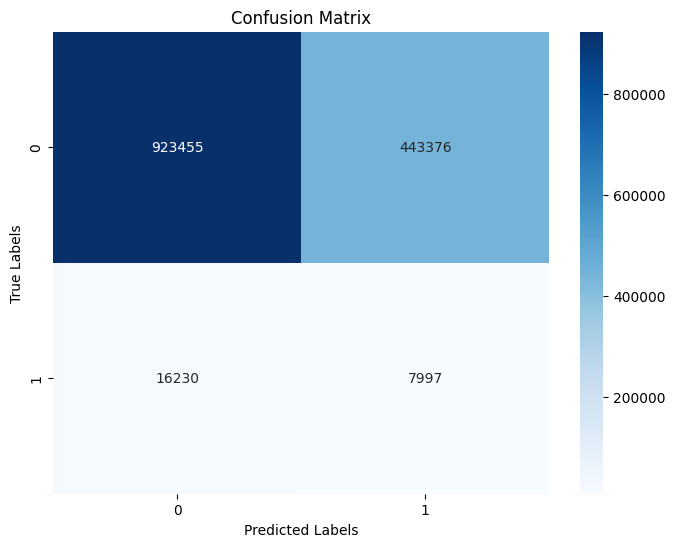

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()